In [11]:
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.layers import ELU, PReLU, LeakyReLU
#from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import drive
drive.mount('/content/gdrive')
path = 'gdrive/My Drive/Project/Practice/Result_GAN/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [12]:
# Load the dataset
def load_data():
  (x_train, y_train), (_, _) = mnist.load_data()
  x_train = (x_train.astype(np.float32) - 127.5)/127.5
  x_train = x_train.reshape(60000, 784)
  return (x_train, y_train)

X_train, y_train = load_data()
print(X_train.shape, y_train.shape)

(60000, 784) (60000,)


# GENERATOR 生成器(畫家)

In [13]:
def build_generator():
    model = Sequential()
    
    model.add(Dense(units=256, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(units=512))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(units=1024))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(units=784, activation='tanh'))
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
    return model

generator = build_generator()
generator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 256)               25856     
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 256)               0         
                                                                 
 dense_17 (Dense)            (None, 512)               131584    
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_18 (Dense)            (None, 1024)              525312    
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 1024)              0         
                                                                 
 dense_19 (Dense)            (None, 784)              

# DISCRIMINATOR 鑑賞家 (畫的鑑賞家)

In [14]:
def build_discriminator():
    model = Sequential()
    
    model.add(Dense(units=1024 ,input_dim=784))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
       
    model.add(Dense(units=512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
       
    model.add(Dense(units=256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
      
    model.add(Dense(units=1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
    return model
  
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 1024)              803840    
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 1024)              0         
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_21 (Dense)            (None, 512)               524800    
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 512)               0         
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_22 (Dense)            (None, 256)              

In [15]:
def build_GAN(discriminator, generator):
    discriminator.trainable=False
    GAN_input = Input(shape=(100,))
    x = generator(GAN_input) #GENERATOR產生的畫作 x
    GAN_output= discriminator(x) #DISCRIMINATOR根據 x 做鑑別
    GAN = Model(inputs=GAN_input, outputs=GAN_output)
    GAN.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
    return GAN
  
GAN = build_GAN(discriminator, generator)
GAN.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_4 (Sequential)   (None, 784)               1486352   
                                                                 
 sequential_5 (Sequential)   (None, 1)                 1460225   
                                                                 
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


In [16]:
def draw_images(generator, epoch, examples=25, dim=(5,5), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(25,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='Greys')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(path+'Generated_images %d.png' %epoch)

# 訓練流程

In [17]:
def train_GAN(epochs=1, batch_size=128):
    
  #Loading the data
  X_train, y_train = load_data()

  # Creating GAN
  generator= build_generator()
  discriminator= build_discriminator()
  GAN = build_GAN(discriminator, generator)

  for i in range(1, epochs+1):
    print("Epoch %d" %i)
    
    for _ in tqdm(range(batch_size)):
      # Generate fake images from random noiset
      noise= np.random.normal(0,1, (batch_size, 100))
      fake_images = generator.predict(noise)

      # Select a random batch of real images from MNIST
      real_images = X_train[np.random.randint(0, X_train.shape[0], batch_size)]

      # Labels for fake and real images           
      label_fake = np.zeros(batch_size)
      label_real = np.ones(batch_size) 

      # Concatenate fake and real images 
      X = np.concatenate([fake_images, real_images])
      y = np.concatenate([label_fake, label_real])

      # Train the discriminator
      discriminator.trainable=True
      discriminator.train_on_batch(X, y)

      # Train the generator/chained GAN model (with frozen weights in discriminator) 
      discriminator.trainable=False #把鑑賞家參數凍結不要訓練
      GAN.train_on_batch(noise, label_real) # 讓generator生成的image愈接近label_real

    # Draw generated images every 15 epoches     
    if i == 1 or i % 10 == 0:
      draw_images(generator, i)

Epoch 1


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 1/128 [00:01<02:43,  1.29s/it]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 3/128 [00:01<00:50,  2.47it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 5/128 [00:01<00:30,  4.06it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▍         | 6/128 [00:01<00:25,  4.78it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▌         | 7/128 [00:01<00:22,  5.28it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▋         | 8/128 [00:02<00:19,  6.06it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 9/128 [00:02<00:17,  6.73it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 10/128 [00:02<00:16,  7.32it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▊         | 11/128 [00:02<00:15,  7.32it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 12/128 [00:02<00:14,  7.87it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 13/128 [00:02<00:14,  8.21it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 15/128 [00:02<00:13,  8.30it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 17/128 [00:03<00:12,  8.94it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▍        | 18/128 [00:03<00:12,  8.50it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 19/128 [00:03<00:13,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▋        | 21/128 [00:03<00:12,  8.87it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 22/128 [00:03<00:11,  9.03it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 24/128 [00:03<00:11,  9.34it/s]

4/4 [==============================] - 0s 3ms/step


 20%|█▉        | 25/128 [00:03<00:10,  9.41it/s]

4/4 [==============================] - 0s 4ms/step


 20%|██        | 26/128 [00:04<00:10,  9.51it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:04<00:10,  9.78it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 29/128 [00:04<00:10,  9.07it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 30/128 [00:04<00:10,  9.12it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 31/128 [00:04<00:11,  8.33it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 32/128 [00:04<00:11,  8.42it/s]

4/4 [==============================] - 0s 3ms/step


 26%|██▌       | 33/128 [00:04<00:11,  8.59it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 35/128 [00:05<00:10,  9.23it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██▊       | 36/128 [00:05<00:09,  9.40it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▉       | 37/128 [00:05<00:09,  9.48it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 39/128 [00:05<00:09,  8.98it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███▏      | 40/128 [00:05<00:09,  9.11it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 41/128 [00:05<00:09,  9.25it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 42/128 [00:05<00:09,  9.29it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▎      | 43/128 [00:05<00:09,  8.64it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▌      | 45/128 [00:06<00:08,  9.40it/s]

4/4 [==============================] - 0s 4ms/step


 36%|███▌      | 46/128 [00:06<00:08,  9.52it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 47/128 [00:06<00:08,  9.60it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 48/128 [00:06<00:08,  9.53it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 49/128 [00:06<00:08,  9.54it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 50/128 [00:06<00:09,  8.67it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███▉      | 51/128 [00:06<00:09,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 52/128 [00:06<00:09,  8.42it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████▏     | 53/128 [00:07<00:08,  8.82it/s]

4/4 [==============================] - 0s 4ms/step


 43%|████▎     | 55/128 [00:07<00:07,  9.44it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 56/128 [00:07<00:08,  8.76it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▌     | 58/128 [00:07<00:08,  8.57it/s]

4/4 [==============================] - 0s 3ms/step


 46%|████▌     | 59/128 [00:07<00:08,  8.13it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 60/128 [00:07<00:08,  8.37it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 61/128 [00:07<00:08,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 62/128 [00:08<00:08,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 49%|████▉     | 63/128 [00:08<00:09,  7.09it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:08<00:09,  6.65it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████     | 65/128 [00:08<00:09,  6.40it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 66/128 [00:08<00:09,  6.59it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 67/128 [00:08<00:09,  6.18it/s]

4/4 [==============================] - 0s 5ms/step


 53%|█████▎    | 68/128 [00:09<00:09,  6.55it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▍    | 69/128 [00:09<00:09,  6.38it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▍    | 70/128 [00:09<00:09,  6.24it/s]

4/4 [==============================] - 0s 6ms/step


 55%|█████▌    | 71/128 [00:09<00:09,  6.32it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████▋    | 72/128 [00:09<00:09,  6.16it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████▋    | 73/128 [00:09<00:09,  5.98it/s]

4/4 [==============================] - 0s 5ms/step


 58%|█████▊    | 74/128 [00:10<00:09,  5.96it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▊    | 75/128 [00:10<00:08,  5.92it/s]

4/4 [==============================] - 0s 6ms/step


 59%|█████▉    | 76/128 [00:10<00:08,  6.15it/s]

4/4 [==============================] - 0s 3ms/step


 60%|██████    | 77/128 [00:10<00:08,  5.86it/s]

4/4 [==============================] - 0s 3ms/step


 61%|██████    | 78/128 [00:10<00:08,  5.84it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 79/128 [00:10<00:08,  5.78it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▎   | 80/128 [00:11<00:08,  5.88it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 81/128 [00:11<00:07,  6.25it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████▍   | 82/128 [00:11<00:07,  6.19it/s]

4/4 [==============================] - 0s 5ms/step


 65%|██████▍   | 83/128 [00:11<00:07,  6.02it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▌   | 84/128 [00:11<00:07,  6.19it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▋   | 85/128 [00:11<00:07,  6.07it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 86/128 [00:12<00:07,  5.84it/s]

4/4 [==============================] - 0s 3ms/step


 68%|██████▊   | 87/128 [00:12<00:06,  6.64it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 88/128 [00:12<00:05,  7.33it/s]

4/4 [==============================] - 0s 3ms/step


 70%|███████   | 90/128 [00:12<00:04,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 91/128 [00:12<00:04,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 92/128 [00:12<00:04,  8.50it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 93/128 [00:12<00:04,  8.04it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 94/128 [00:13<00:04,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▍  | 95/128 [00:13<00:03,  8.60it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 96/128 [00:13<00:04,  7.90it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 98/128 [00:13<00:03,  8.85it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 99/128 [00:13<00:03,  9.06it/s]

4/4 [==============================] - 0s 4ms/step


 78%|███████▊  | 100/128 [00:13<00:03,  9.24it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████▉  | 101/128 [00:13<00:02,  9.19it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████▉  | 102/128 [00:13<00:03,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████  | 103/128 [00:14<00:03,  8.05it/s]

4/4 [==============================] - 0s 6ms/step


 81%|████████▏ | 104/128 [00:14<00:03,  7.70it/s]

4/4 [==============================] - 0s 3ms/step


 82%|████████▏ | 105/128 [00:14<00:03,  7.44it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 106/128 [00:14<00:02,  7.39it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▎ | 107/128 [00:14<00:02,  7.25it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 108/128 [00:14<00:02,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 109/128 [00:14<00:02,  7.47it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████▌ | 110/128 [00:15<00:02,  7.21it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 111/128 [00:15<00:02,  7.80it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 112/128 [00:15<00:01,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 113/128 [00:15<00:01,  8.53it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 114/128 [00:15<00:01,  8.76it/s]

4/4 [==============================] - 0s 3ms/step


 90%|████████▉ | 115/128 [00:15<00:01,  9.07it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████ | 116/128 [00:15<00:01,  9.22it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████▏| 117/128 [00:15<00:01,  9.39it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 118/128 [00:15<00:01,  8.59it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 119/128 [00:16<00:01,  8.89it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▍| 120/128 [00:16<00:00,  8.22it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▍| 121/128 [00:16<00:00,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▌| 122/128 [00:16<00:00,  8.81it/s]

4/4 [==============================] - 0s 3ms/step


 96%|█████████▌| 123/128 [00:16<00:00,  9.10it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 124/128 [00:16<00:00,  9.21it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 125/128 [00:16<00:00,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 126/128 [00:16<00:00,  8.57it/s]

4/4 [==============================] - 0s 3ms/step


 99%|█████████▉| 127/128 [00:16<00:00,  8.88it/s]

4/4 [==============================] - 0s 4ms/step


100%|██████████| 128/128 [00:17<00:00,  7.51it/s]


1/1 [==============================] - 0s 79ms/step
Epoch 2


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 2/128 [00:00<00:12, 10.29it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 4/128 [00:00<00:14,  8.83it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 5/128 [00:00<00:13,  9.01it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▍         | 6/128 [00:00<00:13,  9.16it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▌         | 7/128 [00:00<00:12,  9.38it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▋         | 8/128 [00:00<00:14,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 9/128 [00:01<00:13,  8.55it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 10/128 [00:01<00:14,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▊         | 11/128 [00:01<00:15,  7.71it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 12/128 [00:01<00:14,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 10%|█         | 13/128 [00:01<00:14,  7.91it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 14/128 [00:01<00:13,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▎        | 16/128 [00:01<00:13,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 17/128 [00:01<00:12,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▍        | 18/128 [00:02<00:12,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 19/128 [00:02<00:12,  8.76it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 20/128 [00:02<00:12,  8.92it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▋        | 21/128 [00:02<00:11,  9.12it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 22/128 [00:02<00:11,  9.28it/s]

4/4 [==============================] - 0s 3ms/step


 18%|█▊        | 23/128 [00:02<00:11,  9.13it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 24/128 [00:02<00:11,  9.35it/s]

4/4 [==============================] - 0s 4ms/step


 20%|█▉        | 25/128 [00:02<00:10,  9.48it/s]

4/4 [==============================] - 0s 4ms/step


 20%|██        | 26/128 [00:02<00:11,  8.51it/s]

4/4 [==============================] - 0s 8ms/step


 21%|██        | 27/128 [00:03<00:12,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 28/128 [00:03<00:11,  8.43it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 29/128 [00:03<00:11,  8.78it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 30/128 [00:03<00:10,  9.06it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██▍       | 31/128 [00:03<00:10,  8.88it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 32/128 [00:03<00:10,  9.11it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▌       | 33/128 [00:03<00:10,  9.32it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 34/128 [00:03<00:10,  8.71it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 35/128 [00:04<00:11,  7.86it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 36/128 [00:04<00:13,  6.81it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▉       | 37/128 [00:04<00:13,  6.96it/s]

4/4 [==============================] - 0s 4ms/step


 30%|██▉       | 38/128 [00:04<00:13,  6.57it/s]

4/4 [==============================] - 0s 5ms/step


 30%|███       | 39/128 [00:04<00:14,  6.33it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███▏      | 40/128 [00:04<00:14,  6.20it/s]

4/4 [==============================] - 0s 5ms/step


 32%|███▏      | 41/128 [00:05<00:14,  6.08it/s]

4/4 [==============================] - 0s 5ms/step


 33%|███▎      | 42/128 [00:05<00:14,  6.14it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▎      | 43/128 [00:05<00:14,  6.02it/s]

4/4 [==============================] - 0s 6ms/step


 34%|███▍      | 44/128 [00:05<00:13,  6.08it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▌      | 45/128 [00:05<00:14,  5.83it/s]

4/4 [==============================] - 0s 4ms/step


 36%|███▌      | 46/128 [00:05<00:14,  5.80it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 47/128 [00:06<00:12,  6.28it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 48/128 [00:06<00:12,  6.19it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 49/128 [00:06<00:13,  6.06it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▉      | 50/128 [00:06<00:13,  5.77it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███▉      | 51/128 [00:06<00:12,  5.98it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████      | 52/128 [00:06<00:12,  6.00it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████▏     | 53/128 [00:07<00:12,  6.04it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 54/128 [00:07<00:12,  5.82it/s]

4/4 [==============================] - 0s 4ms/step


 43%|████▎     | 55/128 [00:07<00:13,  5.57it/s]

4/4 [==============================] - 0s 5ms/step


 44%|████▍     | 56/128 [00:07<00:13,  5.52it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▍     | 57/128 [00:07<00:12,  5.59it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▌     | 58/128 [00:07<00:12,  5.71it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████▌     | 59/128 [00:08<00:11,  5.95it/s]

4/4 [==============================] - 0s 4ms/step


 47%|████▋     | 60/128 [00:08<00:10,  6.21it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 61/128 [00:08<00:09,  6.92it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 62/128 [00:08<00:08,  7.56it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▉     | 63/128 [00:08<00:08,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 50%|█████     | 64/128 [00:08<00:08,  7.51it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████     | 65/128 [00:08<00:08,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 66/128 [00:09<00:08,  7.21it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 67/128 [00:09<00:08,  7.18it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 68/128 [00:09<00:07,  7.66it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 69/128 [00:09<00:07,  7.42it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▍    | 70/128 [00:09<00:07,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▌    | 71/128 [00:09<00:07,  8.14it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▋    | 72/128 [00:09<00:06,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████▋    | 73/128 [00:09<00:06,  8.61it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 74/128 [00:10<00:06,  7.98it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▊    | 75/128 [00:10<00:06,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 76/128 [00:10<00:06,  8.66it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 77/128 [00:10<00:05,  8.72it/s]

4/4 [==============================] - 0s 5ms/step


 61%|██████    | 78/128 [00:10<00:06,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▏   | 79/128 [00:10<00:06,  7.82it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▎   | 80/128 [00:10<00:06,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 81/128 [00:10<00:05,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████▍   | 82/128 [00:10<00:05,  8.47it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▍   | 83/128 [00:11<00:05,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▌   | 84/128 [00:11<00:05,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▋   | 85/128 [00:11<00:05,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 67%|██████▋   | 86/128 [00:11<00:05,  7.56it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████▊   | 87/128 [00:11<00:05,  7.29it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 88/128 [00:11<00:05,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 70%|██████▉   | 89/128 [00:11<00:05,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████   | 90/128 [00:12<00:04,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 91/128 [00:12<00:04,  8.26it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 92/128 [00:12<00:04,  8.68it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 93/128 [00:12<00:03,  8.83it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 94/128 [00:12<00:04,  8.19it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▍  | 95/128 [00:12<00:03,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████▌  | 96/128 [00:12<00:04,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 76%|███████▌  | 97/128 [00:12<00:03,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 99/128 [00:13<00:03,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 78%|███████▊  | 100/128 [00:13<00:03,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 101/128 [00:13<00:03,  7.40it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 102/128 [00:13<00:03,  7.88it/s]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 103/128 [00:13<00:03,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████▏ | 104/128 [00:13<00:02,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 105/128 [00:13<00:02,  8.48it/s]

4/4 [==============================] - 0s 4ms/step


 83%|████████▎ | 106/128 [00:13<00:02,  8.65it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▎ | 107/128 [00:14<00:02,  8.87it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▍ | 108/128 [00:14<00:02,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 109/128 [00:14<00:02,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████▌ | 110/128 [00:14<00:02,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 111/128 [00:14<00:02,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 112/128 [00:14<00:02,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 113/128 [00:14<00:01,  7.63it/s]

4/4 [==============================] - 0s 6ms/step


 89%|████████▉ | 114/128 [00:14<00:01,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████▉ | 115/128 [00:15<00:01,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████ | 116/128 [00:15<00:01,  8.15it/s]

4/4 [==============================] - 0s 7ms/step


 91%|█████████▏| 117/128 [00:15<00:01,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████▏| 118/128 [00:15<00:01,  7.78it/s]

4/4 [==============================] - 0s 5ms/step


 93%|█████████▎| 119/128 [00:15<00:01,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▍| 120/128 [00:15<00:00,  8.52it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▍| 121/128 [00:15<00:00,  8.86it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▌| 123/128 [00:15<00:00,  9.34it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 124/128 [00:16<00:00,  9.49it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 125/128 [00:16<00:00,  8.75it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 126/128 [00:16<00:00,  8.23it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▉| 127/128 [00:16<00:00,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


100%|██████████| 128/128 [00:16<00:00,  7.70it/s]


Epoch 3


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 1/128 [00:00<00:13,  9.72it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 2/128 [00:00<00:13,  9.46it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 3/128 [00:00<00:15,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 4/128 [00:00<00:16,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 5/128 [00:00<00:15,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▍         | 6/128 [00:00<00:15,  7.73it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▌         | 7/128 [00:00<00:15,  7.67it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▋         | 8/128 [00:01<00:15,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 9/128 [00:01<00:14,  8.09it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 10/128 [00:01<00:14,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▊         | 11/128 [00:01<00:15,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 12/128 [00:01<00:15,  7.59it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 13/128 [00:01<00:16,  6.90it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 14/128 [00:01<00:16,  6.89it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 15/128 [00:02<00:17,  6.41it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▎        | 16/128 [00:02<00:18,  6.22it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 17/128 [00:02<00:18,  6.05it/s]

4/4 [==============================] - 0s 7ms/step


 14%|█▍        | 18/128 [00:02<00:18,  6.10it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▍        | 19/128 [00:02<00:18,  6.00it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 20/128 [00:02<00:18,  5.73it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▋        | 21/128 [00:03<00:18,  5.74it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█▋        | 22/128 [00:03<00:18,  5.87it/s]

4/4 [==============================] - 0s 3ms/step


 18%|█▊        | 23/128 [00:03<00:18,  5.80it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 24/128 [00:03<00:18,  5.76it/s]

4/4 [==============================] - 0s 4ms/step


 20%|█▉        | 25/128 [00:03<00:17,  5.87it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 26/128 [00:03<00:17,  5.84it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██        | 27/128 [00:04<00:17,  5.88it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:04<00:17,  5.81it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 29/128 [00:04<00:16,  5.93it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 30/128 [00:04<00:16,  5.88it/s]

4/4 [==============================] - 0s 6ms/step


 24%|██▍       | 31/128 [00:04<00:16,  5.91it/s]

4/4 [==============================] - 0s 5ms/step


 25%|██▌       | 32/128 [00:04<00:15,  6.25it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▌       | 33/128 [00:05<00:15,  5.94it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 34/128 [00:05<00:16,  5.76it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 35/128 [00:05<00:16,  5.77it/s]

4/4 [==============================] - 0s 6ms/step


 28%|██▊       | 36/128 [00:05<00:17,  5.39it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▉       | 37/128 [00:05<00:15,  6.06it/s]

4/4 [==============================] - 0s 4ms/step


 30%|██▉       | 38/128 [00:05<00:14,  6.21it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███       | 39/128 [00:06<00:13,  6.61it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███▏      | 40/128 [00:06<00:12,  7.24it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 41/128 [00:06<00:12,  7.14it/s]

4/4 [==============================] - 0s 6ms/step


 33%|███▎      | 42/128 [00:06<00:12,  7.13it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▎      | 43/128 [00:06<00:11,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 44/128 [00:06<00:11,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███▌      | 45/128 [00:06<00:11,  7.40it/s]

4/4 [==============================] - 0s 4ms/step


 36%|███▌      | 46/128 [00:06<00:11,  7.30it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 47/128 [00:07<00:10,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 48/128 [00:07<00:10,  7.34it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 49/128 [00:07<00:10,  7.77it/s]

4/4 [==============================] - 0s 6ms/step


 39%|███▉      | 50/128 [00:07<00:09,  8.03it/s]

4/4 [==============================] - 0s 3ms/step


 40%|███▉      | 51/128 [00:07<00:09,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 52/128 [00:07<00:09,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████▏     | 53/128 [00:07<00:08,  8.49it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 54/128 [00:07<00:08,  8.77it/s]

4/4 [==============================] - 0s 4ms/step


 43%|████▎     | 55/128 [00:08<00:08,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 56/128 [00:08<00:08,  8.74it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▍     | 57/128 [00:08<00:08,  8.86it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▌     | 58/128 [00:08<00:08,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████▌     | 59/128 [00:08<00:08,  7.74it/s]

4/4 [==============================] - 0s 5ms/step


 47%|████▋     | 60/128 [00:08<00:08,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 61/128 [00:08<00:08,  7.71it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 62/128 [00:08<00:08,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


 49%|████▉     | 63/128 [00:09<00:08,  7.37it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:09<00:08,  7.23it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████     | 65/128 [00:09<00:08,  7.20it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 66/128 [00:09<00:08,  7.62it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 67/128 [00:09<00:07,  8.09it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 68/128 [00:09<00:07,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▍    | 69/128 [00:09<00:07,  8.04it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▍    | 70/128 [00:10<00:07,  7.66it/s]

4/4 [==============================] - 0s 7ms/step


 55%|█████▌    | 71/128 [00:10<00:07,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████▋    | 72/128 [00:10<00:06,  8.10it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 73/128 [00:10<00:06,  8.46it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 74/128 [00:10<00:06,  8.78it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▊    | 75/128 [00:10<00:06,  8.21it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▉    | 76/128 [00:10<00:06,  8.39it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 77/128 [00:10<00:06,  7.73it/s]

4/4 [==============================] - 0s 3ms/step


 61%|██████    | 78/128 [00:10<00:06,  8.16it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▏   | 79/128 [00:11<00:06,  7.47it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▎   | 80/128 [00:11<00:06,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 81/128 [00:11<00:06,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████▍   | 82/128 [00:11<00:06,  7.40it/s]

4/4 [==============================] - 0s 5ms/step


 65%|██████▍   | 83/128 [00:11<00:06,  7.26it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▌   | 84/128 [00:11<00:06,  7.15it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▋   | 85/128 [00:11<00:05,  7.19it/s]

4/4 [==============================] - 0s 4ms/step


 67%|██████▋   | 86/128 [00:12<00:05,  7.70it/s]

4/4 [==============================] - 0s 6ms/step


 68%|██████▊   | 87/128 [00:12<00:05,  7.83it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████▉   | 88/128 [00:12<00:04,  8.20it/s]

4/4 [==============================] - 0s 4ms/step


 70%|██████▉   | 89/128 [00:12<00:04,  7.85it/s]

4/4 [==============================] - 0s 6ms/step


 70%|███████   | 90/128 [00:12<00:04,  7.61it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████   | 91/128 [00:12<00:04,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 92/128 [00:12<00:04,  8.50it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 93/128 [00:12<00:04,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 94/128 [00:13<00:04,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▍  | 95/128 [00:13<00:03,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████▌  | 96/128 [00:13<00:04,  7.75it/s]

4/4 [==============================] - 0s 3ms/step


 76%|███████▌  | 97/128 [00:13<00:03,  8.22it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 98/128 [00:13<00:03,  8.39it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 99/128 [00:13<00:03,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 78%|███████▊  | 100/128 [00:13<00:03,  8.34it/s]

4/4 [==============================] - 0s 3ms/step


 79%|███████▉  | 101/128 [00:13<00:03,  7.85it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 102/128 [00:14<00:03,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████  | 103/128 [00:14<00:03,  7.82it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 104/128 [00:14<00:03,  7.30it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 105/128 [00:14<00:03,  7.23it/s]

4/4 [==============================] - 0s 4ms/step


 83%|████████▎ | 106/128 [00:14<00:02,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▎ | 107/128 [00:14<00:02,  7.37it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▍ | 108/128 [00:14<00:02,  7.25it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████▌ | 109/128 [00:14<00:02,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████▌ | 110/128 [00:15<00:02,  7.37it/s]

4/4 [==============================] - 0s 6ms/step


 87%|████████▋ | 111/128 [00:15<00:02,  7.08it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 112/128 [00:15<00:02,  7.54it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 113/128 [00:15<00:01,  7.96it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 114/128 [00:15<00:01,  8.27it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████▉ | 115/128 [00:15<00:01,  8.45it/s]

4/4 [==============================] - 0s 6ms/step


 91%|█████████ | 116/128 [00:15<00:01,  7.17it/s]

4/4 [==============================] - 0s 6ms/step


 91%|█████████▏| 117/128 [00:16<00:01,  6.67it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 118/128 [00:16<00:01,  6.20it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 119/128 [00:16<00:01,  6.10it/s]

4/4 [==============================] - 0s 5ms/step


 94%|█████████▍| 120/128 [00:16<00:01,  6.03it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▍| 121/128 [00:16<00:01,  6.09it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 122/128 [00:16<00:01,  5.95it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████▌| 123/128 [00:17<00:00,  5.71it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████▋| 124/128 [00:17<00:00,  5.95it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 125/128 [00:17<00:00,  6.11it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 126/128 [00:17<00:00,  6.36it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▉| 127/128 [00:17<00:00,  6.23it/s]

4/4 [==============================] - 0s 6ms/step


100%|██████████| 128/128 [00:17<00:00,  7.15it/s]


Epoch 4


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 1/128 [00:00<00:21,  5.80it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 2/128 [00:00<00:21,  5.93it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 3/128 [00:00<00:21,  5.84it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 4/128 [00:00<00:21,  5.79it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 5/128 [00:00<00:22,  5.55it/s]

4/4 [==============================] - 0s 6ms/step


  5%|▍         | 6/128 [00:01<00:21,  5.64it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▌         | 7/128 [00:01<00:21,  5.59it/s]

4/4 [==============================] - 0s 6ms/step


  6%|▋         | 8/128 [00:01<00:20,  5.91it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 9/128 [00:01<00:21,  5.53it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 10/128 [00:01<00:20,  5.67it/s]

4/4 [==============================] - 0s 6ms/step


  9%|▊         | 11/128 [00:01<00:20,  5.79it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 12/128 [00:02<00:19,  6.08it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 13/128 [00:02<00:19,  6.00it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█         | 14/128 [00:02<00:19,  5.91it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▏        | 15/128 [00:02<00:18,  6.20it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▎        | 16/128 [00:02<00:17,  6.44it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 17/128 [00:02<00:15,  7.00it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▍        | 18/128 [00:02<00:15,  7.02it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 19/128 [00:03<00:14,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 20/128 [00:03<00:13,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▋        | 21/128 [00:03<00:14,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 22/128 [00:03<00:13,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 18%|█▊        | 23/128 [00:03<00:13,  7.98it/s]

4/4 [==============================] - 0s 6ms/step


 19%|█▉        | 24/128 [00:03<00:13,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 20%|█▉        | 25/128 [00:03<00:14,  7.32it/s]

4/4 [==============================] - 0s 5ms/step


 20%|██        | 26/128 [00:03<00:14,  7.17it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██        | 27/128 [00:04<00:13,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 28/128 [00:04<00:13,  7.39it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 29/128 [00:04<00:14,  7.05it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 30/128 [00:04<00:14,  6.99it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██▍       | 31/128 [00:04<00:14,  6.90it/s]

4/4 [==============================] - 0s 5ms/step


 25%|██▌       | 32/128 [00:04<00:13,  6.96it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▌       | 33/128 [00:04<00:12,  7.42it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 34/128 [00:05<00:12,  7.26it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 35/128 [00:05<00:13,  7.15it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██▊       | 36/128 [00:05<00:13,  7.04it/s]

4/4 [==============================] - 0s 5ms/step


 29%|██▉       | 37/128 [00:05<00:11,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 30%|██▉       | 38/128 [00:05<00:12,  7.39it/s]

4/4 [==============================] - 0s 5ms/step


 30%|███       | 39/128 [00:05<00:12,  7.14it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███▏      | 40/128 [00:05<00:12,  7.12it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 41/128 [00:06<00:12,  6.99it/s]

4/4 [==============================] - 0s 5ms/step


 33%|███▎      | 42/128 [00:06<00:12,  7.02it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▎      | 43/128 [00:06<00:12,  6.95it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 44/128 [00:06<00:11,  7.39it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▌      | 45/128 [00:06<00:11,  7.25it/s]

4/4 [==============================] - 0s 4ms/step


 36%|███▌      | 46/128 [00:06<00:11,  7.17it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 47/128 [00:06<00:10,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 48/128 [00:06<00:09,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 49/128 [00:07<00:10,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▉      | 50/128 [00:07<00:09,  8.16it/s]

4/4 [==============================] - 0s 3ms/step


 40%|███▉      | 51/128 [00:07<00:09,  8.45it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████      | 52/128 [00:07<00:09,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████▏     | 53/128 [00:07<00:10,  7.37it/s]

4/4 [==============================] - 0s 5ms/step


 42%|████▏     | 54/128 [00:07<00:10,  7.15it/s]

4/4 [==============================] - 0s 4ms/step


 43%|████▎     | 55/128 [00:07<00:10,  6.81it/s]

4/4 [==============================] - 0s 5ms/step


 44%|████▍     | 56/128 [00:08<00:10,  6.96it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▍     | 57/128 [00:08<00:10,  6.82it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▌     | 58/128 [00:08<00:09,  7.48it/s]

4/4 [==============================] - 0s 3ms/step


 46%|████▌     | 59/128 [00:08<00:08,  7.79it/s]

4/4 [==============================] - 0s 5ms/step


 47%|████▋     | 60/128 [00:08<00:08,  8.07it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 61/128 [00:08<00:08,  7.70it/s]

4/4 [==============================] - 0s 6ms/step


 48%|████▊     | 62/128 [00:08<00:08,  7.37it/s]

4/4 [==============================] - 0s 8ms/step


 49%|████▉     | 63/128 [00:09<00:08,  7.24it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:09<00:08,  7.34it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████     | 65/128 [00:09<00:08,  7.26it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 66/128 [00:09<00:08,  6.97it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 67/128 [00:09<00:08,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 68/128 [00:09<00:07,  7.83it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 69/128 [00:09<00:07,  7.55it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▍    | 70/128 [00:09<00:07,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▌    | 71/128 [00:10<00:07,  8.02it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████▋    | 72/128 [00:10<00:07,  7.67it/s]

4/4 [==============================] - 0s 7ms/step


 57%|█████▋    | 73/128 [00:10<00:06,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 58%|█████▊    | 74/128 [00:10<00:07,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▊    | 75/128 [00:10<00:07,  7.42it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▉    | 76/128 [00:10<00:06,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 77/128 [00:10<00:06,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████    | 78/128 [00:10<00:06,  7.84it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 79/128 [00:11<00:06,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▎   | 80/128 [00:11<00:06,  7.92it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 81/128 [00:11<00:05,  8.24it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▍   | 82/128 [00:11<00:05,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▍   | 83/128 [00:11<00:05,  7.89it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▌   | 84/128 [00:11<00:05,  7.53it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▋   | 85/128 [00:11<00:05,  7.41it/s]

4/4 [==============================] - 0s 4ms/step


 67%|██████▋   | 86/128 [00:12<00:05,  7.73it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████▊   | 87/128 [00:12<00:05,  7.46it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████▉   | 88/128 [00:12<00:05,  7.32it/s]

4/4 [==============================] - 0s 6ms/step


 70%|██████▉   | 89/128 [00:12<00:05,  7.01it/s]

4/4 [==============================] - 0s 5ms/step


 70%|███████   | 90/128 [00:12<00:05,  6.94it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 91/128 [00:12<00:05,  6.27it/s]

4/4 [==============================] - 0s 6ms/step


 72%|███████▏  | 92/128 [00:12<00:06,  5.94it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 93/128 [00:13<00:05,  5.86it/s]

4/4 [==============================] - 0s 7ms/step


 73%|███████▎  | 94/128 [00:13<00:05,  5.95it/s]

4/4 [==============================] - 0s 3ms/step


 74%|███████▍  | 95/128 [00:13<00:05,  5.86it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 96/128 [00:13<00:05,  5.73it/s]

4/4 [==============================] - 0s 6ms/step


 76%|███████▌  | 97/128 [00:13<00:05,  5.76it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 98/128 [00:14<00:05,  5.65it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 99/128 [00:14<00:05,  5.62it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:14<00:05,  5.48it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 101/128 [00:14<00:04,  5.98it/s]

4/4 [==============================] - 0s 6ms/step


 80%|███████▉  | 102/128 [00:14<00:04,  6.18it/s]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 103/128 [00:14<00:03,  6.27it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 104/128 [00:15<00:04,  5.90it/s]

4/4 [==============================] - 0s 8ms/step


 82%|████████▏ | 105/128 [00:15<00:03,  5.87it/s]

4/4 [==============================] - 0s 6ms/step


 83%|████████▎ | 106/128 [00:15<00:03,  5.80it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▎ | 107/128 [00:15<00:03,  5.82it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▍ | 108/128 [00:15<00:03,  5.82it/s]

4/4 [==============================] - 0s 3ms/step


 85%|████████▌ | 109/128 [00:15<00:03,  5.59it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 110/128 [00:16<00:03,  5.59it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 111/128 [00:16<00:02,  5.76it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 112/128 [00:16<00:02,  5.77it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 113/128 [00:16<00:02,  6.21it/s]

4/4 [==============================] - 0s 4ms/step


 89%|████████▉ | 114/128 [00:16<00:02,  5.93it/s]

4/4 [==============================] - 0s 6ms/step


 90%|████████▉ | 115/128 [00:16<00:02,  6.24it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████ | 116/128 [00:17<00:01,  6.20it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████▏| 117/128 [00:17<00:01,  6.46it/s]

4/4 [==============================] - 0s 6ms/step


 92%|█████████▏| 118/128 [00:17<00:01,  7.03it/s]

4/4 [==============================] - 0s 3ms/step


 93%|█████████▎| 119/128 [00:17<00:01,  6.95it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▍| 120/128 [00:17<00:01,  4.21it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▍| 121/128 [00:18<00:01,  4.83it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▌| 122/128 [00:18<00:01,  5.24it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▌| 123/128 [00:18<00:00,  5.93it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████▋| 124/128 [00:18<00:00,  5.97it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 125/128 [00:18<00:00,  6.57it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 126/128 [00:18<00:00,  6.44it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▉| 127/128 [00:18<00:00,  6.48it/s]

4/4 [==============================] - 0s 4ms/step


100%|██████████| 128/128 [00:19<00:00,  6.72it/s]


Epoch 5


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 1/128 [00:00<00:16,  7.59it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 2/128 [00:00<00:15,  8.08it/s]

4/4 [==============================] - 0s 6ms/step


  2%|▏         | 3/128 [00:00<00:17,  7.33it/s]

4/4 [==============================] - 0s 5ms/step


  3%|▎         | 4/128 [00:00<00:17,  6.99it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 5/128 [00:00<00:17,  6.88it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▍         | 6/128 [00:00<00:16,  7.36it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▌         | 7/128 [00:00<00:17,  7.08it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▋         | 8/128 [00:01<00:17,  6.82it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 9/128 [00:01<00:16,  7.19it/s]

4/4 [==============================] - 0s 6ms/step


  8%|▊         | 10/128 [00:01<00:16,  7.30it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▊         | 11/128 [00:01<00:15,  7.62it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 12/128 [00:01<00:14,  7.87it/s]

4/4 [==============================] - 0s 5ms/step


 10%|█         | 13/128 [00:01<00:14,  8.03it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 14/128 [00:01<00:15,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 15/128 [00:02<00:14,  7.67it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▎        | 16/128 [00:02<00:15,  7.16it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 17/128 [00:02<00:14,  7.46it/s]

4/4 [==============================] - 0s 6ms/step


 14%|█▍        | 18/128 [00:02<00:15,  6.95it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 19/128 [00:02<00:15,  6.82it/s]

4/4 [==============================] - 0s 6ms/step


 16%|█▌        | 20/128 [00:02<00:16,  6.74it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▋        | 21/128 [00:02<00:16,  6.65it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 22/128 [00:03<00:16,  6.55it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 23/128 [00:03<00:15,  6.56it/s]

4/4 [==============================] - 0s 5ms/step


 19%|█▉        | 24/128 [00:03<00:16,  6.49it/s]

4/4 [==============================] - 0s 6ms/step


 20%|█▉        | 25/128 [00:03<00:14,  6.96it/s]

4/4 [==============================] - 0s 4ms/step


 20%|██        | 26/128 [00:03<00:13,  7.38it/s]

4/4 [==============================] - 0s 5ms/step


 21%|██        | 27/128 [00:03<00:13,  7.49it/s]

4/4 [==============================] - 0s 6ms/step


 22%|██▏       | 28/128 [00:03<00:13,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 29/128 [00:04<00:12,  7.90it/s]

4/4 [==============================] - 0s 6ms/step


 23%|██▎       | 30/128 [00:04<00:13,  7.43it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██▍       | 31/128 [00:04<00:13,  7.14it/s]

4/4 [==============================] - 0s 4ms/step


 25%|██▌       | 32/128 [00:04<00:12,  7.57it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▌       | 33/128 [00:04<00:11,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 34/128 [00:04<00:11,  8.22it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 35/128 [00:04<00:12,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██▊       | 36/128 [00:04<00:11,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 37/128 [00:05<00:11,  7.99it/s]

4/4 [==============================] - 0s 5ms/step


 30%|██▉       | 38/128 [00:05<00:11,  7.90it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███       | 39/128 [00:05<00:10,  8.21it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███▏      | 40/128 [00:05<00:11,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 41/128 [00:05<00:10,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 42/128 [00:05<00:11,  7.72it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▎      | 43/128 [00:05<00:11,  7.43it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 44/128 [00:05<00:10,  7.83it/s]

4/4 [==============================] - 0s 6ms/step


 35%|███▌      | 45/128 [00:06<00:10,  8.12it/s]

4/4 [==============================] - 0s 6ms/step


 36%|███▌      | 46/128 [00:06<00:11,  7.28it/s]

4/4 [==============================] - 0s 6ms/step


 37%|███▋      | 47/128 [00:06<00:11,  7.23it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 48/128 [00:06<00:10,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 49/128 [00:06<00:10,  7.28it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▉      | 50/128 [00:06<00:10,  7.18it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███▉      | 51/128 [00:06<00:10,  7.08it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 52/128 [00:07<00:09,  7.64it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████▏     | 53/128 [00:07<00:10,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 54/128 [00:07<00:09,  7.68it/s]

4/4 [==============================] - 0s 5ms/step


 43%|████▎     | 55/128 [00:07<00:09,  7.32it/s]

4/4 [==============================] - 0s 5ms/step


 44%|████▍     | 56/128 [00:07<00:09,  7.22it/s]

4/4 [==============================] - 0s 6ms/step


 45%|████▍     | 57/128 [00:07<00:09,  7.11it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▌     | 58/128 [00:07<00:09,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████▌     | 59/128 [00:07<00:09,  7.41it/s]

4/4 [==============================] - 0s 4ms/step


 47%|████▋     | 60/128 [00:08<00:09,  6.87it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 61/128 [00:08<00:10,  6.67it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 62/128 [00:08<00:10,  6.36it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▉     | 63/128 [00:08<00:10,  6.06it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:08<00:11,  5.80it/s]

4/4 [==============================] - 0s 3ms/step


 51%|█████     | 65/128 [00:09<00:11,  5.63it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 66/128 [00:09<00:10,  5.74it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 67/128 [00:09<00:10,  5.59it/s]

4/4 [==============================] - 0s 5ms/step


 53%|█████▎    | 68/128 [00:09<00:10,  5.48it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 69/128 [00:09<00:10,  5.45it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▍    | 70/128 [00:09<00:10,  5.54it/s]

4/4 [==============================] - 0s 6ms/step


 55%|█████▌    | 71/128 [00:10<00:10,  5.60it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████▋    | 72/128 [00:10<00:09,  5.71it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 73/128 [00:10<00:09,  5.60it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 74/128 [00:10<00:09,  5.53it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▊    | 75/128 [00:10<00:09,  5.62it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 76/128 [00:11<00:09,  5.57it/s]

4/4 [==============================] - 0s 3ms/step


 60%|██████    | 77/128 [00:11<00:09,  5.57it/s]

4/4 [==============================] - 0s 5ms/step


 61%|██████    | 78/128 [00:11<00:08,  5.81it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 79/128 [00:11<00:08,  5.70it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▎   | 80/128 [00:11<00:08,  5.88it/s]

4/4 [==============================] - 0s 7ms/step


 63%|██████▎   | 81/128 [00:11<00:07,  6.02it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▍   | 82/128 [00:12<00:07,  5.78it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▍   | 83/128 [00:12<00:07,  5.87it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▌   | 84/128 [00:12<00:07,  6.15it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▋   | 85/128 [00:12<00:07,  6.02it/s]

4/4 [==============================] - 0s 9ms/step


 67%|██████▋   | 86/128 [00:12<00:08,  5.01it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████▊   | 87/128 [00:12<00:07,  5.71it/s]

4/4 [==============================] - 0s 6ms/step


 69%|██████▉   | 88/128 [00:13<00:06,  6.03it/s]

4/4 [==============================] - 0s 4ms/step


 70%|██████▉   | 89/128 [00:13<00:05,  6.73it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████   | 90/128 [00:13<00:05,  7.37it/s]

4/4 [==============================] - 0s 5ms/step


 71%|███████   | 91/128 [00:13<00:04,  7.70it/s]

4/4 [==============================] - 0s 5ms/step


 72%|███████▏  | 92/128 [00:13<00:04,  7.36it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 93/128 [00:13<00:04,  7.16it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 94/128 [00:13<00:04,  7.10it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▍  | 95/128 [00:13<00:04,  7.48it/s]

4/4 [==============================] - 0s 6ms/step


 75%|███████▌  | 96/128 [00:14<00:04,  7.16it/s]

4/4 [==============================] - 0s 4ms/step


 76%|███████▌  | 97/128 [00:14<00:04,  7.09it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 98/128 [00:14<00:03,  7.52it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 99/128 [00:14<00:04,  7.08it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 100/128 [00:14<00:04,  6.84it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████▉  | 101/128 [00:14<00:03,  7.03it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████▉  | 102/128 [00:14<00:03,  6.94it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████  | 103/128 [00:15<00:03,  6.87it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████▏ | 104/128 [00:15<00:03,  6.95it/s]

4/4 [==============================] - 0s 5ms/step


 82%|████████▏ | 105/128 [00:15<00:03,  6.92it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 106/128 [00:15<00:02,  7.52it/s]

4/4 [==============================] - 0s 6ms/step


 84%|████████▎ | 107/128 [00:15<00:02,  7.15it/s]

4/4 [==============================] - 0s 6ms/step


 84%|████████▍ | 108/128 [00:15<00:02,  7.02it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 109/128 [00:15<00:02,  6.98it/s]

4/4 [==============================] - 0s 6ms/step


 86%|████████▌ | 110/128 [00:16<00:02,  7.06it/s]

4/4 [==============================] - 0s 6ms/step


 87%|████████▋ | 111/128 [00:16<00:02,  6.87it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 112/128 [00:16<00:02,  7.22it/s]

4/4 [==============================] - 0s 6ms/step


 88%|████████▊ | 113/128 [00:16<00:01,  7.59it/s]

4/4 [==============================] - 0s 6ms/step


 89%|████████▉ | 114/128 [00:16<00:01,  7.72it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████▉ | 115/128 [00:16<00:01,  7.86it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████ | 116/128 [00:16<00:01,  7.97it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████▏| 117/128 [00:16<00:01,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████▏| 118/128 [00:17<00:01,  8.09it/s]

4/4 [==============================] - 0s 5ms/step


 93%|█████████▎| 119/128 [00:17<00:01,  8.28it/s]

4/4 [==============================] - 0s 6ms/step


 94%|█████████▍| 120/128 [00:17<00:01,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▍| 121/128 [00:17<00:00,  8.01it/s]

4/4 [==============================] - 0s 6ms/step


 95%|█████████▌| 122/128 [00:17<00:00,  8.06it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▌| 123/128 [00:17<00:00,  8.30it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████▋| 124/128 [00:17<00:00,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 125/128 [00:18<00:00,  7.30it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 126/128 [00:18<00:00,  7.80it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▉| 127/128 [00:18<00:00,  7.49it/s]

4/4 [==============================] - 0s 6ms/step


100%|██████████| 128/128 [00:18<00:00,  6.96it/s]


Epoch 6


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  1%|          | 1/128 [00:00<00:16,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 2/128 [00:00<00:16,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 3/128 [00:00<00:17,  7.21it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 4/128 [00:00<00:16,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 5/128 [00:00<00:17,  7.17it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 6/128 [00:00<00:17,  7.14it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▌         | 7/128 [00:00<00:16,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▋         | 8/128 [00:01<00:15,  7.98it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 9/128 [00:01<00:16,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 10/128 [00:01<00:16,  7.17it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▊         | 11/128 [00:01<00:16,  7.14it/s]

4/4 [==============================] - 0s 7ms/step


  9%|▉         | 12/128 [00:01<00:16,  6.92it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 13/128 [00:01<00:16,  6.80it/s]

4/4 [==============================] - 0s 6ms/step


 11%|█         | 14/128 [00:01<00:16,  6.78it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 15/128 [00:02<00:16,  6.75it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▎        | 16/128 [00:02<00:15,  7.27it/s]

4/4 [==============================] - 0s 5ms/step


 13%|█▎        | 17/128 [00:02<00:15,  6.96it/s]

4/4 [==============================] - 0s 7ms/step


 14%|█▍        | 18/128 [00:02<00:16,  6.79it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▍        | 19/128 [00:02<00:16,  6.68it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 20/128 [00:02<00:14,  7.33it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▋        | 21/128 [00:02<00:13,  7.72it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 22/128 [00:03<00:14,  7.38it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 23/128 [00:03<00:14,  7.10it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 24/128 [00:03<00:14,  6.96it/s]

4/4 [==============================] - 0s 6ms/step


 20%|█▉        | 25/128 [00:03<00:14,  6.89it/s]

4/4 [==============================] - 0s 5ms/step


 20%|██        | 26/128 [00:03<00:15,  6.75it/s]

4/4 [==============================] - 0s 6ms/step


 21%|██        | 27/128 [00:03<00:15,  6.73it/s]

4/4 [==============================] - 0s 5ms/step


 22%|██▏       | 28/128 [00:03<00:14,  6.78it/s]

4/4 [==============================] - 0s 6ms/step


 23%|██▎       | 29/128 [00:04<00:13,  7.25it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 30/128 [00:04<00:14,  7.00it/s]

4/4 [==============================] - 0s 6ms/step


 24%|██▍       | 31/128 [00:04<00:13,  6.96it/s]

4/4 [==============================] - 0s 5ms/step


 25%|██▌       | 32/128 [00:04<00:14,  6.54it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▌       | 33/128 [00:04<00:15,  6.29it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 34/128 [00:04<00:15,  6.19it/s]

4/4 [==============================] - 0s 6ms/step


 27%|██▋       | 35/128 [00:05<00:15,  6.17it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 36/128 [00:05<00:15,  6.13it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 37/128 [00:05<00:14,  6.14it/s]

4/4 [==============================] - 0s 4ms/step


 30%|██▉       | 38/128 [00:05<00:15,  5.75it/s]

4/4 [==============================] - 0s 5ms/step


 30%|███       | 39/128 [00:05<00:15,  5.66it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███▏      | 40/128 [00:05<00:14,  5.96it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 41/128 [00:06<00:14,  5.90it/s]

4/4 [==============================] - 0s 3ms/step


 33%|███▎      | 42/128 [00:06<00:14,  5.86it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▎      | 43/128 [00:06<00:15,  5.54it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 44/128 [00:06<00:15,  5.51it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▌      | 45/128 [00:06<00:14,  5.59it/s]

4/4 [==============================] - 0s 4ms/step


 36%|███▌      | 46/128 [00:06<00:14,  5.71it/s]

4/4 [==============================] - 0s 9ms/step


 37%|███▋      | 47/128 [00:07<00:13,  5.81it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 48/128 [00:07<00:13,  5.81it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 49/128 [00:07<00:13,  5.83it/s]

4/4 [==============================] - 0s 7ms/step


 39%|███▉      | 50/128 [00:07<00:14,  5.56it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███▉      | 51/128 [00:07<00:13,  5.65it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 52/128 [00:08<00:13,  5.70it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████▏     | 53/128 [00:08<00:13,  5.74it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 54/128 [00:08<00:13,  5.67it/s]

4/4 [==============================] - 0s 4ms/step


 43%|████▎     | 55/128 [00:08<00:12,  5.69it/s]

4/4 [==============================] - 0s 5ms/step


 44%|████▍     | 56/128 [00:08<00:12,  5.88it/s]

4/4 [==============================] - 0s 6ms/step


 45%|████▍     | 57/128 [00:08<00:12,  5.91it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▌     | 58/128 [00:09<00:11,  5.92it/s]

4/4 [==============================] - 0s 7ms/step


 46%|████▌     | 59/128 [00:09<00:12,  5.70it/s]

4/4 [==============================] - 0s 6ms/step


 47%|████▋     | 60/128 [00:09<00:11,  5.86it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 61/128 [00:09<00:11,  5.91it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 62/128 [00:09<00:10,  6.08it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▉     | 63/128 [00:09<00:09,  6.60it/s]

4/4 [==============================] - 0s 6ms/step


 50%|█████     | 64/128 [00:09<00:08,  7.13it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████     | 65/128 [00:10<00:08,  7.54it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 66/128 [00:10<00:07,  7.95it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 67/128 [00:10<00:07,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 68/128 [00:10<00:07,  7.63it/s]

4/4 [==============================] - 0s 5ms/step


 54%|█████▍    | 69/128 [00:10<00:07,  7.84it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▍    | 70/128 [00:10<00:07,  7.52it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▌    | 71/128 [00:10<00:07,  7.28it/s]

4/4 [==============================] - 0s 6ms/step


 56%|█████▋    | 72/128 [00:10<00:07,  7.64it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████▋    | 73/128 [00:11<00:06,  8.00it/s]

4/4 [==============================] - 0s 5ms/step


 58%|█████▊    | 74/128 [00:11<00:07,  7.52it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▊    | 75/128 [00:11<00:07,  7.29it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 76/128 [00:11<00:06,  7.68it/s]

4/4 [==============================] - 0s 5ms/step


 60%|██████    | 77/128 [00:11<00:06,  7.50it/s]

4/4 [==============================] - 0s 5ms/step


 61%|██████    | 78/128 [00:11<00:06,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▏   | 79/128 [00:11<00:06,  7.75it/s]

4/4 [==============================] - 0s 7ms/step


 62%|██████▎   | 80/128 [00:12<00:06,  7.85it/s]

4/4 [==============================] - 0s 6ms/step


 63%|██████▎   | 81/128 [00:12<00:06,  7.82it/s]

4/4 [==============================] - 0s 6ms/step


 64%|██████▍   | 82/128 [00:12<00:06,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▍   | 83/128 [00:12<00:06,  7.37it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▌   | 84/128 [00:12<00:05,  7.36it/s]

4/4 [==============================] - 0s 6ms/step


 66%|██████▋   | 85/128 [00:12<00:05,  7.60it/s]

4/4 [==============================] - 0s 5ms/step


 67%|██████▋   | 86/128 [00:12<00:05,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████▊   | 87/128 [00:12<00:05,  7.21it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 88/128 [00:13<00:05,  7.56it/s]

4/4 [==============================] - 0s 4ms/step


 70%|██████▉   | 89/128 [00:13<00:05,  7.24it/s]

4/4 [==============================] - 0s 5ms/step


 70%|███████   | 90/128 [00:13<00:05,  7.09it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 91/128 [00:13<00:04,  7.46it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 92/128 [00:13<00:04,  7.89it/s]

4/4 [==============================] - 0s 6ms/step


 73%|███████▎  | 93/128 [00:13<00:04,  7.49it/s]

4/4 [==============================] - 0s 6ms/step


 73%|███████▎  | 94/128 [00:13<00:04,  7.36it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▍  | 95/128 [00:14<00:04,  7.09it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████▌  | 96/128 [00:14<00:04,  7.04it/s]

4/4 [==============================] - 0s 4ms/step


 76%|███████▌  | 97/128 [00:14<00:04,  6.93it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 98/128 [00:14<00:04,  7.39it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 99/128 [00:14<00:03,  7.57it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 100/128 [00:14<00:03,  7.72it/s]

4/4 [==============================] - 0s 6ms/step


 79%|███████▉  | 101/128 [00:14<00:03,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████▉  | 102/128 [00:14<00:03,  7.68it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████  | 103/128 [00:15<00:03,  7.99it/s]

4/4 [==============================] - 0s 6ms/step


 81%|████████▏ | 104/128 [00:15<00:03,  7.66it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 105/128 [00:15<00:02,  7.91it/s]

4/4 [==============================] - 0s 9ms/step


 83%|████████▎ | 106/128 [00:15<00:02,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▎ | 107/128 [00:15<00:02,  7.32it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▍ | 108/128 [00:15<00:02,  6.92it/s]

4/4 [==============================] - 0s 6ms/step


 85%|████████▌ | 109/128 [00:15<00:02,  7.21it/s]

4/4 [==============================] - 0s 6ms/step


 86%|████████▌ | 110/128 [00:16<00:02,  7.53it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 111/128 [00:16<00:02,  7.93it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 112/128 [00:16<00:01,  8.00it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 113/128 [00:16<00:01,  8.26it/s]

4/4 [==============================] - 0s 6ms/step


 89%|████████▉ | 114/128 [00:16<00:01,  7.78it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████▉ | 115/128 [00:16<00:01,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████ | 116/128 [00:16<00:01,  7.19it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████▏| 117/128 [00:16<00:01,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████▏| 118/128 [00:17<00:01,  7.92it/s]

4/4 [==============================] - 0s 5ms/step


 93%|█████████▎| 119/128 [00:17<00:01,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▍| 120/128 [00:17<00:01,  7.21it/s]

4/4 [==============================] - 0s 6ms/step


 95%|█████████▍| 121/128 [00:17<00:00,  7.45it/s]

4/4 [==============================] - 0s 6ms/step


 95%|█████████▌| 122/128 [00:17<00:00,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▌| 123/128 [00:17<00:00,  8.13it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 124/128 [00:17<00:00,  7.61it/s]

4/4 [==============================] - 0s 6ms/step


 98%|█████████▊| 125/128 [00:17<00:00,  7.79it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 126/128 [00:18<00:00,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▉| 127/128 [00:18<00:00,  7.66it/s]

4/4 [==============================] - 0s 5ms/step


100%|██████████| 128/128 [00:18<00:00,  6.95it/s]


Epoch 7


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 5ms/step


  1%|          | 1/128 [00:00<00:16,  7.64it/s]

4/4 [==============================] - 0s 6ms/step


  2%|▏         | 2/128 [00:00<00:18,  6.96it/s]

4/4 [==============================] - 0s 6ms/step


  2%|▏         | 3/128 [00:00<00:18,  6.72it/s]

4/4 [==============================] - 0s 6ms/step


  3%|▎         | 4/128 [00:00<00:18,  6.67it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 5/128 [00:00<00:16,  7.40it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▍         | 6/128 [00:00<00:16,  7.62it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▌         | 7/128 [00:00<00:17,  6.84it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▋         | 8/128 [00:01<00:18,  6.56it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 9/128 [00:01<00:19,  6.04it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 10/128 [00:01<00:19,  5.96it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▊         | 11/128 [00:01<00:19,  6.04it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 12/128 [00:01<00:20,  5.76it/s]

4/4 [==============================] - 0s 4ms/step


 10%|█         | 13/128 [00:02<00:19,  5.78it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 14/128 [00:02<00:20,  5.65it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 15/128 [00:02<00:20,  5.64it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▎        | 16/128 [00:02<00:20,  5.34it/s]

4/4 [==============================] - 0s 5ms/step


 13%|█▎        | 17/128 [00:02<00:19,  5.64it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▍        | 18/128 [00:02<00:19,  5.74it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▍        | 19/128 [00:03<00:19,  5.70it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▌        | 20/128 [00:03<00:18,  5.72it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▋        | 21/128 [00:03<00:18,  5.92it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 22/128 [00:03<00:17,  6.04it/s]

4/4 [==============================] - 0s 3ms/step


 18%|█▊        | 23/128 [00:03<00:17,  5.86it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 24/128 [00:03<00:17,  5.90it/s]

4/4 [==============================] - 0s 4ms/step


 20%|█▉        | 25/128 [00:04<00:17,  6.02it/s]

4/4 [==============================] - 0s 5ms/step


 20%|██        | 26/128 [00:04<00:17,  5.97it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██        | 27/128 [00:04<00:16,  6.23it/s]

4/4 [==============================] - 0s 5ms/step


 22%|██▏       | 28/128 [00:04<00:16,  6.23it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 29/128 [00:04<00:16,  5.98it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 30/128 [00:04<00:16,  5.78it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██▍       | 31/128 [00:05<00:17,  5.69it/s]

4/4 [==============================] - 0s 5ms/step


 25%|██▌       | 32/128 [00:05<00:16,  5.72it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▌       | 33/128 [00:05<00:16,  5.75it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 34/128 [00:05<00:16,  5.63it/s]

4/4 [==============================] - 0s 6ms/step


 27%|██▋       | 35/128 [00:05<00:16,  5.62it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 36/128 [00:06<00:16,  5.70it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 37/128 [00:06<00:14,  6.23it/s]

4/4 [==============================] - 0s 3ms/step


 30%|██▉       | 38/128 [00:06<00:13,  6.78it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 39/128 [00:06<00:12,  6.86it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███▏      | 40/128 [00:06<00:12,  7.30it/s]

4/4 [==============================] - 0s 5ms/step


 32%|███▏      | 41/128 [00:06<00:11,  7.68it/s]

4/4 [==============================] - 0s 9ms/step


 33%|███▎      | 42/128 [00:06<00:11,  7.38it/s]

4/4 [==============================] - 0s 6ms/step


 34%|███▎      | 43/128 [00:06<00:11,  7.12it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 44/128 [00:07<00:11,  7.39it/s]

4/4 [==============================] - 0s 8ms/step


 35%|███▌      | 45/128 [00:07<00:11,  7.48it/s]

4/4 [==============================] - 0s 5ms/step


 36%|███▌      | 46/128 [00:07<00:11,  7.25it/s]

4/4 [==============================] - 0s 5ms/step


 37%|███▋      | 47/128 [00:07<00:10,  7.77it/s]

4/4 [==============================] - 0s 8ms/step


 38%|███▊      | 48/128 [00:07<00:10,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 49/128 [00:07<00:10,  7.43it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▉      | 50/128 [00:07<00:11,  7.08it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███▉      | 51/128 [00:08<00:10,  7.02it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████      | 52/128 [00:08<00:10,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████▏     | 53/128 [00:08<00:10,  7.23it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 54/128 [00:08<00:10,  7.10it/s]

4/4 [==============================] - 0s 6ms/step


 43%|████▎     | 55/128 [00:08<00:09,  7.38it/s]

4/4 [==============================] - 0s 5ms/step


 44%|████▍     | 56/128 [00:08<00:09,  7.22it/s]

4/4 [==============================] - 0s 6ms/step


 45%|████▍     | 57/128 [00:08<00:10,  7.06it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▌     | 58/128 [00:08<00:09,  7.42it/s]

4/4 [==============================] - 0s 7ms/step


 46%|████▌     | 59/128 [00:09<00:09,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 47%|████▋     | 60/128 [00:09<00:09,  7.43it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 61/128 [00:09<00:09,  7.26it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 62/128 [00:09<00:09,  7.14it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▉     | 63/128 [00:09<00:09,  6.98it/s]

4/4 [==============================] - 0s 6ms/step


 50%|█████     | 64/128 [00:09<00:09,  7.09it/s]

4/4 [==============================] - 0s 7ms/step


 51%|█████     | 65/128 [00:09<00:09,  6.93it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 66/128 [00:10<00:08,  7.31it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 67/128 [00:10<00:08,  6.92it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 68/128 [00:10<00:08,  7.25it/s]

4/4 [==============================] - 0s 7ms/step


 54%|█████▍    | 69/128 [00:10<00:07,  7.56it/s]

4/4 [==============================] - 0s 6ms/step


 55%|█████▍    | 70/128 [00:10<00:07,  7.31it/s]

4/4 [==============================] - 0s 6ms/step


 55%|█████▌    | 71/128 [00:10<00:07,  7.26it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████▋    | 72/128 [00:10<00:07,  7.56it/s]

4/4 [==============================] - 0s 6ms/step


 57%|█████▋    | 73/128 [00:11<00:07,  7.29it/s]

4/4 [==============================] - 0s 6ms/step


 58%|█████▊    | 74/128 [00:11<00:07,  7.05it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▊    | 75/128 [00:11<00:07,  7.01it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 76/128 [00:11<00:07,  7.01it/s]

4/4 [==============================] - 0s 6ms/step


 60%|██████    | 77/128 [00:11<00:06,  7.41it/s]

4/4 [==============================] - 0s 7ms/step


 61%|██████    | 78/128 [00:11<00:06,  7.62it/s]

4/4 [==============================] - 0s 6ms/step


 62%|██████▏   | 79/128 [00:11<00:06,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▎   | 80/128 [00:12<00:06,  7.06it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████▎   | 81/128 [00:12<00:06,  6.99it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▍   | 82/128 [00:12<00:06,  7.19it/s]

4/4 [==============================] - 0s 6ms/step


 65%|██████▍   | 83/128 [00:12<00:06,  7.07it/s]

4/4 [==============================] - 0s 6ms/step


 66%|██████▌   | 84/128 [00:12<00:05,  7.33it/s]

4/4 [==============================] - 0s 7ms/step


 66%|██████▋   | 85/128 [00:12<00:05,  7.20it/s]

4/4 [==============================] - 0s 6ms/step


 67%|██████▋   | 86/128 [00:12<00:06,  6.98it/s]

4/4 [==============================] - 0s 6ms/step


 68%|██████▊   | 87/128 [00:13<00:05,  7.28it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 88/128 [00:13<00:05,  7.72it/s]

4/4 [==============================] - 0s 3ms/step


 70%|██████▉   | 89/128 [00:13<00:04,  7.87it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████   | 90/128 [00:13<00:05,  7.59it/s]

4/4 [==============================] - 0s 6ms/step


 71%|███████   | 91/128 [00:13<00:05,  7.21it/s]

4/4 [==============================] - 0s 7ms/step


 72%|███████▏  | 92/128 [00:13<00:05,  7.05it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 93/128 [00:13<00:05,  6.92it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 94/128 [00:13<00:04,  7.11it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▍  | 95/128 [00:14<00:04,  6.94it/s]

4/4 [==============================] - 0s 6ms/step


 75%|███████▌  | 96/128 [00:14<00:04,  6.91it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▌  | 97/128 [00:14<00:04,  6.89it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 98/128 [00:14<00:04,  6.80it/s]

4/4 [==============================] - 0s 6ms/step


 77%|███████▋  | 99/128 [00:14<00:04,  6.92it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 100/128 [00:14<00:04,  6.84it/s]

4/4 [==============================] - 0s 3ms/step


 79%|███████▉  | 101/128 [00:14<00:03,  7.07it/s]

4/4 [==============================] - 0s 5ms/step


 80%|███████▉  | 102/128 [00:15<00:03,  6.95it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████  | 103/128 [00:15<00:03,  7.32it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 104/128 [00:15<00:03,  7.01it/s]

4/4 [==============================] - 0s 6ms/step


 82%|████████▏ | 105/128 [00:15<00:03,  6.82it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 106/128 [00:15<00:02,  7.39it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▎ | 107/128 [00:15<00:02,  7.20it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▍ | 108/128 [00:15<00:02,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 109/128 [00:16<00:02,  6.85it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 110/128 [00:16<00:02,  6.25it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 111/128 [00:16<00:02,  6.32it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 112/128 [00:16<00:02,  5.91it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 113/128 [00:16<00:02,  6.06it/s]

4/4 [==============================] - 0s 4ms/step


 89%|████████▉ | 114/128 [00:16<00:02,  5.90it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████▉ | 115/128 [00:17<00:02,  5.57it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████ | 116/128 [00:17<00:02,  5.67it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████▏| 117/128 [00:17<00:01,  5.54it/s]

4/4 [==============================] - 0s 6ms/step


 92%|█████████▏| 118/128 [00:17<00:01,  5.52it/s]

4/4 [==============================] - 0s 3ms/step


 93%|█████████▎| 119/128 [00:17<00:01,  5.51it/s]

4/4 [==============================] - 0s 8ms/step


 94%|█████████▍| 120/128 [00:18<00:01,  5.62it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▍| 121/128 [00:18<00:01,  5.56it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 122/128 [00:18<00:01,  5.57it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████▌| 123/128 [00:18<00:00,  5.81it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████▋| 124/128 [00:18<00:00,  5.77it/s]

4/4 [==============================] - 0s 6ms/step


 98%|█████████▊| 125/128 [00:18<00:00,  5.74it/s]

4/4 [==============================] - 0s 6ms/step


 98%|█████████▊| 126/128 [00:19<00:00,  5.76it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▉| 127/128 [00:19<00:00,  5.78it/s]

4/4 [==============================] - 0s 5ms/step


100%|██████████| 128/128 [00:19<00:00,  6.56it/s]


Epoch 8


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 1/128 [00:00<00:24,  5.13it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 2/128 [00:00<00:25,  5.04it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 3/128 [00:00<00:23,  5.35it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 4/128 [00:00<00:22,  5.42it/s]

4/4 [==============================] - 0s 5ms/step


  4%|▍         | 5/128 [00:00<00:22,  5.43it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▍         | 6/128 [00:01<00:22,  5.35it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▌         | 7/128 [00:01<00:21,  5.70it/s]

4/4 [==============================] - 0s 10ms/step


  6%|▋         | 8/128 [00:01<00:20,  5.78it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 9/128 [00:01<00:21,  5.65it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 10/128 [00:01<00:20,  5.89it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▊         | 11/128 [00:01<00:19,  6.08it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 12/128 [00:02<00:18,  6.26it/s]

4/4 [==============================] - 0s 6ms/step


 10%|█         | 13/128 [00:02<00:16,  6.80it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█         | 14/128 [00:02<00:15,  7.26it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▏        | 15/128 [00:02<00:15,  7.11it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▎        | 16/128 [00:02<00:15,  7.37it/s]

4/4 [==============================] - 0s 6ms/step


 13%|█▎        | 17/128 [00:02<00:14,  7.71it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▍        | 18/128 [00:02<00:14,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 19/128 [00:03<00:15,  7.03it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 20/128 [00:03<00:15,  6.85it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▋        | 21/128 [00:03<00:14,  7.18it/s]

4/4 [==============================] - 0s 6ms/step


 17%|█▋        | 22/128 [00:03<00:14,  7.41it/s]

4/4 [==============================] - 0s 3ms/step


 18%|█▊        | 23/128 [00:03<00:14,  7.27it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 24/128 [00:03<00:14,  7.34it/s]

4/4 [==============================] - 0s 4ms/step


 20%|█▉        | 25/128 [00:03<00:13,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 20%|██        | 26/128 [00:03<00:13,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██        | 27/128 [00:04<00:12,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 28/128 [00:04<00:12,  8.05it/s]

4/4 [==============================] - 0s 6ms/step


 23%|██▎       | 29/128 [00:04<00:12,  7.67it/s]

4/4 [==============================] - 0s 7ms/step


 23%|██▎       | 30/128 [00:04<00:12,  7.69it/s]

4/4 [==============================] - 0s 6ms/step


 24%|██▍       | 31/128 [00:04<00:13,  7.30it/s]

4/4 [==============================] - 0s 4ms/step


 25%|██▌       | 32/128 [00:04<00:13,  7.08it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▌       | 33/128 [00:04<00:13,  7.07it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 34/128 [00:05<00:13,  6.97it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 35/128 [00:05<00:12,  7.38it/s]

4/4 [==============================] - 0s 6ms/step


 28%|██▊       | 36/128 [00:05<00:12,  7.21it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▉       | 37/128 [00:05<00:11,  7.70it/s]

4/4 [==============================] - 0s 6ms/step


 30%|██▉       | 38/128 [00:05<00:12,  7.36it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███       | 39/128 [00:05<00:12,  7.13it/s]

4/4 [==============================] - 0s 6ms/step


 31%|███▏      | 40/128 [00:05<00:12,  7.24it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 41/128 [00:05<00:12,  7.25it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 42/128 [00:06<00:11,  7.57it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▎      | 43/128 [00:06<00:10,  7.95it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 44/128 [00:06<00:10,  8.09it/s]

4/4 [==============================] - 0s 6ms/step


 35%|███▌      | 45/128 [00:06<00:10,  7.58it/s]

4/4 [==============================] - 0s 5ms/step


 36%|███▌      | 46/128 [00:06<00:10,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 47/128 [00:06<00:11,  7.34it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 48/128 [00:06<00:10,  7.62it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 49/128 [00:07<00:10,  7.21it/s]

4/4 [==============================] - 0s 7ms/step


 39%|███▉      | 50/128 [00:07<00:10,  7.39it/s]

4/4 [==============================] - 0s 6ms/step


 40%|███▉      | 51/128 [00:07<00:10,  7.55it/s]

4/4 [==============================] - 0s 6ms/step


 41%|████      | 52/128 [00:07<00:10,  7.25it/s]

4/4 [==============================] - 0s 6ms/step


 41%|████▏     | 53/128 [00:07<00:10,  7.14it/s]

4/4 [==============================] - 0s 6ms/step


 42%|████▏     | 54/128 [00:07<00:10,  6.93it/s]

4/4 [==============================] - 0s 5ms/step


 43%|████▎     | 55/128 [00:07<00:09,  7.37it/s]

4/4 [==============================] - 0s 6ms/step


 44%|████▍     | 56/128 [00:07<00:09,  7.36it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▍     | 57/128 [00:08<00:09,  7.16it/s]

4/4 [==============================] - 0s 6ms/step


 45%|████▌     | 58/128 [00:08<00:09,  7.36it/s]

4/4 [==============================] - 0s 6ms/step


 46%|████▌     | 59/128 [00:08<00:09,  7.20it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 60/128 [00:08<00:09,  7.46it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 61/128 [00:08<00:09,  7.26it/s]

4/4 [==============================] - 0s 7ms/step


 48%|████▊     | 62/128 [00:08<00:08,  7.50it/s]

4/4 [==============================] - 0s 6ms/step


 49%|████▉     | 63/128 [00:08<00:08,  7.28it/s]

4/4 [==============================] - 0s 5ms/step


 50%|█████     | 64/128 [00:09<00:08,  7.43it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████     | 65/128 [00:09<00:08,  7.12it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 66/128 [00:09<00:08,  7.43it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 67/128 [00:09<00:07,  7.74it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 68/128 [00:09<00:07,  7.87it/s]

4/4 [==============================] - 0s 9ms/step


 54%|█████▍    | 69/128 [00:09<00:07,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▍    | 70/128 [00:09<00:07,  7.30it/s]

4/4 [==============================] - 0s 6ms/step


 55%|█████▌    | 71/128 [00:10<00:07,  7.39it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████▋    | 72/128 [00:10<00:07,  7.70it/s]

4/4 [==============================] - 0s 7ms/step


 57%|█████▋    | 73/128 [00:10<00:07,  7.43it/s]

4/4 [==============================] - 0s 7ms/step


 58%|█████▊    | 74/128 [00:10<00:07,  7.60it/s]

4/4 [==============================] - 0s 6ms/step


 59%|█████▊    | 75/128 [00:10<00:07,  7.26it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 76/128 [00:10<00:06,  7.57it/s]

4/4 [==============================] - 0s 5ms/step


 60%|██████    | 77/128 [00:10<00:07,  7.24it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████    | 78/128 [00:10<00:06,  7.53it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▏   | 79/128 [00:11<00:06,  7.13it/s]

4/4 [==============================] - 0s 6ms/step


 62%|██████▎   | 80/128 [00:11<00:06,  6.95it/s]

4/4 [==============================] - 0s 3ms/step


 63%|██████▎   | 81/128 [00:11<00:06,  6.86it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▍   | 82/128 [00:11<00:06,  6.85it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▍   | 83/128 [00:11<00:06,  7.22it/s]

4/4 [==============================] - 0s 6ms/step


 66%|██████▌   | 84/128 [00:11<00:06,  6.82it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▋   | 85/128 [00:12<00:06,  6.34it/s]

4/4 [==============================] - 0s 5ms/step


 67%|██████▋   | 86/128 [00:12<00:06,  6.09it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████▊   | 87/128 [00:12<00:07,  5.82it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▉   | 88/128 [00:12<00:06,  5.75it/s]

4/4 [==============================] - 0s 5ms/step


 70%|██████▉   | 89/128 [00:12<00:06,  5.57it/s]

4/4 [==============================] - 0s 6ms/step


 70%|███████   | 90/128 [00:12<00:07,  5.33it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 91/128 [00:13<00:06,  5.40it/s]

4/4 [==============================] - 0s 5ms/step


 72%|███████▏  | 92/128 [00:13<00:06,  5.47it/s]

4/4 [==============================] - 0s 6ms/step


 73%|███████▎  | 93/128 [00:13<00:06,  5.52it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 94/128 [00:13<00:06,  5.65it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▍  | 95/128 [00:13<00:05,  5.54it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 96/128 [00:14<00:05,  5.44it/s]

4/4 [==============================] - 0s 4ms/step


 76%|███████▌  | 97/128 [00:14<00:05,  5.35it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 98/128 [00:14<00:05,  5.20it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 99/128 [00:14<00:05,  5.29it/s]

4/4 [==============================] - 0s 4ms/step


 78%|███████▊  | 100/128 [00:14<00:05,  5.59it/s]

4/4 [==============================] - 0s 3ms/step


 79%|███████▉  | 101/128 [00:14<00:05,  5.39it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████▉  | 102/128 [00:15<00:04,  5.26it/s]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 103/128 [00:15<00:04,  5.25it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 104/128 [00:15<00:04,  5.37it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 105/128 [00:15<00:04,  5.41it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 106/128 [00:15<00:04,  5.34it/s]

4/4 [==============================] - 0s 6ms/step


 84%|████████▎ | 107/128 [00:16<00:03,  5.54it/s]

4/4 [==============================] - 0s 10ms/step


 84%|████████▍ | 108/128 [00:16<00:03,  5.41it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████▌ | 109/128 [00:16<00:03,  5.64it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████▌ | 110/128 [00:16<00:03,  5.75it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 111/128 [00:16<00:02,  5.71it/s]

4/4 [==============================] - 0s 7ms/step


 88%|████████▊ | 112/128 [00:16<00:02,  5.61it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 113/128 [00:17<00:02,  6.09it/s]

4/4 [==============================] - 0s 4ms/step


 89%|████████▉ | 114/128 [00:17<00:02,  6.25it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████▉ | 115/128 [00:17<00:02,  6.21it/s]

4/4 [==============================] - 0s 6ms/step


 91%|█████████ | 116/128 [00:17<00:01,  6.72it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████▏| 117/128 [00:17<00:01,  7.20it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████▏| 118/128 [00:17<00:01,  7.13it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 119/128 [00:17<00:01,  6.87it/s]

4/4 [==============================] - 0s 5ms/step


 94%|█████████▍| 120/128 [00:18<00:01,  6.82it/s]

4/4 [==============================] - 0s 6ms/step


 95%|█████████▍| 121/128 [00:18<00:01,  6.87it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 122/128 [00:18<00:00,  6.81it/s]

4/4 [==============================] - 0s 7ms/step


 96%|█████████▌| 123/128 [00:18<00:00,  6.82it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████▋| 124/128 [00:18<00:00,  6.79it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 125/128 [00:18<00:00,  7.15it/s]

4/4 [==============================] - 0s 6ms/step


 98%|█████████▊| 126/128 [00:18<00:00,  6.95it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▉| 127/128 [00:19<00:00,  6.93it/s]

4/4 [==============================] - 0s 6ms/step


100%|██████████| 128/128 [00:19<00:00,  6.65it/s]


Epoch 9


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 6ms/step


  1%|          | 1/128 [00:00<00:19,  6.47it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 2/128 [00:00<00:19,  6.44it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 3/128 [00:00<00:19,  6.53it/s]

4/4 [==============================] - 0s 6ms/step


  3%|▎         | 4/128 [00:00<00:18,  6.69it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 5/128 [00:00<00:17,  7.11it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 6/128 [00:00<00:16,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▌         | 7/128 [00:00<00:16,  7.40it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▋         | 8/128 [00:01<00:15,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 9/128 [00:01<00:15,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 10/128 [00:01<00:15,  7.50it/s]

4/4 [==============================] - 0s 6ms/step


  9%|▊         | 11/128 [00:01<00:16,  7.31it/s]

4/4 [==============================] - 0s 6ms/step


  9%|▉         | 12/128 [00:01<00:16,  7.10it/s]

4/4 [==============================] - 0s 6ms/step


 10%|█         | 13/128 [00:01<00:15,  7.43it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 14/128 [00:01<00:15,  7.25it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 15/128 [00:02<00:15,  7.44it/s]

4/4 [==============================] - 0s 6ms/step


 12%|█▎        | 16/128 [00:02<00:14,  7.62it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 17/128 [00:02<00:15,  7.37it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▍        | 18/128 [00:02<00:15,  7.25it/s]

4/4 [==============================] - 0s 6ms/step


 15%|█▍        | 19/128 [00:02<00:15,  7.05it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 20/128 [00:02<00:15,  7.03it/s]

4/4 [==============================] - 0s 9ms/step


 16%|█▋        | 21/128 [00:02<00:15,  7.01it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 22/128 [00:03<00:15,  6.95it/s]

4/4 [==============================] - 0s 6ms/step


 18%|█▊        | 23/128 [00:03<00:14,  7.38it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 24/128 [00:03<00:14,  7.00it/s]

4/4 [==============================] - 0s 4ms/step


 20%|█▉        | 25/128 [00:03<00:14,  7.35it/s]

4/4 [==============================] - 0s 6ms/step


 20%|██        | 26/128 [00:03<00:13,  7.61it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██        | 27/128 [00:03<00:12,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 28/128 [00:03<00:13,  7.56it/s]

4/4 [==============================] - 0s 6ms/step


 23%|██▎       | 29/128 [00:03<00:12,  7.81it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 30/128 [00:04<00:12,  8.16it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 31/128 [00:04<00:12,  7.74it/s]

4/4 [==============================] - 0s 6ms/step


 25%|██▌       | 32/128 [00:04<00:13,  7.23it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▌       | 33/128 [00:04<00:13,  7.08it/s]

4/4 [==============================] - 0s 6ms/step


 27%|██▋       | 34/128 [00:04<00:13,  6.87it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 35/128 [00:04<00:12,  7.24it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██▊       | 36/128 [00:04<00:12,  7.18it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▉       | 37/128 [00:05<00:12,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 30%|██▉       | 38/128 [00:05<00:11,  7.54it/s]

4/4 [==============================] - 0s 6ms/step


 30%|███       | 39/128 [00:05<00:11,  7.53it/s]

4/4 [==============================] - 0s 6ms/step


 31%|███▏      | 40/128 [00:05<00:11,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 41/128 [00:05<00:10,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 42/128 [00:05<00:10,  8.15it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▎      | 43/128 [00:05<00:10,  8.05it/s]

4/4 [==============================] - 0s 6ms/step


 34%|███▍      | 44/128 [00:05<00:11,  7.59it/s]

4/4 [==============================] - 0s 6ms/step


 35%|███▌      | 45/128 [00:06<00:11,  7.28it/s]

4/4 [==============================] - 0s 5ms/step


 36%|███▌      | 46/128 [00:06<00:10,  7.63it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 47/128 [00:06<00:10,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 48/128 [00:06<00:10,  7.35it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 49/128 [00:06<00:10,  7.68it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 50/128 [00:06<00:10,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███▉      | 51/128 [00:06<00:10,  7.30it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 52/128 [00:07<00:10,  7.23it/s]

4/4 [==============================] - 0s 6ms/step


 41%|████▏     | 53/128 [00:07<00:10,  7.28it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 54/128 [00:07<00:10,  7.13it/s]

4/4 [==============================] - 0s 5ms/step


 43%|████▎     | 55/128 [00:07<00:10,  7.26it/s]

4/4 [==============================] - 0s 5ms/step


 44%|████▍     | 56/128 [00:07<00:10,  7.19it/s]

4/4 [==============================] - 0s 7ms/step


 45%|████▍     | 57/128 [00:07<00:10,  7.06it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▌     | 58/128 [00:07<00:09,  7.25it/s]

4/4 [==============================] - 0s 3ms/step


 46%|████▌     | 59/128 [00:08<00:09,  7.09it/s]

4/4 [==============================] - 0s 5ms/step


 47%|████▋     | 60/128 [00:08<00:09,  6.84it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 61/128 [00:08<00:10,  6.44it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 62/128 [00:08<00:10,  6.02it/s]

4/4 [==============================] - 0s 4ms/step


 49%|████▉     | 63/128 [00:08<00:11,  5.88it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:08<00:10,  6.05it/s]

4/4 [==============================] - 0s 3ms/step


 51%|█████     | 65/128 [00:09<00:10,  6.28it/s]

4/4 [==============================] - 0s 7ms/step


 52%|█████▏    | 66/128 [00:09<00:09,  6.33it/s]

4/4 [==============================] - 0s 6ms/step


 52%|█████▏    | 67/128 [00:09<00:09,  6.35it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 68/128 [00:09<00:09,  6.02it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 69/128 [00:09<00:10,  5.85it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▍    | 70/128 [00:09<00:09,  6.04it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▌    | 71/128 [00:10<00:09,  5.75it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████▋    | 72/128 [00:10<00:09,  5.87it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████▋    | 73/128 [00:10<00:09,  5.82it/s]

4/4 [==============================] - 0s 4ms/step


 58%|█████▊    | 74/128 [00:10<00:08,  6.07it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▊    | 75/128 [00:10<00:08,  5.95it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 76/128 [00:10<00:08,  6.06it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 77/128 [00:11<00:08,  5.84it/s]

4/4 [==============================] - 0s 3ms/step


 61%|██████    | 78/128 [00:11<00:08,  5.71it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 79/128 [00:11<00:08,  5.92it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▎   | 80/128 [00:11<00:08,  5.73it/s]

4/4 [==============================] - 0s 6ms/step


 63%|██████▎   | 81/128 [00:11<00:08,  5.71it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 82/128 [00:11<00:07,  6.00it/s]

4/4 [==============================] - 0s 3ms/step


 65%|██████▍   | 83/128 [00:12<00:07,  5.91it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 84/128 [00:12<00:07,  5.83it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▋   | 85/128 [00:12<00:07,  5.82it/s]

4/4 [==============================] - 0s 7ms/step


 67%|██████▋   | 86/128 [00:12<00:07,  5.98it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████▊   | 87/128 [00:12<00:07,  5.66it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 88/128 [00:12<00:07,  5.59it/s]

4/4 [==============================] - 0s 4ms/step


 70%|██████▉   | 89/128 [00:13<00:06,  5.97it/s]

4/4 [==============================] - 0s 6ms/step


 70%|███████   | 90/128 [00:13<00:06,  5.76it/s]

4/4 [==============================] - 0s 6ms/step


 71%|███████   | 91/128 [00:13<00:06,  5.89it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 92/128 [00:13<00:05,  6.43it/s]

4/4 [==============================] - 0s 6ms/step


 73%|███████▎  | 93/128 [00:13<00:05,  6.30it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 94/128 [00:13<00:04,  6.85it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▍  | 95/128 [00:14<00:04,  6.79it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▌  | 96/128 [00:14<00:04,  7.17it/s]

4/4 [==============================] - 0s 7ms/step


 76%|███████▌  | 97/128 [00:14<00:04,  7.03it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 98/128 [00:14<00:04,  7.00it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 99/128 [00:14<00:04,  6.94it/s]

4/4 [==============================] - 0s 6ms/step


 78%|███████▊  | 100/128 [00:14<00:04,  6.79it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 101/128 [00:14<00:04,  6.75it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████▉  | 102/128 [00:14<00:03,  7.18it/s]

4/4 [==============================] - 0s 6ms/step


 80%|████████  | 103/128 [00:15<00:03,  6.93it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████▏ | 104/128 [00:15<00:03,  6.87it/s]

4/4 [==============================] - 0s 6ms/step


 82%|████████▏ | 105/128 [00:15<00:03,  6.75it/s]

4/4 [==============================] - 0s 5ms/step


 83%|████████▎ | 106/128 [00:15<00:03,  6.60it/s]

4/4 [==============================] - 0s 8ms/step


 84%|████████▎ | 107/128 [00:15<00:03,  6.68it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 108/128 [00:15<00:02,  7.15it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 109/128 [00:15<00:02,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████▌ | 110/128 [00:16<00:02,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 111/128 [00:16<00:02,  7.34it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 112/128 [00:16<00:02,  7.07it/s]

4/4 [==============================] - 0s 7ms/step


 88%|████████▊ | 113/128 [00:16<00:02,  7.00it/s]

4/4 [==============================] - 0s 6ms/step


 89%|████████▉ | 114/128 [00:16<00:02,  6.91it/s]

4/4 [==============================] - 0s 6ms/step


 90%|████████▉ | 115/128 [00:16<00:01,  7.09it/s]

4/4 [==============================] - 0s 8ms/step


 91%|█████████ | 116/128 [00:16<00:01,  7.11it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████▏| 117/128 [00:17<00:01,  6.90it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████▏| 118/128 [00:17<00:01,  7.08it/s]

4/4 [==============================] - 0s 5ms/step


 93%|█████████▎| 119/128 [00:17<00:01,  6.85it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 120/128 [00:17<00:01,  6.85it/s]

4/4 [==============================] - 0s 7ms/step


 95%|█████████▍| 121/128 [00:17<00:01,  6.73it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▌| 122/128 [00:17<00:00,  7.04it/s]

4/4 [==============================] - 0s 3ms/step


 96%|█████████▌| 123/128 [00:17<00:00,  7.23it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 124/128 [00:18<00:00,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 125/128 [00:18<00:00,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 126/128 [00:18<00:00,  7.28it/s]

4/4 [==============================] - 0s 7ms/step


 99%|█████████▉| 127/128 [00:18<00:00,  7.11it/s]

4/4 [==============================] - 0s 5ms/step


100%|██████████| 128/128 [00:18<00:00,  6.84it/s]


Epoch 10


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 5ms/step


  1%|          | 1/128 [00:00<00:20,  6.08it/s]

4/4 [==============================] - 0s 6ms/step


  2%|▏         | 2/128 [00:00<00:19,  6.33it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 3/128 [00:00<00:19,  6.38it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 4/128 [00:00<00:18,  6.55it/s]

4/4 [==============================] - 0s 6ms/step


  4%|▍         | 5/128 [00:00<00:17,  6.94it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▍         | 6/128 [00:00<00:16,  7.39it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▌         | 7/128 [00:01<00:16,  7.24it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▋         | 8/128 [00:01<00:16,  7.23it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 9/128 [00:01<00:16,  7.13it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 10/128 [00:01<00:16,  7.33it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▊         | 11/128 [00:01<00:15,  7.61it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 12/128 [00:01<00:15,  7.65it/s]

4/4 [==============================] - 0s 5ms/step


 10%|█         | 13/128 [00:01<00:15,  7.36it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 14/128 [00:01<00:15,  7.46it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▏        | 15/128 [00:02<00:15,  7.11it/s]

4/4 [==============================] - 0s 6ms/step


 12%|█▎        | 16/128 [00:02<00:15,  7.25it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 17/128 [00:02<00:14,  7.60it/s]

4/4 [==============================] - 0s 6ms/step


 14%|█▍        | 18/128 [00:02<00:13,  7.88it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 19/128 [00:02<00:14,  7.35it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 20/128 [00:02<00:14,  7.62it/s]

4/4 [==============================] - 0s 6ms/step


 16%|█▋        | 21/128 [00:02<00:13,  7.74it/s]

4/4 [==============================] - 0s 6ms/step


 17%|█▋        | 22/128 [00:03<00:14,  7.44it/s]

4/4 [==============================] - 0s 7ms/step


 18%|█▊        | 23/128 [00:03<00:14,  7.11it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 24/128 [00:03<00:14,  6.99it/s]

4/4 [==============================] - 0s 4ms/step


 20%|█▉        | 25/128 [00:03<00:14,  6.93it/s]

4/4 [==============================] - 0s 4ms/step


 20%|██        | 26/128 [00:03<00:14,  7.24it/s]

4/4 [==============================] - 0s 5ms/step


 21%|██        | 27/128 [00:03<00:14,  7.10it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:03<00:14,  7.09it/s]

4/4 [==============================] - 0s 6ms/step


 23%|██▎       | 29/128 [00:04<00:14,  6.94it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 30/128 [00:04<00:13,  7.20it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██▍       | 31/128 [00:04<00:14,  6.69it/s]

4/4 [==============================] - 0s 6ms/step


 25%|██▌       | 32/128 [00:04<00:13,  7.05it/s]

4/4 [==============================] - 0s 6ms/step


 26%|██▌       | 33/128 [00:04<00:13,  7.29it/s]

4/4 [==============================] - 0s 8ms/step


 27%|██▋       | 34/128 [00:04<00:13,  6.85it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 35/128 [00:04<00:14,  6.41it/s]

4/4 [==============================] - 0s 6ms/step


 28%|██▊       | 36/128 [00:05<00:14,  6.36it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 37/128 [00:05<00:15,  6.04it/s]

4/4 [==============================] - 0s 3ms/step


 30%|██▉       | 38/128 [00:05<00:15,  5.82it/s]

4/4 [==============================] - 0s 6ms/step


 30%|███       | 39/128 [00:05<00:15,  5.72it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███▏      | 40/128 [00:05<00:15,  5.72it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 41/128 [00:06<00:15,  5.58it/s]

4/4 [==============================] - 0s 3ms/step


 33%|███▎      | 42/128 [00:06<00:15,  5.56it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▎      | 43/128 [00:06<00:15,  5.47it/s]

4/4 [==============================] - 0s 7ms/step


 34%|███▍      | 44/128 [00:06<00:15,  5.52it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███▌      | 45/128 [00:06<00:14,  5.66it/s]

4/4 [==============================] - 0s 5ms/step


 36%|███▌      | 46/128 [00:06<00:14,  5.62it/s]

4/4 [==============================] - 0s 7ms/step


 37%|███▋      | 47/128 [00:07<00:14,  5.48it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 48/128 [00:07<00:13,  5.85it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 49/128 [00:07<00:14,  5.46it/s]

4/4 [==============================] - 0s 6ms/step


 39%|███▉      | 50/128 [00:07<00:14,  5.31it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███▉      | 51/128 [00:07<00:14,  5.40it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████      | 52/128 [00:08<00:14,  5.27it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████▏     | 53/128 [00:08<00:13,  5.38it/s]

4/4 [==============================] - 0s 5ms/step


 42%|████▏     | 54/128 [00:08<00:13,  5.59it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 55/128 [00:08<00:13,  5.43it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 56/128 [00:08<00:13,  5.35it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▍     | 57/128 [00:08<00:13,  5.15it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▌     | 58/128 [00:09<00:14,  4.94it/s]

4/4 [==============================] - 0s 7ms/step


 46%|████▌     | 59/128 [00:09<00:13,  5.12it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 60/128 [00:09<00:12,  5.36it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 61/128 [00:09<00:12,  5.30it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 62/128 [00:09<00:12,  5.37it/s]

4/4 [==============================] - 0s 4ms/step


 49%|████▉     | 63/128 [00:10<00:11,  5.54it/s]

4/4 [==============================] - 0s 6ms/step


 50%|█████     | 64/128 [00:10<00:10,  6.16it/s]

4/4 [==============================] - 0s 7ms/step


 51%|█████     | 65/128 [00:10<00:09,  6.51it/s]

4/4 [==============================] - 0s 7ms/step


 52%|█████▏    | 66/128 [00:10<00:09,  6.52it/s]

4/4 [==============================] - 0s 6ms/step


 52%|█████▏    | 67/128 [00:10<00:09,  6.57it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 68/128 [00:10<00:08,  6.91it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▍    | 69/128 [00:10<00:08,  6.86it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▍    | 70/128 [00:11<00:08,  6.91it/s]

4/4 [==============================] - 0s 7ms/step


 55%|█████▌    | 71/128 [00:11<00:08,  6.85it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████▋    | 72/128 [00:11<00:07,  7.18it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████▋    | 73/128 [00:11<00:07,  6.95it/s]

4/4 [==============================] - 0s 7ms/step


 58%|█████▊    | 74/128 [00:11<00:07,  7.02it/s]

4/4 [==============================] - 0s 6ms/step


 59%|█████▊    | 75/128 [00:11<00:07,  7.01it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 76/128 [00:11<00:07,  6.87it/s]

4/4 [==============================] - 0s 6ms/step


 60%|██████    | 77/128 [00:12<00:07,  6.87it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████    | 78/128 [00:12<00:07,  6.85it/s]

4/4 [==============================] - 0s 6ms/step


 62%|██████▏   | 79/128 [00:12<00:06,  7.10it/s]

4/4 [==============================] - 0s 6ms/step


 62%|██████▎   | 80/128 [00:12<00:06,  6.93it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 81/128 [00:12<00:06,  7.08it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▍   | 82/128 [00:12<00:06,  7.07it/s]

4/4 [==============================] - 0s 3ms/step


 65%|██████▍   | 83/128 [00:12<00:06,  7.33it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▌   | 84/128 [00:13<00:06,  7.10it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▋   | 85/128 [00:13<00:05,  7.67it/s]

4/4 [==============================] - 0s 6ms/step


 67%|██████▋   | 86/128 [00:13<00:05,  7.32it/s]

4/4 [==============================] - 0s 6ms/step


 68%|██████▊   | 87/128 [00:13<00:05,  7.09it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 88/128 [00:13<00:05,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


 70%|██████▉   | 89/128 [00:13<00:05,  7.34it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████   | 90/128 [00:13<00:04,  7.76it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 91/128 [00:13<00:04,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 92/128 [00:14<00:04,  7.41it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 93/128 [00:14<00:04,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 94/128 [00:14<00:04,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▍  | 95/128 [00:14<00:04,  7.50it/s]

4/4 [==============================] - 0s 8ms/step


 75%|███████▌  | 96/128 [00:14<00:04,  7.18it/s]

4/4 [==============================] - 0s 6ms/step


 76%|███████▌  | 97/128 [00:14<00:04,  7.37it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 98/128 [00:14<00:03,  7.62it/s]

4/4 [==============================] - 0s 6ms/step


 77%|███████▋  | 99/128 [00:15<00:03,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 78%|███████▊  | 100/128 [00:15<00:03,  7.80it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 101/128 [00:15<00:03,  7.84it/s]

4/4 [==============================] - 0s 5ms/step


 80%|███████▉  | 102/128 [00:15<00:03,  7.82it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████  | 103/128 [00:15<00:03,  7.53it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 104/128 [00:15<00:03,  7.68it/s]

4/4 [==============================] - 0s 3ms/step


 82%|████████▏ | 105/128 [00:15<00:02,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 83%|████████▎ | 106/128 [00:15<00:02,  7.73it/s]

4/4 [==============================] - 0s 6ms/step


 84%|████████▎ | 107/128 [00:16<00:02,  7.40it/s]

4/4 [==============================] - 0s 6ms/step


 84%|████████▍ | 108/128 [00:16<00:02,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 109/128 [00:16<00:02,  7.71it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 110/128 [00:16<00:02,  7.42it/s]

4/4 [==============================] - 0s 7ms/step


 87%|████████▋ | 111/128 [00:16<00:02,  7.17it/s]

4/4 [==============================] - 0s 6ms/step


 88%|████████▊ | 112/128 [00:16<00:02,  7.17it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 113/128 [00:16<00:02,  7.07it/s]

4/4 [==============================] - 0s 4ms/step


 89%|████████▉ | 114/128 [00:17<00:02,  6.93it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████▉ | 115/128 [00:17<00:01,  6.83it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████ | 116/128 [00:17<00:01,  7.13it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████▏| 117/128 [00:17<00:01,  7.42it/s]

4/4 [==============================] - 0s 6ms/step


 92%|█████████▏| 118/128 [00:17<00:01,  7.25it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 119/128 [00:17<00:01,  7.04it/s]

4/4 [==============================] - 0s 6ms/step


 94%|█████████▍| 120/128 [00:17<00:01,  6.80it/s]

4/4 [==============================] - 0s 6ms/step


 95%|█████████▍| 121/128 [00:18<00:01,  6.78it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▌| 122/128 [00:18<00:00,  6.80it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▌| 123/128 [00:18<00:00,  7.20it/s]

4/4 [==============================] - 0s 6ms/step


 97%|█████████▋| 124/128 [00:18<00:00,  6.93it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 125/128 [00:18<00:00,  6.54it/s]

4/4 [==============================] - 0s 7ms/step


 98%|█████████▊| 126/128 [00:18<00:00,  6.63it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▉| 127/128 [00:18<00:00,  6.67it/s]

4/4 [==============================] - 0s 7ms/step


100%|██████████| 128/128 [00:19<00:00,  6.71it/s]


1/1 [==============================] - 0s 31ms/step
Epoch 11


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 6ms/step


  1%|          | 1/128 [00:00<00:22,  5.75it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 2/128 [00:00<00:19,  6.49it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 3/128 [00:00<00:20,  6.14it/s]

4/4 [==============================] - 0s 6ms/step


  3%|▎         | 4/128 [00:00<00:21,  5.64it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 5/128 [00:00<00:21,  5.65it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▍         | 6/128 [00:01<00:21,  5.76it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▌         | 7/128 [00:01<00:21,  5.56it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▋         | 8/128 [00:01<00:21,  5.70it/s]

4/4 [==============================] - 0s 7ms/step


  7%|▋         | 9/128 [00:01<00:22,  5.38it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 10/128 [00:02<00:38,  3.06it/s]

4/4 [==============================] - 0s 6ms/step


  9%|▊         | 11/128 [00:02<00:33,  3.53it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 12/128 [00:02<00:29,  3.96it/s]

4/4 [==============================] - 0s 7ms/step


 10%|█         | 13/128 [00:02<00:26,  4.27it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█         | 14/128 [00:03<00:25,  4.40it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▏        | 15/128 [00:03<00:23,  4.74it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▎        | 16/128 [00:03<00:23,  4.80it/s]

4/4 [==============================] - 0s 5ms/step


 13%|█▎        | 17/128 [00:03<00:22,  4.85it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▍        | 18/128 [00:03<00:22,  4.89it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▍        | 19/128 [00:03<00:22,  4.85it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▌        | 20/128 [00:04<00:21,  4.99it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▋        | 21/128 [00:04<00:20,  5.32it/s]

4/4 [==============================] - 0s 6ms/step


 17%|█▋        | 22/128 [00:04<00:20,  5.12it/s]

4/4 [==============================] - 0s 4ms/step


 18%|█▊        | 23/128 [00:04<00:21,  4.97it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 24/128 [00:04<00:21,  4.82it/s]

4/4 [==============================] - 0s 4ms/step


 20%|█▉        | 25/128 [00:05<00:20,  4.93it/s]

4/4 [==============================] - 0s 6ms/step


 20%|██        | 26/128 [00:05<00:19,  5.35it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██        | 27/128 [00:05<00:17,  5.87it/s]

4/4 [==============================] - 0s 5ms/step


 22%|██▏       | 28/128 [00:05<00:15,  6.29it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 29/128 [00:05<00:14,  6.80it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 30/128 [00:05<00:13,  7.05it/s]

4/4 [==============================] - 0s 6ms/step


 24%|██▍       | 31/128 [00:05<00:13,  7.04it/s]

4/4 [==============================] - 0s 5ms/step


 25%|██▌       | 32/128 [00:06<00:14,  6.74it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▌       | 33/128 [00:06<00:14,  6.62it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 34/128 [00:06<00:13,  6.73it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 35/128 [00:06<00:13,  6.92it/s]

4/4 [==============================] - 0s 7ms/step


 28%|██▊       | 36/128 [00:06<00:13,  6.62it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 37/128 [00:06<00:13,  6.75it/s]

4/4 [==============================] - 0s 6ms/step


 30%|██▉       | 38/128 [00:07<00:13,  6.68it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 39/128 [00:07<00:12,  6.96it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███▏      | 40/128 [00:07<00:13,  6.76it/s]

4/4 [==============================] - 0s 6ms/step


 32%|███▏      | 41/128 [00:07<00:13,  6.64it/s]

4/4 [==============================] - 0s 3ms/step


 33%|███▎      | 42/128 [00:07<00:12,  6.88it/s]

4/4 [==============================] - 0s 6ms/step


 34%|███▎      | 43/128 [00:07<00:12,  7.02it/s]

4/4 [==============================] - 0s 7ms/step


 34%|███▍      | 44/128 [00:07<00:12,  6.78it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███▌      | 45/128 [00:08<00:12,  6.40it/s]

4/4 [==============================] - 0s 5ms/step


 36%|███▌      | 46/128 [00:08<00:12,  6.51it/s]

4/4 [==============================] - 0s 5ms/step


 37%|███▋      | 47/128 [00:08<00:12,  6.46it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 48/128 [00:08<00:11,  6.69it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 49/128 [00:08<00:12,  6.54it/s]

4/4 [==============================] - 0s 6ms/step


 39%|███▉      | 50/128 [00:08<00:12,  6.24it/s]

4/4 [==============================] - 0s 6ms/step


 40%|███▉      | 51/128 [00:09<00:12,  6.26it/s]

4/4 [==============================] - 0s 6ms/step


 41%|████      | 52/128 [00:09<00:11,  6.54it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████▏     | 53/128 [00:09<00:11,  6.76it/s]

4/4 [==============================] - 0s 5ms/step


 42%|████▏     | 54/128 [00:09<00:11,  6.65it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 55/128 [00:09<00:10,  6.80it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 56/128 [00:09<00:10,  7.08it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▍     | 57/128 [00:09<00:10,  7.02it/s]

4/4 [==============================] - 0s 6ms/step


 45%|████▌     | 58/128 [00:10<00:10,  6.82it/s]

4/4 [==============================] - 0s 3ms/step


 46%|████▌     | 59/128 [00:10<00:10,  6.73it/s]

4/4 [==============================] - 0s 6ms/step


 47%|████▋     | 60/128 [00:10<00:10,  6.60it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 61/128 [00:10<00:09,  6.96it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 62/128 [00:10<00:09,  6.79it/s]

4/4 [==============================] - 0s 6ms/step


 49%|████▉     | 63/128 [00:10<00:09,  6.73it/s]

4/4 [==============================] - 0s 4ms/step


 50%|█████     | 64/128 [00:10<00:09,  6.59it/s]

4/4 [==============================] - 0s 3ms/step


 51%|█████     | 65/128 [00:11<00:09,  6.85it/s]

4/4 [==============================] - 0s 6ms/step


 52%|█████▏    | 66/128 [00:11<00:08,  7.04it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 67/128 [00:11<00:08,  6.95it/s]

4/4 [==============================] - 0s 6ms/step


 53%|█████▎    | 68/128 [00:11<00:08,  6.86it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 69/128 [00:11<00:08,  6.73it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▍    | 70/128 [00:11<00:08,  6.70it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▌    | 71/128 [00:11<00:08,  6.65it/s]

4/4 [==============================] - 0s 6ms/step


 56%|█████▋    | 72/128 [00:12<00:08,  6.54it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████▋    | 73/128 [00:12<00:08,  6.30it/s]

4/4 [==============================] - 0s 6ms/step


 58%|█████▊    | 74/128 [00:12<00:08,  6.59it/s]

4/4 [==============================] - 0s 7ms/step


 59%|█████▊    | 75/128 [00:12<00:07,  6.79it/s]

4/4 [==============================] - 0s 8ms/step


 59%|█████▉    | 76/128 [00:12<00:07,  7.01it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 77/128 [00:12<00:07,  6.84it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████    | 78/128 [00:12<00:07,  7.06it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▏   | 79/128 [00:13<00:07,  6.85it/s]

4/4 [==============================] - 0s 6ms/step


 62%|██████▎   | 80/128 [00:13<00:07,  6.66it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████▎   | 81/128 [00:13<00:06,  6.83it/s]

4/4 [==============================] - 0s 6ms/step


 64%|██████▍   | 82/128 [00:13<00:06,  6.82it/s]

4/4 [==============================] - 0s 2ms/step


 65%|██████▍   | 83/128 [00:13<00:06,  7.27it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▌   | 84/128 [00:13<00:06,  6.89it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▋   | 85/128 [00:14<00:06,  6.79it/s]

4/4 [==============================] - 0s 4ms/step


 67%|██████▋   | 86/128 [00:14<00:06,  6.75it/s]

4/4 [==============================] - 0s 3ms/step


 68%|██████▊   | 87/128 [00:14<00:06,  6.71it/s]

4/4 [==============================] - 0s 8ms/step


 69%|██████▉   | 88/128 [00:14<00:06,  6.66it/s]

4/4 [==============================] - 0s 4ms/step


 70%|██████▉   | 89/128 [00:14<00:05,  6.72it/s]

4/4 [==============================] - 0s 5ms/step


 70%|███████   | 90/128 [00:14<00:05,  6.74it/s]

4/4 [==============================] - 0s 6ms/step


 71%|███████   | 91/128 [00:14<00:05,  7.08it/s]

4/4 [==============================] - 0s 5ms/step


 72%|███████▏  | 92/128 [00:15<00:05,  6.89it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 93/128 [00:15<00:05,  6.77it/s]

4/4 [==============================] - 0s 6ms/step


 73%|███████▎  | 94/128 [00:15<00:05,  6.58it/s]

4/4 [==============================] - 0s 8ms/step


 74%|███████▍  | 95/128 [00:15<00:05,  6.18it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 96/128 [00:15<00:05,  6.12it/s]

4/4 [==============================] - 0s 3ms/step


 76%|███████▌  | 97/128 [00:15<00:05,  6.18it/s]

4/4 [==============================] - 0s 6ms/step


 77%|███████▋  | 98/128 [00:16<00:04,  6.06it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 99/128 [00:16<00:05,  5.36it/s]

4/4 [==============================] - 0s 4ms/step


 78%|███████▊  | 100/128 [00:16<00:05,  5.20it/s]

4/4 [==============================] - 0s 3ms/step


 79%|███████▉  | 101/128 [00:16<00:05,  5.35it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 102/128 [00:16<00:05,  5.07it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████  | 103/128 [00:17<00:05,  4.98it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 104/128 [00:17<00:04,  4.99it/s]

4/4 [==============================] - 0s 3ms/step


 82%|████████▏ | 105/128 [00:17<00:04,  4.99it/s]

4/4 [==============================] - 0s 4ms/step


 83%|████████▎ | 106/128 [00:17<00:04,  5.02it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▎ | 107/128 [00:17<00:04,  5.06it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▍ | 108/128 [00:18<00:03,  5.32it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 109/128 [00:18<00:03,  5.51it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████▌ | 110/128 [00:18<00:03,  5.38it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 111/128 [00:18<00:03,  5.31it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 112/128 [00:18<00:03,  5.32it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 113/128 [00:18<00:02,  5.32it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 114/128 [00:19<00:02,  5.60it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████▉ | 115/128 [00:19<00:02,  5.51it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████ | 116/128 [00:19<00:02,  5.49it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████▏| 117/128 [00:19<00:02,  5.41it/s]

4/4 [==============================] - 0s 6ms/step


 92%|█████████▏| 118/128 [00:19<00:01,  5.52it/s]

4/4 [==============================] - 0s 6ms/step


 93%|█████████▎| 119/128 [00:20<00:01,  5.40it/s]

4/4 [==============================] - 0s 5ms/step


 94%|█████████▍| 120/128 [00:20<00:01,  5.16it/s]

4/4 [==============================] - 0s 7ms/step


 95%|█████████▍| 121/128 [00:20<00:01,  5.05it/s]

4/4 [==============================] - 0s 7ms/step


 95%|█████████▌| 122/128 [00:20<00:01,  5.04it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████▌| 123/128 [00:20<00:00,  5.13it/s]

4/4 [==============================] - 0s 6ms/step


 97%|█████████▋| 124/128 [00:21<00:00,  5.62it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 125/128 [00:21<00:00,  6.23it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 126/128 [00:21<00:00,  6.33it/s]

4/4 [==============================] - 0s 3ms/step


 99%|█████████▉| 127/128 [00:21<00:00,  6.53it/s]

4/4 [==============================] - 0s 8ms/step


100%|██████████| 128/128 [00:21<00:00,  5.94it/s]


Epoch 12


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 5ms/step


  1%|          | 1/128 [00:00<00:22,  5.69it/s]

4/4 [==============================] - 0s 7ms/step


  2%|▏         | 2/128 [00:00<00:20,  6.14it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 3/128 [00:00<00:18,  6.90it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 4/128 [00:00<00:17,  7.28it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 5/128 [00:00<00:16,  7.46it/s]

4/4 [==============================] - 0s 6ms/step


  5%|▍         | 6/128 [00:00<00:16,  7.30it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▌         | 7/128 [00:00<00:16,  7.46it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▋         | 8/128 [00:01<00:15,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 9/128 [00:01<00:15,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 10/128 [00:01<00:15,  7.64it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▊         | 11/128 [00:01<00:14,  7.83it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 12/128 [00:01<00:15,  7.46it/s]

4/4 [==============================] - 0s 5ms/step


 10%|█         | 13/128 [00:01<00:15,  7.23it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 14/128 [00:01<00:16,  7.00it/s]

4/4 [==============================] - 0s 6ms/step


 12%|█▏        | 15/128 [00:02<00:16,  6.92it/s]

4/4 [==============================] - 0s 7ms/step


 12%|█▎        | 16/128 [00:02<00:16,  6.91it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 17/128 [00:02<00:14,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▍        | 18/128 [00:02<00:14,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 19/128 [00:02<00:13,  7.99it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 20/128 [00:02<00:13,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▋        | 21/128 [00:02<00:14,  7.48it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█▋        | 22/128 [00:02<00:14,  7.23it/s]

4/4 [==============================] - 0s 4ms/step


 18%|█▊        | 23/128 [00:03<00:14,  7.02it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 24/128 [00:03<00:15,  6.87it/s]

4/4 [==============================] - 0s 4ms/step


 20%|█▉        | 25/128 [00:03<00:14,  7.20it/s]

4/4 [==============================] - 0s 5ms/step


 20%|██        | 26/128 [00:03<00:14,  7.10it/s]

4/4 [==============================] - 0s 7ms/step


 21%|██        | 27/128 [00:03<00:14,  7.20it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 28/128 [00:03<00:13,  7.46it/s]

4/4 [==============================] - 0s 7ms/step


 23%|██▎       | 29/128 [00:03<00:13,  7.21it/s]

4/4 [==============================] - 0s 7ms/step


 23%|██▎       | 30/128 [00:04<00:14,  6.98it/s]

4/4 [==============================] - 0s 6ms/step


 24%|██▍       | 31/128 [00:04<00:13,  6.96it/s]

4/4 [==============================] - 0s 4ms/step


 25%|██▌       | 32/128 [00:04<00:13,  7.38it/s]

4/4 [==============================] - 0s 6ms/step


 26%|██▌       | 33/128 [00:04<00:13,  7.16it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 34/128 [00:04<00:13,  7.09it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 35/128 [00:04<00:12,  7.44it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 36/128 [00:04<00:12,  7.16it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 37/128 [00:05<00:12,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 30%|██▉       | 38/128 [00:05<00:11,  7.75it/s]

4/4 [==============================] - 0s 6ms/step


 30%|███       | 39/128 [00:05<00:12,  7.03it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███▏      | 40/128 [00:05<00:13,  6.76it/s]

4/4 [==============================] - 0s 6ms/step


 32%|███▏      | 41/128 [00:05<00:12,  6.70it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 42/128 [00:05<00:12,  6.76it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▎      | 43/128 [00:05<00:12,  7.07it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 44/128 [00:06<00:11,  7.05it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▌      | 45/128 [00:06<00:11,  7.10it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 46/128 [00:06<00:11,  6.94it/s]

4/4 [==============================] - 0s 7ms/step


 37%|███▋      | 47/128 [00:06<00:11,  7.25it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 48/128 [00:06<00:11,  7.20it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 49/128 [00:06<00:11,  6.81it/s]

4/4 [==============================] - 0s 6ms/step


 39%|███▉      | 50/128 [00:06<00:11,  6.86it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███▉      | 51/128 [00:07<00:11,  6.97it/s]

4/4 [==============================] - 0s 7ms/step


 41%|████      | 52/128 [00:07<00:11,  6.82it/s]

4/4 [==============================] - 0s 6ms/step


 41%|████▏     | 53/128 [00:07<00:11,  6.61it/s]

4/4 [==============================] - 0s 8ms/step


 42%|████▏     | 54/128 [00:07<00:10,  6.93it/s]

4/4 [==============================] - 0s 6ms/step


 43%|████▎     | 55/128 [00:07<00:10,  7.14it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 56/128 [00:07<00:10,  7.04it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▍     | 57/128 [00:07<00:10,  6.97it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▌     | 58/128 [00:08<00:09,  7.13it/s]

4/4 [==============================] - 0s 9ms/step


 46%|████▌     | 59/128 [00:08<00:09,  7.18it/s]

4/4 [==============================] - 0s 9ms/step


 47%|████▋     | 60/128 [00:08<00:09,  6.95it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 61/128 [00:08<00:09,  6.88it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 62/128 [00:08<00:09,  6.82it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▉     | 63/128 [00:08<00:09,  7.20it/s]

4/4 [==============================] - 0s 4ms/step


 50%|█████     | 64/128 [00:08<00:08,  7.56it/s]

4/4 [==============================] - 0s 8ms/step


 51%|█████     | 65/128 [00:09<00:08,  7.57it/s]

4/4 [==============================] - 0s 6ms/step


 52%|█████▏    | 66/128 [00:09<00:08,  7.34it/s]

4/4 [==============================] - 0s 10ms/step


 52%|█████▏    | 67/128 [00:09<00:08,  6.88it/s]

4/4 [==============================] - 0s 5ms/step


 53%|█████▎    | 68/128 [00:09<00:09,  6.37it/s]

4/4 [==============================] - 0s 5ms/step


 54%|█████▍    | 69/128 [00:09<00:09,  6.00it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▍    | 70/128 [00:09<00:09,  5.95it/s]

4/4 [==============================] - 0s 6ms/step


 55%|█████▌    | 71/128 [00:10<00:09,  5.79it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████▋    | 72/128 [00:10<00:09,  5.96it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████▋    | 73/128 [00:10<00:09,  6.09it/s]

4/4 [==============================] - 0s 4ms/step


 58%|█████▊    | 74/128 [00:10<00:08,  6.01it/s]

4/4 [==============================] - 0s 6ms/step


 59%|█████▊    | 75/128 [00:10<00:09,  5.88it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 76/128 [00:10<00:09,  5.77it/s]

4/4 [==============================] - 0s 7ms/step


 60%|██████    | 77/128 [00:11<00:09,  5.59it/s]

4/4 [==============================] - 0s 5ms/step


 61%|██████    | 78/128 [00:11<00:09,  5.47it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▏   | 79/128 [00:11<00:08,  5.48it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▎   | 80/128 [00:11<00:09,  4.93it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 81/128 [00:11<00:09,  4.80it/s]

4/4 [==============================] - 0s 7ms/step


 64%|██████▍   | 82/128 [00:12<00:09,  4.97it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▍   | 83/128 [00:12<00:08,  5.02it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▌   | 84/128 [00:12<00:08,  5.13it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▋   | 85/128 [00:12<00:08,  5.33it/s]

4/4 [==============================] - 0s 7ms/step


 67%|██████▋   | 86/128 [00:12<00:07,  5.30it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████▊   | 87/128 [00:13<00:08,  5.10it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 88/128 [00:13<00:07,  5.07it/s]

4/4 [==============================] - 0s 4ms/step


 70%|██████▉   | 89/128 [00:13<00:07,  5.15it/s]

4/4 [==============================] - 0s 5ms/step


 70%|███████   | 90/128 [00:13<00:07,  5.02it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 91/128 [00:13<00:07,  5.00it/s]

4/4 [==============================] - 0s 5ms/step


 72%|███████▏  | 92/128 [00:14<00:07,  5.06it/s]

4/4 [==============================] - 0s 6ms/step


 73%|███████▎  | 93/128 [00:14<00:06,  5.09it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 94/128 [00:14<00:06,  5.19it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████▍  | 95/128 [00:14<00:06,  5.34it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▌  | 96/128 [00:14<00:05,  5.34it/s]

4/4 [==============================] - 0s 4ms/step


 76%|███████▌  | 97/128 [00:15<00:05,  5.40it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 98/128 [00:15<00:04,  6.04it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 99/128 [00:15<00:04,  6.17it/s]

4/4 [==============================] - 0s 6ms/step


 78%|███████▊  | 100/128 [00:15<00:04,  6.36it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████▉  | 101/128 [00:15<00:04,  6.52it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████▉  | 102/128 [00:15<00:03,  7.11it/s]

4/4 [==============================] - 0s 6ms/step


 80%|████████  | 103/128 [00:15<00:03,  6.85it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████▏ | 104/128 [00:16<00:03,  6.75it/s]

4/4 [==============================] - 0s 6ms/step


 82%|████████▏ | 105/128 [00:16<00:03,  6.74it/s]

4/4 [==============================] - 0s 5ms/step


 83%|████████▎ | 106/128 [00:16<00:03,  6.79it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▎ | 107/128 [00:16<00:02,  7.03it/s]

4/4 [==============================] - 0s 6ms/step


 84%|████████▍ | 108/128 [00:16<00:02,  7.29it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 109/128 [00:16<00:02,  7.17it/s]

4/4 [==============================] - 0s 8ms/step


 86%|████████▌ | 110/128 [00:16<00:02,  7.04it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 111/128 [00:17<00:02,  6.98it/s]

4/4 [==============================] - 0s 6ms/step


 88%|████████▊ | 112/128 [00:17<00:02,  7.07it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 113/128 [00:17<00:02,  6.88it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 114/128 [00:17<00:01,  7.16it/s]

4/4 [==============================] - 0s 6ms/step


 90%|████████▉ | 115/128 [00:17<00:01,  6.78it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████ | 116/128 [00:17<00:01,  6.73it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████▏| 117/128 [00:17<00:01,  6.90it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████▏| 118/128 [00:18<00:01,  7.17it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 119/128 [00:18<00:01,  7.52it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▍| 120/128 [00:18<00:01,  7.10it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▍| 121/128 [00:18<00:01,  6.93it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 122/128 [00:18<00:00,  7.19it/s]

4/4 [==============================] - 0s 6ms/step


 96%|█████████▌| 123/128 [00:18<00:00,  7.24it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 124/128 [00:18<00:00,  7.50it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 125/128 [00:18<00:00,  7.06it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 126/128 [00:19<00:00,  7.17it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▉| 127/128 [00:19<00:00,  7.35it/s]

4/4 [==============================] - 0s 6ms/step


100%|██████████| 128/128 [00:19<00:00,  6.60it/s]


Epoch 13


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  1%|          | 1/128 [00:00<00:20,  6.07it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 2/128 [00:00<00:18,  6.96it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 3/128 [00:00<00:18,  6.85it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 4/128 [00:00<00:18,  6.62it/s]

4/4 [==============================] - 0s 6ms/step


  4%|▍         | 5/128 [00:00<00:17,  6.90it/s]

4/4 [==============================] - 0s 8ms/step


  5%|▍         | 6/128 [00:00<00:17,  6.81it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▌         | 7/128 [00:01<00:16,  7.18it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▋         | 8/128 [00:01<00:16,  7.44it/s]

4/4 [==============================] - 0s 7ms/step


  7%|▋         | 9/128 [00:01<00:16,  7.29it/s]

4/4 [==============================] - 0s 6ms/step


  8%|▊         | 10/128 [00:01<00:15,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▊         | 11/128 [00:01<00:16,  7.30it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 12/128 [00:01<00:16,  7.06it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 13/128 [00:01<00:15,  7.39it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 14/128 [00:01<00:15,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 15/128 [00:02<00:15,  7.22it/s]

4/4 [==============================] - 0s 7ms/step


 12%|█▎        | 16/128 [00:02<00:15,  7.25it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 17/128 [00:02<00:14,  7.51it/s]

4/4 [==============================] - 0s 6ms/step


 14%|█▍        | 18/128 [00:02<00:14,  7.55it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▍        | 19/128 [00:02<00:14,  7.46it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 20/128 [00:02<00:14,  7.70it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▋        | 21/128 [00:02<00:14,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 22/128 [00:03<00:13,  7.75it/s]

4/4 [==============================] - 0s 6ms/step


 18%|█▊        | 23/128 [00:03<00:13,  7.72it/s]

4/4 [==============================] - 0s 5ms/step


 19%|█▉        | 24/128 [00:03<00:14,  7.32it/s]

4/4 [==============================] - 0s 5ms/step


 20%|█▉        | 25/128 [00:03<00:14,  7.10it/s]

4/4 [==============================] - 0s 7ms/step


 20%|██        | 26/128 [00:03<00:14,  6.91it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██        | 27/128 [00:03<00:14,  6.86it/s]

4/4 [==============================] - 0s 5ms/step


 22%|██▏       | 28/128 [00:03<00:14,  7.13it/s]

4/4 [==============================] - 0s 6ms/step


 23%|██▎       | 29/128 [00:04<00:14,  6.99it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 30/128 [00:04<00:14,  6.94it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 31/128 [00:04<00:13,  7.34it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 32/128 [00:04<00:12,  7.61it/s]

4/4 [==============================] - 0s 3ms/step


 26%|██▌       | 33/128 [00:04<00:13,  7.28it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 34/128 [00:04<00:13,  6.88it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 35/128 [00:04<00:13,  6.74it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 36/128 [00:05<00:13,  6.71it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 37/128 [00:05<00:12,  7.01it/s]

4/4 [==============================] - 0s 7ms/step


 30%|██▉       | 38/128 [00:05<00:12,  6.94it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 39/128 [00:05<00:12,  7.27it/s]

4/4 [==============================] - 0s 7ms/step


 31%|███▏      | 40/128 [00:05<00:12,  7.29it/s]

4/4 [==============================] - 0s 5ms/step


 32%|███▏      | 41/128 [00:05<00:13,  6.58it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 42/128 [00:05<00:13,  6.41it/s]

4/4 [==============================] - 0s 6ms/step


 34%|███▎      | 43/128 [00:06<00:14,  6.01it/s]

4/4 [==============================] - 0s 8ms/step


 34%|███▍      | 44/128 [00:06<00:14,  5.75it/s]

4/4 [==============================] - 0s 6ms/step


 35%|███▌      | 45/128 [00:06<00:14,  5.72it/s]

4/4 [==============================] - 0s 6ms/step


 36%|███▌      | 46/128 [00:06<00:14,  5.50it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 47/128 [00:06<00:15,  5.29it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 48/128 [00:07<00:15,  5.14it/s]

4/4 [==============================] - 0s 6ms/step


 38%|███▊      | 49/128 [00:07<00:15,  5.23it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▉      | 50/128 [00:07<00:15,  5.16it/s]

4/4 [==============================] - 0s 3ms/step


 40%|███▉      | 51/128 [00:07<00:14,  5.16it/s]

4/4 [==============================] - 0s 6ms/step


 41%|████      | 52/128 [00:07<00:14,  5.37it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████▏     | 53/128 [00:08<00:13,  5.41it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 54/128 [00:08<00:14,  5.24it/s]

4/4 [==============================] - 0s 4ms/step


 43%|████▎     | 55/128 [00:08<00:13,  5.28it/s]

4/4 [==============================] - 0s 5ms/step


 44%|████▍     | 56/128 [00:08<00:13,  5.42it/s]

4/4 [==============================] - 0s 6ms/step


 45%|████▍     | 57/128 [00:08<00:13,  5.07it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▌     | 58/128 [00:08<00:13,  5.26it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████▌     | 59/128 [00:09<00:12,  5.60it/s]

4/4 [==============================] - 0s 6ms/step


 47%|████▋     | 60/128 [00:09<00:12,  5.58it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 61/128 [00:09<00:12,  5.44it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 62/128 [00:09<00:12,  5.38it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▉     | 63/128 [00:09<00:12,  5.32it/s]

4/4 [==============================] - 0s 6ms/step


 50%|█████     | 64/128 [00:10<00:12,  5.30it/s]

4/4 [==============================] - 0s 7ms/step


 51%|█████     | 65/128 [00:10<00:11,  5.48it/s]

4/4 [==============================] - 0s 6ms/step


 52%|█████▏    | 66/128 [00:10<00:11,  5.22it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 67/128 [00:10<00:11,  5.25it/s]

4/4 [==============================] - 0s 5ms/step


 53%|█████▎    | 68/128 [00:10<00:11,  5.21it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▍    | 69/128 [00:11<00:11,  5.05it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▍    | 70/128 [00:11<00:11,  4.89it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▌    | 71/128 [00:11<00:10,  5.30it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████▋    | 72/128 [00:11<00:10,  5.28it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████▋    | 73/128 [00:11<00:09,  5.82it/s]

4/4 [==============================] - 0s 4ms/step


 58%|█████▊    | 74/128 [00:11<00:08,  6.37it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▊    | 75/128 [00:11<00:07,  6.77it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 76/128 [00:12<00:07,  6.66it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 77/128 [00:12<00:07,  7.13it/s]

4/4 [==============================] - 0s 5ms/step


 61%|██████    | 78/128 [00:12<00:07,  6.87it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▏   | 79/128 [00:12<00:07,  6.86it/s]

4/4 [==============================] - 0s 6ms/step


 62%|██████▎   | 80/128 [00:12<00:06,  7.04it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████▎   | 81/128 [00:12<00:06,  6.93it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 82/128 [00:12<00:06,  7.15it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▍   | 83/128 [00:13<00:06,  6.77it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▌   | 84/128 [00:13<00:06,  6.73it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▋   | 85/128 [00:13<00:06,  6.72it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 86/128 [00:13<00:06,  6.74it/s]

4/4 [==============================] - 0s 7ms/step


 68%|██████▊   | 87/128 [00:13<00:06,  6.73it/s]

4/4 [==============================] - 0s 6ms/step


 69%|██████▉   | 88/128 [00:13<00:05,  6.75it/s]

4/4 [==============================] - 0s 5ms/step


 70%|██████▉   | 89/128 [00:14<00:05,  7.10it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████   | 90/128 [00:14<00:05,  6.90it/s]

4/4 [==============================] - 0s 7ms/step


 71%|███████   | 91/128 [00:14<00:05,  6.81it/s]

4/4 [==============================] - 0s 6ms/step


 72%|███████▏  | 92/128 [00:14<00:05,  7.03it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 93/128 [00:14<00:04,  7.26it/s]

4/4 [==============================] - 0s 6ms/step


 73%|███████▎  | 94/128 [00:14<00:04,  7.04it/s]

4/4 [==============================] - 0s 3ms/step


 74%|███████▍  | 95/128 [00:14<00:04,  7.40it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▌  | 96/128 [00:15<00:04,  7.14it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▌  | 97/128 [00:15<00:04,  7.31it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 98/128 [00:15<00:03,  7.54it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 99/128 [00:15<00:03,  7.70it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:15<00:03,  7.21it/s]

4/4 [==============================] - 0s 6ms/step


 79%|███████▉  | 101/128 [00:15<00:03,  6.95it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 102/128 [00:15<00:03,  6.78it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████  | 103/128 [00:15<00:03,  6.77it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████▏ | 104/128 [00:16<00:03,  6.63it/s]

4/4 [==============================] - 0s 6ms/step


 82%|████████▏ | 105/128 [00:16<00:03,  6.64it/s]

4/4 [==============================] - 0s 6ms/step


 83%|████████▎ | 106/128 [00:16<00:03,  6.88it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▎ | 107/128 [00:16<00:02,  7.00it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 108/128 [00:16<00:02,  6.91it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████▌ | 109/128 [00:16<00:02,  6.87it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████▌ | 110/128 [00:17<00:02,  6.77it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 111/128 [00:17<00:02,  6.80it/s]

4/4 [==============================] - 0s 6ms/step


 88%|████████▊ | 112/128 [00:17<00:02,  6.81it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 113/128 [00:17<00:02,  6.72it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 114/128 [00:17<00:01,  7.10it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████▉ | 115/128 [00:17<00:01,  6.87it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████ | 116/128 [00:17<00:01,  6.63it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████▏| 117/128 [00:18<00:01,  6.97it/s]

4/4 [==============================] - 0s 6ms/step


 92%|█████████▏| 118/128 [00:18<00:01,  6.79it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 119/128 [00:18<00:01,  6.84it/s]

4/4 [==============================] - 0s 6ms/step


 94%|█████████▍| 120/128 [00:18<00:01,  6.73it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▍| 121/128 [00:18<00:00,  7.00it/s]

4/4 [==============================] - 0s 6ms/step


 95%|█████████▌| 122/128 [00:18<00:00,  7.11it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▌| 123/128 [00:18<00:00,  6.98it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████▋| 124/128 [00:19<00:00,  7.36it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 125/128 [00:19<00:00,  7.55it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 126/128 [00:19<00:00,  7.21it/s]

4/4 [==============================] - 0s 6ms/step


 99%|█████████▉| 127/128 [00:19<00:00,  7.05it/s]

4/4 [==============================] - 0s 4ms/step


100%|██████████| 128/128 [00:19<00:00,  6.54it/s]


Epoch 14


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 1/128 [00:00<00:17,  7.18it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 2/128 [00:00<00:21,  5.98it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 3/128 [00:00<00:19,  6.26it/s]

4/4 [==============================] - 0s 6ms/step


  3%|▎         | 4/128 [00:00<00:18,  6.71it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 5/128 [00:00<00:17,  7.03it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 6/128 [00:00<00:17,  6.83it/s]

4/4 [==============================] - 0s 7ms/step


  5%|▌         | 7/128 [00:01<00:16,  7.13it/s]

4/4 [==============================] - 0s 6ms/step


  6%|▋         | 8/128 [00:01<00:16,  7.36it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 9/128 [00:01<00:16,  7.08it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 10/128 [00:01<00:17,  6.93it/s]

4/4 [==============================] - 0s 6ms/step


  9%|▊         | 11/128 [00:01<00:17,  6.80it/s]

4/4 [==============================] - 0s 7ms/step


  9%|▉         | 12/128 [00:01<00:16,  6.87it/s]

4/4 [==============================] - 0s 4ms/step


 10%|█         | 13/128 [00:01<00:16,  6.77it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█         | 14/128 [00:02<00:17,  6.67it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 15/128 [00:02<00:18,  6.18it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▎        | 16/128 [00:02<00:18,  5.92it/s]

4/4 [==============================] - 0s 5ms/step


 13%|█▎        | 17/128 [00:02<00:19,  5.75it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▍        | 18/128 [00:02<00:20,  5.28it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 19/128 [00:03<00:21,  5.11it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 20/128 [00:03<00:19,  5.57it/s]

4/4 [==============================] - 0s 8ms/step


 16%|█▋        | 21/128 [00:03<00:21,  5.08it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 22/128 [00:03<00:19,  5.35it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 23/128 [00:03<00:19,  5.29it/s]

4/4 [==============================] - 0s 7ms/step


 19%|█▉        | 24/128 [00:03<00:19,  5.26it/s]

4/4 [==============================] - 0s 5ms/step


 20%|█▉        | 25/128 [00:04<00:20,  5.08it/s]

4/4 [==============================] - 0s 8ms/step


 20%|██        | 26/128 [00:04<00:19,  5.25it/s]

4/4 [==============================] - 0s 8ms/step


 21%|██        | 27/128 [00:04<00:19,  5.07it/s]

4/4 [==============================] - 0s 6ms/step


 22%|██▏       | 28/128 [00:04<00:20,  4.95it/s]

4/4 [==============================] - 0s 10ms/step


 23%|██▎       | 29/128 [00:05<00:23,  4.30it/s]

4/4 [==============================] - 0s 6ms/step


 23%|██▎       | 30/128 [00:05<00:28,  3.40it/s]

4/4 [==============================] - 0s 7ms/step


 24%|██▍       | 31/128 [00:05<00:30,  3.16it/s]

4/4 [==============================] - 0s 10ms/step


 25%|██▌       | 32/128 [00:06<00:37,  2.56it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▌       | 33/128 [00:06<00:34,  2.75it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 34/128 [00:06<00:29,  3.20it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 35/128 [00:07<00:25,  3.59it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██▊       | 36/128 [00:07<00:23,  3.86it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▉       | 37/128 [00:07<00:23,  3.96it/s]

4/4 [==============================] - 0s 5ms/step


 30%|██▉       | 38/128 [00:07<00:21,  4.25it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███       | 39/128 [00:08<00:19,  4.47it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███▏      | 40/128 [00:08<00:17,  5.03it/s]

4/4 [==============================] - 0s 5ms/step


 32%|███▏      | 41/128 [00:08<00:16,  5.40it/s]

4/4 [==============================] - 0s 5ms/step


 33%|███▎      | 42/128 [00:08<00:14,  5.79it/s]

4/4 [==============================] - 0s 6ms/step


 34%|███▎      | 43/128 [00:08<00:14,  6.03it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 44/128 [00:08<00:12,  6.52it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███▌      | 45/128 [00:08<00:12,  6.57it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 46/128 [00:09<00:12,  6.38it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 47/128 [00:09<00:12,  6.36it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 48/128 [00:09<00:11,  6.76it/s]

4/4 [==============================] - 0s 7ms/step


 38%|███▊      | 49/128 [00:09<00:11,  6.71it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 50/128 [00:09<00:11,  7.00it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███▉      | 51/128 [00:09<00:10,  7.19it/s]

4/4 [==============================] - 0s 7ms/step


 41%|████      | 52/128 [00:09<00:10,  6.98it/s]

4/4 [==============================] - 0s 8ms/step


 41%|████▏     | 53/128 [00:10<00:10,  6.94it/s]

4/4 [==============================] - 0s 5ms/step


 42%|████▏     | 54/128 [00:10<00:10,  6.82it/s]

4/4 [==============================] - 0s 5ms/step


 43%|████▎     | 55/128 [00:10<00:10,  6.90it/s]

4/4 [==============================] - 0s 6ms/step


 44%|████▍     | 56/128 [00:10<00:10,  6.78it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▍     | 57/128 [00:10<00:10,  6.79it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▌     | 58/128 [00:10<00:09,  7.04it/s]

4/4 [==============================] - 0s 3ms/step


 46%|████▌     | 59/128 [00:10<00:09,  7.38it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 60/128 [00:11<00:09,  6.99it/s]

4/4 [==============================] - 0s 10ms/step


 48%|████▊     | 61/128 [00:11<00:09,  6.76it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 62/128 [00:11<00:09,  7.03it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▉     | 63/128 [00:11<00:09,  6.73it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:11<00:09,  6.82it/s]

4/4 [==============================] - 0s 8ms/step


 51%|█████     | 65/128 [00:11<00:08,  7.01it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 66/128 [00:11<00:09,  6.89it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 67/128 [00:12<00:09,  6.77it/s]

4/4 [==============================] - 0s 6ms/step


 53%|█████▎    | 68/128 [00:12<00:09,  6.61it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▍    | 69/128 [00:12<00:09,  6.55it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▍    | 70/128 [00:12<00:08,  6.52it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▌    | 71/128 [00:12<00:08,  6.91it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████▋    | 72/128 [00:12<00:07,  7.10it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████▋    | 73/128 [00:12<00:07,  7.30it/s]

4/4 [==============================] - 0s 5ms/step


 58%|█████▊    | 74/128 [00:13<00:07,  7.24it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▊    | 75/128 [00:13<00:07,  6.95it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 76/128 [00:13<00:07,  7.42it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 77/128 [00:13<00:06,  7.33it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████    | 78/128 [00:13<00:06,  7.45it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 79/128 [00:13<00:07,  6.99it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▎   | 80/128 [00:13<00:06,  7.27it/s]

4/4 [==============================] - 0s 6ms/step


 63%|██████▎   | 81/128 [00:14<00:06,  7.36it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▍   | 82/128 [00:14<00:06,  7.09it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▍   | 83/128 [00:14<00:06,  6.77it/s]

4/4 [==============================] - 0s 6ms/step


 66%|██████▌   | 84/128 [00:14<00:06,  6.90it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▋   | 85/128 [00:14<00:05,  7.34it/s]

4/4 [==============================] - 0s 6ms/step


 67%|██████▋   | 86/128 [00:14<00:05,  7.49it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████▊   | 87/128 [00:14<00:05,  7.10it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 88/128 [00:15<00:05,  7.35it/s]

4/4 [==============================] - 0s 5ms/step


 70%|██████▉   | 89/128 [00:15<00:05,  7.06it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████   | 90/128 [00:15<00:05,  7.21it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████   | 91/128 [00:15<00:04,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 92/128 [00:15<00:05,  6.88it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 93/128 [00:15<00:04,  7.19it/s]

4/4 [==============================] - 0s 6ms/step


 73%|███████▎  | 94/128 [00:15<00:04,  6.94it/s]

4/4 [==============================] - 0s 7ms/step


 74%|███████▍  | 95/128 [00:16<00:04,  6.71it/s]

4/4 [==============================] - 0s 6ms/step


 75%|███████▌  | 96/128 [00:16<00:04,  6.66it/s]

4/4 [==============================] - 0s 4ms/step


 76%|███████▌  | 97/128 [00:16<00:04,  6.60it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 98/128 [00:16<00:04,  6.98it/s]

4/4 [==============================] - 0s 6ms/step


 77%|███████▋  | 99/128 [00:16<00:04,  6.98it/s]

4/4 [==============================] - 0s 4ms/step


 78%|███████▊  | 100/128 [00:16<00:04,  6.80it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████▉  | 101/128 [00:16<00:03,  7.09it/s]

4/4 [==============================] - 0s 6ms/step


 80%|███████▉  | 102/128 [00:17<00:03,  6.83it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████  | 103/128 [00:17<00:03,  6.79it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████▏ | 104/128 [00:17<00:03,  6.77it/s]

4/4 [==============================] - 0s 6ms/step


 82%|████████▏ | 105/128 [00:17<00:03,  6.67it/s]

4/4 [==============================] - 0s 5ms/step


 83%|████████▎ | 106/128 [00:17<00:03,  6.98it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▎ | 107/128 [00:17<00:03,  6.73it/s]

4/4 [==============================] - 0s 7ms/step


 84%|████████▍ | 108/128 [00:17<00:03,  6.51it/s]

4/4 [==============================] - 0s 6ms/step


 85%|████████▌ | 109/128 [00:18<00:03,  5.86it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████▌ | 110/128 [00:18<00:03,  5.71it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 111/128 [00:18<00:03,  5.62it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 112/128 [00:18<00:02,  5.40it/s]

4/4 [==============================] - 0s 8ms/step


 88%|████████▊ | 113/128 [00:19<00:03,  4.15it/s]

4/4 [==============================] - 0s 8ms/step


 89%|████████▉ | 114/128 [00:19<00:03,  3.92it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████▉ | 115/128 [00:19<00:03,  4.20it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████ | 116/128 [00:19<00:02,  4.39it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████▏| 117/128 [00:19<00:02,  4.53it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 118/128 [00:20<00:02,  4.68it/s]

4/4 [==============================] - 0s 7ms/step


 93%|█████████▎| 119/128 [00:20<00:01,  4.59it/s]

4/4 [==============================] - 0s 5ms/step


 94%|█████████▍| 120/128 [00:20<00:01,  4.85it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▍| 121/128 [00:20<00:01,  4.95it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 122/128 [00:20<00:01,  5.16it/s]

4/4 [==============================] - 0s 3ms/step


 96%|█████████▌| 123/128 [00:21<00:00,  5.70it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 124/128 [00:21<00:00,  5.62it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 125/128 [00:21<00:00,  5.53it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 126/128 [00:21<00:00,  5.19it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▉| 127/128 [00:21<00:00,  5.30it/s]

4/4 [==============================] - 0s 6ms/step


100%|██████████| 128/128 [00:22<00:00,  5.80it/s]


Epoch 15


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 5ms/step


  1%|          | 1/128 [00:00<00:25,  4.91it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 2/128 [00:00<00:23,  5.38it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 3/128 [00:00<00:25,  4.92it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 4/128 [00:00<00:25,  4.79it/s]

4/4 [==============================] - 0s 5ms/step


  4%|▍         | 5/128 [00:01<00:25,  4.82it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▍         | 6/128 [00:01<00:25,  4.81it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▌         | 7/128 [00:01<00:22,  5.29it/s]

4/4 [==============================] - 0s 6ms/step


  6%|▋         | 8/128 [00:01<00:22,  5.42it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 9/128 [00:01<00:22,  5.35it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 10/128 [00:01<00:22,  5.19it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▊         | 11/128 [00:02<00:20,  5.66it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 12/128 [00:02<00:20,  5.77it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 13/128 [00:02<00:19,  5.91it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 14/128 [00:02<00:18,  6.14it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 15/128 [00:02<00:18,  6.09it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▎        | 16/128 [00:02<00:18,  6.19it/s]

4/4 [==============================] - 0s 5ms/step


 13%|█▎        | 17/128 [00:03<00:17,  6.26it/s]

4/4 [==============================] - 0s 8ms/step


 14%|█▍        | 18/128 [00:03<00:17,  6.36it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▍        | 19/128 [00:03<00:16,  6.66it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 20/128 [00:03<00:15,  7.02it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▋        | 21/128 [00:03<00:15,  7.10it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 22/128 [00:03<00:14,  7.08it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 23/128 [00:03<00:14,  7.29it/s]

4/4 [==============================] - 0s 5ms/step


 19%|█▉        | 24/128 [00:04<00:14,  7.02it/s]

4/4 [==============================] - 0s 7ms/step


 20%|█▉        | 25/128 [00:04<00:14,  6.97it/s]

4/4 [==============================] - 0s 5ms/step


 20%|██        | 26/128 [00:04<00:14,  7.15it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██        | 27/128 [00:04<00:14,  7.15it/s]

4/4 [==============================] - 0s 6ms/step


 22%|██▏       | 28/128 [00:04<00:14,  7.04it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 29/128 [00:04<00:14,  6.85it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 30/128 [00:04<00:14,  6.78it/s]

4/4 [==============================] - 0s 8ms/step


 24%|██▍       | 31/128 [00:05<00:14,  6.67it/s]

4/4 [==============================] - 0s 6ms/step


 25%|██▌       | 32/128 [00:05<00:14,  6.53it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▌       | 33/128 [00:05<00:14,  6.52it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 34/128 [00:05<00:13,  6.82it/s]

4/4 [==============================] - 0s 6ms/step


 27%|██▋       | 35/128 [00:05<00:13,  6.94it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 36/128 [00:05<00:13,  7.08it/s]

4/4 [==============================] - 0s 9ms/step


 29%|██▉       | 37/128 [00:05<00:12,  7.03it/s]

4/4 [==============================] - 0s 6ms/step


 30%|██▉       | 38/128 [00:06<00:12,  7.06it/s]

4/4 [==============================] - 0s 5ms/step


 30%|███       | 39/128 [00:06<00:12,  7.18it/s]

4/4 [==============================] - 0s 6ms/step


 31%|███▏      | 40/128 [00:06<00:12,  7.16it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 41/128 [00:06<00:13,  6.67it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 42/128 [00:06<00:12,  7.10it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▎      | 43/128 [00:06<00:11,  7.21it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 44/128 [00:06<00:12,  6.89it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▌      | 45/128 [00:07<00:12,  6.89it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 46/128 [00:07<00:12,  6.80it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 47/128 [00:07<00:11,  6.98it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 48/128 [00:07<00:10,  7.28it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 49/128 [00:07<00:11,  7.04it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 50/128 [00:07<00:10,  7.12it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███▉      | 51/128 [00:07<00:10,  7.17it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████      | 52/128 [00:08<00:10,  6.95it/s]

4/4 [==============================] - 0s 6ms/step


 41%|████▏     | 53/128 [00:08<00:10,  7.07it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 54/128 [00:08<00:10,  7.24it/s]

4/4 [==============================] - 0s 4ms/step


 43%|████▎     | 55/128 [00:08<00:11,  6.57it/s]

4/4 [==============================] - 0s 5ms/step


 44%|████▍     | 56/128 [00:08<00:11,  6.36it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▍     | 57/128 [00:08<00:10,  6.82it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▌     | 58/128 [00:08<00:10,  6.89it/s]

4/4 [==============================] - 0s 3ms/step


 46%|████▌     | 59/128 [00:09<00:10,  6.70it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 60/128 [00:09<00:09,  7.14it/s]

4/4 [==============================] - 0s 6ms/step


 48%|████▊     | 61/128 [00:09<00:09,  6.98it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 62/128 [00:09<00:09,  6.80it/s]

4/4 [==============================] - 0s 4ms/step


 49%|████▉     | 63/128 [00:09<00:09,  7.08it/s]

4/4 [==============================] - 0s 6ms/step


 50%|█████     | 64/128 [00:09<00:09,  6.89it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████     | 65/128 [00:09<00:09,  6.92it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 66/128 [00:10<00:09,  6.81it/s]

4/4 [==============================] - 0s 6ms/step


 52%|█████▏    | 67/128 [00:10<00:12,  4.94it/s]

4/4 [==============================] - 0s 9ms/step


 53%|█████▎    | 68/128 [00:10<00:13,  4.49it/s]

4/4 [==============================] - 0s 6ms/step


 54%|█████▍    | 69/128 [00:10<00:13,  4.38it/s]

4/4 [==============================] - 0s 13ms/step


 55%|█████▍    | 70/128 [00:11<00:14,  4.06it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▌    | 71/128 [00:11<00:15,  3.69it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▋    | 72/128 [00:11<00:12,  4.46it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████▋    | 73/128 [00:11<00:11,  4.77it/s]

4/4 [==============================] - 0s 6ms/step


 58%|█████▊    | 74/128 [00:12<00:10,  4.99it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▊    | 75/128 [00:12<00:10,  4.98it/s]

4/4 [==============================] - 0s 6ms/step


 59%|█████▉    | 76/128 [00:12<00:09,  5.25it/s]

4/4 [==============================] - 0s 7ms/step


 60%|██████    | 77/128 [00:12<00:10,  4.72it/s]

4/4 [==============================] - 0s 9ms/step


 61%|██████    | 78/128 [00:13<00:12,  3.89it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▏   | 79/128 [00:13<00:14,  3.44it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▎   | 80/128 [00:13<00:14,  3.25it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 81/128 [00:14<00:16,  2.91it/s]

4/4 [==============================] - 0s 7ms/step


 64%|██████▍   | 82/128 [00:14<00:13,  3.34it/s]

4/4 [==============================] - 0s 3ms/step


 65%|██████▍   | 83/128 [00:14<00:12,  3.70it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 84/128 [00:14<00:10,  4.26it/s]

4/4 [==============================] - 0s 8ms/step


 66%|██████▋   | 85/128 [00:14<00:09,  4.57it/s]

4/4 [==============================] - 0s 4ms/step


 67%|██████▋   | 86/128 [00:15<00:08,  4.83it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████▊   | 87/128 [00:15<00:08,  4.95it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 88/128 [00:15<00:08,  4.98it/s]

4/4 [==============================] - 0s 5ms/step


 70%|██████▉   | 89/128 [00:15<00:07,  5.11it/s]

4/4 [==============================] - 0s 6ms/step


 70%|███████   | 90/128 [00:15<00:07,  4.97it/s]

4/4 [==============================] - 0s 5ms/step


 71%|███████   | 91/128 [00:16<00:07,  4.79it/s]

4/4 [==============================] - 0s 5ms/step


 72%|███████▏  | 92/128 [00:16<00:07,  4.99it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 93/128 [00:16<00:07,  4.85it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 94/128 [00:16<00:06,  4.99it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████▍  | 95/128 [00:17<00:09,  3.66it/s]

4/4 [==============================] - 0s 13ms/step


 75%|███████▌  | 96/128 [00:17<00:11,  2.76it/s]

4/4 [==============================] - 0s 4ms/step


 76%|███████▌  | 97/128 [00:17<00:09,  3.24it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 98/128 [00:18<00:08,  3.63it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 99/128 [00:18<00:07,  3.98it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:18<00:06,  4.36it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 101/128 [00:18<00:05,  5.12it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████▉  | 102/128 [00:18<00:04,  5.44it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████  | 103/128 [00:18<00:04,  5.72it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████▏ | 104/128 [00:18<00:03,  6.21it/s]

4/4 [==============================] - 0s 5ms/step


 82%|████████▏ | 105/128 [00:19<00:03,  6.57it/s]

4/4 [==============================] - 0s 6ms/step


 83%|████████▎ | 106/128 [00:19<00:03,  6.77it/s]

4/4 [==============================] - 0s 7ms/step


 84%|████████▎ | 107/128 [00:19<00:03,  6.85it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▍ | 108/128 [00:19<00:02,  6.67it/s]

4/4 [==============================] - 0s 3ms/step


 85%|████████▌ | 109/128 [00:19<00:02,  7.13it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 110/128 [00:19<00:02,  7.44it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 111/128 [00:19<00:02,  6.93it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 112/128 [00:20<00:02,  7.22it/s]

4/4 [==============================] - 0s 7ms/step


 88%|████████▊ | 113/128 [00:20<00:02,  7.36it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 114/128 [00:20<00:01,  7.57it/s]

4/4 [==============================] - 0s 6ms/step


 90%|████████▉ | 115/128 [00:20<00:01,  6.87it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████ | 116/128 [00:20<00:01,  7.02it/s]

4/4 [==============================] - 0s 8ms/step


 91%|█████████▏| 117/128 [00:20<00:01,  6.86it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████▏| 118/128 [00:20<00:01,  7.06it/s]

4/4 [==============================] - 0s 5ms/step


 93%|█████████▎| 119/128 [00:21<00:01,  6.79it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▍| 120/128 [00:21<00:01,  7.02it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▍| 121/128 [00:21<00:01,  6.66it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▌| 122/128 [00:21<00:00,  6.79it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████▌| 123/128 [00:21<00:00,  6.99it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████▋| 124/128 [00:21<00:00,  6.95it/s]

4/4 [==============================] - 0s 6ms/step


 98%|█████████▊| 125/128 [00:21<00:00,  6.85it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 126/128 [00:22<00:00,  7.00it/s]

4/4 [==============================] - 0s 7ms/step


 99%|█████████▉| 127/128 [00:22<00:00,  7.13it/s]

4/4 [==============================] - 0s 5ms/step


100%|██████████| 128/128 [00:22<00:00,  5.71it/s]


Epoch 16


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 5ms/step


  1%|          | 1/128 [00:00<00:21,  5.80it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 2/128 [00:00<00:19,  6.30it/s]

4/4 [==============================] - 0s 6ms/step


  2%|▏         | 3/128 [00:00<00:19,  6.30it/s]

4/4 [==============================] - 0s 8ms/step


  3%|▎         | 4/128 [00:00<00:18,  6.59it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 5/128 [00:00<00:18,  6.66it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▍         | 6/128 [00:00<00:18,  6.68it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▌         | 7/128 [00:01<00:18,  6.52it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▋         | 8/128 [00:01<00:18,  6.60it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 9/128 [00:01<00:17,  6.93it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 10/128 [00:01<00:17,  6.81it/s]

4/4 [==============================] - 0s 6ms/step


  9%|▊         | 11/128 [00:01<00:17,  6.55it/s]

4/4 [==============================] - 0s 7ms/step


  9%|▉         | 12/128 [00:01<00:16,  6.85it/s]

4/4 [==============================] - 0s 6ms/step


 10%|█         | 13/128 [00:01<00:16,  7.09it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█         | 14/128 [00:02<00:16,  6.88it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 15/128 [00:02<00:17,  6.64it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▎        | 16/128 [00:02<00:17,  6.56it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 17/128 [00:02<00:16,  6.60it/s]

4/4 [==============================] - 0s 7ms/step


 14%|█▍        | 18/128 [00:02<00:16,  6.80it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 19/128 [00:02<00:16,  6.71it/s]

4/4 [==============================] - 0s 9ms/step


 16%|█▌        | 20/128 [00:02<00:15,  6.77it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▋        | 21/128 [00:03<00:15,  6.92it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 22/128 [00:03<00:15,  6.91it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 23/128 [00:03<00:15,  6.88it/s]

4/4 [==============================] - 0s 7ms/step


 19%|█▉        | 24/128 [00:03<00:15,  6.85it/s]

4/4 [==============================] - 0s 7ms/step


 20%|█▉        | 25/128 [00:03<00:15,  6.75it/s]

4/4 [==============================] - 0s 6ms/step


 20%|██        | 26/128 [00:03<00:15,  6.75it/s]

4/4 [==============================] - 0s 6ms/step


 21%|██        | 27/128 [00:04<00:15,  6.67it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 28/128 [00:04<00:14,  6.84it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 29/128 [00:04<00:14,  6.65it/s]

4/4 [==============================] - 0s 6ms/step


 23%|██▎       | 30/128 [00:04<00:14,  6.84it/s]

4/4 [==============================] - 0s 6ms/step


 24%|██▍       | 31/128 [00:04<00:14,  6.74it/s]

4/4 [==============================] - 0s 4ms/step


 25%|██▌       | 32/128 [00:04<00:14,  6.53it/s]

4/4 [==============================] - 0s 7ms/step


 26%|██▌       | 33/128 [00:04<00:14,  6.60it/s]

4/4 [==============================] - 0s 9ms/step


 27%|██▋       | 34/128 [00:05<00:13,  6.73it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 35/128 [00:05<00:12,  7.21it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██▊       | 36/128 [00:05<00:13,  6.81it/s]

4/4 [==============================] - 0s 5ms/step


 29%|██▉       | 37/128 [00:05<00:12,  7.05it/s]

4/4 [==============================] - 0s 6ms/step


 30%|██▉       | 38/128 [00:05<00:12,  6.98it/s]

4/4 [==============================] - 0s 5ms/step


 30%|███       | 39/128 [00:05<00:12,  7.21it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███▏      | 40/128 [00:05<00:11,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 41/128 [00:06<00:11,  7.26it/s]

4/4 [==============================] - 0s 5ms/step


 33%|███▎      | 42/128 [00:06<00:13,  6.43it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▎      | 43/128 [00:06<00:14,  5.83it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 44/128 [00:06<00:14,  5.88it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███▌      | 45/128 [00:06<00:13,  6.03it/s]

4/4 [==============================] - 0s 5ms/step


 36%|███▌      | 46/128 [00:06<00:13,  6.20it/s]

4/4 [==============================] - 0s 5ms/step


 37%|███▋      | 47/128 [00:07<00:12,  6.29it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 48/128 [00:07<00:13,  5.99it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 49/128 [00:07<00:13,  5.70it/s]

4/4 [==============================] - 0s 7ms/step


 39%|███▉      | 50/128 [00:07<00:14,  5.39it/s]

4/4 [==============================] - 0s 3ms/step


 40%|███▉      | 51/128 [00:07<00:14,  5.14it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████      | 52/128 [00:08<00:15,  4.82it/s]

4/4 [==============================] - 0s 6ms/step


 41%|████▏     | 53/128 [00:08<00:15,  4.77it/s]

4/4 [==============================] - 0s 5ms/step


 42%|████▏     | 54/128 [00:08<00:15,  4.69it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 55/128 [00:08<00:14,  5.08it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 56/128 [00:08<00:13,  5.30it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▍     | 57/128 [00:09<00:13,  5.33it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▌     | 58/128 [00:09<00:12,  5.71it/s]

4/4 [==============================] - 0s 6ms/step


 46%|████▌     | 59/128 [00:09<00:12,  5.40it/s]

4/4 [==============================] - 0s 5ms/step


 47%|████▋     | 60/128 [00:09<00:12,  5.31it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 61/128 [00:09<00:12,  5.57it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 62/128 [00:09<00:12,  5.46it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▉     | 63/128 [00:10<00:12,  5.27it/s]

4/4 [==============================] - 0s 7ms/step


 50%|█████     | 64/128 [00:10<00:12,  5.13it/s]

4/4 [==============================] - 0s 6ms/step


 51%|█████     | 65/128 [00:10<00:12,  5.16it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 66/128 [00:10<00:11,  5.46it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 67/128 [00:10<00:12,  5.05it/s]

4/4 [==============================] - 0s 5ms/step


 53%|█████▎    | 68/128 [00:11<00:11,  5.06it/s]

4/4 [==============================] - 0s 5ms/step


 54%|█████▍    | 69/128 [00:11<00:11,  5.15it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▍    | 70/128 [00:11<00:11,  5.07it/s]

4/4 [==============================] - 0s 6ms/step


 55%|█████▌    | 71/128 [00:11<00:15,  3.68it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████▋    | 72/128 [00:12<00:15,  3.55it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████▋    | 73/128 [00:12<00:18,  2.95it/s]

4/4 [==============================] - 0s 5ms/step


 58%|█████▊    | 74/128 [00:13<00:18,  2.95it/s]

4/4 [==============================] - 0s 7ms/step


 59%|█████▊    | 75/128 [00:13<00:17,  3.09it/s]

4/4 [==============================] - 0s 6ms/step


 59%|█████▉    | 76/128 [00:13<00:15,  3.32it/s]

4/4 [==============================] - 0s 7ms/step


 60%|██████    | 77/128 [00:13<00:14,  3.46it/s]

4/4 [==============================] - 0s 9ms/step


 61%|██████    | 78/128 [00:14<00:14,  3.54it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 79/128 [00:14<00:13,  3.60it/s]

4/4 [==============================] - 0s 9ms/step


 62%|██████▎   | 80/128 [00:14<00:12,  3.85it/s]

4/4 [==============================] - 0s 6ms/step


 63%|██████▎   | 81/128 [00:14<00:12,  3.79it/s]

4/4 [==============================] - 0s 13ms/step


 64%|██████▍   | 82/128 [00:15<00:12,  3.66it/s]

4/4 [==============================] - 0s 13ms/step


 65%|██████▍   | 83/128 [00:15<00:12,  3.59it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 84/128 [00:15<00:11,  3.81it/s]

4/4 [==============================] - 0s 7ms/step


 66%|██████▋   | 85/128 [00:16<00:11,  3.62it/s]

4/4 [==============================] - 0s 6ms/step


 67%|██████▋   | 86/128 [00:16<00:10,  4.16it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████▊   | 87/128 [00:16<00:08,  4.75it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▉   | 88/128 [00:16<00:07,  5.34it/s]

4/4 [==============================] - 0s 7ms/step


 70%|██████▉   | 89/128 [00:16<00:06,  5.68it/s]

4/4 [==============================] - 0s 5ms/step


 70%|███████   | 90/128 [00:16<00:06,  5.92it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████   | 91/128 [00:16<00:05,  6.37it/s]

4/4 [==============================] - 0s 3ms/step


 72%|███████▏  | 92/128 [00:17<00:05,  6.77it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 93/128 [00:17<00:04,  7.12it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 94/128 [00:17<00:04,  7.25it/s]

4/4 [==============================] - 0s 6ms/step


 74%|███████▍  | 95/128 [00:17<00:04,  6.96it/s]

4/4 [==============================] - 0s 7ms/step


 75%|███████▌  | 96/128 [00:17<00:04,  6.76it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▌  | 97/128 [00:17<00:04,  6.66it/s]

4/4 [==============================] - 0s 6ms/step


 77%|███████▋  | 98/128 [00:17<00:04,  6.84it/s]

4/4 [==============================] - 0s 6ms/step


 77%|███████▋  | 99/128 [00:18<00:04,  6.53it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 100/128 [00:18<00:04,  6.57it/s]

4/4 [==============================] - 0s 3ms/step


 79%|███████▉  | 101/128 [00:18<00:03,  7.09it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████▉  | 102/128 [00:18<00:03,  6.93it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████  | 103/128 [00:18<00:03,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████▏ | 104/128 [00:18<00:03,  6.97it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 105/128 [00:18<00:03,  7.14it/s]

4/4 [==============================] - 0s 4ms/step


 83%|████████▎ | 106/128 [00:19<00:03,  7.01it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▎ | 107/128 [00:19<00:03,  6.86it/s]

4/4 [==============================] - 0s 6ms/step


 84%|████████▍ | 108/128 [00:19<00:02,  6.88it/s]

4/4 [==============================] - 0s 6ms/step


 85%|████████▌ | 109/128 [00:19<00:02,  6.80it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 110/128 [00:19<00:02,  7.03it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 111/128 [00:19<00:02,  7.25it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 112/128 [00:19<00:02,  7.30it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 113/128 [00:20<00:02,  7.32it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 114/128 [00:20<00:01,  7.37it/s]

4/4 [==============================] - 0s 3ms/step


 90%|████████▉ | 115/128 [00:20<00:01,  7.03it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████ | 116/128 [00:20<00:01,  7.20it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████▏| 117/128 [00:20<00:01,  7.19it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 118/128 [00:20<00:01,  7.39it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 119/128 [00:20<00:01,  7.40it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▍| 120/128 [00:20<00:01,  7.69it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▍| 121/128 [00:21<00:00,  7.21it/s]

4/4 [==============================] - 0s 6ms/step


 95%|█████████▌| 122/128 [00:21<00:00,  7.09it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▌| 123/128 [00:21<00:00,  6.92it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 124/128 [00:21<00:00,  6.88it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 125/128 [00:21<00:00,  6.71it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 126/128 [00:21<00:00,  6.99it/s]

4/4 [==============================] - 0s 7ms/step


 99%|█████████▉| 127/128 [00:22<00:00,  6.66it/s]

4/4 [==============================] - 0s 4ms/step


100%|██████████| 128/128 [00:22<00:00,  5.78it/s]


Epoch 17


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  1%|          | 1/128 [00:00<00:24,  5.14it/s]

4/4 [==============================] - 0s 8ms/step


  2%|▏         | 2/128 [00:00<00:38,  3.28it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 3/128 [00:00<00:34,  3.67it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 4/128 [00:00<00:28,  4.35it/s]

4/4 [==============================] - 0s 6ms/step


  4%|▍         | 5/128 [00:01<00:25,  4.78it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▍         | 6/128 [00:01<00:24,  5.02it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▌         | 7/128 [00:01<00:24,  5.02it/s]

4/4 [==============================] - 0s 5ms/step


  6%|▋         | 8/128 [00:01<00:22,  5.23it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 9/128 [00:01<00:22,  5.24it/s]

4/4 [==============================] - 0s 7ms/step


  8%|▊         | 10/128 [00:02<00:23,  5.10it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▊         | 11/128 [00:02<00:23,  5.02it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 12/128 [00:02<00:23,  4.84it/s]

4/4 [==============================] - 0s 6ms/step


 10%|█         | 13/128 [00:02<00:23,  4.99it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█         | 14/128 [00:02<00:22,  4.98it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 15/128 [00:03<00:23,  4.89it/s]

4/4 [==============================] - 0s 6ms/step


 12%|█▎        | 16/128 [00:03<00:23,  4.67it/s]

4/4 [==============================] - 0s 8ms/step


 13%|█▎        | 17/128 [00:03<00:23,  4.81it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▍        | 18/128 [00:03<00:22,  4.98it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▍        | 19/128 [00:03<00:21,  5.09it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 20/128 [00:04<00:20,  5.33it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▋        | 21/128 [00:04<00:20,  5.11it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█▋        | 22/128 [00:04<00:21,  4.96it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 23/128 [00:04<00:21,  4.87it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 24/128 [00:04<00:20,  5.15it/s]

4/4 [==============================] - 0s 5ms/step


 20%|█▉        | 25/128 [00:05<00:19,  5.35it/s]

4/4 [==============================] - 0s 5ms/step


 20%|██        | 26/128 [00:05<00:19,  5.28it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██        | 27/128 [00:05<00:20,  5.04it/s]

4/4 [==============================] - 0s 5ms/step


 22%|██▏       | 28/128 [00:05<00:19,  5.25it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 29/128 [00:05<00:18,  5.46it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 30/128 [00:05<00:17,  5.60it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██▍       | 31/128 [00:06<00:17,  5.55it/s]

4/4 [==============================] - 0s 6ms/step


 25%|██▌       | 32/128 [00:06<00:18,  5.29it/s]

4/4 [==============================] - 0s 6ms/step


 26%|██▌       | 33/128 [00:06<00:18,  5.16it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 34/128 [00:06<00:18,  4.98it/s]

4/4 [==============================] - 0s 8ms/step


 27%|██▋       | 35/128 [00:07<00:18,  5.08it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 36/128 [00:07<00:17,  5.14it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 37/128 [00:07<00:17,  5.07it/s]

4/4 [==============================] - 0s 4ms/step


 30%|██▉       | 38/128 [00:07<00:17,  5.27it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███       | 39/128 [00:07<00:16,  5.29it/s]

4/4 [==============================] - 0s 7ms/step


 31%|███▏      | 40/128 [00:07<00:15,  5.56it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 41/128 [00:08<00:15,  5.72it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 42/128 [00:08<00:14,  5.96it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▎      | 43/128 [00:08<00:13,  6.09it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▍      | 44/128 [00:08<00:13,  6.23it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███▌      | 45/128 [00:08<00:13,  6.15it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 46/128 [00:08<00:12,  6.49it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 47/128 [00:08<00:11,  6.97it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 48/128 [00:09<00:11,  6.71it/s]

4/4 [==============================] - 0s 6ms/step


 38%|███▊      | 49/128 [00:09<00:11,  6.69it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███▉      | 50/128 [00:09<00:11,  6.55it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███▉      | 51/128 [00:09<00:11,  6.89it/s]

4/4 [==============================] - 0s 6ms/step


 41%|████      | 52/128 [00:09<00:11,  6.73it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████▏     | 53/128 [00:09<00:11,  6.76it/s]

4/4 [==============================] - 0s 7ms/step


 42%|████▏     | 54/128 [00:10<00:10,  6.85it/s]

4/4 [==============================] - 0s 5ms/step


 43%|████▎     | 55/128 [00:10<00:10,  6.77it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 56/128 [00:10<00:10,  6.73it/s]

4/4 [==============================] - 0s 8ms/step


 45%|████▍     | 57/128 [00:10<00:10,  6.89it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▌     | 58/128 [00:10<00:10,  6.80it/s]

4/4 [==============================] - 0s 8ms/step


 46%|████▌     | 59/128 [00:10<00:10,  6.60it/s]

4/4 [==============================] - 0s 5ms/step


 47%|████▋     | 60/128 [00:10<00:10,  6.55it/s]

4/4 [==============================] - 0s 6ms/step


 48%|████▊     | 61/128 [00:11<00:10,  6.55it/s]

4/4 [==============================] - 0s 6ms/step


 48%|████▊     | 62/128 [00:11<00:09,  6.91it/s]

4/4 [==============================] - 0s 4ms/step


 49%|████▉     | 63/128 [00:11<00:09,  7.15it/s]

4/4 [==============================] - 0s 6ms/step


 50%|█████     | 64/128 [00:11<00:09,  6.55it/s]

4/4 [==============================] - 0s 6ms/step


 51%|█████     | 65/128 [00:11<00:09,  6.57it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 66/128 [00:11<00:08,  6.90it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 67/128 [00:11<00:08,  6.84it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 68/128 [00:12<00:08,  6.82it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 69/128 [00:12<00:08,  6.74it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▍    | 70/128 [00:12<00:08,  6.90it/s]

4/4 [==============================] - 0s 7ms/step


 55%|█████▌    | 71/128 [00:12<00:09,  5.87it/s]

4/4 [==============================] - 0s 8ms/step


 56%|█████▋    | 72/128 [00:12<00:11,  5.00it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████▋    | 73/128 [00:13<00:10,  5.38it/s]

4/4 [==============================] - 0s 5ms/step


 58%|█████▊    | 74/128 [00:13<00:09,  5.85it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▊    | 75/128 [00:13<00:08,  6.05it/s]

4/4 [==============================] - 0s 6ms/step


 59%|█████▉    | 76/128 [00:13<00:08,  6.13it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 77/128 [00:13<00:08,  6.15it/s]

4/4 [==============================] - 0s 11ms/step


 61%|██████    | 78/128 [00:13<00:09,  5.14it/s]

4/4 [==============================] - 0s 7ms/step


 62%|██████▏   | 79/128 [00:14<00:10,  4.61it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▎   | 80/128 [00:14<00:09,  5.02it/s]

4/4 [==============================] - 0s 6ms/step


 63%|██████▎   | 81/128 [00:14<00:08,  5.61it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 82/128 [00:14<00:07,  6.10it/s]

4/4 [==============================] - 0s 3ms/step


 65%|██████▍   | 83/128 [00:14<00:07,  6.20it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▌   | 84/128 [00:14<00:07,  6.23it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▋   | 85/128 [00:15<00:06,  6.61it/s]

4/4 [==============================] - 0s 4ms/step


 67%|██████▋   | 86/128 [00:15<00:06,  6.82it/s]

4/4 [==============================] - 0s 6ms/step


 68%|██████▊   | 87/128 [00:15<00:06,  6.70it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 88/128 [00:15<00:05,  7.03it/s]

4/4 [==============================] - 0s 5ms/step


 70%|██████▉   | 89/128 [00:15<00:05,  6.77it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████   | 90/128 [00:15<00:05,  6.95it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████   | 91/128 [00:15<00:05,  6.72it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 92/128 [00:16<00:05,  6.60it/s]

4/4 [==============================] - 0s 7ms/step


 73%|███████▎  | 93/128 [00:16<00:05,  6.58it/s]

4/4 [==============================] - 0s 8ms/step


 73%|███████▎  | 94/128 [00:16<00:04,  6.90it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████▍  | 95/128 [00:16<00:04,  6.64it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 96/128 [00:16<00:04,  6.52it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▌  | 97/128 [00:16<00:04,  6.68it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 98/128 [00:16<00:04,  6.68it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 99/128 [00:17<00:04,  6.73it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 100/128 [00:17<00:04,  6.59it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████▉  | 101/128 [00:17<00:04,  6.15it/s]

4/4 [==============================] - 0s 7ms/step


 80%|███████▉  | 102/128 [00:17<00:04,  6.00it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████  | 103/128 [00:17<00:04,  5.74it/s]

4/4 [==============================] - 0s 10ms/step


 81%|████████▏ | 104/128 [00:18<00:04,  5.42it/s]

4/4 [==============================] - 0s 3ms/step


 82%|████████▏ | 105/128 [00:18<00:04,  5.22it/s]

4/4 [==============================] - 0s 4ms/step


 83%|████████▎ | 106/128 [00:18<00:04,  5.10it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▎ | 107/128 [00:18<00:04,  4.98it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▍ | 108/128 [00:18<00:04,  5.00it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 109/128 [00:19<00:03,  5.09it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████▌ | 110/128 [00:19<00:03,  4.90it/s]

4/4 [==============================] - 0s 10ms/step


 87%|████████▋ | 111/128 [00:19<00:04,  4.13it/s]

4/4 [==============================] - 0s 13ms/step


 88%|████████▊ | 112/128 [00:20<00:04,  3.35it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 113/128 [00:20<00:04,  3.37it/s]

4/4 [==============================] - 0s 14ms/step


 89%|████████▉ | 114/128 [00:20<00:04,  2.93it/s]

4/4 [==============================] - 0s 8ms/step


 90%|████████▉ | 115/128 [00:21<00:04,  2.73it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████ | 116/128 [00:21<00:04,  2.88it/s]

4/4 [==============================] - 0s 9ms/step


 91%|█████████▏| 117/128 [00:21<00:03,  3.00it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████▏| 118/128 [00:22<00:03,  2.92it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 119/128 [00:22<00:03,  2.85it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▍| 120/128 [00:22<00:02,  3.23it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▍| 121/128 [00:22<00:01,  3.68it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 122/128 [00:23<00:01,  3.84it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▌| 123/128 [00:23<00:01,  4.16it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 124/128 [00:23<00:00,  4.69it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 125/128 [00:23<00:00,  4.86it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 126/128 [00:23<00:00,  4.92it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▉| 127/128 [00:24<00:00,  4.97it/s]

4/4 [==============================] - 0s 4ms/step


100%|██████████| 128/128 [00:24<00:00,  5.28it/s]


Epoch 18


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  1%|          | 1/128 [00:00<00:17,  7.42it/s]

4/4 [==============================] - 0s 7ms/step


  2%|▏         | 2/128 [00:00<00:19,  6.40it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 3/128 [00:00<00:20,  6.19it/s]

4/4 [==============================] - 0s 7ms/step


  3%|▎         | 4/128 [00:00<00:18,  6.60it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 5/128 [00:00<00:18,  6.48it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 6/128 [00:00<00:17,  6.91it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▌         | 7/128 [00:01<00:17,  6.77it/s]

4/4 [==============================] - 0s 5ms/step


  6%|▋         | 8/128 [00:01<00:17,  6.67it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 9/128 [00:01<00:18,  6.55it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 10/128 [00:01<00:17,  6.68it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▊         | 11/128 [00:01<00:17,  6.64it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 12/128 [00:01<00:18,  6.37it/s]

4/4 [==============================] - 0s 4ms/step


 10%|█         | 13/128 [00:01<00:17,  6.43it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 14/128 [00:02<00:16,  6.85it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 15/128 [00:02<00:17,  6.58it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▎        | 16/128 [00:02<00:17,  6.57it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 17/128 [00:02<00:15,  6.94it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▍        | 18/128 [00:02<00:16,  6.67it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 19/128 [00:02<00:15,  6.82it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 20/128 [00:03<00:16,  6.60it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▋        | 21/128 [00:03<00:15,  6.71it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 22/128 [00:03<00:16,  6.58it/s]

4/4 [==============================] - 0s 4ms/step


 18%|█▊        | 23/128 [00:03<00:16,  6.54it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 24/128 [00:03<00:15,  6.79it/s]

4/4 [==============================] - 0s 3ms/step


 20%|█▉        | 25/128 [00:03<00:15,  6.70it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 26/128 [00:03<00:14,  6.98it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██        | 27/128 [00:04<00:15,  6.61it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 28/128 [00:04<00:14,  6.96it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 29/128 [00:04<00:14,  6.65it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 30/128 [00:04<00:14,  6.87it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 31/128 [00:04<00:13,  6.94it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 32/128 [00:04<00:14,  6.71it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▌       | 33/128 [00:04<00:14,  6.47it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 34/128 [00:05<00:13,  6.88it/s]

4/4 [==============================] - 0s 6ms/step


 27%|██▋       | 35/128 [00:05<00:13,  6.74it/s]

4/4 [==============================] - 0s 6ms/step


 28%|██▊       | 36/128 [00:05<00:13,  6.97it/s]

4/4 [==============================] - 0s 6ms/step


 29%|██▉       | 37/128 [00:05<00:13,  6.98it/s]

4/4 [==============================] - 0s 6ms/step


 30%|██▉       | 38/128 [00:05<00:14,  6.37it/s]

4/4 [==============================] - 0s 6ms/step


 30%|███       | 39/128 [00:05<00:13,  6.46it/s]

4/4 [==============================] - 0s 6ms/step


 31%|███▏      | 40/128 [00:06<00:14,  6.08it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 41/128 [00:06<00:14,  6.05it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 42/128 [00:06<00:14,  6.12it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▎      | 43/128 [00:06<00:13,  6.28it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▍      | 44/128 [00:06<00:13,  6.37it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███▌      | 45/128 [00:06<00:12,  6.48it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 46/128 [00:06<00:12,  6.71it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 47/128 [00:07<00:12,  6.62it/s]

4/4 [==============================] - 0s 6ms/step


 38%|███▊      | 48/128 [00:07<00:11,  6.76it/s]

4/4 [==============================] - 0s 9ms/step


 38%|███▊      | 49/128 [00:07<00:11,  6.59it/s]

4/4 [==============================] - 0s 6ms/step


 39%|███▉      | 50/128 [00:07<00:11,  6.54it/s]

4/4 [==============================] - 0s 6ms/step


 40%|███▉      | 51/128 [00:07<00:11,  6.59it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 52/128 [00:07<00:11,  6.67it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████▏     | 53/128 [00:07<00:10,  6.83it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 54/128 [00:08<00:11,  6.65it/s]

4/4 [==============================] - 0s 4ms/step


 43%|████▎     | 55/128 [00:08<00:10,  7.05it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 56/128 [00:08<00:10,  6.73it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▍     | 57/128 [00:08<00:10,  7.07it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▌     | 58/128 [00:08<00:10,  6.88it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████▌     | 59/128 [00:08<00:10,  6.58it/s]

4/4 [==============================] - 0s 6ms/step


 47%|████▋     | 60/128 [00:09<00:10,  6.38it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 61/128 [00:09<00:10,  6.53it/s]

4/4 [==============================] - 0s 7ms/step


 48%|████▊     | 62/128 [00:09<00:10,  6.54it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▉     | 63/128 [00:09<00:09,  6.97it/s]

4/4 [==============================] - 0s 5ms/step


 50%|█████     | 64/128 [00:09<00:09,  7.05it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████     | 65/128 [00:09<00:09,  6.77it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 66/128 [00:09<00:09,  6.86it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 67/128 [00:10<00:09,  6.32it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 68/128 [00:10<00:09,  6.05it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▍    | 69/128 [00:10<00:10,  5.84it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▍    | 70/128 [00:10<00:09,  5.83it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▌    | 71/128 [00:10<00:09,  6.04it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████▋    | 72/128 [00:10<00:09,  5.96it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 73/128 [00:11<00:10,  5.33it/s]

4/4 [==============================] - 0s 5ms/step


 58%|█████▊    | 74/128 [00:11<00:10,  5.31it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▊    | 75/128 [00:11<00:10,  4.83it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 76/128 [00:11<00:10,  4.89it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 77/128 [00:12<00:10,  4.78it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████    | 78/128 [00:12<00:10,  4.81it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▏   | 79/128 [00:12<00:10,  4.87it/s]

4/4 [==============================] - 0s 7ms/step


 62%|██████▎   | 80/128 [00:12<00:10,  4.78it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████▎   | 81/128 [00:12<00:09,  5.11it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████▍   | 82/128 [00:13<00:08,  5.23it/s]

4/4 [==============================] - 0s 6ms/step


 65%|██████▍   | 83/128 [00:13<00:08,  5.02it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▌   | 84/128 [00:13<00:08,  5.09it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▋   | 85/128 [00:13<00:08,  5.20it/s]

4/4 [==============================] - 0s 4ms/step


 67%|██████▋   | 86/128 [00:13<00:07,  5.29it/s]

4/4 [==============================] - 0s 6ms/step


 68%|██████▊   | 87/128 [00:13<00:07,  5.20it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 88/128 [00:14<00:08,  4.98it/s]

4/4 [==============================] - 0s 5ms/step


 70%|██████▉   | 89/128 [00:14<00:07,  4.93it/s]

4/4 [==============================] - 0s 5ms/step


 70%|███████   | 90/128 [00:14<00:07,  4.86it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████   | 91/128 [00:14<00:06,  5.32it/s]

4/4 [==============================] - 0s 5ms/step


 72%|███████▏  | 92/128 [00:14<00:06,  5.15it/s]

4/4 [==============================] - 0s 6ms/step


 73%|███████▎  | 93/128 [00:15<00:06,  5.07it/s]

4/4 [==============================] - 0s 6ms/step


 73%|███████▎  | 94/128 [00:15<00:06,  5.23it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▍  | 95/128 [00:15<00:06,  4.99it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▌  | 96/128 [00:15<00:06,  5.06it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▌  | 97/128 [00:16<00:06,  4.78it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 98/128 [00:16<00:06,  4.71it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 99/128 [00:16<00:06,  4.81it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 100/128 [00:16<00:05,  5.41it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 101/128 [00:16<00:04,  5.83it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████▉  | 102/128 [00:16<00:04,  5.84it/s]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 103/128 [00:17<00:04,  5.77it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████▏ | 104/128 [00:17<00:04,  5.80it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 105/128 [00:17<00:03,  6.11it/s]

4/4 [==============================] - 0s 4ms/step


 83%|████████▎ | 106/128 [00:17<00:03,  5.84it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▎ | 107/128 [00:17<00:03,  5.83it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▍ | 108/128 [00:17<00:03,  5.84it/s]

4/4 [==============================] - 0s 8ms/step


 85%|████████▌ | 109/128 [00:18<00:03,  6.09it/s]

4/4 [==============================] - 0s 7ms/step


 86%|████████▌ | 110/128 [00:18<00:02,  6.13it/s]

4/4 [==============================] - 0s 5ms/step


 87%|████████▋ | 111/128 [00:18<00:02,  6.24it/s]

4/4 [==============================] - 0s 6ms/step


 88%|████████▊ | 112/128 [00:18<00:02,  6.55it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 113/128 [00:18<00:02,  6.71it/s]

4/4 [==============================] - 0s 5ms/step


 89%|████████▉ | 114/128 [00:18<00:02,  6.68it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████▉ | 115/128 [00:18<00:01,  6.59it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████ | 116/128 [00:19<00:01,  6.93it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████▏| 117/128 [00:19<00:01,  6.62it/s]

4/4 [==============================] - 0s 7ms/step


 92%|█████████▏| 118/128 [00:19<00:01,  6.61it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 119/128 [00:19<00:01,  6.65it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▍| 120/128 [00:19<00:01,  6.64it/s]

4/4 [==============================] - 0s 6ms/step


 95%|█████████▍| 121/128 [00:19<00:01,  6.89it/s]

4/4 [==============================] - 0s 6ms/step


 95%|█████████▌| 122/128 [00:19<00:00,  6.76it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▌| 123/128 [00:20<00:00,  7.12it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 124/128 [00:20<00:00,  7.28it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 125/128 [00:20<00:00,  6.91it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 126/128 [00:20<00:00,  6.66it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▉| 127/128 [00:20<00:00,  6.66it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 128/128 [00:20<00:00,  6.14it/s]


Epoch 19


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 1/128 [00:00<00:21,  6.04it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 2/128 [00:00<00:21,  5.95it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 3/128 [00:00<00:18,  6.80it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 4/128 [00:00<00:19,  6.37it/s]

4/4 [==============================] - 0s 5ms/step


  4%|▍         | 5/128 [00:00<00:18,  6.74it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▍         | 6/128 [00:00<00:18,  6.66it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▌         | 7/128 [00:01<00:18,  6.60it/s]

4/4 [==============================] - 0s 5ms/step


  6%|▋         | 8/128 [00:01<00:18,  6.58it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 9/128 [00:01<00:18,  6.57it/s]

4/4 [==============================] - 0s 6ms/step


  8%|▊         | 10/128 [00:01<00:17,  6.57it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▊         | 11/128 [00:01<00:16,  6.89it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 12/128 [00:01<00:16,  7.11it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 13/128 [00:01<00:16,  6.90it/s]

4/4 [==============================] - 0s 7ms/step


 11%|█         | 14/128 [00:02<00:17,  6.62it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 15/128 [00:02<00:17,  6.55it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▎        | 16/128 [00:02<00:16,  6.87it/s]

4/4 [==============================] - 0s 5ms/step


 13%|█▎        | 17/128 [00:02<00:16,  6.92it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▍        | 18/128 [00:02<00:15,  7.12it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 19/128 [00:02<00:17,  6.40it/s]

4/4 [==============================] - 0s 7ms/step


 16%|█▌        | 20/128 [00:03<00:17,  6.33it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▋        | 21/128 [00:03<00:15,  6.72it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 22/128 [00:03<00:17,  6.08it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 23/128 [00:03<00:19,  5.27it/s]

4/4 [==============================] - 0s 6ms/step


 19%|█▉        | 24/128 [00:03<00:22,  4.61it/s]

4/4 [==============================] - 0s 4ms/step


 20%|█▉        | 25/128 [00:04<00:21,  4.73it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 26/128 [00:04<00:20,  5.02it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██        | 27/128 [00:04<00:22,  4.42it/s]

4/4 [==============================] - 0s 8ms/step


 22%|██▏       | 28/128 [00:04<00:21,  4.67it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 29/128 [00:04<00:19,  5.00it/s]

4/4 [==============================] - 0s 6ms/step


 23%|██▎       | 30/128 [00:05<00:22,  4.43it/s]

4/4 [==============================] - 0s 6ms/step


 24%|██▍       | 31/128 [00:05<00:20,  4.70it/s]

4/4 [==============================] - 0s 9ms/step


 25%|██▌       | 32/128 [00:05<00:21,  4.47it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▌       | 33/128 [00:05<00:22,  4.26it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 34/128 [00:06<00:23,  4.03it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 35/128 [00:06<00:23,  3.90it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 36/128 [00:06<00:28,  3.28it/s]

4/4 [==============================] - 0s 5ms/step


 29%|██▉       | 37/128 [00:07<00:25,  3.63it/s]

4/4 [==============================] - 0s 5ms/step


 30%|██▉       | 38/128 [00:07<00:24,  3.64it/s]

4/4 [==============================] - 0s 14ms/step


 30%|███       | 39/128 [00:07<00:24,  3.68it/s]

4/4 [==============================] - 0s 7ms/step


 31%|███▏      | 40/128 [00:07<00:22,  3.96it/s]

4/4 [==============================] - 0s 10ms/step


 32%|███▏      | 41/128 [00:08<00:24,  3.60it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 42/128 [00:08<00:22,  3.81it/s]

4/4 [==============================] - 0s 7ms/step


 34%|███▎      | 43/128 [00:08<00:22,  3.79it/s]

4/4 [==============================] - 0s 6ms/step


 34%|███▍      | 44/128 [00:09<00:26,  3.21it/s]

4/4 [==============================] - 0s 7ms/step


 35%|███▌      | 45/128 [00:09<00:28,  2.94it/s]

4/4 [==============================] - 0s 5ms/step


 36%|███▌      | 46/128 [00:09<00:26,  3.14it/s]

4/4 [==============================] - 0s 10ms/step


 37%|███▋      | 47/128 [00:10<00:26,  3.07it/s]

4/4 [==============================] - 0s 8ms/step


 38%|███▊      | 48/128 [00:10<00:26,  2.97it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 49/128 [00:10<00:25,  3.04it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▉      | 50/128 [00:11<00:26,  2.93it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███▉      | 51/128 [00:11<00:28,  2.73it/s]

4/4 [==============================] - 0s 7ms/step


 41%|████      | 52/128 [00:12<00:33,  2.28it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████▏     | 53/128 [00:12<00:32,  2.30it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 54/128 [00:12<00:29,  2.52it/s]

4/4 [==============================] - 0s 6ms/step


 43%|████▎     | 55/128 [00:13<00:25,  2.82it/s]

4/4 [==============================] - 0s 9ms/step


 44%|████▍     | 56/128 [00:13<00:21,  3.38it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▍     | 57/128 [00:13<00:19,  3.69it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▌     | 58/128 [00:13<00:15,  4.40it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████▌     | 59/128 [00:13<00:15,  4.47it/s]

4/4 [==============================] - 0s 8ms/step


 47%|████▋     | 60/128 [00:14<00:15,  4.48it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 61/128 [00:14<00:13,  5.14it/s]

4/4 [==============================] - 0s 6ms/step


 48%|████▊     | 62/128 [00:14<00:13,  4.79it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▉     | 63/128 [00:14<00:13,  4.67it/s]

4/4 [==============================] - 0s 4ms/step


 50%|█████     | 64/128 [00:14<00:12,  5.05it/s]

4/4 [==============================] - 0s 14ms/step


 51%|█████     | 65/128 [00:15<00:12,  4.93it/s]

4/4 [==============================] - 0s 6ms/step


 52%|█████▏    | 66/128 [00:15<00:11,  5.32it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 67/128 [00:15<00:12,  4.96it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 68/128 [00:15<00:12,  4.80it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 69/128 [00:15<00:11,  5.02it/s]

4/4 [==============================] - 0s 7ms/step


 55%|█████▍    | 70/128 [00:16<00:13,  4.38it/s]

4/4 [==============================] - 0s 6ms/step


 55%|█████▌    | 71/128 [00:16<00:13,  4.12it/s]

4/4 [==============================] - 0s 9ms/step


 56%|█████▋    | 72/128 [00:16<00:15,  3.67it/s]

4/4 [==============================] - 0s 8ms/step


 57%|█████▋    | 73/128 [00:16<00:14,  3.78it/s]

4/4 [==============================] - 0s 9ms/step


 58%|█████▊    | 74/128 [00:17<00:15,  3.56it/s]

4/4 [==============================] - 0s 6ms/step


 59%|█████▊    | 75/128 [00:17<00:13,  3.88it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 76/128 [00:17<00:11,  4.59it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 77/128 [00:17<00:11,  4.40it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████    | 78/128 [00:18<00:11,  4.17it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▏   | 79/128 [00:18<00:10,  4.53it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▎   | 80/128 [00:18<00:10,  4.67it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████▎   | 81/128 [00:18<00:09,  5.01it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▍   | 82/128 [00:18<00:09,  4.93it/s]

4/4 [==============================] - 0s 10ms/step


 65%|██████▍   | 83/128 [00:19<00:09,  4.61it/s]

4/4 [==============================] - 0s 9ms/step


 66%|██████▌   | 84/128 [00:19<00:09,  4.83it/s]

4/4 [==============================] - 0s 6ms/step


 66%|██████▋   | 85/128 [00:19<00:09,  4.69it/s]

4/4 [==============================] - 0s 7ms/step


 67%|██████▋   | 86/128 [00:19<00:09,  4.48it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████▊   | 87/128 [00:19<00:07,  5.15it/s]

4/4 [==============================] - 0s 10ms/step


 69%|██████▉   | 88/128 [00:20<00:08,  4.48it/s]

4/4 [==============================] - 0s 9ms/step


 70%|██████▉   | 89/128 [00:20<00:10,  3.55it/s]

4/4 [==============================] - 0s 13ms/step


 70%|███████   | 90/128 [00:20<00:10,  3.52it/s]

4/4 [==============================] - 0s 10ms/step


 71%|███████   | 91/128 [00:21<00:10,  3.69it/s]

4/4 [==============================] - 0s 10ms/step


 72%|███████▏  | 92/128 [00:21<00:10,  3.43it/s]

4/4 [==============================] - 0s 12ms/step


 73%|███████▎  | 93/128 [00:21<00:10,  3.37it/s]

4/4 [==============================] - 0s 8ms/step


 73%|███████▎  | 94/128 [00:22<00:09,  3.47it/s]

4/4 [==============================] - 0s 6ms/step


 74%|███████▍  | 95/128 [00:22<00:08,  3.81it/s]

4/4 [==============================] - 0s 7ms/step


 75%|███████▌  | 96/128 [00:22<00:08,  3.69it/s]

4/4 [==============================] - 0s 4ms/step


 76%|███████▌  | 97/128 [00:22<00:08,  3.46it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 98/128 [00:23<00:08,  3.72it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 99/128 [00:23<00:07,  3.99it/s]

4/4 [==============================] - 0s 4ms/step


 78%|███████▊  | 100/128 [00:23<00:06,  4.33it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 101/128 [00:23<00:05,  4.66it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████▉  | 102/128 [00:23<00:05,  4.98it/s]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 103/128 [00:24<00:05,  4.81it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████▏ | 104/128 [00:24<00:04,  4.91it/s]

4/4 [==============================] - 0s 5ms/step


 82%|████████▏ | 105/128 [00:24<00:04,  4.68it/s]

4/4 [==============================] - 0s 5ms/step


 83%|████████▎ | 106/128 [00:24<00:04,  4.44it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▎ | 107/128 [00:24<00:04,  4.76it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▍ | 108/128 [00:25<00:04,  4.70it/s]

4/4 [==============================] - 0s 6ms/step


 85%|████████▌ | 109/128 [00:25<00:03,  4.89it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████▌ | 110/128 [00:25<00:03,  5.14it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 111/128 [00:25<00:03,  5.02it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 112/128 [00:25<00:03,  4.96it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 113/128 [00:26<00:03,  4.92it/s]

4/4 [==============================] - 0s 6ms/step


 89%|████████▉ | 114/128 [00:26<00:02,  5.06it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████▉ | 115/128 [00:26<00:02,  5.24it/s]

4/4 [==============================] - 0s 8ms/step


 91%|█████████ | 116/128 [00:26<00:02,  5.17it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████▏| 117/128 [00:26<00:02,  5.36it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████▏| 118/128 [00:27<00:01,  5.25it/s]

4/4 [==============================] - 0s 6ms/step


 93%|█████████▎| 119/128 [00:27<00:01,  5.19it/s]

4/4 [==============================] - 0s 10ms/step


 94%|█████████▍| 120/128 [00:27<00:01,  4.68it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▍| 121/128 [00:27<00:01,  4.13it/s]

4/4 [==============================] - 0s 8ms/step


 95%|█████████▌| 122/128 [00:28<00:01,  3.60it/s]

4/4 [==============================] - 0s 26ms/step


 96%|█████████▌| 123/128 [00:28<00:01,  3.03it/s]

4/4 [==============================] - 0s 10ms/step


 97%|█████████▋| 124/128 [00:28<00:01,  3.19it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 125/128 [00:29<00:00,  3.58it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 126/128 [00:29<00:00,  3.66it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▉| 127/128 [00:29<00:00,  3.97it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 128/128 [00:29<00:00,  4.28it/s]


Epoch 20


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 10ms/step


  1%|          | 1/128 [00:00<01:19,  1.59it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 2/128 [00:00<00:49,  2.56it/s]

4/4 [==============================] - 0s 10ms/step


  2%|▏         | 3/128 [00:01<00:38,  3.24it/s]

4/4 [==============================] - 0s 6ms/step


  3%|▎         | 4/128 [00:01<00:30,  4.10it/s]

4/4 [==============================] - 0s 6ms/step


  4%|▍         | 5/128 [00:01<00:28,  4.36it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▍         | 6/128 [00:01<00:26,  4.62it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▌         | 7/128 [00:01<00:23,  5.17it/s]

4/4 [==============================] - 0s 11ms/step


  6%|▋         | 8/128 [00:01<00:23,  5.11it/s]

4/4 [==============================] - 0s 9ms/step


  7%|▋         | 9/128 [00:02<00:25,  4.67it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 10/128 [00:02<00:23,  5.07it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▊         | 11/128 [00:02<00:24,  4.77it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 12/128 [00:02<00:24,  4.82it/s]

4/4 [==============================] - 0s 6ms/step


 10%|█         | 13/128 [00:02<00:21,  5.42it/s]

4/4 [==============================] - 0s 8ms/step


 11%|█         | 14/128 [00:03<00:21,  5.36it/s]

4/4 [==============================] - 0s 11ms/step


 12%|█▏        | 15/128 [00:03<00:24,  4.66it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▎        | 16/128 [00:03<00:24,  4.49it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 17/128 [00:03<00:22,  4.98it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▍        | 18/128 [00:03<00:21,  5.22it/s]

4/4 [==============================] - 0s 6ms/step


 15%|█▍        | 19/128 [00:04<00:22,  4.86it/s]

4/4 [==============================] - 0s 8ms/step


 16%|█▌        | 20/128 [00:04<00:24,  4.45it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▋        | 21/128 [00:04<00:25,  4.26it/s]

4/4 [==============================] - 0s 6ms/step


 17%|█▋        | 22/128 [00:05<00:26,  3.98it/s]

4/4 [==============================] - 0s 6ms/step


 18%|█▊        | 23/128 [00:05<00:25,  4.13it/s]

4/4 [==============================] - 0s 7ms/step


 19%|█▉        | 24/128 [00:05<00:22,  4.66it/s]

4/4 [==============================] - 0s 7ms/step


 20%|█▉        | 25/128 [00:05<00:22,  4.64it/s]

4/4 [==============================] - 0s 6ms/step


 20%|██        | 26/128 [00:05<00:20,  5.07it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██        | 27/128 [00:05<00:19,  5.23it/s]

4/4 [==============================] - 0s 10ms/step


 22%|██▏       | 28/128 [00:06<00:22,  4.45it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 29/128 [00:06<00:20,  4.88it/s]

4/4 [==============================] - 0s 7ms/step


 23%|██▎       | 30/128 [00:06<00:20,  4.84it/s]

4/4 [==============================] - 0s 10ms/step


 24%|██▍       | 31/128 [00:06<00:21,  4.46it/s]

4/4 [==============================] - 0s 11ms/step


 25%|██▌       | 32/128 [00:07<00:23,  4.05it/s]

4/4 [==============================] - 0s 9ms/step


 26%|██▌       | 33/128 [00:07<00:26,  3.54it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 34/128 [00:07<00:23,  4.07it/s]

4/4 [==============================] - 0s 10ms/step


 27%|██▋       | 35/128 [00:07<00:22,  4.22it/s]

4/4 [==============================] - 0s 7ms/step


 28%|██▊       | 36/128 [00:08<00:24,  3.81it/s]

4/4 [==============================] - 0s 5ms/step


 29%|██▉       | 37/128 [00:08<00:21,  4.32it/s]

4/4 [==============================] - 0s 4ms/step


 30%|██▉       | 38/128 [00:08<00:20,  4.34it/s]

4/4 [==============================] - 0s 6ms/step


 30%|███       | 39/128 [00:08<00:19,  4.62it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███▏      | 40/128 [00:08<00:17,  4.96it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 41/128 [00:09<00:18,  4.63it/s]

4/4 [==============================] - 0s 5ms/step


 33%|███▎      | 42/128 [00:09<00:24,  3.55it/s]

4/4 [==============================] - 0s 18ms/step


 34%|███▎      | 43/128 [00:10<00:29,  2.90it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 44/128 [00:10<00:27,  3.11it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███▌      | 45/128 [00:10<00:25,  3.25it/s]

4/4 [==============================] - 0s 8ms/step


 36%|███▌      | 46/128 [00:10<00:23,  3.43it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 47/128 [00:11<00:23,  3.40it/s]

4/4 [==============================] - 0s 6ms/step


 38%|███▊      | 48/128 [00:11<00:25,  3.16it/s]

4/4 [==============================] - 0s 10ms/step


 38%|███▊      | 49/128 [00:12<00:29,  2.66it/s]

4/4 [==============================] - 0s 13ms/step


 39%|███▉      | 50/128 [00:12<00:29,  2.62it/s]

4/4 [==============================] - 0s 14ms/step


 40%|███▉      | 51/128 [00:12<00:30,  2.52it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████      | 52/128 [00:13<00:29,  2.59it/s]

4/4 [==============================] - 0s 10ms/step


 41%|████▏     | 53/128 [00:13<00:30,  2.45it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 54/128 [00:14<00:26,  2.84it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 55/128 [00:14<00:22,  3.25it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 56/128 [00:14<00:22,  3.18it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▍     | 57/128 [00:14<00:22,  3.19it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▌     | 58/128 [00:15<00:23,  2.99it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████▌     | 59/128 [00:15<00:20,  3.29it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 60/128 [00:15<00:19,  3.45it/s]

4/4 [==============================] - 0s 10ms/step


 48%|████▊     | 61/128 [00:16<00:20,  3.27it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 62/128 [00:16<00:19,  3.43it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▉     | 63/128 [00:16<00:16,  3.97it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:16<00:14,  4.31it/s]

4/4 [==============================] - 0s 6ms/step


 51%|█████     | 65/128 [00:16<00:15,  3.97it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 66/128 [00:17<00:14,  4.41it/s]

4/4 [==============================] - 0s 13ms/step


 52%|█████▏    | 67/128 [00:17<00:14,  4.13it/s]

4/4 [==============================] - 0s 15ms/step


 53%|█████▎    | 68/128 [00:17<00:14,  4.05it/s]

4/4 [==============================] - 0s 6ms/step


 54%|█████▍    | 69/128 [00:17<00:12,  4.57it/s]

4/4 [==============================] - 0s 7ms/step


 55%|█████▍    | 70/128 [00:18<00:13,  4.44it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▌    | 71/128 [00:18<00:13,  4.17it/s]

4/4 [==============================] - 0s 7ms/step


 56%|█████▋    | 72/128 [00:18<00:12,  4.35it/s]

4/4 [==============================] - 0s 6ms/step


 57%|█████▋    | 73/128 [00:18<00:11,  4.84it/s]

4/4 [==============================] - 0s 9ms/step


 58%|█████▊    | 74/128 [00:18<00:11,  4.52it/s]

4/4 [==============================] - 0s 7ms/step


 59%|█████▊    | 75/128 [00:19<00:10,  4.89it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 76/128 [00:19<00:11,  4.61it/s]

4/4 [==============================] - 0s 14ms/step


 60%|██████    | 77/128 [00:19<00:11,  4.25it/s]

4/4 [==============================] - 0s 5ms/step


 61%|██████    | 78/128 [00:19<00:11,  4.48it/s]

4/4 [==============================] - 0s 9ms/step


 62%|██████▏   | 79/128 [00:20<00:11,  4.17it/s]

4/4 [==============================] - 0s 23ms/step


 62%|██████▎   | 80/128 [00:20<00:11,  4.05it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████▎   | 81/128 [00:20<00:10,  4.70it/s]

4/4 [==============================] - 0s 9ms/step


 64%|██████▍   | 82/128 [00:20<00:09,  4.92it/s]

4/4 [==============================] - 0s 5ms/step


 65%|██████▍   | 83/128 [00:20<00:09,  4.91it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 84/128 [00:21<00:08,  5.18it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▋   | 85/128 [00:21<00:08,  5.12it/s]

4/4 [==============================] - 0s 5ms/step


 67%|██████▋   | 86/128 [00:21<00:08,  5.20it/s]

4/4 [==============================] - 0s 8ms/step


 68%|██████▊   | 87/128 [00:21<00:08,  4.61it/s]

4/4 [==============================] - 0s 6ms/step


 69%|██████▉   | 88/128 [00:21<00:08,  4.92it/s]

4/4 [==============================] - 0s 4ms/step


 70%|██████▉   | 89/128 [00:22<00:07,  5.10it/s]

4/4 [==============================] - 0s 6ms/step


 70%|███████   | 90/128 [00:22<00:06,  5.47it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████   | 91/128 [00:22<00:06,  5.29it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 92/128 [00:22<00:06,  5.45it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 93/128 [00:22<00:06,  5.70it/s]

4/4 [==============================] - 0s 7ms/step


 73%|███████▎  | 94/128 [00:22<00:05,  5.74it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▍  | 95/128 [00:23<00:05,  5.95it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████▌  | 96/128 [00:23<00:05,  6.37it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▌  | 97/128 [00:23<00:05,  5.47it/s]

4/4 [==============================] - 0s 6ms/step


 77%|███████▋  | 98/128 [00:23<00:05,  5.11it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 99/128 [00:23<00:06,  4.71it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 100/128 [00:24<00:05,  4.74it/s]

4/4 [==============================] - 0s 8ms/step


 79%|███████▉  | 101/128 [00:24<00:06,  4.20it/s]

4/4 [==============================] - 0s 12ms/step


 80%|███████▉  | 102/128 [00:24<00:06,  4.00it/s]

4/4 [==============================] - 0s 11ms/step


 80%|████████  | 103/128 [00:24<00:06,  4.09it/s]

4/4 [==============================] - 0s 8ms/step


 81%|████████▏ | 104/128 [00:25<00:05,  4.50it/s]

4/4 [==============================] - 0s 6ms/step


 82%|████████▏ | 105/128 [00:25<00:04,  4.95it/s]

4/4 [==============================] - 0s 4ms/step


 83%|████████▎ | 106/128 [00:25<00:04,  5.45it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▎ | 107/128 [00:25<00:03,  5.54it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▍ | 108/128 [00:25<00:03,  5.54it/s]

4/4 [==============================] - 0s 6ms/step


 85%|████████▌ | 109/128 [00:25<00:03,  5.86it/s]

4/4 [==============================] - 0s 6ms/step


 86%|████████▌ | 110/128 [00:26<00:02,  6.07it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 111/128 [00:26<00:02,  5.91it/s]

4/4 [==============================] - 0s 7ms/step


 88%|████████▊ | 112/128 [00:26<00:02,  5.90it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 113/128 [00:26<00:02,  5.41it/s]

4/4 [==============================] - 0s 6ms/step


 89%|████████▉ | 114/128 [00:26<00:02,  5.30it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████▉ | 115/128 [00:27<00:02,  4.88it/s]

4/4 [==============================] - 0s 6ms/step


 91%|█████████ | 116/128 [00:27<00:02,  4.79it/s]

4/4 [==============================] - 0s 6ms/step


 91%|█████████▏| 117/128 [00:27<00:02,  4.57it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████▏| 118/128 [00:27<00:02,  4.59it/s]

4/4 [==============================] - 0s 6ms/step


 93%|█████████▎| 119/128 [00:27<00:01,  4.66it/s]

4/4 [==============================] - 0s 9ms/step


 94%|█████████▍| 120/128 [00:28<00:02,  3.81it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▍| 121/128 [00:28<00:02,  2.99it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▌| 122/128 [00:29<00:01,  3.38it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▌| 123/128 [00:29<00:01,  3.72it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████▋| 124/128 [00:29<00:01,  3.92it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 125/128 [00:29<00:00,  4.12it/s]

4/4 [==============================] - 0s 10ms/step


 98%|█████████▊| 126/128 [00:30<00:00,  3.45it/s]

4/4 [==============================] - 0s 8ms/step


 99%|█████████▉| 127/128 [00:30<00:00,  3.24it/s]

4/4 [==============================] - 0s 5ms/step


100%|██████████| 128/128 [00:30<00:00,  4.16it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 21


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 6ms/step


  1%|          | 1/128 [00:00<00:22,  5.65it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 2/128 [00:00<00:21,  5.90it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 3/128 [00:00<00:18,  6.64it/s]

4/4 [==============================] - 0s 5ms/step


  3%|▎         | 4/128 [00:00<00:19,  6.42it/s]

4/4 [==============================] - 0s 7ms/step


  4%|▍         | 5/128 [00:00<00:18,  6.59it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 6/128 [00:00<00:18,  6.68it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▌         | 7/128 [00:01<00:18,  6.67it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▋         | 8/128 [00:01<00:19,  6.23it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 9/128 [00:01<00:18,  6.49it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 10/128 [00:01<00:17,  6.59it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▊         | 11/128 [00:01<00:18,  6.34it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 12/128 [00:01<00:17,  6.47it/s]

4/4 [==============================] - 0s 4ms/step


 10%|█         | 13/128 [00:02<00:18,  6.23it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█         | 14/128 [00:02<00:18,  6.13it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 15/128 [00:02<00:18,  6.14it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▎        | 16/128 [00:02<00:18,  6.09it/s]

4/4 [==============================] - 0s 7ms/step


 13%|█▎        | 17/128 [00:02<00:18,  6.08it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▍        | 18/128 [00:02<00:16,  6.50it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 19/128 [00:02<00:16,  6.69it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 20/128 [00:03<00:17,  6.08it/s]

4/4 [==============================] - 0s 6ms/step


 16%|█▋        | 21/128 [00:03<00:17,  6.12it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█▋        | 22/128 [00:03<00:17,  6.03it/s]

4/4 [==============================] - 0s 6ms/step


 18%|█▊        | 23/128 [00:03<00:17,  6.02it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 24/128 [00:03<00:16,  6.20it/s]

4/4 [==============================] - 0s 5ms/step


 20%|█▉        | 25/128 [00:03<00:16,  6.37it/s]

4/4 [==============================] - 0s 4ms/step


 20%|██        | 26/128 [00:04<00:16,  6.15it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██        | 27/128 [00:04<00:16,  6.02it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 28/128 [00:04<00:15,  6.26it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 29/128 [00:04<00:16,  6.13it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 30/128 [00:04<00:16,  6.08it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██▍       | 31/128 [00:04<00:16,  5.92it/s]

4/4 [==============================] - 0s 4ms/step


 25%|██▌       | 32/128 [00:05<00:15,  6.33it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▌       | 33/128 [00:05<00:14,  6.55it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 34/128 [00:05<00:14,  6.51it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 35/128 [00:05<00:14,  6.31it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██▊       | 36/128 [00:05<00:15,  5.85it/s]

4/4 [==============================] - 0s 5ms/step


 29%|██▉       | 37/128 [00:05<00:15,  5.94it/s]

4/4 [==============================] - 0s 4ms/step


 30%|██▉       | 38/128 [00:06<00:15,  5.84it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 39/128 [00:06<00:14,  6.26it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███▏      | 40/128 [00:06<00:13,  6.48it/s]

4/4 [==============================] - 0s 3ms/step


 32%|███▏      | 41/128 [00:06<00:13,  6.62it/s]

4/4 [==============================] - 0s 3ms/step


 33%|███▎      | 42/128 [00:06<00:12,  6.75it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▎      | 43/128 [00:06<00:12,  6.95it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 44/128 [00:07<00:13,  6.31it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▌      | 45/128 [00:07<00:13,  6.18it/s]

4/4 [==============================] - 0s 4ms/step


 36%|███▌      | 46/128 [00:07<00:13,  6.16it/s]

4/4 [==============================] - 0s 6ms/step


 37%|███▋      | 47/128 [00:07<00:13,  5.99it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 48/128 [00:07<00:13,  6.02it/s]

4/4 [==============================] - 0s 8ms/step


 38%|███▊      | 49/128 [00:07<00:13,  5.94it/s]

4/4 [==============================] - 0s 6ms/step


 39%|███▉      | 50/128 [00:07<00:12,  6.19it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███▉      | 51/128 [00:08<00:12,  6.06it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████      | 52/128 [00:08<00:11,  6.39it/s]

4/4 [==============================] - 0s 6ms/step


 41%|████▏     | 53/128 [00:08<00:12,  6.15it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 54/128 [00:08<00:11,  6.35it/s]

4/4 [==============================] - 0s 4ms/step


 43%|████▎     | 55/128 [00:08<00:12,  6.06it/s]

4/4 [==============================] - 0s 7ms/step


 44%|████▍     | 56/128 [00:08<00:11,  6.07it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▍     | 57/128 [00:09<00:11,  6.39it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▌     | 58/128 [00:09<00:10,  6.45it/s]

4/4 [==============================] - 0s 3ms/step


 46%|████▌     | 59/128 [00:09<00:11,  6.14it/s]

4/4 [==============================] - 0s 6ms/step


 47%|████▋     | 60/128 [00:09<00:11,  6.12it/s]

4/4 [==============================] - 0s 6ms/step


 48%|████▊     | 61/128 [00:09<00:11,  6.04it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 62/128 [00:09<00:11,  5.91it/s]

4/4 [==============================] - 0s 4ms/step


 49%|████▉     | 63/128 [00:10<00:12,  5.34it/s]

4/4 [==============================] - 0s 4ms/step


 50%|█████     | 64/128 [00:10<00:12,  5.08it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████     | 65/128 [00:10<00:13,  4.79it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 66/128 [00:10<00:13,  4.48it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 67/128 [00:11<00:13,  4.51it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 68/128 [00:11<00:13,  4.49it/s]

4/4 [==============================] - 0s 5ms/step


 54%|█████▍    | 69/128 [00:11<00:13,  4.44it/s]

4/4 [==============================] - 0s 6ms/step


 55%|█████▍    | 70/128 [00:11<00:12,  4.48it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▌    | 71/128 [00:12<00:13,  4.33it/s]

4/4 [==============================] - 0s 7ms/step


 56%|█████▋    | 72/128 [00:12<00:13,  4.14it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████▋    | 73/128 [00:12<00:13,  4.14it/s]

4/4 [==============================] - 0s 4ms/step


 58%|█████▊    | 74/128 [00:12<00:13,  4.08it/s]

4/4 [==============================] - 0s 7ms/step


 59%|█████▊    | 75/128 [00:13<00:12,  4.23it/s]

4/4 [==============================] - 0s 6ms/step


 59%|█████▉    | 76/128 [00:13<00:11,  4.34it/s]

4/4 [==============================] - 0s 3ms/step


 60%|██████    | 77/128 [00:13<00:11,  4.44it/s]

4/4 [==============================] - 0s 6ms/step


 61%|██████    | 78/128 [00:13<00:11,  4.29it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▏   | 79/128 [00:13<00:11,  4.23it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▎   | 80/128 [00:14<00:11,  4.28it/s]

4/4 [==============================] - 0s 7ms/step


 63%|██████▎   | 81/128 [00:14<00:10,  4.34it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████▍   | 82/128 [00:14<00:10,  4.42it/s]

4/4 [==============================] - 0s 6ms/step


 65%|██████▍   | 83/128 [00:14<00:10,  4.49it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▌   | 84/128 [00:15<00:09,  4.59it/s]

4/4 [==============================] - 0s 6ms/step


 66%|██████▋   | 85/128 [00:15<00:09,  4.71it/s]

4/4 [==============================] - 0s 6ms/step


 67%|██████▋   | 86/128 [00:15<00:09,  4.61it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████▊   | 87/128 [00:15<00:08,  4.69it/s]

4/4 [==============================] - 0s 6ms/step


 69%|██████▉   | 88/128 [00:15<00:08,  4.75it/s]

4/4 [==============================] - 0s 3ms/step


 70%|██████▉   | 89/128 [00:16<00:08,  4.84it/s]

4/4 [==============================] - 0s 3ms/step


 70%|███████   | 90/128 [00:16<00:07,  5.06it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 91/128 [00:16<00:07,  4.79it/s]

4/4 [==============================] - 0s 5ms/step


 72%|███████▏  | 92/128 [00:16<00:07,  4.57it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 93/128 [00:16<00:07,  4.80it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 94/128 [00:17<00:06,  5.07it/s]

4/4 [==============================] - 0s 3ms/step


 74%|███████▍  | 95/128 [00:17<00:06,  5.12it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████▌  | 96/128 [00:17<00:06,  5.12it/s]

4/4 [==============================] - 0s 12ms/step


 76%|███████▌  | 97/128 [00:17<00:07,  4.37it/s]

4/4 [==============================] - 0s 7ms/step


 77%|███████▋  | 98/128 [00:18<00:06,  4.32it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 99/128 [00:18<00:06,  4.67it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 100/128 [00:18<00:05,  4.94it/s]

4/4 [==============================] - 0s 6ms/step


 79%|███████▉  | 101/128 [00:18<00:05,  5.14it/s]

4/4 [==============================] - 0s 5ms/step


 80%|███████▉  | 102/128 [00:18<00:04,  5.35it/s]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 103/128 [00:18<00:04,  5.59it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████▏ | 104/128 [00:19<00:04,  5.70it/s]

4/4 [==============================] - 0s 5ms/step


 82%|████████▏ | 105/128 [00:19<00:03,  5.81it/s]

4/4 [==============================] - 0s 4ms/step


 83%|████████▎ | 106/128 [00:19<00:03,  6.14it/s]

4/4 [==============================] - 0s 7ms/step


 84%|████████▎ | 107/128 [00:19<00:03,  6.25it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▍ | 108/128 [00:19<00:03,  6.40it/s]

4/4 [==============================] - 0s 6ms/step


 85%|████████▌ | 109/128 [00:19<00:02,  6.48it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████▌ | 110/128 [00:19<00:02,  6.07it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 111/128 [00:20<00:02,  6.44it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 112/128 [00:20<00:02,  6.02it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 113/128 [00:20<00:02,  6.33it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 114/128 [00:20<00:02,  6.16it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████▉ | 115/128 [00:20<00:01,  6.61it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████ | 116/128 [00:20<00:01,  6.36it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████▏| 117/128 [00:21<00:01,  6.23it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████▏| 118/128 [00:21<00:01,  6.47it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 119/128 [00:21<00:01,  6.73it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 120/128 [00:21<00:01,  6.81it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▍| 121/128 [00:21<00:01,  6.66it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▌| 122/128 [00:21<00:00,  6.30it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████▌| 123/128 [00:21<00:00,  6.20it/s]

4/4 [==============================] - 0s 7ms/step


 97%|█████████▋| 124/128 [00:22<00:00,  6.31it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 125/128 [00:22<00:00,  6.53it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 126/128 [00:22<00:00,  6.34it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▉| 127/128 [00:22<00:00,  6.37it/s]

4/4 [==============================] - 0s 4ms/step


100%|██████████| 128/128 [00:22<00:00,  5.62it/s]


Epoch 22


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  1%|          | 1/128 [00:00<00:19,  6.52it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 2/128 [00:00<00:21,  5.77it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 3/128 [00:00<00:18,  6.61it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 4/128 [00:00<00:19,  6.40it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 5/128 [00:00<00:19,  6.28it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 6/128 [00:00<00:19,  6.16it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▌         | 7/128 [00:01<00:19,  6.18it/s]

4/4 [==============================] - 0s 7ms/step


  6%|▋         | 8/128 [00:01<00:19,  6.31it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 9/128 [00:01<00:18,  6.34it/s]

4/4 [==============================] - 0s 6ms/step


  8%|▊         | 10/128 [00:01<00:19,  6.18it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▊         | 11/128 [00:01<00:17,  6.57it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 12/128 [00:01<00:18,  6.33it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 13/128 [00:02<00:18,  6.34it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█         | 14/128 [00:02<00:17,  6.63it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 15/128 [00:02<00:16,  6.79it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▎        | 16/128 [00:02<00:16,  6.65it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 17/128 [00:02<00:15,  6.97it/s]

4/4 [==============================] - 0s 7ms/step


 14%|█▍        | 18/128 [00:02<00:15,  6.89it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 19/128 [00:02<00:16,  6.44it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 20/128 [00:03<00:15,  6.80it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▋        | 21/128 [00:03<00:16,  6.31it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 22/128 [00:03<00:15,  6.68it/s]

4/4 [==============================] - 0s 3ms/step


 18%|█▊        | 23/128 [00:03<00:16,  6.50it/s]

4/4 [==============================] - 0s 6ms/step


 19%|█▉        | 24/128 [00:03<00:16,  6.43it/s]

4/4 [==============================] - 0s 4ms/step


 20%|█▉        | 25/128 [00:03<00:15,  6.79it/s]

4/4 [==============================] - 0s 9ms/step


 20%|██        | 26/128 [00:04<00:16,  6.16it/s]

4/4 [==============================] - 0s 6ms/step


 21%|██        | 27/128 [00:04<00:16,  6.04it/s]

4/4 [==============================] - 0s 7ms/step


 22%|██▏       | 28/128 [00:04<00:17,  5.86it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 29/128 [00:04<00:18,  5.34it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 30/128 [00:04<00:18,  5.26it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 31/128 [00:04<00:18,  5.35it/s]

4/4 [==============================] - 0s 5ms/step


 25%|██▌       | 32/128 [00:05<00:17,  5.47it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▌       | 33/128 [00:05<00:18,  5.02it/s]

4/4 [==============================] - 0s 6ms/step


 27%|██▋       | 34/128 [00:05<00:19,  4.89it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 35/128 [00:05<00:20,  4.62it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██▊       | 36/128 [00:06<00:19,  4.65it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 37/128 [00:06<00:19,  4.78it/s]

4/4 [==============================] - 0s 4ms/step


 30%|██▉       | 38/128 [00:06<00:18,  4.93it/s]

4/4 [==============================] - 0s 6ms/step


 30%|███       | 39/128 [00:06<00:18,  4.84it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███▏      | 40/128 [00:06<00:17,  4.94it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 41/128 [00:07<00:17,  4.94it/s]

4/4 [==============================] - 0s 7ms/step


 33%|███▎      | 42/128 [00:07<00:17,  4.90it/s]

4/4 [==============================] - 0s 8ms/step


 34%|███▎      | 43/128 [00:07<00:16,  5.03it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 44/128 [00:07<00:17,  4.91it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▌      | 45/128 [00:07<00:16,  5.07it/s]

4/4 [==============================] - 0s 4ms/step


 36%|███▌      | 46/128 [00:08<00:16,  5.11it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 47/128 [00:08<00:15,  5.13it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 48/128 [00:08<00:16,  4.83it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 49/128 [00:08<00:16,  4.69it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███▉      | 50/128 [00:08<00:16,  4.80it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███▉      | 51/128 [00:09<00:16,  4.67it/s]

4/4 [==============================] - 0s 6ms/step


 41%|████      | 52/128 [00:09<00:16,  4.70it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████▏     | 53/128 [00:09<00:15,  4.85it/s]

4/4 [==============================] - 0s 5ms/step


 42%|████▏     | 54/128 [00:09<00:15,  4.83it/s]

4/4 [==============================] - 0s 5ms/step


 43%|████▎     | 55/128 [00:09<00:14,  4.99it/s]

4/4 [==============================] - 0s 8ms/step


 44%|████▍     | 56/128 [00:10<00:14,  4.95it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▍     | 57/128 [00:10<00:13,  5.07it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▌     | 58/128 [00:10<00:13,  5.30it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████▌     | 59/128 [00:10<00:12,  5.48it/s]

4/4 [==============================] - 0s 10ms/step


 47%|████▋     | 60/128 [00:10<00:12,  5.61it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 61/128 [00:11<00:11,  5.59it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 62/128 [00:11<00:11,  5.67it/s]

4/4 [==============================] - 0s 4ms/step


 49%|████▉     | 63/128 [00:11<00:11,  5.74it/s]

4/4 [==============================] - 0s 4ms/step


 50%|█████     | 64/128 [00:11<00:11,  5.60it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████     | 65/128 [00:11<00:11,  5.67it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 66/128 [00:11<00:10,  5.68it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 67/128 [00:12<00:09,  6.13it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 68/128 [00:12<00:09,  6.05it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▍    | 69/128 [00:12<00:09,  6.43it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▍    | 70/128 [00:12<00:09,  6.22it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▌    | 71/128 [00:12<00:08,  6.44it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████▋    | 72/128 [00:12<00:08,  6.67it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████▋    | 73/128 [00:12<00:08,  6.75it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 74/128 [00:13<00:08,  6.46it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▊    | 75/128 [00:13<00:08,  6.30it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 76/128 [00:13<00:07,  6.57it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 77/128 [00:13<00:07,  6.79it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████    | 78/128 [00:13<00:07,  6.32it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▏   | 79/128 [00:13<00:08,  6.11it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▎   | 80/128 [00:14<00:07,  6.37it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 81/128 [00:14<00:07,  6.13it/s]

4/4 [==============================] - 0s 6ms/step


 64%|██████▍   | 82/128 [00:14<00:07,  6.06it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▍   | 83/128 [00:14<00:07,  6.02it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▌   | 84/128 [00:14<00:07,  5.80it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▋   | 85/128 [00:14<00:06,  6.31it/s]

4/4 [==============================] - 0s 4ms/step


 67%|██████▋   | 86/128 [00:15<00:07,  5.82it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████▊   | 87/128 [00:15<00:06,  6.25it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 88/128 [00:15<00:06,  6.61it/s]

4/4 [==============================] - 0s 4ms/step


 70%|██████▉   | 89/128 [00:15<00:05,  6.87it/s]

4/4 [==============================] - 0s 3ms/step


 70%|███████   | 90/128 [00:15<00:05,  6.53it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████   | 91/128 [00:15<00:05,  6.83it/s]

4/4 [==============================] - 0s 6ms/step


 72%|███████▏  | 92/128 [00:15<00:05,  6.62it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 93/128 [00:16<00:05,  6.55it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 94/128 [00:16<00:04,  6.85it/s]

4/4 [==============================] - 0s 3ms/step


 74%|███████▍  | 95/128 [00:16<00:04,  7.06it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 96/128 [00:16<00:05,  6.28it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▌  | 97/128 [00:16<00:05,  5.92it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 98/128 [00:16<00:05,  5.71it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 99/128 [00:17<00:05,  5.79it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:17<00:04,  6.00it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 101/128 [00:17<00:04,  6.49it/s]

4/4 [==============================] - 0s 5ms/step


 80%|███████▉  | 102/128 [00:17<00:04,  6.33it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████  | 103/128 [00:17<00:03,  6.61it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████▏ | 104/128 [00:17<00:03,  6.41it/s]

4/4 [==============================] - 0s 7ms/step


 82%|████████▏ | 105/128 [00:17<00:03,  6.31it/s]

4/4 [==============================] - 0s 6ms/step


 83%|████████▎ | 106/128 [00:18<00:03,  6.39it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▎ | 107/128 [00:18<00:03,  6.26it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▍ | 108/128 [00:18<00:03,  6.52it/s]

4/4 [==============================] - 0s 7ms/step


 85%|████████▌ | 109/128 [00:18<00:04,  4.64it/s]

4/4 [==============================] - 0s 7ms/step


 86%|████████▌ | 110/128 [00:19<00:04,  4.39it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 111/128 [00:19<00:03,  4.79it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 112/128 [00:19<00:03,  5.14it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 113/128 [00:19<00:02,  5.48it/s]

4/4 [==============================] - 0s 5ms/step


 89%|████████▉ | 114/128 [00:19<00:02,  5.71it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████▉ | 115/128 [00:19<00:02,  5.84it/s]

4/4 [==============================] - 0s 6ms/step


 91%|█████████ | 116/128 [00:20<00:02,  5.97it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████▏| 117/128 [00:20<00:01,  6.25it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████▏| 118/128 [00:20<00:01,  6.15it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 119/128 [00:20<00:01,  5.97it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▍| 120/128 [00:20<00:01,  5.78it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▍| 121/128 [00:20<00:01,  5.61it/s]

4/4 [==============================] - 0s 6ms/step


 95%|█████████▌| 122/128 [00:21<00:01,  5.45it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▌| 123/128 [00:21<00:00,  5.13it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████▋| 124/128 [00:21<00:00,  5.09it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 125/128 [00:21<00:00,  4.86it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 126/128 [00:21<00:00,  4.62it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▉| 127/128 [00:22<00:00,  4.65it/s]

4/4 [==============================] - 0s 7ms/step


100%|██████████| 128/128 [00:22<00:00,  5.71it/s]


Epoch 23


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 5ms/step


  1%|          | 1/128 [00:00<00:25,  4.90it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 2/128 [00:00<00:23,  5.44it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 3/128 [00:00<00:23,  5.41it/s]

4/4 [==============================] - 0s 5ms/step


  3%|▎         | 4/128 [00:00<00:23,  5.18it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 5/128 [00:00<00:23,  5.15it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▍         | 6/128 [00:01<00:24,  4.99it/s]

4/4 [==============================] - 0s 9ms/step


  5%|▌         | 7/128 [00:01<00:26,  4.59it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▋         | 8/128 [00:01<00:25,  4.73it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 9/128 [00:01<00:25,  4.67it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 10/128 [00:02<00:24,  4.79it/s]

4/4 [==============================] - 0s 6ms/step


  9%|▊         | 11/128 [00:02<00:23,  4.93it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 12/128 [00:02<00:22,  5.09it/s]

4/4 [==============================] - 0s 8ms/step


 10%|█         | 13/128 [00:02<00:23,  4.94it/s]

4/4 [==============================] - 0s 6ms/step


 11%|█         | 14/128 [00:02<00:22,  5.02it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▏        | 15/128 [00:03<00:23,  4.80it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▎        | 16/128 [00:03<00:22,  5.01it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 17/128 [00:03<00:23,  4.78it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▍        | 18/128 [00:03<00:21,  5.01it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▍        | 19/128 [00:03<00:22,  4.88it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▌        | 20/128 [00:04<00:23,  4.65it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▋        | 21/128 [00:04<00:23,  4.62it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█▋        | 22/128 [00:04<00:21,  4.84it/s]

4/4 [==============================] - 0s 4ms/step


 18%|█▊        | 23/128 [00:04<00:20,  5.08it/s]

4/4 [==============================] - 0s 5ms/step


 19%|█▉        | 24/128 [00:04<00:18,  5.56it/s]

4/4 [==============================] - 0s 4ms/step


 20%|█▉        | 25/128 [00:04<00:18,  5.62it/s]

4/4 [==============================] - 0s 4ms/step


 20%|██        | 26/128 [00:05<00:18,  5.56it/s]

4/4 [==============================] - 0s 8ms/step


 21%|██        | 27/128 [00:05<00:25,  3.94it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 28/128 [00:05<00:28,  3.50it/s]

4/4 [==============================] - 0s 6ms/step


 23%|██▎       | 29/128 [00:06<00:24,  4.08it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 30/128 [00:06<00:21,  4.50it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██▍       | 31/128 [00:06<00:20,  4.82it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 32/128 [00:06<00:18,  5.10it/s]

4/4 [==============================] - 0s 3ms/step


 26%|██▌       | 33/128 [00:06<00:16,  5.67it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 34/128 [00:06<00:16,  5.79it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 35/128 [00:07<00:16,  5.75it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██▊       | 36/128 [00:07<00:16,  5.57it/s]

4/4 [==============================] - 0s 5ms/step


 29%|██▉       | 37/128 [00:07<00:16,  5.68it/s]

4/4 [==============================] - 0s 3ms/step


 30%|██▉       | 38/128 [00:07<00:15,  5.76it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███       | 39/128 [00:07<00:15,  5.87it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███▏      | 40/128 [00:07<00:15,  5.86it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 41/128 [00:08<00:15,  5.72it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 42/128 [00:08<00:14,  5.76it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▎      | 43/128 [00:08<00:14,  5.87it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 44/128 [00:08<00:14,  5.83it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███▌      | 45/128 [00:08<00:13,  6.21it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 46/128 [00:08<00:13,  6.14it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 47/128 [00:09<00:12,  6.47it/s]

4/4 [==============================] - 0s 6ms/step


 38%|███▊      | 48/128 [00:09<00:12,  6.42it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 49/128 [00:09<00:12,  6.26it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 50/128 [00:09<00:11,  6.61it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███▉      | 51/128 [00:09<00:11,  6.92it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 52/128 [00:09<00:11,  6.51it/s]

4/4 [==============================] - 0s 6ms/step


 41%|████▏     | 53/128 [00:10<00:11,  6.26it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 54/128 [00:10<00:11,  6.64it/s]

4/4 [==============================] - 0s 5ms/step


 43%|████▎     | 55/128 [00:10<00:11,  6.34it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 56/128 [00:10<00:10,  6.70it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▍     | 57/128 [00:10<00:11,  6.42it/s]

4/4 [==============================] - 0s 6ms/step


 45%|████▌     | 58/128 [00:10<00:11,  6.31it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████▌     | 59/128 [00:10<00:10,  6.33it/s]

4/4 [==============================] - 0s 5ms/step


 47%|████▋     | 60/128 [00:11<00:10,  6.35it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 61/128 [00:11<00:10,  6.28it/s]

4/4 [==============================] - 0s 7ms/step


 48%|████▊     | 62/128 [00:11<00:10,  6.37it/s]

4/4 [==============================] - 0s 6ms/step


 49%|████▉     | 63/128 [00:11<00:09,  6.58it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:11<00:10,  6.36it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████     | 65/128 [00:11<00:09,  6.31it/s]

4/4 [==============================] - 0s 8ms/step


 52%|█████▏    | 66/128 [00:12<00:09,  6.23it/s]

4/4 [==============================] - 0s 6ms/step


 52%|█████▏    | 67/128 [00:12<00:09,  6.52it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 68/128 [00:12<00:09,  6.18it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▍    | 69/128 [00:12<00:08,  6.60it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▍    | 70/128 [00:12<00:09,  6.31it/s]

4/4 [==============================] - 0s 6ms/step


 55%|█████▌    | 71/128 [00:12<00:08,  6.71it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████▋    | 72/128 [00:12<00:08,  6.82it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████▋    | 73/128 [00:13<00:08,  6.83it/s]

4/4 [==============================] - 0s 4ms/step


 58%|█████▊    | 74/128 [00:13<00:08,  6.41it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▊    | 75/128 [00:13<00:08,  6.50it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 76/128 [00:13<00:08,  6.15it/s]

4/4 [==============================] - 0s 5ms/step


 60%|██████    | 77/128 [00:13<00:08,  6.20it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████    | 78/128 [00:13<00:07,  6.59it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 79/128 [00:14<00:07,  6.79it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▎   | 80/128 [00:14<00:07,  6.38it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 81/128 [00:14<00:07,  6.40it/s]

4/4 [==============================] - 0s 6ms/step


 64%|██████▍   | 82/128 [00:14<00:07,  6.27it/s]

4/4 [==============================] - 0s 7ms/step


 65%|██████▍   | 83/128 [00:14<00:07,  5.91it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▌   | 84/128 [00:14<00:07,  5.76it/s]

4/4 [==============================] - 0s 6ms/step


 66%|██████▋   | 85/128 [00:15<00:07,  5.63it/s]

4/4 [==============================] - 0s 6ms/step


 67%|██████▋   | 86/128 [00:15<00:08,  5.16it/s]

4/4 [==============================] - 0s 6ms/step


 68%|██████▊   | 87/128 [00:15<00:07,  5.21it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 88/128 [00:15<00:08,  4.89it/s]

4/4 [==============================] - 0s 4ms/step


 70%|██████▉   | 89/128 [00:15<00:07,  5.02it/s]

4/4 [==============================] - 0s 5ms/step


 70%|███████   | 90/128 [00:16<00:07,  4.86it/s]

4/4 [==============================] - 0s 5ms/step


 71%|███████   | 91/128 [00:16<00:07,  4.98it/s]

4/4 [==============================] - 0s 5ms/step


 72%|███████▏  | 92/128 [00:16<00:07,  4.81it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 93/128 [00:16<00:06,  5.09it/s]

4/4 [==============================] - 0s 6ms/step


 73%|███████▎  | 94/128 [00:16<00:06,  5.13it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▍  | 95/128 [00:17<00:06,  5.01it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▌  | 96/128 [00:17<00:05,  5.35it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▌  | 97/128 [00:17<00:05,  5.29it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 98/128 [00:17<00:05,  5.06it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 99/128 [00:17<00:05,  5.22it/s]

4/4 [==============================] - 0s 4ms/step


 78%|███████▊  | 100/128 [00:18<00:05,  5.28it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 101/128 [00:18<00:05,  4.92it/s]

4/4 [==============================] - 0s 6ms/step


 80%|███████▉  | 102/128 [00:18<00:05,  4.93it/s]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 103/128 [00:18<00:05,  4.87it/s]

4/4 [==============================] - 0s 6ms/step


 81%|████████▏ | 104/128 [00:18<00:04,  4.91it/s]

4/4 [==============================] - 0s 5ms/step


 82%|████████▏ | 105/128 [00:19<00:04,  4.87it/s]

4/4 [==============================] - 0s 4ms/step


 83%|████████▎ | 106/128 [00:19<00:04,  4.77it/s]

4/4 [==============================] - 0s 6ms/step


 84%|████████▎ | 107/128 [00:19<00:04,  4.63it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 108/128 [00:19<00:03,  5.02it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 109/128 [00:19<00:03,  5.39it/s]

4/4 [==============================] - 0s 6ms/step


 86%|████████▌ | 110/128 [00:20<00:03,  5.29it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 111/128 [00:20<00:03,  5.14it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 112/128 [00:20<00:03,  4.99it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 113/128 [00:20<00:03,  4.96it/s]

4/4 [==============================] - 0s 4ms/step


 89%|████████▉ | 114/128 [00:20<00:02,  4.97it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████▉ | 115/128 [00:21<00:02,  5.06it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████ | 116/128 [00:21<00:02,  5.21it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████▏| 117/128 [00:21<00:02,  5.41it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 118/128 [00:21<00:01,  5.61it/s]

4/4 [==============================] - 0s 3ms/step


 93%|█████████▎| 119/128 [00:21<00:01,  5.76it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▍| 120/128 [00:21<00:01,  5.73it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▍| 121/128 [00:22<00:01,  5.71it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 122/128 [00:22<00:01,  5.81it/s]

4/4 [==============================] - 0s 3ms/step


 96%|█████████▌| 123/128 [00:22<00:00,  5.84it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 124/128 [00:22<00:00,  5.89it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 125/128 [00:22<00:00,  6.10it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 126/128 [00:22<00:00,  6.35it/s]

4/4 [==============================] - 0s 6ms/step


 99%|█████████▉| 127/128 [00:23<00:00,  6.26it/s]

4/4 [==============================] - 0s 4ms/step


100%|██████████| 128/128 [00:23<00:00,  5.50it/s]


Epoch 24


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  1%|          | 1/128 [00:00<00:22,  5.57it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 2/128 [00:00<00:22,  5.56it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 3/128 [00:00<00:19,  6.34it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 4/128 [00:00<00:20,  6.02it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 5/128 [00:00<00:20,  6.01it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▍         | 6/128 [00:01<00:20,  6.00it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▌         | 7/128 [00:01<00:20,  5.99it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▋         | 8/128 [00:01<00:19,  6.06it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 9/128 [00:01<00:20,  5.73it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 10/128 [00:01<00:20,  5.78it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▊         | 11/128 [00:01<00:19,  5.99it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 12/128 [00:02<00:19,  5.86it/s]

4/4 [==============================] - 0s 4ms/step


 10%|█         | 13/128 [00:02<00:18,  6.25it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 14/128 [00:02<00:18,  6.06it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 15/128 [00:02<00:19,  5.75it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▎        | 16/128 [00:02<00:19,  5.79it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 17/128 [00:02<00:18,  5.88it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▍        | 18/128 [00:03<00:17,  6.21it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▍        | 19/128 [00:03<00:18,  5.93it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 20/128 [00:03<00:18,  5.84it/s]

4/4 [==============================] - 0s 6ms/step


 16%|█▋        | 21/128 [00:03<00:17,  6.08it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 22/128 [00:03<00:17,  6.02it/s]

4/4 [==============================] - 0s 4ms/step


 18%|█▊        | 23/128 [00:03<00:16,  6.42it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 24/128 [00:03<00:16,  6.25it/s]

4/4 [==============================] - 0s 4ms/step


 20%|█▉        | 25/128 [00:04<00:15,  6.54it/s]

4/4 [==============================] - 0s 4ms/step


 20%|██        | 26/128 [00:04<00:15,  6.45it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██        | 27/128 [00:04<00:14,  6.78it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 28/128 [00:04<00:15,  6.47it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 29/128 [00:04<00:15,  6.26it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 30/128 [00:04<00:15,  6.32it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██▍       | 31/128 [00:05<00:16,  6.06it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 32/128 [00:05<00:16,  6.00it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▌       | 33/128 [00:05<00:16,  5.89it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 34/128 [00:05<00:16,  5.74it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 35/128 [00:05<00:16,  5.80it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██▊       | 36/128 [00:05<00:14,  6.18it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 37/128 [00:06<00:15,  6.01it/s]

4/4 [==============================] - 0s 3ms/step


 30%|██▉       | 38/128 [00:06<00:13,  6.50it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 39/128 [00:06<00:14,  6.26it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███▏      | 40/128 [00:06<00:13,  6.56it/s]

4/4 [==============================] - 0s 3ms/step


 32%|███▏      | 41/128 [00:06<00:14,  6.17it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 42/128 [00:06<00:14,  5.99it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▎      | 43/128 [00:07<00:14,  6.00it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 44/128 [00:07<00:13,  6.42it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▌      | 45/128 [00:07<00:12,  6.79it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 46/128 [00:07<00:12,  6.38it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 47/128 [00:07<00:12,  6.25it/s]

4/4 [==============================] - 0s 6ms/step


 38%|███▊      | 48/128 [00:07<00:13,  5.90it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 49/128 [00:08<00:13,  5.95it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▉      | 50/128 [00:08<00:13,  5.70it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███▉      | 51/128 [00:08<00:13,  5.70it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 52/128 [00:08<00:14,  5.38it/s]

4/4 [==============================] - 0s 6ms/step


 41%|████▏     | 53/128 [00:08<00:14,  5.15it/s]

4/4 [==============================] - 0s 8ms/step


 42%|████▏     | 54/128 [00:09<00:14,  5.11it/s]

4/4 [==============================] - 0s 5ms/step


 43%|████▎     | 55/128 [00:09<00:13,  5.42it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 56/128 [00:09<00:13,  5.42it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▍     | 57/128 [00:09<00:13,  5.29it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▌     | 58/128 [00:09<00:13,  5.15it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████▌     | 59/128 [00:09<00:12,  5.33it/s]

4/4 [==============================] - 0s 6ms/step


 47%|████▋     | 60/128 [00:10<00:13,  5.15it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 61/128 [00:10<00:12,  5.37it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 62/128 [00:10<00:12,  5.23it/s]

4/4 [==============================] - 0s 4ms/step


 49%|████▉     | 63/128 [00:10<00:12,  5.17it/s]

4/4 [==============================] - 0s 7ms/step


 50%|█████     | 64/128 [00:10<00:12,  5.09it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████     | 65/128 [00:11<00:12,  4.99it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 66/128 [00:11<00:12,  4.85it/s]

4/4 [==============================] - 0s 6ms/step


 52%|█████▏    | 67/128 [00:11<00:12,  4.72it/s]

4/4 [==============================] - 0s 5ms/step


 53%|█████▎    | 68/128 [00:11<00:11,  5.06it/s]

4/4 [==============================] - 0s 5ms/step


 54%|█████▍    | 69/128 [00:11<00:11,  5.11it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▍    | 70/128 [00:12<00:11,  4.84it/s]

4/4 [==============================] - 0s 8ms/step


 55%|█████▌    | 71/128 [00:12<00:16,  3.46it/s]

4/4 [==============================] - 0s 8ms/step


 56%|█████▋    | 72/128 [00:12<00:16,  3.45it/s]

4/4 [==============================] - 0s 21ms/step


 57%|█████▋    | 73/128 [00:13<00:16,  3.28it/s]

4/4 [==============================] - 0s 13ms/step


 58%|█████▊    | 74/128 [00:14<00:26,  2.05it/s]

4/4 [==============================] - 0s 6ms/step


 59%|█████▊    | 75/128 [00:14<00:25,  2.07it/s]

4/4 [==============================] - 0s 7ms/step


 59%|█████▉    | 76/128 [00:15<00:24,  2.14it/s]

4/4 [==============================] - 0s 10ms/step


 60%|██████    | 77/128 [00:15<00:22,  2.29it/s]

4/4 [==============================] - 0s 13ms/step


 61%|██████    | 78/128 [00:15<00:20,  2.39it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▏   | 79/128 [00:16<00:17,  2.73it/s]

4/4 [==============================] - 0s 9ms/step


 62%|██████▎   | 80/128 [00:16<00:18,  2.56it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 81/128 [00:16<00:15,  3.08it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████▍   | 82/128 [00:16<00:12,  3.76it/s]

4/4 [==============================] - 0s 3ms/step


 65%|██████▍   | 83/128 [00:17<00:10,  4.22it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 84/128 [00:17<00:09,  4.63it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▋   | 85/128 [00:17<00:08,  4.91it/s]

4/4 [==============================] - 0s 4ms/step


 67%|██████▋   | 86/128 [00:17<00:08,  5.16it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████▊   | 87/128 [00:17<00:07,  5.32it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 88/128 [00:17<00:07,  5.45it/s]

4/4 [==============================] - 0s 4ms/step


 70%|██████▉   | 89/128 [00:18<00:06,  5.58it/s]

4/4 [==============================] - 0s 5ms/step


 70%|███████   | 90/128 [00:18<00:06,  5.68it/s]

4/4 [==============================] - 0s 5ms/step


 71%|███████   | 91/128 [00:18<00:06,  5.66it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 92/128 [00:18<00:06,  5.59it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 93/128 [00:18<00:06,  5.67it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 94/128 [00:18<00:06,  5.65it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▍  | 95/128 [00:19<00:05,  5.70it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▌  | 96/128 [00:19<00:05,  5.83it/s]

4/4 [==============================] - 0s 4ms/step


 76%|███████▌  | 97/128 [00:19<00:05,  6.03it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 98/128 [00:19<00:05,  5.82it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 99/128 [00:19<00:04,  6.10it/s]

4/4 [==============================] - 0s 4ms/step


 78%|███████▊  | 100/128 [00:19<00:04,  6.08it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 101/128 [00:20<00:04,  6.03it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 102/128 [00:20<00:04,  6.01it/s]

4/4 [==============================] - 0s 2ms/step


 80%|████████  | 103/128 [00:20<00:04,  6.02it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████▏ | 104/128 [00:20<00:03,  6.33it/s]

4/4 [==============================] - 0s 6ms/step


 82%|████████▏ | 105/128 [00:20<00:03,  6.22it/s]

4/4 [==============================] - 0s 4ms/step


 83%|████████▎ | 106/128 [00:20<00:03,  6.50it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▎ | 107/128 [00:21<00:03,  6.19it/s]

4/4 [==============================] - 0s 7ms/step


 84%|████████▍ | 108/128 [00:21<00:03,  6.37it/s]

4/4 [==============================] - 0s 3ms/step


 85%|████████▌ | 109/128 [00:21<00:02,  6.65it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████▌ | 110/128 [00:21<00:02,  6.33it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 111/128 [00:21<00:02,  6.16it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 112/128 [00:21<00:02,  5.86it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 113/128 [00:21<00:02,  6.20it/s]

4/4 [==============================] - 0s 5ms/step


 89%|████████▉ | 114/128 [00:22<00:02,  6.49it/s]

4/4 [==============================] - 0s 3ms/step


 90%|████████▉ | 115/128 [00:22<00:01,  6.57it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████ | 116/128 [00:22<00:01,  6.13it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████▏| 117/128 [00:22<00:01,  6.15it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████▏| 118/128 [00:22<00:01,  6.11it/s]

4/4 [==============================] - 0s 5ms/step


 93%|█████████▎| 119/128 [00:22<00:01,  6.48it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▍| 120/128 [00:23<00:01,  6.27it/s]

4/4 [==============================] - 0s 6ms/step


 95%|█████████▍| 121/128 [00:23<00:01,  6.31it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 122/128 [00:23<00:00,  6.64it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▌| 123/128 [00:23<00:00,  6.42it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████▋| 124/128 [00:23<00:00,  6.17it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 125/128 [00:23<00:00,  6.47it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 126/128 [00:24<00:00,  6.07it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▉| 127/128 [00:24<00:00,  6.46it/s]

4/4 [==============================] - 0s 5ms/step


100%|██████████| 128/128 [00:24<00:00,  5.26it/s]


Epoch 25


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  1%|          | 1/128 [00:00<00:23,  5.42it/s]

4/4 [==============================] - 0s 7ms/step


  2%|▏         | 2/128 [00:00<00:21,  5.85it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 3/128 [00:00<00:23,  5.28it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 4/128 [00:00<00:21,  5.64it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 5/128 [00:00<00:21,  5.78it/s]

4/4 [==============================] - 0s 7ms/step


  5%|▍         | 6/128 [00:01<00:21,  5.78it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▌         | 7/128 [00:01<00:22,  5.48it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▋         | 8/128 [00:01<00:23,  5.20it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 9/128 [00:01<00:22,  5.27it/s]

4/4 [==============================] - 0s 6ms/step


  8%|▊         | 10/128 [00:01<00:24,  4.87it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▊         | 11/128 [00:02<00:22,  5.14it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 12/128 [00:02<00:22,  5.16it/s]

4/4 [==============================] - 0s 4ms/step


 10%|█         | 13/128 [00:02<00:22,  5.02it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 14/128 [00:02<00:23,  4.93it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 15/128 [00:02<00:23,  4.86it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▎        | 16/128 [00:03<00:22,  4.87it/s]

4/4 [==============================] - 0s 6ms/step


 13%|█▎        | 17/128 [00:03<00:23,  4.70it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▍        | 18/128 [00:03<00:24,  4.52it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▍        | 19/128 [00:03<00:24,  4.39it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 20/128 [00:03<00:23,  4.68it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▋        | 21/128 [00:04<00:20,  5.12it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 22/128 [00:04<00:20,  5.07it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 23/128 [00:04<00:19,  5.25it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 24/128 [00:04<00:19,  5.44it/s]

4/4 [==============================] - 0s 4ms/step


 20%|█▉        | 25/128 [00:04<00:19,  5.20it/s]

4/4 [==============================] - 0s 5ms/step


 20%|██        | 26/128 [00:05<00:19,  5.29it/s]

4/4 [==============================] - 0s 6ms/step


 21%|██        | 27/128 [00:05<00:19,  5.14it/s]

4/4 [==============================] - 0s 5ms/step


 22%|██▏       | 28/128 [00:05<00:19,  5.16it/s]

4/4 [==============================] - 0s 6ms/step


 23%|██▎       | 29/128 [00:05<00:18,  5.22it/s]

4/4 [==============================] - 0s 6ms/step


 23%|██▎       | 30/128 [00:05<00:18,  5.36it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██▍       | 31/128 [00:06<00:18,  5.18it/s]

4/4 [==============================] - 0s 7ms/step


 25%|██▌       | 32/128 [00:06<00:21,  4.51it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▌       | 33/128 [00:06<00:20,  4.56it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 34/128 [00:06<00:20,  4.49it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 35/128 [00:07<00:20,  4.49it/s]

4/4 [==============================] - 0s 8ms/step


 28%|██▊       | 36/128 [00:07<00:20,  4.53it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 37/128 [00:07<00:20,  4.42it/s]

4/4 [==============================] - 0s 6ms/step


 30%|██▉       | 38/128 [00:07<00:19,  4.59it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███       | 39/128 [00:07<00:19,  4.63it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███▏      | 40/128 [00:08<00:18,  4.74it/s]

4/4 [==============================] - 0s 5ms/step


 32%|███▏      | 41/128 [00:08<00:17,  5.02it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 42/128 [00:08<00:16,  5.13it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▎      | 43/128 [00:08<00:15,  5.37it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 44/128 [00:08<00:15,  5.48it/s]

4/4 [==============================] - 0s 6ms/step


 35%|███▌      | 45/128 [00:08<00:14,  5.77it/s]

4/4 [==============================] - 0s 4ms/step


 36%|███▌      | 46/128 [00:09<00:14,  5.67it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 47/128 [00:09<00:14,  5.72it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 48/128 [00:09<00:14,  5.66it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 49/128 [00:09<00:13,  5.74it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▉      | 50/128 [00:09<00:13,  5.64it/s]

4/4 [==============================] - 0s 3ms/step


 40%|███▉      | 51/128 [00:09<00:12,  6.08it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 52/128 [00:10<00:12,  6.20it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████▏     | 53/128 [00:10<00:11,  6.50it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 54/128 [00:10<00:11,  6.20it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 55/128 [00:10<00:11,  6.11it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 56/128 [00:10<00:11,  6.09it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▍     | 57/128 [00:10<00:12,  5.64it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▌     | 58/128 [00:11<00:12,  5.77it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████▌     | 59/128 [00:11<00:11,  5.78it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 60/128 [00:11<00:12,  5.56it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 61/128 [00:11<00:11,  5.65it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 62/128 [00:11<00:11,  5.71it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▉     | 63/128 [00:11<00:10,  6.09it/s]

4/4 [==============================] - 0s 4ms/step


 50%|█████     | 64/128 [00:12<00:10,  5.98it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████     | 65/128 [00:12<00:09,  6.30it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 66/128 [00:12<00:09,  6.56it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 67/128 [00:12<00:09,  6.32it/s]

4/4 [==============================] - 0s 5ms/step


 53%|█████▎    | 68/128 [00:12<00:09,  6.12it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 69/128 [00:12<00:08,  6.58it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▍    | 70/128 [00:13<00:09,  5.93it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▌    | 71/128 [00:13<00:09,  6.25it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████▋    | 72/128 [00:13<00:08,  6.67it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 73/128 [00:13<00:08,  6.40it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 74/128 [00:13<00:08,  6.03it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▊    | 75/128 [00:13<00:08,  6.31it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 76/128 [00:14<00:08,  6.17it/s]

4/4 [==============================] - 0s 5ms/step


 60%|██████    | 77/128 [00:14<00:08,  6.07it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████    | 78/128 [00:14<00:08,  6.02it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 79/128 [00:14<00:08,  6.00it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▎   | 80/128 [00:14<00:07,  6.28it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 81/128 [00:14<00:07,  5.99it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 82/128 [00:15<00:07,  6.25it/s]

4/4 [==============================] - 0s 3ms/step


 65%|██████▍   | 83/128 [00:15<00:07,  6.10it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▌   | 84/128 [00:15<00:07,  6.05it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▋   | 85/128 [00:15<00:07,  5.96it/s]

4/4 [==============================] - 0s 6ms/step


 67%|██████▋   | 86/128 [00:15<00:06,  6.29it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████▊   | 87/128 [00:15<00:06,  6.10it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 88/128 [00:16<00:06,  6.15it/s]

4/4 [==============================] - 0s 4ms/step


 70%|██████▉   | 89/128 [00:16<00:06,  6.43it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████   | 90/128 [00:16<00:06,  6.24it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 91/128 [00:16<00:06,  6.09it/s]

4/4 [==============================] - 0s 3ms/step


 72%|███████▏  | 92/128 [00:16<00:06,  5.86it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 93/128 [00:16<00:06,  5.81it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 94/128 [00:17<00:05,  5.79it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▍  | 95/128 [00:17<00:05,  5.72it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████▌  | 96/128 [00:17<00:05,  5.82it/s]

4/4 [==============================] - 0s 4ms/step


 76%|███████▌  | 97/128 [00:17<00:05,  5.91it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 98/128 [00:17<00:05,  5.98it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 99/128 [00:17<00:04,  5.96it/s]

4/4 [==============================] - 0s 4ms/step


 78%|███████▊  | 100/128 [00:18<00:04,  6.25it/s]

4/4 [==============================] - 0s 3ms/step


 79%|███████▉  | 101/128 [00:18<00:04,  6.15it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████▉  | 102/128 [00:18<00:04,  5.77it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████  | 103/128 [00:18<00:04,  5.60it/s]

4/4 [==============================] - 0s 7ms/step


 81%|████████▏ | 104/128 [00:18<00:04,  5.52it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 105/128 [00:18<00:04,  5.39it/s]

4/4 [==============================] - 0s 5ms/step


 83%|████████▎ | 106/128 [00:19<00:04,  5.35it/s]

4/4 [==============================] - 0s 6ms/step


 84%|████████▎ | 107/128 [00:19<00:03,  5.46it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▍ | 108/128 [00:19<00:03,  5.47it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████▌ | 109/128 [00:19<00:03,  5.47it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████▌ | 110/128 [00:19<00:03,  5.22it/s]

4/4 [==============================] - 0s 9ms/step


 87%|████████▋ | 111/128 [00:20<00:03,  4.85it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 112/128 [00:20<00:03,  4.74it/s]

4/4 [==============================] - 0s 6ms/step


 88%|████████▊ | 113/128 [00:20<00:03,  4.68it/s]

4/4 [==============================] - 0s 4ms/step


 89%|████████▉ | 114/128 [00:20<00:02,  4.78it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████▉ | 115/128 [00:20<00:02,  4.60it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████ | 116/128 [00:21<00:02,  4.39it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████▏| 117/128 [00:21<00:02,  4.76it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████▏| 118/128 [00:21<00:02,  4.67it/s]

4/4 [==============================] - 0s 8ms/step


 93%|█████████▎| 119/128 [00:21<00:01,  4.73it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▍| 120/128 [00:22<00:01,  4.90it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▍| 121/128 [00:22<00:01,  4.79it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▌| 122/128 [00:22<00:01,  3.69it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▌| 123/128 [00:22<00:01,  4.14it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 124/128 [00:23<00:00,  4.50it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 125/128 [00:23<00:00,  4.59it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 126/128 [00:23<00:00,  4.42it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▉| 127/128 [00:23<00:00,  4.56it/s]

4/4 [==============================] - 0s 4ms/step


100%|██████████| 128/128 [00:23<00:00,  5.36it/s]


Epoch 26


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 6ms/step


  1%|          | 1/128 [00:00<00:25,  5.06it/s]

4/4 [==============================] - 0s 7ms/step


  2%|▏         | 2/128 [00:00<00:24,  5.08it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 3/128 [00:00<00:24,  5.16it/s]

4/4 [==============================] - 0s 6ms/step


  3%|▎         | 4/128 [00:00<00:23,  5.22it/s]

4/4 [==============================] - 0s 7ms/step


  4%|▍         | 5/128 [00:00<00:23,  5.31it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▍         | 6/128 [00:01<00:21,  5.68it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▌         | 7/128 [00:01<00:21,  5.75it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▋         | 8/128 [00:01<00:20,  5.77it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 9/128 [00:01<00:19,  5.96it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 10/128 [00:01<00:19,  5.96it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▊         | 11/128 [00:01<00:19,  5.92it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 12/128 [00:02<00:18,  6.26it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 13/128 [00:02<00:18,  6.11it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 14/128 [00:02<00:19,  5.96it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 15/128 [00:02<00:19,  5.94it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▎        | 16/128 [00:02<00:17,  6.32it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 17/128 [00:02<00:17,  6.22it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▍        | 18/128 [00:03<00:17,  6.14it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 19/128 [00:03<00:16,  6.46it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 20/128 [00:03<00:17,  6.28it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▋        | 21/128 [00:03<00:16,  6.45it/s]

4/4 [==============================] - 0s 6ms/step


 17%|█▋        | 22/128 [00:03<00:17,  6.05it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 23/128 [00:03<00:17,  5.98it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 24/128 [00:04<00:16,  6.37it/s]

4/4 [==============================] - 0s 4ms/step


 20%|█▉        | 25/128 [00:04<00:16,  6.26it/s]

4/4 [==============================] - 0s 4ms/step


 20%|██        | 26/128 [00:04<00:16,  6.08it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██        | 27/128 [00:04<00:16,  6.00it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 28/128 [00:04<00:16,  6.05it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 29/128 [00:04<00:16,  5.99it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 30/128 [00:05<00:16,  6.00it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██▍       | 31/128 [00:05<00:16,  5.95it/s]

4/4 [==============================] - 0s 4ms/step


 25%|██▌       | 32/128 [00:05<00:16,  5.93it/s]

4/4 [==============================] - 0s 6ms/step


 26%|██▌       | 33/128 [00:05<00:15,  6.17it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 34/128 [00:05<00:15,  5.97it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 35/128 [00:05<00:15,  6.10it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██▊       | 36/128 [00:06<00:15,  6.01it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▉       | 37/128 [00:06<00:15,  5.99it/s]

4/4 [==============================] - 0s 7ms/step


 30%|██▉       | 38/128 [00:06<00:15,  5.97it/s]

4/4 [==============================] - 0s 6ms/step


 30%|███       | 39/128 [00:06<00:15,  5.83it/s]

4/4 [==============================] - 0s 6ms/step


 31%|███▏      | 40/128 [00:06<00:22,  3.97it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 41/128 [00:07<00:24,  3.62it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 42/128 [00:07<00:22,  3.82it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▎      | 43/128 [00:07<00:23,  3.69it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 44/128 [00:08<00:22,  3.75it/s]

4/4 [==============================] - 0s 9ms/step


 35%|███▌      | 45/128 [00:08<00:24,  3.43it/s]

4/4 [==============================] - 0s 19ms/step


 36%|███▌      | 46/128 [00:08<00:25,  3.21it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 47/128 [00:09<00:24,  3.34it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 48/128 [00:09<00:22,  3.61it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 49/128 [00:09<00:22,  3.58it/s]

4/4 [==============================] - 0s 7ms/step


 39%|███▉      | 50/128 [00:09<00:22,  3.41it/s]

4/4 [==============================] - 0s 3ms/step


 40%|███▉      | 51/128 [00:10<00:18,  4.06it/s]

4/4 [==============================] - 0s 6ms/step


 41%|████      | 52/128 [00:10<00:20,  3.75it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████▏     | 53/128 [00:10<00:18,  4.06it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 54/128 [00:10<00:17,  4.29it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 55/128 [00:11<00:17,  4.23it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 56/128 [00:11<00:15,  4.51it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▍     | 57/128 [00:11<00:17,  4.17it/s]

4/4 [==============================] - 0s 11ms/step


 45%|████▌     | 58/128 [00:11<00:18,  3.82it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████▌     | 59/128 [00:12<00:21,  3.18it/s]

4/4 [==============================] - 0s 7ms/step


 47%|████▋     | 60/128 [00:12<00:20,  3.31it/s]

4/4 [==============================] - 0s 9ms/step


 48%|████▊     | 61/128 [00:12<00:23,  2.79it/s]

4/4 [==============================] - 0s 7ms/step


 48%|████▊     | 62/128 [00:13<00:31,  2.09it/s]

4/4 [==============================] - 0s 7ms/step


 49%|████▉     | 63/128 [00:14<00:30,  2.16it/s]

4/4 [==============================] - 0s 7ms/step


 50%|█████     | 64/128 [00:14<00:27,  2.32it/s]

4/4 [==============================] - 0s 7ms/step


 51%|█████     | 65/128 [00:14<00:26,  2.38it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 66/128 [00:15<00:22,  2.70it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 67/128 [00:15<00:20,  2.91it/s]

4/4 [==============================] - 0s 6ms/step


 53%|█████▎    | 68/128 [00:15<00:18,  3.25it/s]

4/4 [==============================] - 0s 15ms/step


 54%|█████▍    | 69/128 [00:15<00:18,  3.23it/s]

4/4 [==============================] - 0s 6ms/step


 55%|█████▍    | 70/128 [00:16<00:18,  3.05it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▌    | 71/128 [00:16<00:16,  3.44it/s]

4/4 [==============================] - 0s 6ms/step


 56%|█████▋    | 72/128 [00:16<00:16,  3.37it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████▋    | 73/128 [00:17<00:14,  3.79it/s]

4/4 [==============================] - 0s 8ms/step


 58%|█████▊    | 74/128 [00:17<00:15,  3.41it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▊    | 75/128 [00:17<00:16,  3.26it/s]

4/4 [==============================] - 0s 9ms/step


 59%|█████▉    | 76/128 [00:18<00:16,  3.24it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 77/128 [00:18<00:14,  3.47it/s]

4/4 [==============================] - 0s 5ms/step


 61%|██████    | 78/128 [00:18<00:13,  3.70it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 79/128 [00:18<00:12,  4.05it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▎   | 80/128 [00:18<00:11,  4.11it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████▎   | 81/128 [00:19<00:10,  4.50it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▍   | 82/128 [00:19<00:10,  4.54it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▍   | 83/128 [00:19<00:09,  4.58it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▌   | 84/128 [00:19<00:09,  4.81it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▋   | 85/128 [00:20<00:09,  4.61it/s]

4/4 [==============================] - 0s 6ms/step


 67%|██████▋   | 86/128 [00:20<00:09,  4.54it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████▊   | 87/128 [00:20<00:08,  4.86it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 88/128 [00:20<00:08,  4.50it/s]

4/4 [==============================] - 0s 3ms/step


 70%|██████▉   | 89/128 [00:20<00:08,  4.34it/s]

4/4 [==============================] - 0s 3ms/step


 70%|███████   | 90/128 [00:21<00:08,  4.72it/s]

4/4 [==============================] - 0s 11ms/step


 71%|███████   | 91/128 [00:21<00:08,  4.13it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 92/128 [00:21<00:10,  3.55it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 93/128 [00:22<00:09,  3.60it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 94/128 [00:22<00:08,  3.84it/s]

4/4 [==============================] - 0s 9ms/step


 74%|███████▍  | 95/128 [00:22<00:09,  3.60it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 96/128 [00:22<00:09,  3.48it/s]

4/4 [==============================] - 0s 8ms/step


 76%|███████▌  | 97/128 [00:23<00:09,  3.18it/s]

4/4 [==============================] - 0s 8ms/step


 77%|███████▋  | 98/128 [00:23<00:09,  3.09it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 99/128 [00:23<00:09,  3.01it/s]

4/4 [==============================] - 0s 15ms/step


 78%|███████▊  | 100/128 [00:24<00:09,  2.83it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 101/128 [00:24<00:09,  2.90it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████▉  | 102/128 [00:25<00:08,  2.95it/s]

4/4 [==============================] - 0s 11ms/step


 80%|████████  | 103/128 [00:25<00:07,  3.13it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████▏ | 104/128 [00:25<00:08,  2.95it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 105/128 [00:25<00:07,  3.15it/s]

4/4 [==============================] - 0s 6ms/step


 83%|████████▎ | 106/128 [00:26<00:06,  3.50it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▎ | 107/128 [00:26<00:05,  3.61it/s]

4/4 [==============================] - 0s 10ms/step


 84%|████████▍ | 108/128 [00:26<00:05,  3.34it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████▌ | 109/128 [00:26<00:04,  3.84it/s]

4/4 [==============================] - 0s 8ms/step


 86%|████████▌ | 110/128 [00:27<00:04,  3.67it/s]

4/4 [==============================] - 0s 7ms/step


 87%|████████▋ | 111/128 [00:27<00:05,  3.29it/s]

4/4 [==============================] - 0s 11ms/step


 88%|████████▊ | 112/128 [00:27<00:04,  3.22it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 113/128 [00:28<00:04,  3.20it/s]

4/4 [==============================] - 0s 5ms/step


 89%|████████▉ | 114/128 [00:28<00:04,  3.31it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████▉ | 115/128 [00:28<00:03,  3.43it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████ | 116/128 [00:28<00:03,  3.83it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████▏| 117/128 [00:29<00:02,  4.17it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████▏| 118/128 [00:29<00:02,  4.41it/s]

4/4 [==============================] - 0s 5ms/step


 93%|█████████▎| 119/128 [00:29<00:02,  4.34it/s]

4/4 [==============================] - 0s 9ms/step


 94%|█████████▍| 120/128 [00:29<00:01,  4.07it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▍| 121/128 [00:30<00:01,  3.69it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 122/128 [00:30<00:01,  3.78it/s]

4/4 [==============================] - 0s 6ms/step


 96%|█████████▌| 123/128 [00:30<00:01,  3.90it/s]

4/4 [==============================] - 0s 7ms/step


 97%|█████████▋| 124/128 [00:30<00:00,  4.01it/s]

4/4 [==============================] - 0s 8ms/step


 98%|█████████▊| 125/128 [00:31<00:00,  3.85it/s]

4/4 [==============================] - 0s 11ms/step


 98%|█████████▊| 126/128 [00:31<00:00,  3.32it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▉| 127/128 [00:31<00:00,  3.50it/s]

4/4 [==============================] - 0s 4ms/step


100%|██████████| 128/128 [00:32<00:00,  3.99it/s]


Epoch 27


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 5ms/step


  1%|          | 1/128 [00:00<00:33,  3.81it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 2/128 [00:00<00:34,  3.69it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 3/128 [00:00<00:35,  3.53it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 4/128 [00:01<00:32,  3.84it/s]

4/4 [==============================] - 0s 13ms/step


  4%|▍         | 5/128 [00:01<00:36,  3.41it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▍         | 6/128 [00:01<00:36,  3.34it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▌         | 7/128 [00:01<00:33,  3.59it/s]

4/4 [==============================] - 0s 7ms/step


  6%|▋         | 8/128 [00:02<00:31,  3.78it/s]

4/4 [==============================] - 0s 6ms/step


  7%|▋         | 9/128 [00:02<00:33,  3.58it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 10/128 [00:02<00:30,  3.90it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▊         | 11/128 [00:02<00:30,  3.81it/s]

4/4 [==============================] - 0s 6ms/step


  9%|▉         | 12/128 [00:03<00:32,  3.62it/s]

4/4 [==============================] - 0s 7ms/step


 10%|█         | 13/128 [00:03<00:28,  4.03it/s]

4/4 [==============================] - 0s 9ms/step


 11%|█         | 14/128 [00:03<00:30,  3.78it/s]

4/4 [==============================] - 0s 6ms/step


 12%|█▏        | 15/128 [00:04<00:32,  3.49it/s]

4/4 [==============================] - 0s 6ms/step


 12%|█▎        | 16/128 [00:04<00:29,  3.81it/s]

4/4 [==============================] - 0s 8ms/step


 13%|█▎        | 17/128 [00:04<00:27,  4.09it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▍        | 18/128 [00:04<00:30,  3.60it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▍        | 19/128 [00:05<00:30,  3.52it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▌        | 20/128 [00:05<00:30,  3.53it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▋        | 21/128 [00:05<00:31,  3.40it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 22/128 [00:05<00:27,  3.88it/s]

4/4 [==============================] - 0s 4ms/step


 18%|█▊        | 23/128 [00:06<00:25,  4.12it/s]

4/4 [==============================] - 0s 6ms/step


 19%|█▉        | 24/128 [00:06<00:26,  3.92it/s]

4/4 [==============================] - 0s 4ms/step


 20%|█▉        | 25/128 [00:06<00:24,  4.24it/s]

4/4 [==============================] - 0s 8ms/step


 20%|██        | 26/128 [00:06<00:26,  3.92it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██        | 27/128 [00:07<00:23,  4.32it/s]

4/4 [==============================] - 0s 6ms/step


 22%|██▏       | 28/128 [00:07<00:22,  4.50it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 29/128 [00:07<00:26,  3.77it/s]

4/4 [==============================] - 0s 7ms/step


 23%|██▎       | 30/128 [00:08<00:33,  2.94it/s]

4/4 [==============================] - 0s 6ms/step


 24%|██▍       | 31/128 [00:08<00:30,  3.14it/s]

4/4 [==============================] - 0s 8ms/step


 25%|██▌       | 32/128 [00:08<00:30,  3.14it/s]

4/4 [==============================] - 0s 9ms/step


 26%|██▌       | 33/128 [00:09<00:30,  3.09it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 34/128 [00:09<00:28,  3.28it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 35/128 [00:09<00:30,  3.07it/s]

4/4 [==============================] - 0s 8ms/step


 28%|██▊       | 36/128 [00:10<00:29,  3.08it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 37/128 [00:10<00:27,  3.35it/s]

4/4 [==============================] - 0s 4ms/step


 30%|██▉       | 38/128 [00:10<00:23,  3.84it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███       | 39/128 [00:10<00:21,  4.21it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███▏      | 40/128 [00:10<00:18,  4.84it/s]

4/4 [==============================] - 0s 3ms/step


 32%|███▏      | 41/128 [00:11<00:17,  4.84it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 42/128 [00:11<00:16,  5.07it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▎      | 43/128 [00:11<00:15,  5.48it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 44/128 [00:11<00:15,  5.57it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███▌      | 45/128 [00:11<00:14,  5.92it/s]

4/4 [==============================] - 0s 4ms/step


 36%|███▌      | 46/128 [00:11<00:13,  6.26it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 47/128 [00:11<00:13,  6.14it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 48/128 [00:12<00:13,  6.03it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 49/128 [00:12<00:13,  6.00it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▉      | 50/128 [00:12<00:13,  5.90it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███▉      | 51/128 [00:12<00:12,  6.24it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 52/128 [00:12<00:12,  6.17it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████▏     | 53/128 [00:12<00:11,  6.53it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 54/128 [00:13<00:12,  6.10it/s]

4/4 [==============================] - 0s 4ms/step


 43%|████▎     | 55/128 [00:13<00:12,  5.89it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 56/128 [00:13<00:12,  5.97it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▍     | 57/128 [00:13<00:12,  5.81it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▌     | 58/128 [00:13<00:11,  6.25it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████▌     | 59/128 [00:13<00:10,  6.45it/s]

4/4 [==============================] - 0s 4ms/step


 47%|████▋     | 60/128 [00:14<00:10,  6.26it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 61/128 [00:14<00:10,  6.67it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 62/128 [00:14<00:10,  6.32it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▉     | 63/128 [00:14<00:11,  5.84it/s]

4/4 [==============================] - 0s 4ms/step


 50%|█████     | 64/128 [00:14<00:10,  5.84it/s]

4/4 [==============================] - 0s 6ms/step


 51%|█████     | 65/128 [00:14<00:11,  5.60it/s]

4/4 [==============================] - 0s 12ms/step


 52%|█████▏    | 66/128 [00:15<00:13,  4.62it/s]

4/4 [==============================] - 0s 8ms/step


 52%|█████▏    | 67/128 [00:15<00:16,  3.78it/s]

4/4 [==============================] - 0s 5ms/step


 53%|█████▎    | 68/128 [00:15<00:14,  4.01it/s]

4/4 [==============================] - 0s 7ms/step


 54%|█████▍    | 69/128 [00:16<00:13,  4.33it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▍    | 70/128 [00:16<00:12,  4.54it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▌    | 71/128 [00:16<00:12,  4.44it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████▋    | 72/128 [00:16<00:12,  4.62it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████▋    | 73/128 [00:16<00:12,  4.55it/s]

4/4 [==============================] - 0s 4ms/step


 58%|█████▊    | 74/128 [00:17<00:11,  4.51it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▊    | 75/128 [00:17<00:12,  4.39it/s]

4/4 [==============================] - 0s 6ms/step


 59%|█████▉    | 76/128 [00:17<00:11,  4.53it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 77/128 [00:17<00:11,  4.63it/s]

4/4 [==============================] - 0s 5ms/step


 61%|██████    | 78/128 [00:18<00:11,  4.45it/s]

4/4 [==============================] - 0s 7ms/step


 62%|██████▏   | 79/128 [00:18<00:10,  4.65it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▎   | 80/128 [00:18<00:09,  5.00it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 81/128 [00:18<00:09,  5.15it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▍   | 82/128 [00:18<00:09,  5.02it/s]

4/4 [==============================] - 0s 5ms/step


 65%|██████▍   | 83/128 [00:18<00:08,  5.06it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▌   | 84/128 [00:19<00:08,  5.15it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▋   | 85/128 [00:19<00:08,  5.37it/s]

4/4 [==============================] - 0s 5ms/step


 67%|██████▋   | 86/128 [00:19<00:08,  5.11it/s]

4/4 [==============================] - 0s 6ms/step


 68%|██████▊   | 87/128 [00:19<00:07,  5.22it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 88/128 [00:19<00:08,  4.94it/s]

4/4 [==============================] - 0s 5ms/step


 70%|██████▉   | 89/128 [00:20<00:07,  5.12it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████   | 90/128 [00:20<00:07,  5.15it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████   | 91/128 [00:20<00:06,  5.42it/s]

4/4 [==============================] - 0s 3ms/step


 72%|███████▏  | 92/128 [00:20<00:06,  5.29it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 93/128 [00:20<00:06,  5.30it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 94/128 [00:21<00:06,  5.49it/s]

4/4 [==============================] - 0s 6ms/step


 74%|███████▍  | 95/128 [00:21<00:05,  5.79it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 96/128 [00:21<00:05,  5.59it/s]

4/4 [==============================] - 0s 4ms/step


 76%|███████▌  | 97/128 [00:21<00:05,  5.35it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 98/128 [00:21<00:05,  5.53it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 99/128 [00:21<00:05,  5.44it/s]

4/4 [==============================] - 0s 7ms/step


 78%|███████▊  | 100/128 [00:22<00:05,  5.43it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 101/128 [00:22<00:04,  5.52it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 102/128 [00:22<00:04,  5.87it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████  | 103/128 [00:22<00:04,  5.87it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████▏ | 104/128 [00:22<00:04,  5.86it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 105/128 [00:22<00:03,  5.85it/s]

4/4 [==============================] - 0s 4ms/step


 83%|████████▎ | 106/128 [00:23<00:03,  6.16it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▎ | 107/128 [00:23<00:03,  6.10it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▍ | 108/128 [00:23<00:03,  6.10it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 109/128 [00:23<00:02,  6.50it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████▌ | 110/128 [00:23<00:02,  6.32it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 111/128 [00:23<00:02,  5.88it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 112/128 [00:24<00:02,  5.75it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 113/128 [00:24<00:02,  5.63it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 114/128 [00:24<00:02,  5.71it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████▉ | 115/128 [00:24<00:02,  5.79it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████ | 116/128 [00:24<00:02,  5.82it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████▏| 117/128 [00:24<00:01,  5.88it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████▏| 118/128 [00:25<00:01,  5.67it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 119/128 [00:25<00:01,  5.80it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▍| 120/128 [00:25<00:01,  5.76it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▍| 121/128 [00:25<00:01,  6.13it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▌| 122/128 [00:25<00:01,  5.87it/s]

4/4 [==============================] - 0s 7ms/step


 96%|█████████▌| 123/128 [00:25<00:00,  5.84it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████▋| 124/128 [00:26<00:00,  5.69it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 125/128 [00:26<00:00,  5.64it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 126/128 [00:26<00:00,  5.65it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▉| 127/128 [00:26<00:00,  5.69it/s]

4/4 [==============================] - 0s 4ms/step


100%|██████████| 128/128 [00:26<00:00,  4.76it/s]


Epoch 28


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 1/128 [00:00<00:21,  5.78it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 2/128 [00:00<00:19,  6.46it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 3/128 [00:00<00:20,  5.95it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 4/128 [00:00<00:21,  5.85it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 5/128 [00:00<00:20,  5.86it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 6/128 [00:01<00:20,  5.85it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▌         | 7/128 [00:01<00:20,  5.78it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▋         | 8/128 [00:01<00:19,  6.10it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 9/128 [00:01<00:18,  6.51it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 10/128 [00:01<00:18,  6.30it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▊         | 11/128 [00:01<00:18,  6.16it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 12/128 [00:01<00:17,  6.52it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 13/128 [00:02<00:18,  6.31it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 14/128 [00:02<00:17,  6.37it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 15/128 [00:02<00:18,  6.18it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▎        | 16/128 [00:02<00:18,  6.11it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 17/128 [00:02<00:18,  6.02it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▍        | 18/128 [00:02<00:18,  6.07it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▍        | 19/128 [00:03<00:18,  5.92it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 20/128 [00:03<00:17,  6.01it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▋        | 21/128 [00:03<00:18,  5.73it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█▋        | 22/128 [00:03<00:17,  6.13it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 23/128 [00:03<00:16,  6.51it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 24/128 [00:03<00:16,  6.33it/s]

4/4 [==============================] - 0s 4ms/step


 20%|█▉        | 25/128 [00:04<00:16,  6.18it/s]

4/4 [==============================] - 0s 4ms/step


 20%|██        | 26/128 [00:04<00:16,  6.07it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██        | 27/128 [00:04<00:16,  6.05it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:04<00:16,  5.94it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 29/128 [00:04<00:16,  5.93it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 30/128 [00:04<00:15,  6.35it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██▍       | 31/128 [00:05<00:15,  6.11it/s]

4/4 [==============================] - 0s 4ms/step


 25%|██▌       | 32/128 [00:05<00:16,  5.90it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▌       | 33/128 [00:05<00:16,  5.82it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 34/128 [00:05<00:16,  5.81it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 35/128 [00:05<00:16,  5.61it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██▊       | 36/128 [00:06<00:18,  5.08it/s]

4/4 [==============================] - 0s 6ms/step


 29%|██▉       | 37/128 [00:06<00:18,  5.03it/s]

4/4 [==============================] - 0s 4ms/step


 30%|██▉       | 38/128 [00:06<00:18,  4.89it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███       | 39/128 [00:06<00:18,  4.74it/s]

4/4 [==============================] - 0s 6ms/step


 31%|███▏      | 40/128 [00:06<00:18,  4.83it/s]

4/4 [==============================] - 0s 5ms/step


 32%|███▏      | 41/128 [00:07<00:17,  4.94it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 42/128 [00:07<00:17,  4.79it/s]

4/4 [==============================] - 0s 6ms/step


 34%|███▎      | 43/128 [00:07<00:16,  5.03it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 44/128 [00:07<00:16,  5.05it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███▌      | 45/128 [00:07<00:16,  5.08it/s]

4/4 [==============================] - 0s 4ms/step


 36%|███▌      | 46/128 [00:08<00:15,  5.23it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 47/128 [00:08<00:15,  5.31it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 48/128 [00:08<00:15,  5.10it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 49/128 [00:08<00:15,  4.97it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███▉      | 50/128 [00:08<00:15,  4.88it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███▉      | 51/128 [00:09<00:16,  4.70it/s]

4/4 [==============================] - 0s 6ms/step


 41%|████      | 52/128 [00:09<00:16,  4.69it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████▏     | 53/128 [00:09<00:15,  4.92it/s]

4/4 [==============================] - 0s 5ms/step


 42%|████▏     | 54/128 [00:09<00:14,  5.06it/s]

4/4 [==============================] - 0s 5ms/step


 43%|████▎     | 55/128 [00:09<00:13,  5.33it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 56/128 [00:10<00:14,  4.91it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▍     | 57/128 [00:10<00:14,  5.05it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▌     | 58/128 [00:10<00:14,  5.00it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████▌     | 59/128 [00:10<00:14,  4.78it/s]

4/4 [==============================] - 0s 6ms/step


 47%|████▋     | 60/128 [00:10<00:13,  4.89it/s]

4/4 [==============================] - 0s 6ms/step


 48%|████▊     | 61/128 [00:11<00:13,  4.97it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 62/128 [00:11<00:12,  5.13it/s]

4/4 [==============================] - 0s 4ms/step


 49%|████▉     | 63/128 [00:11<00:12,  5.40it/s]

4/4 [==============================] - 0s 5ms/step


 50%|█████     | 64/128 [00:11<00:11,  5.48it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████     | 65/128 [00:11<00:10,  5.78it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 66/128 [00:11<00:10,  5.84it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 67/128 [00:12<00:09,  6.13it/s]

4/4 [==============================] - 0s 5ms/step


 53%|█████▎    | 68/128 [00:12<00:09,  6.34it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 69/128 [00:12<00:08,  6.58it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▍    | 70/128 [00:12<00:09,  6.12it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▌    | 71/128 [00:12<00:09,  6.04it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████▋    | 72/128 [00:12<00:09,  6.00it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████▋    | 73/128 [00:13<00:09,  6.02it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 74/128 [00:13<00:08,  6.51it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▊    | 75/128 [00:13<00:07,  6.66it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 76/128 [00:13<00:07,  6.55it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 77/128 [00:13<00:08,  6.26it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████    | 78/128 [00:13<00:08,  5.92it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▏   | 79/128 [00:14<00:16,  3.03it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▎   | 80/128 [00:14<00:13,  3.50it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 81/128 [00:14<00:11,  3.95it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████▍   | 82/128 [00:15<00:10,  4.33it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▍   | 83/128 [00:15<00:09,  4.62it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▌   | 84/128 [00:15<00:09,  4.79it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▋   | 85/128 [00:15<00:08,  5.03it/s]

4/4 [==============================] - 0s 4ms/step


 67%|██████▋   | 86/128 [00:15<00:08,  5.19it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████▊   | 87/128 [00:15<00:07,  5.31it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 88/128 [00:16<00:07,  5.41it/s]

4/4 [==============================] - 0s 4ms/step


 70%|██████▉   | 89/128 [00:16<00:07,  5.37it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████   | 90/128 [00:16<00:06,  5.49it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 91/128 [00:16<00:06,  5.83it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 92/128 [00:16<00:06,  5.68it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 93/128 [00:17<00:05,  5.93it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 94/128 [00:17<00:05,  5.86it/s]

4/4 [==============================] - 0s 3ms/step


 74%|███████▍  | 95/128 [00:17<00:05,  5.75it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 96/128 [00:17<00:05,  5.57it/s]

4/4 [==============================] - 0s 3ms/step


 76%|███████▌  | 97/128 [00:17<00:05,  5.40it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 98/128 [00:17<00:05,  5.78it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 99/128 [00:18<00:05,  5.53it/s]

4/4 [==============================] - 0s 4ms/step


 78%|███████▊  | 100/128 [00:18<00:04,  5.68it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 101/128 [00:18<00:04,  5.56it/s]

4/4 [==============================] - 0s 6ms/step


 80%|███████▉  | 102/128 [00:18<00:04,  5.51it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████  | 103/128 [00:18<00:04,  5.97it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 104/128 [00:18<00:04,  5.88it/s]

4/4 [==============================] - 0s 3ms/step


 82%|████████▏ | 105/128 [00:19<00:03,  5.81it/s]

4/4 [==============================] - 0s 5ms/step


 83%|████████▎ | 106/128 [00:19<00:03,  5.64it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▎ | 107/128 [00:19<00:03,  5.82it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▍ | 108/128 [00:19<00:03,  5.68it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 109/128 [00:19<00:03,  5.56it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 110/128 [00:20<00:03,  5.52it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 111/128 [00:20<00:03,  5.51it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 112/128 [00:20<00:02,  5.37it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 113/128 [00:20<00:02,  5.37it/s]

4/4 [==============================] - 0s 4ms/step


 89%|████████▉ | 114/128 [00:20<00:02,  5.42it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████▉ | 115/128 [00:20<00:02,  5.19it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████ | 116/128 [00:21<00:02,  5.58it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████▏| 117/128 [00:21<00:01,  5.59it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 118/128 [00:21<00:01,  5.53it/s]

4/4 [==============================] - 0s 3ms/step


 93%|█████████▎| 119/128 [00:21<00:01,  5.46it/s]

4/4 [==============================] - 0s 5ms/step


 94%|█████████▍| 120/128 [00:21<00:01,  5.23it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▍| 121/128 [00:22<00:01,  4.82it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▌| 122/128 [00:22<00:01,  4.80it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████▌| 123/128 [00:22<00:01,  4.65it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 124/128 [00:22<00:00,  4.48it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 125/128 [00:23<00:00,  4.62it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 126/128 [00:23<00:00,  4.30it/s]

4/4 [==============================] - 0s 6ms/step


 99%|█████████▉| 127/128 [00:23<00:00,  4.40it/s]

4/4 [==============================] - 0s 4ms/step


100%|██████████| 128/128 [00:23<00:00,  5.39it/s]


Epoch 29


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  1%|          | 1/128 [00:00<00:31,  4.04it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 2/128 [00:00<00:25,  4.90it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 3/128 [00:00<00:27,  4.63it/s]

4/4 [==============================] - 0s 5ms/step


  3%|▎         | 4/128 [00:00<00:27,  4.53it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 5/128 [00:01<00:29,  4.23it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▍         | 6/128 [00:01<00:26,  4.52it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▌         | 7/128 [00:01<00:26,  4.49it/s]

4/4 [==============================] - 0s 5ms/step


  6%|▋         | 8/128 [00:01<00:25,  4.64it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 9/128 [00:01<00:25,  4.70it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 10/128 [00:02<00:26,  4.44it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▊         | 11/128 [00:02<00:26,  4.48it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 12/128 [00:02<00:25,  4.51it/s]

4/4 [==============================] - 0s 6ms/step


 10%|█         | 13/128 [00:02<00:24,  4.62it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 14/128 [00:03<00:24,  4.60it/s]

4/4 [==============================] - 0s 6ms/step


 12%|█▏        | 15/128 [00:03<00:34,  3.24it/s]

4/4 [==============================] - 0s 7ms/step


 12%|█▎        | 16/128 [00:04<00:41,  2.68it/s]

4/4 [==============================] - 0s 7ms/step


 13%|█▎        | 17/128 [00:04<00:45,  2.42it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▍        | 18/128 [00:04<00:40,  2.70it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 19/128 [00:05<00:34,  3.17it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 20/128 [00:05<00:29,  3.64it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▋        | 21/128 [00:05<00:26,  4.06it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 22/128 [00:05<00:24,  4.32it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 23/128 [00:05<00:22,  4.62it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 24/128 [00:06<00:21,  4.76it/s]

4/4 [==============================] - 0s 3ms/step


 20%|█▉        | 25/128 [00:06<00:21,  4.85it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 26/128 [00:06<00:20,  4.96it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██        | 27/128 [00:06<00:18,  5.42it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 28/128 [00:06<00:18,  5.44it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 29/128 [00:06<00:17,  5.82it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 30/128 [00:07<00:17,  5.68it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 31/128 [00:07<00:17,  5.59it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 32/128 [00:07<00:16,  5.74it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▌       | 33/128 [00:07<00:16,  5.60it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 34/128 [00:07<00:16,  5.64it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 35/128 [00:07<00:16,  5.64it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 36/128 [00:08<00:15,  5.76it/s]

4/4 [==============================] - 0s 5ms/step


 29%|██▉       | 37/128 [00:08<00:15,  6.02it/s]

4/4 [==============================] - 0s 5ms/step


 30%|██▉       | 38/128 [00:08<00:14,  6.32it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███       | 39/128 [00:08<00:13,  6.59it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███▏      | 40/128 [00:08<00:14,  6.19it/s]

4/4 [==============================] - 0s 5ms/step


 32%|███▏      | 41/128 [00:08<00:14,  5.94it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 42/128 [00:09<00:14,  5.84it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▎      | 43/128 [00:09<00:15,  5.44it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▍      | 44/128 [00:09<00:14,  5.79it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███▌      | 45/128 [00:09<00:14,  5.68it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 46/128 [00:09<00:14,  5.69it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 47/128 [00:09<00:14,  5.75it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 48/128 [00:10<00:13,  5.74it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 49/128 [00:10<00:13,  5.80it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███▉      | 50/128 [00:10<00:12,  6.06it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███▉      | 51/128 [00:10<00:12,  6.03it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 52/128 [00:10<00:12,  6.18it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████▏     | 53/128 [00:10<00:11,  6.52it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 54/128 [00:11<00:11,  6.28it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 55/128 [00:11<00:11,  6.60it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 56/128 [00:11<00:11,  6.36it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▍     | 57/128 [00:11<00:11,  6.12it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▌     | 58/128 [00:11<00:11,  6.15it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████▌     | 59/128 [00:11<00:10,  6.46it/s]

4/4 [==============================] - 0s 4ms/step


 47%|████▋     | 60/128 [00:12<00:10,  6.78it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 61/128 [00:12<00:10,  6.53it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 62/128 [00:12<00:10,  6.53it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▉     | 63/128 [00:12<00:10,  6.30it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:12<00:09,  6.62it/s]

4/4 [==============================] - 0s 3ms/step


 51%|█████     | 65/128 [00:12<00:09,  6.33it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 66/128 [00:12<00:09,  6.61it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 67/128 [00:13<00:08,  6.94it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 68/128 [00:13<00:08,  7.17it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 69/128 [00:13<00:08,  6.65it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▍    | 70/128 [00:13<00:09,  6.37it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▌    | 71/128 [00:13<00:09,  6.17it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████▋    | 72/128 [00:13<00:08,  6.39it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 73/128 [00:14<00:08,  6.28it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 74/128 [00:14<00:08,  6.16it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▊    | 75/128 [00:14<00:08,  6.11it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 76/128 [00:14<00:08,  6.17it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 77/128 [00:14<00:08,  5.91it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████    | 78/128 [00:14<00:08,  5.94it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▏   | 79/128 [00:15<00:08,  6.05it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▎   | 80/128 [00:15<00:08,  5.84it/s]

4/4 [==============================] - 0s 3ms/step


 63%|██████▎   | 81/128 [00:15<00:09,  5.19it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▍   | 82/128 [00:15<00:08,  5.15it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▍   | 83/128 [00:15<00:08,  5.29it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▌   | 84/128 [00:16<00:08,  5.19it/s]

4/4 [==============================] - 0s 6ms/step


 66%|██████▋   | 85/128 [00:16<00:08,  5.32it/s]

4/4 [==============================] - 0s 6ms/step


 67%|██████▋   | 86/128 [00:16<00:08,  5.21it/s]

4/4 [==============================] - 0s 6ms/step


 68%|██████▊   | 87/128 [00:16<00:08,  4.86it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▉   | 88/128 [00:16<00:07,  5.14it/s]

4/4 [==============================] - 0s 6ms/step


 70%|██████▉   | 89/128 [00:17<00:07,  5.22it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████   | 90/128 [00:17<00:07,  4.95it/s]

4/4 [==============================] - 0s 5ms/step


 71%|███████   | 91/128 [00:17<00:07,  5.17it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 92/128 [00:17<00:07,  5.00it/s]

4/4 [==============================] - 0s 6ms/step


 73%|███████▎  | 93/128 [00:17<00:07,  4.85it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 94/128 [00:18<00:06,  4.93it/s]

4/4 [==============================] - 0s 7ms/step


 74%|███████▍  | 95/128 [00:18<00:06,  4.97it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▌  | 96/128 [00:18<00:06,  5.13it/s]

4/4 [==============================] - 0s 6ms/step


 76%|███████▌  | 97/128 [00:18<00:06,  5.08it/s]

4/4 [==============================] - 0s 7ms/step


 77%|███████▋  | 98/128 [00:18<00:05,  5.24it/s]

4/4 [==============================] - 0s 7ms/step


 77%|███████▋  | 99/128 [00:18<00:05,  5.43it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 100/128 [00:19<00:05,  5.00it/s]

4/4 [==============================] - 0s 8ms/step


 79%|███████▉  | 101/128 [00:19<00:05,  5.03it/s]

4/4 [==============================] - 0s 6ms/step


 80%|███████▉  | 102/128 [00:19<00:05,  4.93it/s]

4/4 [==============================] - 0s 8ms/step


 80%|████████  | 103/128 [00:19<00:05,  4.88it/s]

4/4 [==============================] - 0s 6ms/step


 81%|████████▏ | 104/128 [00:20<00:04,  4.81it/s]

4/4 [==============================] - 0s 6ms/step


 82%|████████▏ | 105/128 [00:20<00:04,  5.03it/s]

4/4 [==============================] - 0s 4ms/step


 83%|████████▎ | 106/128 [00:20<00:04,  4.70it/s]

4/4 [==============================] - 0s 6ms/step


 84%|████████▎ | 107/128 [00:20<00:04,  4.92it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▍ | 108/128 [00:20<00:04,  4.79it/s]

4/4 [==============================] - 0s 6ms/step


 85%|████████▌ | 109/128 [00:21<00:03,  4.90it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████▌ | 110/128 [00:21<00:03,  5.43it/s]

4/4 [==============================] - 0s 5ms/step


 87%|████████▋ | 111/128 [00:21<00:03,  5.58it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 112/128 [00:21<00:02,  5.65it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 113/128 [00:21<00:02,  6.11it/s]

4/4 [==============================] - 0s 4ms/step


 89%|████████▉ | 114/128 [00:21<00:02,  6.03it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████▉ | 115/128 [00:22<00:02,  5.84it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████ | 116/128 [00:22<00:01,  6.33it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████▏| 117/128 [00:22<00:01,  6.15it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████▏| 118/128 [00:22<00:01,  6.43it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 119/128 [00:22<00:01,  5.94it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▍| 120/128 [00:22<00:01,  5.81it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▍| 121/128 [00:22<00:01,  5.92it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▌| 122/128 [00:23<00:01,  5.86it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████▌| 123/128 [00:23<00:00,  5.88it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 124/128 [00:23<00:00,  5.93it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 125/128 [00:23<00:00,  6.05it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 126/128 [00:23<00:00,  6.25it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▉| 127/128 [00:23<00:00,  6.12it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 128/128 [00:24<00:00,  5.30it/s]


Epoch 30


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 1/128 [00:00<00:18,  6.87it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 2/128 [00:00<00:17,  7.09it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 3/128 [00:00<00:17,  7.00it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 4/128 [00:00<00:18,  6.53it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 5/128 [00:00<00:19,  6.20it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▍         | 6/128 [00:00<00:19,  6.13it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▌         | 7/128 [00:01<00:19,  6.08it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▋         | 8/128 [00:01<00:17,  6.67it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 9/128 [00:01<00:17,  6.89it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 10/128 [00:01<00:18,  6.48it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▊         | 11/128 [00:01<00:18,  6.42it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 12/128 [00:01<00:17,  6.65it/s]

4/4 [==============================] - 0s 4ms/step


 10%|█         | 13/128 [00:01<00:17,  6.45it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 14/128 [00:02<00:18,  6.27it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 15/128 [00:02<00:17,  6.57it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▎        | 16/128 [00:02<00:17,  6.39it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 17/128 [00:02<00:16,  6.79it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▍        | 18/128 [00:02<00:17,  6.16it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 19/128 [00:02<00:18,  6.01it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 20/128 [00:03<00:18,  5.98it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▋        | 21/128 [00:03<00:17,  5.98it/s]

4/4 [==============================] - 0s 8ms/step


 17%|█▋        | 22/128 [00:03<00:17,  6.04it/s]

4/4 [==============================] - 0s 4ms/step


 18%|█▊        | 23/128 [00:03<00:16,  6.33it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 24/128 [00:03<00:16,  6.27it/s]

4/4 [==============================] - 0s 4ms/step


 20%|█▉        | 25/128 [00:03<00:17,  5.96it/s]

4/4 [==============================] - 0s 4ms/step


 20%|██        | 26/128 [00:04<00:17,  5.91it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██        | 27/128 [00:04<00:16,  5.97it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 28/128 [00:04<00:16,  5.91it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 29/128 [00:04<00:16,  5.92it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 30/128 [00:04<00:16,  5.93it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██▍       | 31/128 [00:04<00:16,  5.85it/s]

4/4 [==============================] - 0s 4ms/step


 25%|██▌       | 32/128 [00:05<00:16,  5.93it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▌       | 33/128 [00:05<00:16,  5.91it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 34/128 [00:05<00:15,  5.92it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 35/128 [00:05<00:15,  6.16it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 36/128 [00:05<00:14,  6.49it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 37/128 [00:05<00:14,  6.08it/s]

4/4 [==============================] - 0s 3ms/step


 30%|██▉       | 38/128 [00:06<00:15,  5.85it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███       | 39/128 [00:06<00:14,  6.12it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███▏      | 40/128 [00:06<00:13,  6.47it/s]

4/4 [==============================] - 0s 3ms/step


 32%|███▏      | 41/128 [00:06<00:14,  6.19it/s]

4/4 [==============================] - 0s 3ms/step


 33%|███▎      | 42/128 [00:06<00:14,  5.96it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▎      | 43/128 [00:06<00:14,  6.01it/s]

4/4 [==============================] - 0s 6ms/step


 34%|███▍      | 44/128 [00:07<00:14,  5.67it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▌      | 45/128 [00:07<00:15,  5.43it/s]

4/4 [==============================] - 0s 4ms/step


 36%|███▌      | 46/128 [00:07<00:14,  5.54it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 47/128 [00:07<00:15,  5.24it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 48/128 [00:07<00:15,  5.26it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 49/128 [00:08<00:15,  5.09it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███▉      | 50/128 [00:08<00:15,  5.04it/s]

4/4 [==============================] - 0s 12ms/step


 40%|███▉      | 51/128 [00:08<00:20,  3.77it/s]

4/4 [==============================] - 0s 7ms/step


 41%|████      | 52/128 [00:09<00:30,  2.50it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████▏     | 53/128 [00:09<00:26,  2.88it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 54/128 [00:09<00:22,  3.32it/s]

4/4 [==============================] - 0s 4ms/step


 43%|████▎     | 55/128 [00:10<00:19,  3.69it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 56/128 [00:10<00:17,  4.14it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▍     | 57/128 [00:10<00:15,  4.53it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▌     | 58/128 [00:10<00:14,  4.68it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████▌     | 59/128 [00:10<00:15,  4.59it/s]

4/4 [==============================] - 0s 4ms/step


 47%|████▋     | 60/128 [00:11<00:15,  4.47it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 61/128 [00:11<00:14,  4.52it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 62/128 [00:11<00:14,  4.55it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▉     | 63/128 [00:11<00:13,  4.92it/s]

4/4 [==============================] - 0s 4ms/step


 50%|█████     | 64/128 [00:11<00:12,  4.97it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████     | 65/128 [00:12<00:12,  5.16it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 66/128 [00:12<00:12,  5.01it/s]

4/4 [==============================] - 0s 6ms/step


 52%|█████▏    | 67/128 [00:12<00:12,  5.02it/s]

4/4 [==============================] - 0s 5ms/step


 53%|█████▎    | 68/128 [00:12<00:11,  5.09it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 69/128 [00:12<00:11,  5.35it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▍    | 70/128 [00:13<00:10,  5.33it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▌    | 71/128 [00:13<00:10,  5.25it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████▋    | 72/128 [00:13<00:10,  5.27it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████▋    | 73/128 [00:13<00:10,  5.47it/s]

4/4 [==============================] - 0s 4ms/step


 58%|█████▊    | 74/128 [00:13<00:09,  5.86it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▊    | 75/128 [00:13<00:09,  5.71it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 76/128 [00:14<00:09,  5.72it/s]

4/4 [==============================] - 0s 3ms/step


 60%|██████    | 77/128 [00:14<00:08,  5.80it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████    | 78/128 [00:14<00:08,  6.07it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▏   | 79/128 [00:14<00:08,  6.11it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▎   | 80/128 [00:14<00:07,  6.07it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 81/128 [00:14<00:07,  6.35it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 82/128 [00:15<00:07,  6.16it/s]

4/4 [==============================] - 0s 3ms/step


 65%|██████▍   | 83/128 [00:15<00:07,  6.06it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▌   | 84/128 [00:15<00:07,  5.97it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▋   | 85/128 [00:15<00:07,  5.91it/s]

4/4 [==============================] - 0s 4ms/step


 67%|██████▋   | 86/128 [00:15<00:07,  5.94it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████▊   | 87/128 [00:15<00:07,  5.83it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 88/128 [00:16<00:06,  5.81it/s]

4/4 [==============================] - 0s 5ms/step


 70%|██████▉   | 89/128 [00:16<00:06,  6.17it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████   | 90/128 [00:16<00:05,  6.39it/s]

4/4 [==============================] - 0s 5ms/step


 71%|███████   | 91/128 [00:16<00:05,  6.51it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 92/128 [00:16<00:05,  6.45it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 93/128 [00:16<00:05,  6.28it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 94/128 [00:16<00:05,  6.17it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▍  | 95/128 [00:17<00:05,  6.04it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████▌  | 96/128 [00:17<00:05,  6.16it/s]

4/4 [==============================] - 0s 7ms/step


 76%|███████▌  | 97/128 [00:17<00:06,  4.59it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 98/128 [00:17<00:07,  4.17it/s]

4/4 [==============================] - 0s 6ms/step


 77%|███████▋  | 99/128 [00:18<00:07,  3.69it/s]

4/4 [==============================] - 0s 13ms/step


 78%|███████▊  | 100/128 [00:18<00:08,  3.22it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 101/128 [00:19<00:08,  3.10it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████▉  | 102/128 [00:19<00:08,  3.15it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████  | 103/128 [00:19<00:08,  3.00it/s]

4/4 [==============================] - 0s 10ms/step


 81%|████████▏ | 104/128 [00:20<00:10,  2.32it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 105/128 [00:20<00:11,  2.07it/s]

4/4 [==============================] - 0s 4ms/step


 83%|████████▎ | 106/128 [00:21<00:09,  2.31it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▎ | 107/128 [00:21<00:08,  2.53it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▍ | 108/128 [00:22<00:07,  2.51it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 109/128 [00:22<00:07,  2.65it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████▌ | 110/128 [00:22<00:06,  2.85it/s]

4/4 [==============================] - 0s 5ms/step


 87%|████████▋ | 111/128 [00:22<00:05,  2.89it/s]

4/4 [==============================] - 0s 6ms/step


 88%|████████▊ | 112/128 [00:23<00:06,  2.54it/s]

4/4 [==============================] - 0s 6ms/step


 88%|████████▊ | 113/128 [00:23<00:05,  2.66it/s]

4/4 [==============================] - 0s 16ms/step


 89%|████████▉ | 114/128 [00:24<00:05,  2.54it/s]

4/4 [==============================] - 0s 8ms/step


 90%|████████▉ | 115/128 [00:24<00:04,  2.62it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████ | 116/128 [00:24<00:04,  2.89it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████▏| 117/128 [00:25<00:03,  3.21it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████▏| 118/128 [00:25<00:03,  3.29it/s]

4/4 [==============================] - 0s 5ms/step


 93%|█████████▎| 119/128 [00:25<00:02,  3.74it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▍| 120/128 [00:25<00:01,  4.28it/s]

4/4 [==============================] - 0s 8ms/step


 95%|█████████▍| 121/128 [00:25<00:01,  4.46it/s]

4/4 [==============================] - 0s 7ms/step


 95%|█████████▌| 122/128 [00:26<00:01,  4.49it/s]

4/4 [==============================] - 0s 6ms/step


 96%|█████████▌| 123/128 [00:26<00:01,  4.44it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 124/128 [00:26<00:00,  4.49it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 125/128 [00:26<00:00,  4.53it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 126/128 [00:26<00:00,  4.81it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▉| 127/128 [00:27<00:00,  4.95it/s]

4/4 [==============================] - 0s 5ms/step


100%|██████████| 128/128 [00:27<00:00,  4.67it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 31


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  1%|          | 1/128 [00:00<00:21,  5.80it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 2/128 [00:00<00:25,  5.03it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 3/128 [00:00<00:23,  5.37it/s]

4/4 [==============================] - 0s 8ms/step


  3%|▎         | 4/128 [00:00<00:24,  5.16it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 5/128 [00:00<00:24,  5.10it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▍         | 6/128 [00:01<00:23,  5.21it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▌         | 7/128 [00:01<00:24,  4.96it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▋         | 8/128 [00:01<00:24,  4.89it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 9/128 [00:01<00:24,  4.91it/s]

4/4 [==============================] - 0s 6ms/step


  8%|▊         | 10/128 [00:01<00:23,  4.94it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▊         | 11/128 [00:02<00:22,  5.18it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 12/128 [00:02<00:21,  5.39it/s]

4/4 [==============================] - 0s 5ms/step


 10%|█         | 13/128 [00:02<00:20,  5.54it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 14/128 [00:02<00:19,  5.90it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▏        | 15/128 [00:02<00:19,  5.82it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▎        | 16/128 [00:02<00:18,  6.20it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 17/128 [00:03<00:18,  5.96it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▍        | 18/128 [00:03<00:18,  6.10it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 19/128 [00:03<00:18,  6.04it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 20/128 [00:03<00:17,  6.01it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▋        | 21/128 [00:03<00:17,  5.98it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 22/128 [00:03<00:17,  6.01it/s]

4/4 [==============================] - 0s 4ms/step


 18%|█▊        | 23/128 [00:04<00:16,  6.37it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 24/128 [00:04<00:16,  6.20it/s]

4/4 [==============================] - 0s 4ms/step


 20%|█▉        | 25/128 [00:04<00:16,  6.37it/s]

4/4 [==============================] - 0s 4ms/step


 20%|██        | 26/128 [00:04<00:16,  6.12it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██        | 27/128 [00:04<00:16,  6.04it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 28/128 [00:04<00:15,  6.44it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 29/128 [00:05<00:14,  6.63it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 30/128 [00:05<00:15,  6.44it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██▍       | 31/128 [00:05<00:14,  6.55it/s]

4/4 [==============================] - 0s 4ms/step


 25%|██▌       | 32/128 [00:05<00:15,  6.26it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▌       | 33/128 [00:05<00:15,  6.12it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 34/128 [00:05<00:16,  5.84it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 35/128 [00:06<00:15,  5.86it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██▊       | 36/128 [00:06<00:16,  5.69it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 37/128 [00:06<00:14,  6.08it/s]

4/4 [==============================] - 0s 4ms/step


 30%|██▉       | 38/128 [00:06<00:14,  6.02it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 39/128 [00:06<00:14,  6.35it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███▏      | 40/128 [00:06<00:14,  6.19it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 41/128 [00:07<00:14,  6.05it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 42/128 [00:07<00:13,  6.41it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▎      | 43/128 [00:07<00:13,  6.15it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 44/128 [00:07<00:13,  6.01it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███▌      | 45/128 [00:07<00:13,  5.98it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 46/128 [00:07<00:13,  5.86it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 47/128 [00:08<00:13,  6.12it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 48/128 [00:08<00:12,  6.18it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 49/128 [00:08<00:12,  6.14it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 50/128 [00:08<00:11,  6.67it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███▉      | 51/128 [00:08<00:11,  6.86it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 52/128 [00:08<00:11,  6.33it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████▏     | 53/128 [00:08<00:11,  6.73it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 54/128 [00:09<00:10,  6.95it/s]

4/4 [==============================] - 0s 4ms/step


 43%|████▎     | 55/128 [00:09<00:11,  6.55it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 56/128 [00:09<00:11,  6.25it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▍     | 57/128 [00:09<00:11,  6.02it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▌     | 58/128 [00:09<00:12,  5.72it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████▌     | 59/128 [00:09<00:11,  5.75it/s]

4/4 [==============================] - 0s 5ms/step


 47%|████▋     | 60/128 [00:10<00:11,  6.15it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 61/128 [00:10<00:10,  6.19it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 62/128 [00:10<00:11,  5.85it/s]

4/4 [==============================] - 0s 4ms/step


 49%|████▉     | 63/128 [00:10<00:10,  5.96it/s]

4/4 [==============================] - 0s 4ms/step


 50%|█████     | 64/128 [00:10<00:11,  5.80it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████     | 65/128 [00:10<00:10,  5.98it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 66/128 [00:11<00:10,  6.18it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 67/128 [00:11<00:10,  6.03it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 68/128 [00:11<00:10,  5.93it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 69/128 [00:11<00:09,  5.94it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▍    | 70/128 [00:11<00:09,  5.92it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▌    | 71/128 [00:11<00:09,  6.11it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▋    | 72/128 [00:12<00:09,  5.93it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████▋    | 73/128 [00:12<00:09,  5.68it/s]

4/4 [==============================] - 0s 6ms/step


 58%|█████▊    | 74/128 [00:12<00:09,  5.44it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▊    | 75/128 [00:12<00:09,  5.49it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 76/128 [00:12<00:09,  5.43it/s]

4/4 [==============================] - 0s 5ms/step


 60%|██████    | 77/128 [00:13<00:09,  5.16it/s]

4/4 [==============================] - 0s 6ms/step


 61%|██████    | 78/128 [00:13<00:09,  5.32it/s]

4/4 [==============================] - 0s 6ms/step


 62%|██████▏   | 79/128 [00:13<00:08,  5.48it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▎   | 80/128 [00:13<00:09,  5.20it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 81/128 [00:13<00:08,  5.36it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████▍   | 82/128 [00:13<00:08,  5.39it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▍   | 83/128 [00:14<00:08,  5.13it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▌   | 84/128 [00:14<00:09,  4.78it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▋   | 85/128 [00:14<00:09,  4.76it/s]

4/4 [==============================] - 0s 6ms/step


 67%|██████▋   | 86/128 [00:14<00:08,  4.88it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████▊   | 87/128 [00:15<00:08,  4.95it/s]

4/4 [==============================] - 0s 6ms/step


 69%|██████▉   | 88/128 [00:15<00:07,  5.17it/s]

4/4 [==============================] - 0s 4ms/step


 70%|██████▉   | 89/128 [00:15<00:07,  5.26it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████   | 90/128 [00:15<00:07,  5.23it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 91/128 [00:15<00:06,  5.40it/s]

4/4 [==============================] - 0s 5ms/step


 72%|███████▏  | 92/128 [00:15<00:06,  5.57it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 93/128 [00:16<00:07,  4.97it/s]

4/4 [==============================] - 0s 6ms/step


 73%|███████▎  | 94/128 [00:16<00:06,  4.91it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████▍  | 95/128 [00:16<00:06,  5.08it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▌  | 96/128 [00:16<00:06,  5.20it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▌  | 97/128 [00:16<00:05,  5.27it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 98/128 [00:17<00:05,  5.42it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 99/128 [00:17<00:05,  5.05it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 100/128 [00:17<00:05,  5.02it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████▉  | 101/128 [00:17<00:05,  5.26it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████▉  | 102/128 [00:17<00:05,  4.88it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████  | 103/128 [00:18<00:05,  4.64it/s]

4/4 [==============================] - 0s 6ms/step


 81%|████████▏ | 104/128 [00:18<00:04,  4.83it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 105/128 [00:18<00:04,  4.99it/s]

4/4 [==============================] - 0s 4ms/step


 83%|████████▎ | 106/128 [00:18<00:04,  5.24it/s]

4/4 [==============================] - 0s 6ms/step


 84%|████████▎ | 107/128 [00:18<00:03,  5.33it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 108/128 [00:19<00:03,  5.52it/s]

4/4 [==============================] - 0s 3ms/step


 85%|████████▌ | 109/128 [00:19<00:03,  5.57it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████▌ | 110/128 [00:19<00:03,  5.53it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 111/128 [00:19<00:03,  5.65it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 112/128 [00:19<00:02,  5.64it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 113/128 [00:19<00:02,  5.76it/s]

4/4 [==============================] - 0s 4ms/step


 89%|████████▉ | 114/128 [00:20<00:02,  5.83it/s]

4/4 [==============================] - 0s 3ms/step


 90%|████████▉ | 115/128 [00:20<00:02,  5.88it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████ | 116/128 [00:20<00:02,  5.75it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████▏| 117/128 [00:20<00:01,  5.86it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████▏| 118/128 [00:20<00:01,  5.88it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 119/128 [00:20<00:01,  5.69it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▍| 120/128 [00:21<00:01,  5.57it/s]

4/4 [==============================] - 0s 6ms/step


 95%|█████████▍| 121/128 [00:21<00:01,  5.74it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 122/128 [00:21<00:01,  4.87it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▌| 123/128 [00:22<00:01,  3.76it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 124/128 [00:22<00:01,  3.55it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 125/128 [00:22<00:00,  3.16it/s]

4/4 [==============================] - 0s 8ms/step


 98%|█████████▊| 126/128 [00:23<00:00,  2.90it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▉| 127/128 [00:23<00:00,  2.71it/s]

4/4 [==============================] - 0s 5ms/step


100%|██████████| 128/128 [00:23<00:00,  5.37it/s]


Epoch 32


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 5ms/step


  1%|          | 1/128 [00:00<00:29,  4.26it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 2/128 [00:00<00:28,  4.43it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 3/128 [00:01<00:56,  2.21it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 4/128 [00:01<00:57,  2.16it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 5/128 [00:01<00:44,  2.77it/s]

4/4 [==============================] - 0s 6ms/step


  5%|▍         | 6/128 [00:02<00:36,  3.34it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▌         | 7/128 [00:02<00:31,  3.89it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▋         | 8/128 [00:02<00:28,  4.23it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 9/128 [00:02<00:25,  4.67it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 10/128 [00:02<00:23,  4.92it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▊         | 11/128 [00:02<00:22,  5.13it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 12/128 [00:03<00:21,  5.51it/s]

4/4 [==============================] - 0s 4ms/step


 10%|█         | 13/128 [00:03<00:21,  5.45it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 14/128 [00:03<00:19,  5.86it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 15/128 [00:03<00:19,  5.86it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▎        | 16/128 [00:03<00:19,  5.79it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 17/128 [00:03<00:17,  6.32it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▍        | 18/128 [00:04<00:17,  6.12it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 19/128 [00:04<00:18,  5.98it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▌        | 20/128 [00:04<00:18,  5.97it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▋        | 21/128 [00:04<00:18,  5.90it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 22/128 [00:04<00:18,  5.75it/s]

4/4 [==============================] - 0s 4ms/step


 18%|█▊        | 23/128 [00:04<00:17,  5.97it/s]

4/4 [==============================] - 0s 5ms/step


 19%|█▉        | 24/128 [00:05<00:17,  6.03it/s]

4/4 [==============================] - 0s 4ms/step


 20%|█▉        | 25/128 [00:05<00:18,  5.68it/s]

4/4 [==============================] - 0s 6ms/step


 20%|██        | 26/128 [00:05<00:18,  5.44it/s]

4/4 [==============================] - 0s 5ms/step


 21%|██        | 27/128 [00:05<00:18,  5.51it/s]

4/4 [==============================] - 0s 5ms/step


 22%|██▏       | 28/128 [00:05<00:19,  5.25it/s]

4/4 [==============================] - 0s 7ms/step


 23%|██▎       | 29/128 [00:05<00:18,  5.47it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 30/128 [00:06<00:17,  5.52it/s]

4/4 [==============================] - 0s 6ms/step


 24%|██▍       | 31/128 [00:06<00:17,  5.50it/s]

4/4 [==============================] - 0s 5ms/step


 25%|██▌       | 32/128 [00:06<00:18,  5.28it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▌       | 33/128 [00:06<00:21,  4.36it/s]

4/4 [==============================] - 0s 8ms/step


 27%|██▋       | 34/128 [00:07<00:30,  3.10it/s]

4/4 [==============================] - 0s 6ms/step


 27%|██▋       | 35/128 [00:07<00:34,  2.69it/s]

4/4 [==============================] - 0s 7ms/step


 28%|██▊       | 36/128 [00:08<00:40,  2.29it/s]

4/4 [==============================] - 0s 6ms/step


 29%|██▉       | 37/128 [00:08<00:38,  2.36it/s]

4/4 [==============================] - 0s 14ms/step


 30%|██▉       | 38/128 [00:09<00:36,  2.46it/s]

4/4 [==============================] - 0s 9ms/step


 30%|███       | 39/128 [00:09<00:37,  2.40it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███▏      | 40/128 [00:10<00:34,  2.57it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 41/128 [00:10<00:31,  2.74it/s]

4/4 [==============================] - 0s 7ms/step


 33%|███▎      | 42/128 [00:10<00:28,  3.04it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▎      | 43/128 [00:10<00:24,  3.45it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▍      | 44/128 [00:10<00:21,  3.87it/s]

4/4 [==============================] - 0s 7ms/step


 35%|███▌      | 45/128 [00:11<00:19,  4.18it/s]

4/4 [==============================] - 0s 5ms/step


 36%|███▌      | 46/128 [00:11<00:18,  4.43it/s]

4/4 [==============================] - 0s 5ms/step


 37%|███▋      | 47/128 [00:11<00:18,  4.40it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 48/128 [00:11<00:18,  4.40it/s]

4/4 [==============================] - 0s 6ms/step


 38%|███▊      | 49/128 [00:12<00:17,  4.61it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▉      | 50/128 [00:12<00:16,  4.66it/s]

4/4 [==============================] - 0s 7ms/step


 40%|███▉      | 51/128 [00:12<00:16,  4.58it/s]

4/4 [==============================] - 0s 8ms/step


 41%|████      | 52/128 [00:13<00:25,  2.94it/s]

4/4 [==============================] - 0s 6ms/step


 41%|████▏     | 53/128 [00:13<00:36,  2.08it/s]

4/4 [==============================] - 0s 8ms/step


 42%|████▏     | 54/128 [00:14<00:39,  1.86it/s]

4/4 [==============================] - 0s 12ms/step


 43%|████▎     | 55/128 [00:15<00:41,  1.78it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 56/128 [00:15<00:41,  1.72it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▍     | 57/128 [00:16<00:40,  1.76it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▌     | 58/128 [00:16<00:37,  1.87it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████▌     | 59/128 [00:16<00:29,  2.33it/s]

4/4 [==============================] - 0s 14ms/step


 47%|████▋     | 60/128 [00:17<00:25,  2.65it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 61/128 [00:17<00:20,  3.26it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 62/128 [00:17<00:20,  3.15it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▉     | 63/128 [00:17<00:17,  3.77it/s]

4/4 [==============================] - 0s 4ms/step


 50%|█████     | 64/128 [00:18<00:16,  3.95it/s]

4/4 [==============================] - 0s 12ms/step


 51%|█████     | 65/128 [00:18<00:19,  3.29it/s]

4/4 [==============================] - 0s 7ms/step


 52%|█████▏    | 66/128 [00:18<00:20,  3.09it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 67/128 [00:19<00:21,  2.85it/s]

4/4 [==============================] - 0s 8ms/step


 53%|█████▎    | 68/128 [00:19<00:21,  2.78it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▍    | 69/128 [00:20<00:22,  2.63it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▍    | 70/128 [00:20<00:23,  2.51it/s]

4/4 [==============================] - 0s 17ms/step


 55%|█████▌    | 71/128 [00:20<00:23,  2.46it/s]

4/4 [==============================] - 0s 9ms/step


 56%|█████▋    | 72/128 [00:21<00:21,  2.56it/s]

4/4 [==============================] - 0s 12ms/step


 57%|█████▋    | 73/128 [00:22<00:28,  1.90it/s]

4/4 [==============================] - 0s 6ms/step


 58%|█████▊    | 74/128 [00:22<00:32,  1.68it/s]

4/4 [==============================] - 0s 14ms/step


 59%|█████▊    | 75/128 [00:23<00:35,  1.51it/s]

4/4 [==============================] - 0s 6ms/step


 59%|█████▉    | 76/128 [00:24<00:30,  1.73it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 77/128 [00:24<00:24,  2.07it/s]

4/4 [==============================] - 0s 6ms/step


 61%|██████    | 78/128 [00:24<00:21,  2.36it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▏   | 79/128 [00:24<00:17,  2.79it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▎   | 80/128 [00:25<00:14,  3.37it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████▎   | 81/128 [00:25<00:12,  3.74it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████▍   | 82/128 [00:25<00:11,  4.07it/s]

4/4 [==============================] - 0s 5ms/step


 65%|██████▍   | 83/128 [00:25<00:10,  4.26it/s]

4/4 [==============================] - 0s 6ms/step


 66%|██████▌   | 84/128 [00:25<00:10,  4.26it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▋   | 85/128 [00:26<00:09,  4.64it/s]

4/4 [==============================] - 0s 4ms/step


 67%|██████▋   | 86/128 [00:26<00:08,  4.83it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████▊   | 87/128 [00:26<00:08,  4.72it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████▉   | 88/128 [00:26<00:08,  4.87it/s]

4/4 [==============================] - 0s 3ms/step


 70%|██████▉   | 89/128 [00:26<00:07,  4.89it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████   | 90/128 [00:27<00:08,  4.71it/s]

4/4 [==============================] - 0s 8ms/step


 71%|███████   | 91/128 [00:27<00:07,  4.69it/s]

4/4 [==============================] - 0s 5ms/step


 72%|███████▏  | 92/128 [00:27<00:07,  4.67it/s]

4/4 [==============================] - 0s 6ms/step


 73%|███████▎  | 93/128 [00:27<00:07,  4.41it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 94/128 [00:28<00:08,  4.17it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████▍  | 95/128 [00:28<00:07,  4.38it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████▌  | 96/128 [00:28<00:07,  4.45it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▌  | 97/128 [00:28<00:06,  4.84it/s]

4/4 [==============================] - 0s 6ms/step


 77%|███████▋  | 98/128 [00:28<00:06,  4.71it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 99/128 [00:29<00:06,  4.70it/s]

4/4 [==============================] - 0s 6ms/step


 78%|███████▊  | 100/128 [00:29<00:05,  4.87it/s]

4/4 [==============================] - 0s 6ms/step


 79%|███████▉  | 101/128 [00:29<00:05,  5.03it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████▉  | 102/128 [00:29<00:04,  5.21it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████  | 103/128 [00:29<00:04,  5.43it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 104/128 [00:29<00:04,  5.88it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 105/128 [00:30<00:03,  5.75it/s]

4/4 [==============================] - 0s 4ms/step


 83%|████████▎ | 106/128 [00:30<00:03,  5.65it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▎ | 107/128 [00:30<00:03,  5.51it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▍ | 108/128 [00:30<00:03,  5.52it/s]

4/4 [==============================] - 0s 3ms/step


 85%|████████▌ | 109/128 [00:30<00:03,  5.70it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████▌ | 110/128 [00:31<00:03,  5.24it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 111/128 [00:31<00:03,  5.29it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 112/128 [00:31<00:02,  5.63it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 113/128 [00:31<00:02,  5.70it/s]

4/4 [==============================] - 0s 5ms/step


 89%|████████▉ | 114/128 [00:31<00:02,  5.68it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████▉ | 115/128 [00:31<00:02,  5.70it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████ | 116/128 [00:32<00:02,  5.68it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████▏| 117/128 [00:32<00:01,  5.55it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████▏| 118/128 [00:32<00:01,  5.58it/s]

4/4 [==============================] - 0s 9ms/step


 93%|█████████▎| 119/128 [00:32<00:01,  5.01it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 120/128 [00:32<00:01,  4.41it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▍| 121/128 [00:33<00:01,  4.77it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▌| 122/128 [00:33<00:01,  5.35it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▌| 123/128 [00:33<00:00,  5.45it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 124/128 [00:33<00:00,  5.92it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 125/128 [00:33<00:00,  6.15it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 126/128 [00:33<00:00,  5.49it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▉| 127/128 [00:34<00:00,  4.32it/s]

4/4 [==============================] - 0s 4ms/step


100%|██████████| 128/128 [00:34<00:00,  3.70it/s]


Epoch 33


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 5ms/step


  1%|          | 1/128 [00:00<00:21,  5.83it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 2/128 [00:00<00:21,  5.89it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 3/128 [00:00<00:22,  5.67it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 4/128 [00:00<00:22,  5.43it/s]

4/4 [==============================] - 0s 5ms/step


  4%|▍         | 5/128 [00:00<00:21,  5.60it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 6/128 [00:01<00:19,  6.18it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▌         | 7/128 [00:01<00:18,  6.43it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▋         | 8/128 [00:01<00:18,  6.61it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 9/128 [00:01<00:21,  5.64it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 10/128 [00:01<00:25,  4.70it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▊         | 11/128 [00:02<00:23,  4.99it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 12/128 [00:02<00:22,  5.22it/s]

4/4 [==============================] - 0s 5ms/step


 10%|█         | 13/128 [00:02<00:21,  5.35it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 14/128 [00:02<00:20,  5.58it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 15/128 [00:02<00:20,  5.48it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▎        | 16/128 [00:02<00:20,  5.51it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 17/128 [00:03<00:19,  5.65it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▍        | 18/128 [00:03<00:19,  5.66it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 19/128 [00:03<00:18,  5.78it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 20/128 [00:03<00:18,  5.72it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▋        | 21/128 [00:03<00:19,  5.58it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 22/128 [00:03<00:18,  5.62it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 23/128 [00:04<00:18,  5.83it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 24/128 [00:04<00:18,  5.65it/s]

4/4 [==============================] - 0s 4ms/step


 20%|█▉        | 25/128 [00:04<00:18,  5.67it/s]

4/4 [==============================] - 0s 5ms/step


 20%|██        | 26/128 [00:04<00:18,  5.61it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██        | 27/128 [00:04<00:17,  5.82it/s]

4/4 [==============================] - 0s 5ms/step


 22%|██▏       | 28/128 [00:04<00:18,  5.54it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 29/128 [00:05<00:18,  5.42it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 30/128 [00:05<00:18,  5.42it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██▍       | 31/128 [00:05<00:18,  5.27it/s]

4/4 [==============================] - 0s 6ms/step


 25%|██▌       | 32/128 [00:05<00:18,  5.23it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▌       | 33/128 [00:05<00:18,  5.21it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 34/128 [00:06<00:19,  4.86it/s]

4/4 [==============================] - 0s 6ms/step


 27%|██▋       | 35/128 [00:06<00:22,  4.05it/s]

4/4 [==============================] - 0s 6ms/step


 28%|██▊       | 36/128 [00:06<00:22,  4.18it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 37/128 [00:07<00:21,  4.18it/s]

4/4 [==============================] - 0s 6ms/step


 30%|██▉       | 38/128 [00:07<00:21,  4.26it/s]

4/4 [==============================] - 0s 5ms/step


 30%|███       | 39/128 [00:07<00:22,  4.04it/s]

4/4 [==============================] - 0s 7ms/step


 31%|███▏      | 40/128 [00:07<00:23,  3.72it/s]

4/4 [==============================] - 0s 5ms/step


 32%|███▏      | 41/128 [00:08<00:23,  3.70it/s]

4/4 [==============================] - 0s 5ms/step


 33%|███▎      | 42/128 [00:08<00:21,  3.96it/s]

4/4 [==============================] - 0s 8ms/step


 34%|███▎      | 43/128 [00:08<00:20,  4.13it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▍      | 44/128 [00:08<00:18,  4.50it/s]

4/4 [==============================] - 0s 6ms/step


 35%|███▌      | 45/128 [00:08<00:17,  4.65it/s]

4/4 [==============================] - 0s 5ms/step


 36%|███▌      | 46/128 [00:09<00:17,  4.74it/s]

4/4 [==============================] - 0s 5ms/step


 37%|███▋      | 47/128 [00:09<00:16,  4.92it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 48/128 [00:09<00:16,  4.90it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 49/128 [00:09<00:16,  4.71it/s]

4/4 [==============================] - 0s 7ms/step


 39%|███▉      | 50/128 [00:09<00:15,  5.02it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███▉      | 51/128 [00:10<00:15,  4.95it/s]

4/4 [==============================] - 0s 7ms/step


 41%|████      | 52/128 [00:10<00:15,  4.88it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████▏     | 53/128 [00:10<00:16,  4.68it/s]

4/4 [==============================] - 0s 5ms/step


 42%|████▏     | 54/128 [00:10<00:15,  4.80it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 55/128 [00:10<00:15,  4.83it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 56/128 [00:11<00:15,  4.69it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▍     | 57/128 [00:11<00:14,  4.75it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▌     | 58/128 [00:11<00:14,  4.82it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████▌     | 59/128 [00:11<00:14,  4.91it/s]

4/4 [==============================] - 0s 4ms/step


 47%|████▋     | 60/128 [00:11<00:13,  4.96it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 61/128 [00:12<00:13,  5.14it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 62/128 [00:12<00:12,  5.45it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▉     | 63/128 [00:12<00:12,  5.10it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:12<00:13,  4.68it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████     | 65/128 [00:12<00:12,  4.90it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 66/128 [00:13<00:12,  5.15it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 67/128 [00:13<00:11,  5.30it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 68/128 [00:13<00:11,  5.43it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▍    | 69/128 [00:13<00:10,  5.57it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▍    | 70/128 [00:13<00:10,  5.71it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▌    | 71/128 [00:13<00:09,  5.72it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▋    | 72/128 [00:14<00:09,  6.03it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 73/128 [00:14<00:09,  5.78it/s]

4/4 [==============================] - 0s 4ms/step


 58%|█████▊    | 74/128 [00:14<00:12,  4.43it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▊    | 75/128 [00:15<00:14,  3.59it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 76/128 [00:15<00:12,  4.15it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 77/128 [00:15<00:11,  4.55it/s]

4/4 [==============================] - 0s 5ms/step


 61%|██████    | 78/128 [00:15<00:10,  4.79it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▏   | 79/128 [00:15<00:09,  5.03it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▎   | 80/128 [00:15<00:09,  5.21it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 81/128 [00:16<00:08,  5.42it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████▍   | 82/128 [00:16<00:07,  6.00it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▍   | 83/128 [00:16<00:07,  5.69it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 84/128 [00:16<00:07,  5.69it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▋   | 85/128 [00:16<00:06,  6.19it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 86/128 [00:16<00:06,  6.28it/s]

4/4 [==============================] - 0s 3ms/step


 68%|██████▊   | 87/128 [00:17<00:06,  6.18it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 88/128 [00:17<00:06,  5.98it/s]

4/4 [==============================] - 0s 3ms/step


 70%|██████▉   | 89/128 [00:17<00:06,  5.87it/s]

4/4 [==============================] - 0s 3ms/step


 70%|███████   | 90/128 [00:17<00:06,  5.69it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 91/128 [00:17<00:06,  5.73it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 92/128 [00:17<00:06,  5.66it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 93/128 [00:18<00:06,  5.47it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 94/128 [00:18<00:06,  5.61it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▍  | 95/128 [00:18<00:05,  5.61it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 96/128 [00:18<00:05,  5.47it/s]

4/4 [==============================] - 0s 4ms/step


 76%|███████▌  | 97/128 [00:18<00:05,  5.50it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 98/128 [00:19<00:05,  5.64it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 99/128 [00:19<00:05,  5.71it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:19<00:04,  6.15it/s]

4/4 [==============================] - 0s 3ms/step


 79%|███████▉  | 101/128 [00:19<00:04,  6.08it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 102/128 [00:19<00:04,  5.85it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████  | 103/128 [00:19<00:04,  6.04it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████▏ | 104/128 [00:20<00:04,  5.92it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 105/128 [00:20<00:03,  5.95it/s]

4/4 [==============================] - 0s 4ms/step


 83%|████████▎ | 106/128 [00:20<00:03,  5.91it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▎ | 107/128 [00:20<00:03,  6.33it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▍ | 108/128 [00:20<00:03,  6.17it/s]

4/4 [==============================] - 0s 6ms/step


 85%|████████▌ | 109/128 [00:20<00:03,  5.99it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████▌ | 110/128 [00:21<00:03,  5.89it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 111/128 [00:21<00:02,  5.86it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 112/128 [00:21<00:02,  5.71it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 113/128 [00:21<00:02,  6.10it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 114/128 [00:21<00:02,  5.98it/s]

4/4 [==============================] - 0s 3ms/step


 90%|████████▉ | 115/128 [00:21<00:02,  6.42it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████ | 116/128 [00:21<00:01,  6.58it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████▏| 117/128 [00:22<00:01,  6.13it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████▏| 118/128 [00:22<00:01,  6.04it/s]

4/4 [==============================] - 0s 5ms/step


 93%|█████████▎| 119/128 [00:22<00:01,  5.87it/s]

4/4 [==============================] - 0s 5ms/step


 94%|█████████▍| 120/128 [00:22<00:01,  5.46it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▍| 121/128 [00:22<00:01,  5.37it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▌| 122/128 [00:23<00:01,  4.95it/s]

4/4 [==============================] - 0s 7ms/step


 96%|█████████▌| 123/128 [00:23<00:00,  5.14it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████▋| 124/128 [00:23<00:00,  5.14it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 125/128 [00:23<00:00,  5.10it/s]

4/4 [==============================] - 0s 7ms/step


 98%|█████████▊| 126/128 [00:23<00:00,  5.24it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▉| 127/128 [00:24<00:00,  5.00it/s]

4/4 [==============================] - 0s 4ms/step


100%|██████████| 128/128 [00:24<00:00,  5.26it/s]


Epoch 34


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 5ms/step


  1%|          | 1/128 [00:00<00:22,  5.57it/s]

4/4 [==============================] - 0s 7ms/step


  2%|▏         | 2/128 [00:00<00:21,  5.77it/s]

4/4 [==============================] - 0s 6ms/step


  2%|▏         | 3/128 [00:00<00:23,  5.30it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 4/128 [00:00<00:23,  5.29it/s]

4/4 [==============================] - 0s 5ms/step


  4%|▍         | 5/128 [00:00<00:23,  5.33it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▍         | 6/128 [00:01<00:23,  5.25it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▌         | 7/128 [00:01<00:23,  5.19it/s]

4/4 [==============================] - 0s 5ms/step


  6%|▋         | 8/128 [00:01<00:24,  4.96it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 9/128 [00:01<00:25,  4.70it/s]

4/4 [==============================] - 0s 8ms/step


  8%|▊         | 10/128 [00:01<00:23,  4.98it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▊         | 11/128 [00:02<00:23,  5.00it/s]

4/4 [==============================] - 0s 6ms/step


  9%|▉         | 12/128 [00:02<00:24,  4.81it/s]

4/4 [==============================] - 0s 5ms/step


 10%|█         | 13/128 [00:02<00:23,  4.88it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 14/128 [00:02<00:22,  5.05it/s]

4/4 [==============================] - 0s 7ms/step


 12%|█▏        | 15/128 [00:02<00:23,  4.84it/s]

4/4 [==============================] - 0s 6ms/step


 12%|█▎        | 16/128 [00:03<00:23,  4.82it/s]

4/4 [==============================] - 0s 6ms/step


 13%|█▎        | 17/128 [00:03<00:22,  4.84it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▍        | 18/128 [00:03<00:21,  5.01it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▍        | 19/128 [00:03<00:22,  4.75it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▌        | 20/128 [00:04<00:22,  4.74it/s]

4/4 [==============================] - 0s 7ms/step


 16%|█▋        | 21/128 [00:04<00:23,  4.57it/s]

4/4 [==============================] - 0s 6ms/step


 17%|█▋        | 22/128 [00:04<00:22,  4.62it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 23/128 [00:04<00:21,  4.79it/s]

4/4 [==============================] - 0s 5ms/step


 19%|█▉        | 24/128 [00:04<00:20,  5.10it/s]

4/4 [==============================] - 0s 4ms/step


 20%|█▉        | 25/128 [00:04<00:18,  5.62it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 26/128 [00:05<00:17,  5.71it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██        | 27/128 [00:05<00:16,  6.07it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:05<00:15,  6.39it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 29/128 [00:05<00:15,  6.23it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 30/128 [00:05<00:15,  6.14it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 31/128 [00:05<00:15,  6.16it/s]

4/4 [==============================] - 0s 4ms/step


 25%|██▌       | 32/128 [00:06<00:16,  5.82it/s]

4/4 [==============================] - 0s 3ms/step


 26%|██▌       | 33/128 [00:06<00:16,  5.89it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 34/128 [00:06<00:15,  6.26it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 35/128 [00:06<00:15,  6.15it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██▊       | 36/128 [00:06<00:15,  5.96it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 37/128 [00:06<00:15,  5.98it/s]

4/4 [==============================] - 0s 3ms/step


 30%|██▉       | 38/128 [00:07<00:15,  5.81it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███       | 39/128 [00:07<00:15,  5.75it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███▏      | 40/128 [00:07<00:15,  5.80it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 41/128 [00:07<00:14,  5.96it/s]

4/4 [==============================] - 0s 3ms/step


 33%|███▎      | 42/128 [00:07<00:14,  5.94it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▎      | 43/128 [00:07<00:14,  5.87it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 44/128 [00:08<00:14,  5.80it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███▌      | 45/128 [00:08<00:13,  6.23it/s]

4/4 [==============================] - 0s 7ms/step


 36%|███▌      | 46/128 [00:08<00:13,  6.22it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 47/128 [00:08<00:13,  6.12it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 48/128 [00:08<00:12,  6.33it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 49/128 [00:08<00:12,  6.12it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▉      | 50/128 [00:09<00:13,  5.97it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███▉      | 51/128 [00:09<00:13,  5.68it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████      | 52/128 [00:09<00:13,  5.69it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████▏     | 53/128 [00:09<00:12,  5.77it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 54/128 [00:09<00:12,  5.89it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 55/128 [00:09<00:12,  5.72it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 56/128 [00:10<00:12,  5.81it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▍     | 57/128 [00:10<00:12,  5.85it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▌     | 58/128 [00:10<00:11,  5.88it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████▌     | 59/128 [00:10<00:11,  5.79it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 60/128 [00:10<00:12,  5.63it/s]

4/4 [==============================] - 0s 6ms/step


 48%|████▊     | 61/128 [00:11<00:11,  5.76it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 62/128 [00:11<00:11,  5.80it/s]

4/4 [==============================] - 0s 4ms/step


 49%|████▉     | 63/128 [00:11<00:10,  6.23it/s]

4/4 [==============================] - 0s 4ms/step


 50%|█████     | 64/128 [00:11<00:09,  6.46it/s]

4/4 [==============================] - 0s 3ms/step


 51%|█████     | 65/128 [00:11<00:10,  6.16it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 66/128 [00:11<00:10,  6.12it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 67/128 [00:11<00:09,  6.50it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 68/128 [00:12<00:09,  6.19it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 69/128 [00:12<00:09,  6.04it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▍    | 70/128 [00:12<00:09,  5.94it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▌    | 71/128 [00:12<00:09,  5.86it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▋    | 72/128 [00:12<00:09,  5.95it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████▋    | 73/128 [00:12<00:09,  5.88it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 74/128 [00:13<00:09,  5.66it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▊    | 75/128 [00:13<00:09,  5.81it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 76/128 [00:13<00:09,  5.71it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 77/128 [00:13<00:08,  5.74it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████    | 78/128 [00:13<00:08,  5.80it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▏   | 79/128 [00:14<00:08,  5.65it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▎   | 80/128 [00:14<00:08,  5.58it/s]

4/4 [==============================] - 0s 3ms/step


 63%|██████▎   | 81/128 [00:14<00:08,  5.71it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▍   | 82/128 [00:14<00:08,  5.66it/s]

4/4 [==============================] - 0s 6ms/step


 65%|██████▍   | 83/128 [00:14<00:08,  5.42it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▌   | 84/128 [00:14<00:08,  5.50it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▋   | 85/128 [00:15<00:08,  5.37it/s]

4/4 [==============================] - 0s 4ms/step


 67%|██████▋   | 86/128 [00:15<00:08,  4.97it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████▊   | 87/128 [00:15<00:08,  5.06it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████▉   | 88/128 [00:15<00:07,  5.07it/s]

4/4 [==============================] - 0s 5ms/step


 70%|██████▉   | 89/128 [00:15<00:07,  5.22it/s]

4/4 [==============================] - 0s 6ms/step


 70%|███████   | 90/128 [00:16<00:07,  5.04it/s]

4/4 [==============================] - 0s 5ms/step


 71%|███████   | 91/128 [00:16<00:07,  4.74it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 92/128 [00:16<00:07,  5.00it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 93/128 [00:16<00:07,  4.95it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 94/128 [00:17<00:07,  4.77it/s]

4/4 [==============================] - 0s 6ms/step


 74%|███████▍  | 95/128 [00:17<00:06,  5.06it/s]

4/4 [==============================] - 0s 7ms/step


 75%|███████▌  | 96/128 [00:17<00:06,  5.32it/s]

4/4 [==============================] - 0s 6ms/step


 76%|███████▌  | 97/128 [00:17<00:06,  4.94it/s]

4/4 [==============================] - 0s 6ms/step


 77%|███████▋  | 98/128 [00:17<00:06,  4.65it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 99/128 [00:18<00:05,  4.94it/s]

4/4 [==============================] - 0s 4ms/step


 78%|███████▊  | 100/128 [00:18<00:05,  5.17it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████▉  | 101/128 [00:18<00:05,  5.37it/s]

4/4 [==============================] - 0s 5ms/step


 80%|███████▉  | 102/128 [00:18<00:05,  5.03it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████  | 103/128 [00:18<00:04,  5.11it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████▏ | 104/128 [00:18<00:04,  5.18it/s]

4/4 [==============================] - 0s 6ms/step


 82%|████████▏ | 105/128 [00:19<00:04,  5.34it/s]

4/4 [==============================] - 0s 5ms/step


 83%|████████▎ | 106/128 [00:19<00:04,  5.38it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▎ | 107/128 [00:19<00:04,  5.15it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▍ | 108/128 [00:19<00:04,  4.80it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 109/128 [00:19<00:03,  5.16it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████▌ | 110/128 [00:20<00:03,  5.03it/s]

4/4 [==============================] - 0s 8ms/step


 87%|████████▋ | 111/128 [00:20<00:03,  4.73it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 112/128 [00:20<00:03,  4.88it/s]

4/4 [==============================] - 0s 7ms/step


 88%|████████▊ | 113/128 [00:20<00:02,  5.28it/s]

4/4 [==============================] - 0s 4ms/step


 89%|████████▉ | 114/128 [00:20<00:02,  5.00it/s]

4/4 [==============================] - 0s 7ms/step


 90%|████████▉ | 115/128 [00:21<00:02,  4.95it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████ | 116/128 [00:21<00:02,  5.08it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████▏| 117/128 [00:21<00:02,  5.40it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 118/128 [00:21<00:01,  5.56it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 119/128 [00:21<00:01,  5.68it/s]

4/4 [==============================] - 0s 5ms/step


 94%|█████████▍| 120/128 [00:21<00:01,  5.93it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▍| 121/128 [00:22<00:01,  5.88it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▌| 122/128 [00:22<00:01,  5.88it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▌| 123/128 [00:22<00:00,  5.74it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████▋| 124/128 [00:22<00:00,  5.86it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 125/128 [00:22<00:00,  5.82it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 126/128 [00:23<00:00,  5.72it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▉| 127/128 [00:23<00:00,  6.18it/s]

4/4 [==============================] - 0s 4ms/step


100%|██████████| 128/128 [00:23<00:00,  5.49it/s]


Epoch 35


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 5ms/step


  1%|          | 1/128 [00:00<00:21,  5.83it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 2/128 [00:00<00:23,  5.44it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 3/128 [00:00<00:22,  5.63it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 4/128 [00:00<00:22,  5.50it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 5/128 [00:00<00:20,  5.87it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▍         | 6/128 [00:01<00:20,  6.01it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▌         | 7/128 [00:01<00:20,  5.97it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▋         | 8/128 [00:01<00:21,  5.69it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 9/128 [00:01<00:20,  5.74it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 10/128 [00:01<00:19,  6.14it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▊         | 11/128 [00:01<00:19,  6.12it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 12/128 [00:02<00:19,  5.99it/s]

4/4 [==============================] - 0s 4ms/step


 10%|█         | 13/128 [00:02<00:19,  5.92it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 14/128 [00:02<00:19,  5.75it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▏        | 15/128 [00:02<00:19,  5.86it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▎        | 16/128 [00:02<00:18,  6.16it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 17/128 [00:02<00:17,  6.27it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▍        | 18/128 [00:03<00:18,  6.10it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▍        | 19/128 [00:03<00:18,  5.95it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 20/128 [00:03<00:18,  5.96it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▋        | 21/128 [00:03<00:17,  5.99it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 22/128 [00:03<00:17,  6.01it/s]

4/4 [==============================] - 0s 4ms/step


 18%|█▊        | 23/128 [00:03<00:17,  6.00it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 24/128 [00:04<00:17,  5.88it/s]

4/4 [==============================] - 0s 3ms/step


 20%|█▉        | 25/128 [00:04<00:17,  5.89it/s]

4/4 [==============================] - 0s 4ms/step


 20%|██        | 26/128 [00:04<00:17,  5.83it/s]

4/4 [==============================] - 0s 5ms/step


 21%|██        | 27/128 [00:04<00:17,  5.91it/s]

4/4 [==============================] - 0s 5ms/step


 22%|██▏       | 28/128 [00:04<00:17,  5.84it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 29/128 [00:04<00:15,  6.26it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 30/128 [00:05<00:15,  6.17it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 31/128 [00:05<00:15,  6.07it/s]

4/4 [==============================] - 0s 4ms/step


 25%|██▌       | 32/128 [00:05<00:15,  6.22it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▌       | 33/128 [00:05<00:15,  6.13it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 34/128 [00:05<00:15,  6.08it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 35/128 [00:05<00:15,  6.16it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 36/128 [00:06<00:15,  6.03it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 37/128 [00:06<00:15,  6.02it/s]

4/4 [==============================] - 0s 4ms/step


 30%|██▉       | 38/128 [00:06<00:13,  6.44it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███       | 39/128 [00:06<00:14,  6.29it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███▏      | 40/128 [00:06<00:14,  6.21it/s]

4/4 [==============================] - 0s 3ms/step


 32%|███▏      | 41/128 [00:06<00:14,  6.04it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 42/128 [00:06<00:13,  6.49it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▎      | 43/128 [00:07<00:13,  6.28it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 44/128 [00:07<00:13,  6.24it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▌      | 45/128 [00:07<00:13,  5.99it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 46/128 [00:07<00:14,  5.78it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 47/128 [00:07<00:13,  5.81it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 48/128 [00:08<00:13,  5.83it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 49/128 [00:08<00:13,  5.68it/s]

4/4 [==============================] - 0s 6ms/step


 39%|███▉      | 50/128 [00:08<00:14,  5.25it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███▉      | 51/128 [00:08<00:14,  5.38it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████      | 52/128 [00:08<00:14,  5.14it/s]

4/4 [==============================] - 0s 6ms/step


 41%|████▏     | 53/128 [00:09<00:14,  5.07it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 54/128 [00:09<00:14,  5.16it/s]

4/4 [==============================] - 0s 6ms/step


 43%|████▎     | 55/128 [00:09<00:14,  5.09it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 56/128 [00:09<00:13,  5.21it/s]

4/4 [==============================] - 0s 6ms/step


 45%|████▍     | 57/128 [00:09<00:13,  5.23it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▌     | 58/128 [00:09<00:13,  5.14it/s]

4/4 [==============================] - 0s 7ms/step


 46%|████▌     | 59/128 [00:10<00:13,  5.18it/s]

4/4 [==============================] - 0s 5ms/step


 47%|████▋     | 60/128 [00:10<00:12,  5.46it/s]

4/4 [==============================] - 0s 8ms/step


 48%|████▊     | 61/128 [00:10<00:13,  5.03it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 62/128 [00:10<00:13,  4.90it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▉     | 63/128 [00:10<00:13,  4.80it/s]

4/4 [==============================] - 0s 4ms/step


 50%|█████     | 64/128 [00:11<00:12,  5.05it/s]

4/4 [==============================] - 0s 6ms/step


 51%|█████     | 65/128 [00:11<00:12,  5.12it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 66/128 [00:11<00:12,  5.07it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 67/128 [00:11<00:12,  4.74it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 68/128 [00:12<00:12,  4.68it/s]

4/4 [==============================] - 0s 6ms/step


 54%|█████▍    | 69/128 [00:12<00:12,  4.71it/s]

4/4 [==============================] - 0s 6ms/step


 55%|█████▍    | 70/128 [00:12<00:12,  4.72it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▌    | 71/128 [00:12<00:12,  4.66it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████▋    | 72/128 [00:12<00:11,  4.90it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 73/128 [00:13<00:11,  4.94it/s]

4/4 [==============================] - 0s 4ms/step


 58%|█████▊    | 74/128 [00:13<00:10,  5.06it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▊    | 75/128 [00:13<00:10,  5.13it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▉    | 76/128 [00:13<00:09,  5.30it/s]

4/4 [==============================] - 0s 6ms/step


 60%|██████    | 77/128 [00:13<00:09,  5.21it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████    | 78/128 [00:14<00:10,  4.96it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▏   | 79/128 [00:14<00:09,  4.91it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▎   | 80/128 [00:14<00:09,  4.93it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 81/128 [00:14<00:09,  4.90it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████▍   | 82/128 [00:14<00:09,  5.06it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▍   | 83/128 [00:14<00:08,  5.16it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 84/128 [00:15<00:08,  5.27it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▋   | 85/128 [00:15<00:07,  5.67it/s]

4/4 [==============================] - 0s 4ms/step


 67%|██████▋   | 86/128 [00:15<00:07,  5.61it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████▊   | 87/128 [00:15<00:07,  5.75it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 88/128 [00:15<00:06,  6.13it/s]

4/4 [==============================] - 0s 3ms/step


 70%|██████▉   | 89/128 [00:15<00:06,  6.47it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████   | 90/128 [00:16<00:06,  6.09it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 91/128 [00:16<00:06,  5.97it/s]

4/4 [==============================] - 0s 5ms/step


 72%|███████▏  | 92/128 [00:16<00:05,  6.17it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 93/128 [00:16<00:05,  5.90it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 94/128 [00:16<00:05,  6.30it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▍  | 95/128 [00:16<00:05,  6.11it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▌  | 96/128 [00:17<00:05,  5.94it/s]

4/4 [==============================] - 0s 4ms/step


 76%|███████▌  | 97/128 [00:17<00:05,  5.90it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 98/128 [00:17<00:05,  5.89it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 99/128 [00:17<00:05,  5.78it/s]

4/4 [==============================] - 0s 4ms/step


 78%|███████▊  | 100/128 [00:17<00:04,  6.11it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 101/128 [00:17<00:04,  5.90it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████▉  | 102/128 [00:18<00:04,  5.69it/s]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 103/128 [00:18<00:04,  5.73it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 104/128 [00:18<00:04,  5.73it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 105/128 [00:18<00:03,  5.80it/s]

4/4 [==============================] - 0s 4ms/step


 83%|████████▎ | 106/128 [00:18<00:03,  5.75it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▎ | 107/128 [00:19<00:03,  5.78it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▍ | 108/128 [00:19<00:03,  5.73it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 109/128 [00:19<00:03,  6.19it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 110/128 [00:19<00:02,  6.10it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 111/128 [00:19<00:02,  5.95it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 112/128 [00:19<00:02,  6.13it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 113/128 [00:19<00:02,  6.38it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 114/128 [00:20<00:02,  6.17it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████▉ | 115/128 [00:20<00:02,  6.08it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████ | 116/128 [00:20<00:01,  6.05it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████▏| 117/128 [00:20<00:01,  5.93it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████▏| 118/128 [00:20<00:01,  5.83it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 119/128 [00:21<00:01,  5.84it/s]

4/4 [==============================] - 0s 7ms/step


 94%|█████████▍| 120/128 [00:21<00:01,  5.84it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▍| 121/128 [00:21<00:01,  5.88it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▌| 122/128 [00:21<00:01,  5.89it/s]

4/4 [==============================] - 0s 3ms/step


 96%|█████████▌| 123/128 [00:21<00:00,  6.14it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 124/128 [00:21<00:00,  6.06it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 125/128 [00:21<00:00,  6.27it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 126/128 [00:22<00:00,  6.37it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▉| 127/128 [00:22<00:00,  6.12it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 128/128 [00:22<00:00,  5.69it/s]


Epoch 36


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 1/128 [00:00<00:18,  6.87it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 2/128 [00:00<00:19,  6.37it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 3/128 [00:00<00:21,  5.82it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 4/128 [00:00<00:21,  5.82it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 5/128 [00:00<00:21,  5.73it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▍         | 6/128 [00:00<00:20,  6.06it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▌         | 7/128 [00:01<00:20,  5.91it/s]

4/4 [==============================] - 0s 6ms/step


  6%|▋         | 8/128 [00:01<00:20,  5.98it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 9/128 [00:01<00:19,  5.96it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 10/128 [00:01<00:24,  4.92it/s]

4/4 [==============================] - 0s 11ms/step


  9%|▊         | 11/128 [00:02<00:32,  3.59it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 12/128 [00:02<00:40,  2.86it/s]

4/4 [==============================] - 0s 5ms/step


 10%|█         | 13/128 [00:02<00:35,  3.27it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 14/128 [00:03<00:32,  3.55it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 15/128 [00:03<00:28,  3.96it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▎        | 16/128 [00:03<00:26,  4.28it/s]

4/4 [==============================] - 0s 5ms/step


 13%|█▎        | 17/128 [00:03<00:25,  4.43it/s]

4/4 [==============================] - 0s 8ms/step


 14%|█▍        | 18/128 [00:03<00:24,  4.58it/s]

4/4 [==============================] - 0s 6ms/step


 15%|█▍        | 19/128 [00:04<00:23,  4.70it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▌        | 20/128 [00:04<00:22,  4.91it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▋        | 21/128 [00:04<00:21,  4.96it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 22/128 [00:04<00:22,  4.66it/s]

4/4 [==============================] - 0s 4ms/step


 18%|█▊        | 23/128 [00:04<00:21,  4.83it/s]

4/4 [==============================] - 0s 5ms/step


 19%|█▉        | 24/128 [00:05<00:21,  4.94it/s]

4/4 [==============================] - 0s 5ms/step


 20%|█▉        | 25/128 [00:05<00:21,  4.80it/s]

4/4 [==============================] - 0s 4ms/step


 20%|██        | 26/128 [00:05<00:21,  4.70it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██        | 27/128 [00:05<00:22,  4.52it/s]

4/4 [==============================] - 0s 5ms/step


 22%|██▏       | 28/128 [00:06<00:21,  4.61it/s]

4/4 [==============================] - 0s 6ms/step


 23%|██▎       | 29/128 [00:06<00:21,  4.56it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 30/128 [00:06<00:20,  4.80it/s]

4/4 [==============================] - 0s 7ms/step


 24%|██▍       | 31/128 [00:06<00:19,  4.89it/s]

4/4 [==============================] - 0s 5ms/step


 25%|██▌       | 32/128 [00:06<00:19,  4.93it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▌       | 33/128 [00:07<00:19,  4.81it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 34/128 [00:07<00:19,  4.80it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 35/128 [00:07<00:18,  5.08it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 36/128 [00:07<00:18,  5.10it/s]

4/4 [==============================] - 0s 6ms/step


 29%|██▉       | 37/128 [00:07<00:17,  5.10it/s]

4/4 [==============================] - 0s 4ms/step


 30%|██▉       | 38/128 [00:08<00:17,  5.02it/s]

4/4 [==============================] - 0s 6ms/step


 30%|███       | 39/128 [00:08<00:17,  5.20it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███▏      | 40/128 [00:08<00:18,  4.83it/s]

4/4 [==============================] - 0s 7ms/step


 32%|███▏      | 41/128 [00:08<00:18,  4.83it/s]

4/4 [==============================] - 0s 5ms/step


 33%|███▎      | 42/128 [00:08<00:17,  4.90it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▎      | 43/128 [00:09<00:17,  4.93it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 44/128 [00:09<00:16,  5.05it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▌      | 45/128 [00:09<00:15,  5.21it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 46/128 [00:09<00:14,  5.85it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 47/128 [00:09<00:13,  6.22it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 48/128 [00:09<00:13,  6.09it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 49/128 [00:10<00:12,  6.21it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 50/128 [00:10<00:12,  6.14it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███▉      | 51/128 [00:10<00:12,  6.41it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 52/128 [00:10<00:12,  6.25it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████▏     | 53/128 [00:10<00:11,  6.43it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 54/128 [00:10<00:11,  6.25it/s]

4/4 [==============================] - 0s 4ms/step


 43%|████▎     | 55/128 [00:11<00:12,  6.03it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 56/128 [00:11<00:12,  5.92it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▍     | 57/128 [00:11<00:12,  5.83it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▌     | 58/128 [00:11<00:11,  5.87it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████▌     | 59/128 [00:11<00:11,  5.89it/s]

4/4 [==============================] - 0s 4ms/step


 47%|████▋     | 60/128 [00:11<00:11,  5.85it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 61/128 [00:12<00:23,  2.81it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 62/128 [00:12<00:20,  3.28it/s]

4/4 [==============================] - 0s 6ms/step


 49%|████▉     | 63/128 [00:13<00:17,  3.66it/s]

4/4 [==============================] - 0s 5ms/step


 50%|█████     | 64/128 [00:13<00:15,  4.08it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████     | 65/128 [00:13<00:13,  4.59it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 66/128 [00:13<00:13,  4.72it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 67/128 [00:13<00:12,  4.90it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 68/128 [00:13<00:11,  5.05it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 69/128 [00:14<00:10,  5.47it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▍    | 70/128 [00:14<00:10,  5.33it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▌    | 71/128 [00:14<00:10,  5.69it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████▋    | 72/128 [00:14<00:10,  5.45it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████▋    | 73/128 [00:14<00:10,  5.38it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 74/128 [00:15<00:10,  5.30it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▊    | 75/128 [00:15<00:09,  5.61it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 76/128 [00:15<00:09,  5.55it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 77/128 [00:15<00:09,  5.27it/s]

4/4 [==============================] - 0s 8ms/step


 61%|██████    | 78/128 [00:15<00:09,  5.36it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▏   | 79/128 [00:15<00:09,  5.33it/s]

4/4 [==============================] - 0s 6ms/step


 62%|██████▎   | 80/128 [00:16<00:09,  5.26it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 81/128 [00:16<00:08,  5.32it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▍   | 82/128 [00:16<00:08,  5.33it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▍   | 83/128 [00:16<00:08,  5.41it/s]

4/4 [==============================] - 0s 6ms/step


 66%|██████▌   | 84/128 [00:16<00:07,  5.67it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▋   | 85/128 [00:17<00:07,  5.40it/s]

4/4 [==============================] - 0s 4ms/step


 67%|██████▋   | 86/128 [00:17<00:07,  5.29it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████▊   | 87/128 [00:17<00:07,  5.26it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▉   | 88/128 [00:17<00:07,  5.02it/s]

4/4 [==============================] - 0s 4ms/step


 70%|██████▉   | 89/128 [00:17<00:07,  5.25it/s]

4/4 [==============================] - 0s 5ms/step


 70%|███████   | 90/128 [00:17<00:06,  5.60it/s]

4/4 [==============================] - 0s 5ms/step


 71%|███████   | 91/128 [00:18<00:06,  5.80it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 92/128 [00:18<00:06,  5.50it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 93/128 [00:18<00:06,  5.64it/s]

4/4 [==============================] - 0s 7ms/step


 73%|███████▎  | 94/128 [00:18<00:06,  5.34it/s]

4/4 [==============================] - 0s 3ms/step


 74%|███████▍  | 95/128 [00:18<00:06,  5.41it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████▌  | 96/128 [00:19<00:05,  5.36it/s]

4/4 [==============================] - 0s 4ms/step


 76%|███████▌  | 97/128 [00:19<00:06,  4.96it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 98/128 [00:19<00:06,  4.80it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 99/128 [00:19<00:06,  4.61it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 100/128 [00:20<00:06,  4.50it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████▉  | 101/128 [00:20<00:06,  4.27it/s]

4/4 [==============================] - 0s 6ms/step


 80%|███████▉  | 102/128 [00:20<00:06,  4.33it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████  | 103/128 [00:20<00:05,  4.44it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████▏ | 104/128 [00:20<00:05,  4.36it/s]

4/4 [==============================] - 0s 5ms/step


 82%|████████▏ | 105/128 [00:21<00:05,  4.29it/s]

4/4 [==============================] - 0s 6ms/step


 83%|████████▎ | 106/128 [00:21<00:04,  4.42it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▎ | 107/128 [00:21<00:04,  4.54it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▍ | 108/128 [00:21<00:04,  4.53it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 109/128 [00:22<00:04,  4.43it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████▌ | 110/128 [00:22<00:04,  4.43it/s]

4/4 [==============================] - 0s 5ms/step


 87%|████████▋ | 111/128 [00:22<00:03,  4.55it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 112/128 [00:22<00:03,  4.50it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 113/128 [00:22<00:03,  4.53it/s]

4/4 [==============================] - 0s 5ms/step


 89%|████████▉ | 114/128 [00:23<00:03,  4.36it/s]

4/4 [==============================] - 0s 6ms/step


 90%|████████▉ | 115/128 [00:23<00:02,  4.38it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████ | 116/128 [00:23<00:02,  4.24it/s]

4/4 [==============================] - 0s 6ms/step


 91%|█████████▏| 117/128 [00:23<00:02,  4.50it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████▏| 118/128 [00:24<00:02,  4.24it/s]

4/4 [==============================] - 0s 5ms/step


 93%|█████████▎| 119/128 [00:24<00:02,  4.29it/s]

4/4 [==============================] - 0s 6ms/step


 94%|█████████▍| 120/128 [00:24<00:01,  4.47it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▍| 121/128 [00:24<00:01,  4.54it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▌| 122/128 [00:25<00:01,  4.57it/s]

4/4 [==============================] - 0s 8ms/step


 96%|█████████▌| 123/128 [00:25<00:01,  4.62it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████▋| 124/128 [00:25<00:00,  4.64it/s]

4/4 [==============================] - 0s 8ms/step


 98%|█████████▊| 125/128 [00:26<00:01,  2.52it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 126/128 [00:26<00:00,  2.46it/s]

4/4 [==============================] - 0s 3ms/step


 99%|█████████▉| 127/128 [00:26<00:00,  2.92it/s]

4/4 [==============================] - 0s 4ms/step


100%|██████████| 128/128 [00:27<00:00,  4.73it/s]


Epoch 37


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 1/128 [00:00<00:23,  5.33it/s]

4/4 [==============================] - 0s 7ms/step


  2%|▏         | 2/128 [00:00<00:21,  5.76it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 3/128 [00:00<00:19,  6.34it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 4/128 [00:00<00:21,  5.72it/s]

4/4 [==============================] - 0s 5ms/step


  4%|▍         | 5/128 [00:00<00:21,  5.60it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▍         | 6/128 [00:01<00:21,  5.72it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▌         | 7/128 [00:01<00:21,  5.51it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▋         | 8/128 [00:01<00:20,  5.79it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 9/128 [00:01<00:19,  6.04it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 10/128 [00:01<00:19,  6.16it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▊         | 11/128 [00:01<00:19,  5.99it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 12/128 [00:02<00:19,  5.93it/s]

4/4 [==============================] - 0s 4ms/step


 10%|█         | 13/128 [00:02<00:19,  5.87it/s]

4/4 [==============================] - 0s 6ms/step


 11%|█         | 14/128 [00:02<00:19,  5.78it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 15/128 [00:02<00:20,  5.62it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▎        | 16/128 [00:02<00:20,  5.42it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 17/128 [00:02<00:20,  5.49it/s]

4/4 [==============================] - 0s 6ms/step


 14%|█▍        | 18/128 [00:03<00:19,  5.62it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 19/128 [00:03<00:20,  5.25it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 20/128 [00:03<00:22,  4.88it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▋        | 21/128 [00:03<00:20,  5.10it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 22/128 [00:03<00:19,  5.35it/s]

4/4 [==============================] - 0s 4ms/step


 18%|█▊        | 23/128 [00:04<00:18,  5.55it/s]

4/4 [==============================] - 0s 5ms/step


 19%|█▉        | 24/128 [00:04<00:20,  5.11it/s]

4/4 [==============================] - 0s 5ms/step


 20%|█▉        | 25/128 [00:04<00:25,  4.04it/s]

4/4 [==============================] - 0s 5ms/step


 20%|██        | 26/128 [00:05<00:33,  3.00it/s]

4/4 [==============================] - 0s 13ms/step


 21%|██        | 27/128 [00:05<00:32,  3.07it/s]

4/4 [==============================] - 0s 9ms/step


 22%|██▏       | 28/128 [00:05<00:34,  2.91it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 29/128 [00:06<00:34,  2.84it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 30/128 [00:06<00:33,  2.91it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██▍       | 31/128 [00:06<00:31,  3.08it/s]

4/4 [==============================] - 0s 4ms/step


 25%|██▌       | 32/128 [00:07<00:27,  3.46it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▌       | 33/128 [00:07<00:23,  3.98it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 34/128 [00:07<00:21,  4.29it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 35/128 [00:07<00:20,  4.50it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 36/128 [00:07<00:19,  4.71it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 37/128 [00:08<00:17,  5.11it/s]

4/4 [==============================] - 0s 7ms/step


 30%|██▉       | 38/128 [00:08<00:16,  5.34it/s]

4/4 [==============================] - 0s 5ms/step


 30%|███       | 39/128 [00:08<00:16,  5.43it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███▏      | 40/128 [00:08<00:18,  4.70it/s]

4/4 [==============================] - 0s 5ms/step


 32%|███▏      | 41/128 [00:09<00:23,  3.65it/s]

4/4 [==============================] - 0s 7ms/step


 33%|███▎      | 42/128 [00:09<00:27,  3.17it/s]

4/4 [==============================] - 0s 9ms/step


 34%|███▎      | 43/128 [00:10<00:35,  2.41it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 44/128 [00:10<00:28,  2.92it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███▌      | 45/128 [00:10<00:25,  3.27it/s]

4/4 [==============================] - 0s 7ms/step


 36%|███▌      | 46/128 [00:10<00:23,  3.46it/s]

4/4 [==============================] - 0s 5ms/step


 37%|███▋      | 47/128 [00:10<00:21,  3.75it/s]

4/4 [==============================] - 0s 7ms/step


 38%|███▊      | 48/128 [00:11<00:19,  4.03it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 49/128 [00:11<00:17,  4.46it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▉      | 50/128 [00:11<00:17,  4.43it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███▉      | 51/128 [00:11<00:17,  4.47it/s]

4/4 [==============================] - 0s 8ms/step


 41%|████      | 52/128 [00:11<00:16,  4.70it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████▏     | 53/128 [00:12<00:16,  4.41it/s]

4/4 [==============================] - 0s 5ms/step


 42%|████▏     | 54/128 [00:12<00:16,  4.44it/s]

4/4 [==============================] - 0s 4ms/step


 43%|████▎     | 55/128 [00:12<00:16,  4.46it/s]

4/4 [==============================] - 0s 5ms/step


 44%|████▍     | 56/128 [00:12<00:16,  4.47it/s]

4/4 [==============================] - 0s 6ms/step


 45%|████▍     | 57/128 [00:13<00:15,  4.44it/s]

4/4 [==============================] - 0s 10ms/step


 45%|████▌     | 58/128 [00:13<00:18,  3.87it/s]

4/4 [==============================] - 0s 11ms/step


 46%|████▌     | 59/128 [00:13<00:20,  3.35it/s]

4/4 [==============================] - 0s 7ms/step


 47%|████▋     | 60/128 [00:14<00:23,  2.88it/s]

4/4 [==============================] - 0s 9ms/step


 48%|████▊     | 61/128 [00:14<00:29,  2.31it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 62/128 [00:15<00:35,  1.89it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▉     | 63/128 [00:16<00:30,  2.16it/s]

4/4 [==============================] - 0s 4ms/step


 50%|█████     | 64/128 [00:16<00:24,  2.61it/s]

4/4 [==============================] - 0s 3ms/step


 51%|█████     | 65/128 [00:16<00:20,  3.10it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 66/128 [00:16<00:17,  3.60it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 67/128 [00:16<00:14,  4.08it/s]

4/4 [==============================] - 0s 6ms/step


 53%|█████▎    | 68/128 [00:16<00:13,  4.56it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▍    | 69/128 [00:17<00:11,  4.98it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▍    | 70/128 [00:17<00:11,  4.94it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▌    | 71/128 [00:17<00:10,  5.37it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████▋    | 72/128 [00:17<00:10,  5.54it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 73/128 [00:17<00:09,  5.67it/s]

4/4 [==============================] - 0s 4ms/step


 58%|█████▊    | 74/128 [00:17<00:09,  5.77it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▊    | 75/128 [00:18<00:09,  5.78it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 76/128 [00:18<00:08,  5.84it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 77/128 [00:18<00:08,  5.72it/s]

4/4 [==============================] - 0s 3ms/step


 61%|██████    | 78/128 [00:18<00:08,  6.12it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▏   | 79/128 [00:18<00:08,  6.01it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▎   | 80/128 [00:18<00:08,  5.85it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████▎   | 81/128 [00:19<00:07,  6.04it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▍   | 82/128 [00:19<00:07,  6.00it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▍   | 83/128 [00:19<00:07,  5.79it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 84/128 [00:19<00:07,  5.74it/s]

4/4 [==============================] - 0s 6ms/step


 66%|██████▋   | 85/128 [00:19<00:07,  5.74it/s]

4/4 [==============================] - 0s 4ms/step


 67%|██████▋   | 86/128 [00:19<00:07,  5.72it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████▊   | 87/128 [00:20<00:07,  5.63it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▉   | 88/128 [00:20<00:07,  5.68it/s]

4/4 [==============================] - 0s 3ms/step


 70%|██████▉   | 89/128 [00:20<00:06,  5.73it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████   | 90/128 [00:20<00:06,  6.14it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 91/128 [00:20<00:06,  5.93it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 92/128 [00:20<00:06,  5.90it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 93/128 [00:21<00:05,  5.96it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 94/128 [00:21<00:05,  5.94it/s]

4/4 [==============================] - 0s 3ms/step


 74%|███████▍  | 95/128 [00:21<00:05,  6.49it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▌  | 96/128 [00:21<00:05,  6.27it/s]

4/4 [==============================] - 0s 6ms/step


 76%|███████▌  | 97/128 [00:21<00:05,  5.26it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 98/128 [00:22<00:05,  5.15it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 99/128 [00:22<00:05,  5.36it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:22<00:04,  5.85it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 101/128 [00:22<00:04,  5.89it/s]

4/4 [==============================] - 0s 5ms/step


 80%|███████▉  | 102/128 [00:22<00:04,  6.24it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████  | 103/128 [00:22<00:04,  5.95it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████▏ | 104/128 [00:23<00:03,  6.03it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 105/128 [00:23<00:03,  6.38it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 106/128 [00:23<00:03,  6.54it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▎ | 107/128 [00:23<00:03,  6.18it/s]

4/4 [==============================] - 0s 6ms/step


 84%|████████▍ | 108/128 [00:23<00:03,  6.07it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████▌ | 109/128 [00:23<00:03,  5.97it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████▌ | 110/128 [00:23<00:02,  6.13it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 111/128 [00:24<00:02,  6.41it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 112/128 [00:24<00:02,  6.40it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 113/128 [00:24<00:02,  6.04it/s]

4/4 [==============================] - 0s 4ms/step


 89%|████████▉ | 114/128 [00:24<00:02,  6.18it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████▉ | 115/128 [00:24<00:02,  6.10it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████ | 116/128 [00:24<00:01,  6.31it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████▏| 117/128 [00:25<00:01,  5.98it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████▏| 118/128 [00:25<00:01,  5.94it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 119/128 [00:25<00:01,  5.81it/s]

4/4 [==============================] - 0s 5ms/step


 94%|█████████▍| 120/128 [00:25<00:01,  5.75it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▍| 121/128 [00:25<00:01,  5.73it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▌| 122/128 [00:25<00:01,  5.83it/s]

4/4 [==============================] - 0s 6ms/step


 96%|█████████▌| 123/128 [00:26<00:00,  6.11it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 124/128 [00:26<00:00,  6.41it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 125/128 [00:26<00:00,  6.06it/s]

4/4 [==============================] - 0s 6ms/step


 98%|█████████▊| 126/128 [00:26<00:00,  6.20it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▉| 127/128 [00:26<00:00,  6.08it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 128/128 [00:26<00:00,  4.75it/s]


Epoch 38


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  1%|          | 1/128 [00:00<00:24,  5.28it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 2/128 [00:00<00:24,  5.14it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 3/128 [00:00<00:25,  4.93it/s]

4/4 [==============================] - 0s 6ms/step


  3%|▎         | 4/128 [00:00<00:25,  4.89it/s]

4/4 [==============================] - 0s 5ms/step


  4%|▍         | 5/128 [00:01<00:24,  4.93it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▍         | 6/128 [00:01<00:25,  4.82it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▌         | 7/128 [00:01<00:25,  4.84it/s]

4/4 [==============================] - 0s 7ms/step


  6%|▋         | 8/128 [00:01<00:25,  4.76it/s]

4/4 [==============================] - 0s 14ms/step


  7%|▋         | 9/128 [00:02<00:33,  3.52it/s]

4/4 [==============================] - 0s 6ms/step


  8%|▊         | 10/128 [00:02<00:45,  2.59it/s]

4/4 [==============================] - 0s 7ms/step


  9%|▊         | 11/128 [00:03<00:48,  2.43it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 12/128 [00:03<00:46,  2.51it/s]

4/4 [==============================] - 0s 4ms/step


 10%|█         | 13/128 [00:03<00:39,  2.90it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 14/128 [00:03<00:34,  3.28it/s]

4/4 [==============================] - 0s 7ms/step


 12%|█▏        | 15/128 [00:04<00:37,  3.03it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▎        | 16/128 [00:04<00:40,  2.75it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 17/128 [00:05<00:37,  2.94it/s]

4/4 [==============================] - 0s 6ms/step


 14%|█▍        | 18/128 [00:05<00:32,  3.34it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▍        | 19/128 [00:05<00:28,  3.80it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 20/128 [00:05<00:27,  3.98it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▋        | 21/128 [00:05<00:28,  3.82it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 22/128 [00:06<00:30,  3.44it/s]

4/4 [==============================] - 0s 10ms/step


 18%|█▊        | 23/128 [00:06<00:35,  2.95it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 24/128 [00:07<00:35,  2.91it/s]

4/4 [==============================] - 0s 5ms/step


 20%|█▉        | 25/128 [00:07<00:32,  3.19it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 26/128 [00:07<00:28,  3.64it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██        | 27/128 [00:07<00:25,  3.99it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:07<00:21,  4.66it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 29/128 [00:08<00:20,  4.87it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 30/128 [00:08<00:19,  4.98it/s]

4/4 [==============================] - 0s 5ms/step


 24%|██▍       | 31/128 [00:08<00:19,  5.03it/s]

4/4 [==============================] - 0s 18ms/step


 25%|██▌       | 32/128 [00:08<00:22,  4.35it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▌       | 33/128 [00:09<00:22,  4.19it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 34/128 [00:09<00:23,  3.92it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 35/128 [00:09<00:21,  4.28it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 36/128 [00:09<00:18,  4.92it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 37/128 [00:09<00:17,  5.32it/s]

4/4 [==============================] - 0s 3ms/step


 30%|██▉       | 38/128 [00:09<00:16,  5.42it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 39/128 [00:10<00:16,  5.50it/s]

4/4 [==============================] - 0s 6ms/step


 31%|███▏      | 40/128 [00:10<00:15,  5.52it/s]

4/4 [==============================] - 0s 5ms/step


 32%|███▏      | 41/128 [00:10<00:14,  5.92it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 42/128 [00:10<00:14,  5.89it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▎      | 43/128 [00:10<00:14,  6.06it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 44/128 [00:10<00:13,  6.21it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▌      | 45/128 [00:11<00:13,  5.93it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 46/128 [00:11<00:13,  6.04it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 47/128 [00:11<00:18,  4.35it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 48/128 [00:12<00:22,  3.53it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 49/128 [00:12<00:22,  3.59it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▉      | 50/128 [00:12<00:19,  4.07it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███▉      | 51/128 [00:12<00:17,  4.46it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 52/128 [00:12<00:15,  4.75it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████▏     | 53/128 [00:13<00:15,  5.00it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 54/128 [00:13<00:14,  5.21it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 55/128 [00:13<00:13,  5.50it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 56/128 [00:13<00:12,  5.94it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▍     | 57/128 [00:13<00:11,  6.17it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▌     | 58/128 [00:13<00:11,  6.02it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████▌     | 59/128 [00:13<00:11,  6.22it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 60/128 [00:14<00:11,  6.01it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 61/128 [00:14<00:11,  5.92it/s]

4/4 [==============================] - 0s 8ms/step


 48%|████▊     | 62/128 [00:14<00:11,  5.76it/s]

4/4 [==============================] - 0s 6ms/step


 49%|████▉     | 63/128 [00:14<00:13,  4.67it/s]

4/4 [==============================] - 0s 6ms/step


 50%|█████     | 64/128 [00:15<00:17,  3.64it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████     | 65/128 [00:15<00:18,  3.39it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 66/128 [00:15<00:16,  3.84it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 67/128 [00:15<00:14,  4.35it/s]

4/4 [==============================] - 0s 6ms/step


 53%|█████▎    | 68/128 [00:16<00:12,  4.87it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▍    | 69/128 [00:16<00:11,  5.28it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▍    | 70/128 [00:16<00:10,  5.33it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▌    | 71/128 [00:16<00:10,  5.47it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████▋    | 72/128 [00:16<00:10,  5.41it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████▋    | 73/128 [00:16<00:09,  5.56it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 74/128 [00:17<00:09,  5.84it/s]

4/4 [==============================] - 0s 8ms/step


 59%|█████▊    | 75/128 [00:17<00:09,  5.70it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▉    | 76/128 [00:17<00:09,  5.39it/s]

4/4 [==============================] - 0s 5ms/step


 60%|██████    | 77/128 [00:17<00:09,  5.44it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████    | 78/128 [00:17<00:09,  5.33it/s]

4/4 [==============================] - 0s 6ms/step


 62%|██████▏   | 79/128 [00:18<00:08,  5.47it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▎   | 80/128 [00:18<00:08,  5.59it/s]

4/4 [==============================] - 0s 7ms/step


 63%|██████▎   | 81/128 [00:18<00:08,  5.69it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████▍   | 82/128 [00:18<00:08,  5.67it/s]

4/4 [==============================] - 0s 8ms/step


 65%|██████▍   | 83/128 [00:18<00:08,  5.22it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▌   | 84/128 [00:18<00:08,  5.25it/s]

4/4 [==============================] - 0s 7ms/step


 66%|██████▋   | 85/128 [00:19<00:08,  5.02it/s]

4/4 [==============================] - 0s 4ms/step


 67%|██████▋   | 86/128 [00:19<00:08,  4.83it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████▊   | 87/128 [00:19<00:08,  4.69it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████▉   | 88/128 [00:19<00:08,  4.99it/s]

4/4 [==============================] - 0s 5ms/step


 70%|██████▉   | 89/128 [00:20<00:08,  4.79it/s]

4/4 [==============================] - 0s 5ms/step


 70%|███████   | 90/128 [00:20<00:07,  4.84it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 91/128 [00:20<00:07,  4.74it/s]

4/4 [==============================] - 0s 7ms/step


 72%|███████▏  | 92/128 [00:20<00:07,  4.86it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 93/128 [00:20<00:08,  4.32it/s]

4/4 [==============================] - 0s 7ms/step


 73%|███████▎  | 94/128 [00:21<00:09,  3.74it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████▍  | 95/128 [00:21<00:08,  3.71it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▌  | 96/128 [00:21<00:07,  4.08it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▌  | 97/128 [00:21<00:06,  4.49it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 98/128 [00:22<00:06,  4.69it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 99/128 [00:22<00:05,  4.91it/s]

4/4 [==============================] - 0s 4ms/step


 78%|███████▊  | 100/128 [00:22<00:05,  4.99it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 101/128 [00:22<00:05,  5.05it/s]

4/4 [==============================] - 0s 5ms/step


 80%|███████▉  | 102/128 [00:22<00:05,  4.93it/s]

4/4 [==============================] - 0s 6ms/step


 80%|████████  | 103/128 [00:23<00:05,  4.93it/s]

4/4 [==============================] - 0s 6ms/step


 81%|████████▏ | 104/128 [00:23<00:04,  4.98it/s]

4/4 [==============================] - 0s 6ms/step


 82%|████████▏ | 105/128 [00:23<00:04,  4.94it/s]

4/4 [==============================] - 0s 4ms/step


 83%|████████▎ | 106/128 [00:23<00:04,  5.03it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▎ | 107/128 [00:23<00:04,  4.90it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▍ | 108/128 [00:24<00:04,  4.92it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 109/128 [00:24<00:03,  5.42it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████▌ | 110/128 [00:24<00:03,  5.62it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 111/128 [00:24<00:02,  5.86it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 112/128 [00:24<00:02,  5.73it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 113/128 [00:24<00:02,  5.75it/s]

4/4 [==============================] - 0s 4ms/step


 89%|████████▉ | 114/128 [00:25<00:02,  5.51it/s]

4/4 [==============================] - 0s 3ms/step


 90%|████████▉ | 115/128 [00:25<00:02,  5.59it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████ | 116/128 [00:25<00:02,  5.68it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████▏| 117/128 [00:25<00:01,  5.75it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 118/128 [00:25<00:01,  5.72it/s]

4/4 [==============================] - 0s 6ms/step


 93%|█████████▎| 119/128 [00:25<00:01,  5.90it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 120/128 [00:26<00:01,  5.94it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▍| 121/128 [00:26<00:01,  5.98it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▌| 122/128 [00:26<00:00,  6.26it/s]

4/4 [==============================] - 0s 3ms/step


 96%|█████████▌| 123/128 [00:26<00:00,  6.03it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 124/128 [00:26<00:00,  5.73it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 125/128 [00:26<00:00,  5.69it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 126/128 [00:27<00:00,  5.76it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▉| 127/128 [00:27<00:00,  5.77it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 128/128 [00:27<00:00,  4.65it/s]


Epoch 39


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 5ms/step


  1%|          | 1/128 [00:00<00:17,  7.07it/s]

4/4 [==============================] - 0s 13ms/step


  2%|▏         | 2/128 [00:00<00:30,  4.08it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 3/128 [00:00<00:33,  3.70it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 4/128 [00:00<00:29,  4.25it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 5/128 [00:01<00:26,  4.58it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▍         | 6/128 [00:01<00:25,  4.88it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▌         | 7/128 [00:01<00:23,  5.09it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▋         | 8/128 [00:01<00:22,  5.29it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 9/128 [00:01<00:21,  5.47it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 10/128 [00:01<00:20,  5.80it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▊         | 11/128 [00:02<00:20,  5.69it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 12/128 [00:02<00:20,  5.66it/s]

4/4 [==============================] - 0s 4ms/step


 10%|█         | 13/128 [00:02<00:19,  5.97it/s]

4/4 [==============================] - 0s 6ms/step


 11%|█         | 14/128 [00:02<00:18,  6.03it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 15/128 [00:02<00:18,  6.04it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▎        | 16/128 [00:02<00:18,  5.98it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 17/128 [00:03<00:19,  5.84it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▍        | 18/128 [00:03<00:19,  5.77it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 19/128 [00:03<00:18,  5.76it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 20/128 [00:03<00:18,  5.93it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▋        | 21/128 [00:03<00:20,  5.17it/s]

4/4 [==============================] - 0s 6ms/step


 17%|█▋        | 22/128 [00:04<00:25,  4.18it/s]

4/4 [==============================] - 0s 6ms/step


 18%|█▊        | 23/128 [00:04<00:25,  4.05it/s]

4/4 [==============================] - 0s 5ms/step


 19%|█▉        | 24/128 [00:04<00:29,  3.50it/s]

4/4 [==============================] - 0s 3ms/step


 20%|█▉        | 25/128 [00:05<00:27,  3.80it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 26/128 [00:05<00:24,  4.18it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██        | 27/128 [00:05<00:23,  4.38it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 28/128 [00:05<00:21,  4.71it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 29/128 [00:05<00:19,  5.01it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 30/128 [00:06<00:18,  5.17it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██▍       | 31/128 [00:06<00:17,  5.58it/s]

4/4 [==============================] - 0s 4ms/step


 25%|██▌       | 32/128 [00:06<00:16,  5.70it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▌       | 33/128 [00:06<00:17,  5.55it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 34/128 [00:06<00:18,  5.16it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 35/128 [00:06<00:18,  4.96it/s]

4/4 [==============================] - 0s 10ms/step


 28%|██▊       | 36/128 [00:07<00:19,  4.69it/s]

4/4 [==============================] - 0s 5ms/step


 29%|██▉       | 37/128 [00:07<00:19,  4.76it/s]

4/4 [==============================] - 0s 7ms/step


 30%|██▉       | 38/128 [00:07<00:19,  4.65it/s]

4/4 [==============================] - 0s 6ms/step


 30%|███       | 39/128 [00:07<00:18,  4.73it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███▏      | 40/128 [00:08<00:18,  4.65it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 41/128 [00:08<00:18,  4.78it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 42/128 [00:08<00:18,  4.72it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▎      | 43/128 [00:08<00:18,  4.55it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 44/128 [00:08<00:18,  4.60it/s]

4/4 [==============================] - 0s 6ms/step


 35%|███▌      | 45/128 [00:09<00:17,  4.81it/s]

4/4 [==============================] - 0s 5ms/step


 36%|███▌      | 46/128 [00:09<00:17,  4.75it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 47/128 [00:09<00:17,  4.68it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 48/128 [00:09<00:17,  4.64it/s]

4/4 [==============================] - 0s 8ms/step


 38%|███▊      | 49/128 [00:09<00:16,  4.87it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███▉      | 50/128 [00:10<00:16,  4.80it/s]

4/4 [==============================] - 0s 6ms/step


 40%|███▉      | 51/128 [00:10<00:16,  4.65it/s]

4/4 [==============================] - 0s 7ms/step


 41%|████      | 52/128 [00:10<00:16,  4.64it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████▏     | 53/128 [00:10<00:15,  4.79it/s]

4/4 [==============================] - 0s 6ms/step


 42%|████▏     | 54/128 [00:11<00:15,  4.73it/s]

4/4 [==============================] - 0s 5ms/step


 43%|████▎     | 55/128 [00:11<00:16,  4.49it/s]

4/4 [==============================] - 0s 5ms/step


 44%|████▍     | 56/128 [00:11<00:15,  4.64it/s]

4/4 [==============================] - 0s 8ms/step


 45%|████▍     | 57/128 [00:11<00:14,  4.75it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▌     | 58/128 [00:11<00:14,  4.86it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████▌     | 59/128 [00:12<00:14,  4.90it/s]

4/4 [==============================] - 0s 7ms/step


 47%|████▋     | 60/128 [00:12<00:14,  4.79it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 61/128 [00:12<00:13,  4.83it/s]

4/4 [==============================] - 0s 6ms/step


 48%|████▊     | 62/128 [00:12<00:13,  4.80it/s]

4/4 [==============================] - 0s 4ms/step


 49%|████▉     | 63/128 [00:12<00:13,  4.85it/s]

4/4 [==============================] - 0s 4ms/step


 50%|█████     | 64/128 [00:13<00:12,  5.00it/s]

4/4 [==============================] - 0s 6ms/step


 51%|█████     | 65/128 [00:13<00:12,  5.09it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 66/128 [00:13<00:11,  5.34it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 67/128 [00:13<00:11,  5.52it/s]

4/4 [==============================] - 0s 5ms/step


 53%|█████▎    | 68/128 [00:13<00:12,  4.64it/s]

4/4 [==============================] - 0s 5ms/step


 54%|█████▍    | 69/128 [00:14<00:17,  3.43it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▍    | 70/128 [00:14<00:16,  3.58it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▌    | 71/128 [00:14<00:16,  3.52it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████▋    | 72/128 [00:15<00:16,  3.36it/s]

4/4 [==============================] - 0s 6ms/step


 57%|█████▋    | 73/128 [00:15<00:17,  3.10it/s]

4/4 [==============================] - 0s 6ms/step


 58%|█████▊    | 74/128 [00:15<00:15,  3.38it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▊    | 75/128 [00:16<00:14,  3.55it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 76/128 [00:16<00:13,  3.79it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 77/128 [00:16<00:12,  4.07it/s]

4/4 [==============================] - 0s 11ms/step


 61%|██████    | 78/128 [00:16<00:12,  3.92it/s]

4/4 [==============================] - 0s 6ms/step


 62%|██████▏   | 79/128 [00:17<00:11,  4.17it/s]

4/4 [==============================] - 0s 7ms/step


 62%|██████▎   | 80/128 [00:17<00:11,  4.01it/s]

4/4 [==============================] - 0s 3ms/step


 63%|██████▎   | 81/128 [00:17<00:10,  4.37it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▍   | 82/128 [00:17<00:10,  4.25it/s]

4/4 [==============================] - 0s 5ms/step


 65%|██████▍   | 83/128 [00:17<00:10,  4.36it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▌   | 84/128 [00:18<00:09,  4.44it/s]

4/4 [==============================] - 0s 8ms/step


 66%|██████▋   | 85/128 [00:18<00:10,  4.25it/s]

4/4 [==============================] - 0s 4ms/step


 67%|██████▋   | 86/128 [00:18<00:10,  4.07it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████▊   | 87/128 [00:18<00:09,  4.25it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 88/128 [00:19<00:08,  4.54it/s]

4/4 [==============================] - 0s 3ms/step


 70%|██████▉   | 89/128 [00:19<00:07,  5.08it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████   | 90/128 [00:19<00:08,  4.27it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 91/128 [00:19<00:08,  4.35it/s]

4/4 [==============================] - 0s 5ms/step


 72%|███████▏  | 92/128 [00:20<00:09,  3.67it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 93/128 [00:20<00:09,  3.86it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 94/128 [00:20<00:10,  3.35it/s]

4/4 [==============================] - 0s 17ms/step


 74%|███████▍  | 95/128 [00:21<00:14,  2.27it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▌  | 96/128 [00:22<00:14,  2.17it/s]

4/4 [==============================] - 0s 3ms/step


 76%|███████▌  | 97/128 [00:22<00:11,  2.74it/s]

4/4 [==============================] - 0s 6ms/step


 77%|███████▋  | 98/128 [00:22<00:09,  3.14it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 99/128 [00:22<00:10,  2.86it/s]

4/4 [==============================] - 0s 12ms/step


 78%|███████▊  | 100/128 [00:23<00:11,  2.50it/s]

4/4 [==============================] - 0s 6ms/step


 79%|███████▉  | 101/128 [00:23<00:10,  2.48it/s]

4/4 [==============================] - 0s 13ms/step


 80%|███████▉  | 102/128 [00:24<00:12,  2.06it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████  | 103/128 [00:24<00:11,  2.12it/s]

4/4 [==============================] - 0s 8ms/step


 81%|████████▏ | 104/128 [00:25<00:10,  2.30it/s]

4/4 [==============================] - 0s 9ms/step


 82%|████████▏ | 105/128 [00:25<00:09,  2.38it/s]

4/4 [==============================] - 0s 4ms/step


 83%|████████▎ | 106/128 [00:25<00:07,  2.75it/s]

4/4 [==============================] - 0s 7ms/step


 84%|████████▎ | 107/128 [00:26<00:08,  2.41it/s]

4/4 [==============================] - 0s 7ms/step


 84%|████████▍ | 108/128 [00:26<00:07,  2.61it/s]

4/4 [==============================] - 0s 8ms/step


 85%|████████▌ | 109/128 [00:26<00:06,  2.79it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████▌ | 110/128 [00:27<00:06,  2.88it/s]

4/4 [==============================] - 0s 5ms/step


 87%|████████▋ | 111/128 [00:27<00:05,  3.25it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 112/128 [00:27<00:05,  2.93it/s]

4/4 [==============================] - 0s 7ms/step


 88%|████████▊ | 113/128 [00:28<00:05,  2.65it/s]

4/4 [==============================] - 0s 9ms/step


 89%|████████▉ | 114/128 [00:28<00:06,  2.33it/s]

4/4 [==============================] - 0s 9ms/step


 90%|████████▉ | 115/128 [00:29<00:05,  2.52it/s]

4/4 [==============================] - 0s 8ms/step


 91%|█████████ | 116/128 [00:29<00:04,  2.63it/s]

4/4 [==============================] - 0s 9ms/step


 91%|█████████▏| 117/128 [00:30<00:04,  2.48it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████▏| 118/128 [00:30<00:04,  2.34it/s]

4/4 [==============================] - 0s 7ms/step


 93%|█████████▎| 119/128 [00:31<00:04,  2.20it/s]

4/4 [==============================] - 0s 7ms/step


 94%|█████████▍| 120/128 [00:31<00:03,  2.50it/s]

4/4 [==============================] - 0s 7ms/step


 95%|█████████▍| 121/128 [00:31<00:02,  2.88it/s]

4/4 [==============================] - 0s 6ms/step


 95%|█████████▌| 122/128 [00:31<00:01,  3.45it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████▌| 123/128 [00:31<00:01,  3.93it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 124/128 [00:32<00:00,  4.39it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 125/128 [00:32<00:00,  4.88it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 126/128 [00:32<00:00,  5.11it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▉| 127/128 [00:32<00:00,  5.65it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 128/128 [00:32<00:00,  3.92it/s]


Epoch 40


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 8ms/step


  1%|          | 1/128 [00:00<00:25,  5.03it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 2/128 [00:00<00:24,  5.19it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 3/128 [00:00<00:23,  5.39it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 4/128 [00:00<00:22,  5.48it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 5/128 [00:00<00:22,  5.48it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▍         | 6/128 [00:01<00:21,  5.61it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▌         | 7/128 [00:01<00:21,  5.67it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▋         | 8/128 [00:01<00:21,  5.63it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 9/128 [00:01<00:27,  4.36it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 10/128 [00:02<00:33,  3.49it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▊         | 11/128 [00:02<00:32,  3.61it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 12/128 [00:02<00:29,  3.98it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 13/128 [00:02<00:24,  4.69it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 14/128 [00:02<00:23,  4.82it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 15/128 [00:03<00:22,  5.07it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▎        | 16/128 [00:03<00:20,  5.53it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 17/128 [00:03<00:19,  5.56it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▍        | 18/128 [00:03<00:20,  5.36it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 19/128 [00:03<00:19,  5.49it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 20/128 [00:03<00:18,  5.90it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▋        | 21/128 [00:04<00:19,  5.56it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 22/128 [00:04<00:20,  5.22it/s]

4/4 [==============================] - 0s 7ms/step


 18%|█▊        | 23/128 [00:04<00:26,  3.90it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 24/128 [00:05<00:26,  3.90it/s]

4/4 [==============================] - 0s 4ms/step


 20%|█▉        | 25/128 [00:05<00:25,  4.01it/s]

4/4 [==============================] - 0s 4ms/step


 20%|██        | 26/128 [00:05<00:23,  4.37it/s]

4/4 [==============================] - 0s 7ms/step


 21%|██        | 27/128 [00:05<00:23,  4.22it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 28/128 [00:06<00:26,  3.75it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 29/128 [00:06<00:22,  4.41it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 30/128 [00:06<00:23,  4.24it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 31/128 [00:06<00:25,  3.76it/s]

4/4 [==============================] - 0s 5ms/step


 25%|██▌       | 32/128 [00:06<00:22,  4.18it/s]

4/4 [==============================] - 0s 7ms/step


 26%|██▌       | 33/128 [00:07<00:21,  4.36it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 34/128 [00:07<00:22,  4.25it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 35/128 [00:07<00:19,  4.65it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██▊       | 36/128 [00:07<00:20,  4.44it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▉       | 37/128 [00:08<00:19,  4.74it/s]

4/4 [==============================] - 0s 4ms/step


 30%|██▉       | 38/128 [00:08<00:21,  4.26it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███       | 39/128 [00:08<00:21,  4.15it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███▏      | 40/128 [00:08<00:22,  3.93it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 41/128 [00:09<00:21,  4.13it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 42/128 [00:09<00:21,  3.96it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▎      | 43/128 [00:09<00:21,  4.04it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 44/128 [00:09<00:21,  3.96it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▌      | 45/128 [00:10<00:22,  3.71it/s]

4/4 [==============================] - 0s 10ms/step


 36%|███▌      | 46/128 [00:10<00:24,  3.34it/s]

4/4 [==============================] - 0s 7ms/step


 37%|███▋      | 47/128 [00:10<00:26,  3.06it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 48/128 [00:11<00:25,  3.14it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 49/128 [00:11<00:27,  2.91it/s]

4/4 [==============================] - 0s 7ms/step


 39%|███▉      | 50/128 [00:12<00:28,  2.71it/s]

4/4 [==============================] - 0s 9ms/step


 40%|███▉      | 51/128 [00:12<00:26,  2.92it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 52/128 [00:12<00:23,  3.30it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████▏     | 53/128 [00:12<00:21,  3.56it/s]

4/4 [==============================] - 0s 6ms/step


 42%|████▏     | 54/128 [00:12<00:18,  3.90it/s]

4/4 [==============================] - 0s 5ms/step


 43%|████▎     | 55/128 [00:13<00:17,  4.26it/s]

4/4 [==============================] - 0s 6ms/step


 44%|████▍     | 56/128 [00:13<00:16,  4.49it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▍     | 57/128 [00:13<00:15,  4.67it/s]

4/4 [==============================] - 0s 8ms/step


 45%|████▌     | 58/128 [00:13<00:14,  4.71it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████▌     | 59/128 [00:13<00:14,  4.76it/s]

4/4 [==============================] - 0s 5ms/step


 47%|████▋     | 60/128 [00:14<00:13,  4.92it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 61/128 [00:14<00:14,  4.79it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 62/128 [00:14<00:13,  4.92it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▉     | 63/128 [00:14<00:12,  5.05it/s]

4/4 [==============================] - 0s 5ms/step


 50%|█████     | 64/128 [00:14<00:12,  5.12it/s]

4/4 [==============================] - 0s 6ms/step


 51%|█████     | 65/128 [00:15<00:13,  4.61it/s]

4/4 [==============================] - 0s 8ms/step


 52%|█████▏    | 66/128 [00:15<00:15,  3.94it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 67/128 [00:15<00:16,  3.71it/s]

4/4 [==============================] - 0s 6ms/step


 53%|█████▎    | 68/128 [00:16<00:17,  3.37it/s]

4/4 [==============================] - 0s 10ms/step


 54%|█████▍    | 69/128 [00:16<00:17,  3.30it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▍    | 70/128 [00:16<00:17,  3.34it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▌    | 71/128 [00:17<00:16,  3.40it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████▋    | 72/128 [00:17<00:15,  3.54it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████▋    | 73/128 [00:17<00:13,  4.00it/s]

4/4 [==============================] - 0s 4ms/step


 58%|█████▊    | 74/128 [00:17<00:12,  4.47it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▊    | 75/128 [00:17<00:11,  4.71it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 76/128 [00:18<00:10,  5.07it/s]

4/4 [==============================] - 0s 5ms/step


 60%|██████    | 77/128 [00:18<00:09,  5.33it/s]

4/4 [==============================] - 0s 3ms/step


 61%|██████    | 78/128 [00:18<00:09,  5.45it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▏   | 79/128 [00:18<00:08,  5.87it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▎   | 80/128 [00:18<00:08,  5.84it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 81/128 [00:18<00:08,  5.36it/s]

4/4 [==============================] - 0s 10ms/step


 64%|██████▍   | 82/128 [00:19<00:10,  4.28it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▍   | 83/128 [00:19<00:10,  4.18it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▌   | 84/128 [00:19<00:09,  4.84it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▋   | 85/128 [00:19<00:08,  4.95it/s]

4/4 [==============================] - 0s 4ms/step


 67%|██████▋   | 86/128 [00:19<00:07,  5.53it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████▊   | 87/128 [00:20<00:07,  5.55it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 88/128 [00:20<00:07,  5.55it/s]

4/4 [==============================] - 0s 5ms/step


 70%|██████▉   | 89/128 [00:20<00:06,  5.68it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████   | 90/128 [00:20<00:06,  5.69it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████   | 91/128 [00:20<00:06,  5.76it/s]

4/4 [==============================] - 0s 5ms/step


 72%|███████▏  | 92/128 [00:20<00:05,  6.18it/s]

4/4 [==============================] - 0s 6ms/step


 73%|███████▎  | 93/128 [00:21<00:05,  6.16it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 94/128 [00:21<00:05,  5.87it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▍  | 95/128 [00:21<00:05,  5.89it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████▌  | 96/128 [00:21<00:05,  5.77it/s]

4/4 [==============================] - 0s 6ms/step


 76%|███████▌  | 97/128 [00:21<00:05,  5.88it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 98/128 [00:21<00:05,  5.86it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 99/128 [00:22<00:04,  5.93it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:22<00:04,  5.66it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 101/128 [00:22<00:04,  5.64it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 102/128 [00:22<00:04,  5.74it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████  | 103/128 [00:22<00:04,  5.65it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████▏ | 104/128 [00:23<00:04,  5.52it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 105/128 [00:23<00:04,  5.55it/s]

4/4 [==============================] - 0s 4ms/step


 83%|████████▎ | 106/128 [00:23<00:04,  5.44it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▎ | 107/128 [00:23<00:03,  6.06it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▍ | 108/128 [00:23<00:03,  5.91it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 109/128 [00:23<00:03,  5.67it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████▌ | 110/128 [00:24<00:03,  5.83it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 111/128 [00:24<00:02,  5.96it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 112/128 [00:24<00:02,  5.96it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 113/128 [00:24<00:02,  5.82it/s]

4/4 [==============================] - 0s 5ms/step


 89%|████████▉ | 114/128 [00:24<00:02,  5.61it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████▉ | 115/128 [00:24<00:02,  5.71it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████ | 116/128 [00:25<00:02,  5.58it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████▏| 117/128 [00:25<00:01,  5.72it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████▏| 118/128 [00:25<00:01,  5.76it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 119/128 [00:25<00:01,  5.79it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 120/128 [00:25<00:01,  5.87it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▍| 121/128 [00:25<00:01,  6.26it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 122/128 [00:26<00:00,  6.21it/s]

4/4 [==============================] - 0s 3ms/step


 96%|█████████▌| 123/128 [00:26<00:00,  6.21it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 124/128 [00:26<00:00,  6.12it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 125/128 [00:26<00:00,  5.84it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 126/128 [00:26<00:00,  5.61it/s]

4/4 [==============================] - 0s 9ms/step


 99%|█████████▉| 127/128 [00:27<00:00,  5.29it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 128/128 [00:27<00:00,  4.70it/s]


1/1 [==============================] - 0s 49ms/step
Epoch 41


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  1%|          | 1/128 [00:00<00:21,  5.89it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 2/128 [00:00<00:22,  5.67it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 3/128 [00:00<00:29,  4.18it/s]

4/4 [==============================] - 0s 5ms/step


  3%|▎         | 4/128 [00:01<00:39,  3.17it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 5/128 [00:01<00:41,  2.98it/s]

4/4 [==============================] - 0s 9ms/step


  5%|▍         | 6/128 [00:01<00:40,  3.05it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▌         | 7/128 [00:02<00:39,  3.05it/s]

4/4 [==============================] - 0s 5ms/step


  6%|▋         | 8/128 [00:02<00:43,  2.78it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 9/128 [00:03<00:47,  2.49it/s]

4/4 [==============================] - 0s 19ms/step


  8%|▊         | 10/128 [00:03<01:01,  1.93it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▊         | 11/128 [00:04<00:51,  2.26it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 12/128 [00:04<00:42,  2.75it/s]

4/4 [==============================] - 0s 6ms/step


 10%|█         | 13/128 [00:04<00:35,  3.21it/s]

4/4 [==============================] - 0s 6ms/step


 11%|█         | 14/128 [00:04<00:31,  3.64it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▏        | 15/128 [00:04<00:28,  4.01it/s]

4/4 [==============================] - 0s 6ms/step


 12%|█▎        | 16/128 [00:05<00:25,  4.32it/s]

4/4 [==============================] - 0s 5ms/step


 13%|█▎        | 17/128 [00:05<00:24,  4.60it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▍        | 18/128 [00:05<00:22,  4.85it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 19/128 [00:05<00:21,  5.01it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▌        | 20/128 [00:05<00:21,  5.12it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▋        | 21/128 [00:05<00:20,  5.14it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 22/128 [00:06<00:18,  5.68it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 23/128 [00:06<00:18,  5.76it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 24/128 [00:06<00:17,  5.97it/s]

4/4 [==============================] - 0s 3ms/step


 20%|█▉        | 25/128 [00:06<00:17,  6.00it/s]

4/4 [==============================] - 0s 4ms/step


 20%|██        | 26/128 [00:06<00:17,  5.82it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██        | 27/128 [00:06<00:17,  5.78it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 28/128 [00:07<00:16,  6.17it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 29/128 [00:07<00:16,  6.01it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 30/128 [00:07<00:16,  6.01it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██▍       | 31/128 [00:07<00:16,  5.75it/s]

4/4 [==============================] - 0s 5ms/step


 25%|██▌       | 32/128 [00:07<00:16,  5.85it/s]

4/4 [==============================] - 0s 3ms/step


 26%|██▌       | 33/128 [00:07<00:16,  5.77it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 34/128 [00:08<00:16,  5.76it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 35/128 [00:08<00:16,  5.80it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 36/128 [00:08<00:15,  5.95it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 37/128 [00:08<00:15,  5.88it/s]

4/4 [==============================] - 0s 6ms/step


 30%|██▉       | 38/128 [00:08<00:15,  5.98it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███       | 39/128 [00:08<00:14,  6.01it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███▏      | 40/128 [00:09<00:14,  6.08it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 41/128 [00:09<00:13,  6.39it/s]

4/4 [==============================] - 0s 3ms/step


 33%|███▎      | 42/128 [00:09<00:13,  6.19it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▎      | 43/128 [00:09<00:12,  6.62it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 44/128 [00:09<00:12,  6.82it/s]

4/4 [==============================] - 0s 6ms/step


 35%|███▌      | 45/128 [00:09<00:13,  6.24it/s]

4/4 [==============================] - 0s 4ms/step


 36%|███▌      | 46/128 [00:10<00:13,  5.86it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 47/128 [00:10<00:14,  5.78it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 48/128 [00:10<00:14,  5.68it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 49/128 [00:10<00:14,  5.60it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▉      | 50/128 [00:10<00:13,  5.62it/s]

4/4 [==============================] - 0s 3ms/step


 40%|███▉      | 51/128 [00:10<00:13,  5.58it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████      | 52/128 [00:11<00:12,  5.95it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████▏     | 53/128 [00:11<00:12,  5.92it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 54/128 [00:11<00:12,  5.77it/s]

4/4 [==============================] - 0s 4ms/step


 43%|████▎     | 55/128 [00:11<00:12,  5.68it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 56/128 [00:11<00:12,  5.67it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▍     | 57/128 [00:12<00:12,  5.70it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▌     | 58/128 [00:12<00:12,  5.81it/s]

4/4 [==============================] - 0s 3ms/step


 46%|████▌     | 59/128 [00:12<00:11,  5.81it/s]

4/4 [==============================] - 0s 4ms/step


 47%|████▋     | 60/128 [00:12<00:11,  6.02it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 61/128 [00:12<00:11,  5.96it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 62/128 [00:12<00:10,  6.49it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▉     | 63/128 [00:12<00:10,  5.98it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:13<00:11,  5.67it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████     | 65/128 [00:13<00:10,  6.11it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 66/128 [00:13<00:10,  5.88it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 67/128 [00:13<00:10,  5.81it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 68/128 [00:13<00:10,  5.86it/s]

4/4 [==============================] - 0s 6ms/step


 54%|█████▍    | 69/128 [00:14<00:10,  5.84it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▍    | 70/128 [00:14<00:09,  6.21it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▌    | 71/128 [00:14<00:08,  6.47it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████▋    | 72/128 [00:14<00:08,  6.70it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████▋    | 73/128 [00:14<00:08,  6.28it/s]

4/4 [==============================] - 0s 5ms/step


 58%|█████▊    | 74/128 [00:14<00:08,  6.16it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▊    | 75/128 [00:14<00:08,  6.46it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 76/128 [00:15<00:08,  6.30it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 77/128 [00:15<00:08,  6.04it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████    | 78/128 [00:15<00:08,  6.01it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▏   | 79/128 [00:15<00:08,  5.93it/s]

4/4 [==============================] - 0s 6ms/step


 62%|██████▎   | 80/128 [00:15<00:07,  6.03it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 81/128 [00:15<00:07,  6.04it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████▍   | 82/128 [00:16<00:08,  5.66it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▍   | 83/128 [00:16<00:08,  5.62it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▌   | 84/128 [00:16<00:07,  5.52it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▋   | 85/128 [00:16<00:07,  5.60it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 86/128 [00:16<00:07,  5.43it/s]

4/4 [==============================] - 0s 3ms/step


 68%|██████▊   | 87/128 [00:17<00:08,  4.92it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████▉   | 88/128 [00:17<00:07,  5.06it/s]

4/4 [==============================] - 0s 5ms/step


 70%|██████▉   | 89/128 [00:17<00:07,  5.29it/s]

4/4 [==============================] - 0s 5ms/step


 70%|███████   | 90/128 [00:17<00:07,  5.27it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 91/128 [00:17<00:07,  5.19it/s]

4/4 [==============================] - 0s 6ms/step


 72%|███████▏  | 92/128 [00:18<00:06,  5.42it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 93/128 [00:18<00:06,  5.11it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 94/128 [00:18<00:07,  4.85it/s]

4/4 [==============================] - 0s 6ms/step


 74%|███████▍  | 95/128 [00:18<00:06,  4.78it/s]

4/4 [==============================] - 0s 7ms/step


 75%|███████▌  | 96/128 [00:18<00:06,  4.84it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▌  | 97/128 [00:19<00:06,  4.94it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 98/128 [00:19<00:05,  5.14it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 99/128 [00:19<00:05,  5.00it/s]

4/4 [==============================] - 0s 4ms/step


 78%|███████▊  | 100/128 [00:19<00:05,  4.70it/s]

4/4 [==============================] - 0s 6ms/step


 79%|███████▉  | 101/128 [00:19<00:05,  4.67it/s]

4/4 [==============================] - 0s 6ms/step


 80%|███████▉  | 102/128 [00:20<00:05,  4.81it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████  | 103/128 [00:20<00:05,  4.84it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████▏ | 104/128 [00:20<00:04,  4.92it/s]

4/4 [==============================] - 0s 5ms/step


 82%|████████▏ | 105/128 [00:20<00:04,  4.98it/s]

4/4 [==============================] - 0s 4ms/step


 83%|████████▎ | 106/128 [00:20<00:04,  4.92it/s]

4/4 [==============================] - 0s 6ms/step


 84%|████████▎ | 107/128 [00:21<00:04,  4.91it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▍ | 108/128 [00:21<00:04,  4.94it/s]

4/4 [==============================] - 0s 6ms/step


 85%|████████▌ | 109/128 [00:21<00:03,  4.98it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 110/128 [00:21<00:03,  5.05it/s]

4/4 [==============================] - 0s 5ms/step


 87%|████████▋ | 111/128 [00:21<00:03,  5.15it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 112/128 [00:22<00:02,  5.36it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 113/128 [00:22<00:02,  5.76it/s]

4/4 [==============================] - 0s 4ms/step


 89%|████████▉ | 114/128 [00:22<00:02,  5.88it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████▉ | 115/128 [00:22<00:02,  5.88it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████ | 116/128 [00:22<00:02,  5.84it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████▏| 117/128 [00:22<00:01,  5.82it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████▏| 118/128 [00:23<00:01,  5.81it/s]

4/4 [==============================] - 0s 6ms/step


 93%|█████████▎| 119/128 [00:23<00:01,  5.87it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▍| 120/128 [00:23<00:01,  5.79it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▍| 121/128 [00:23<00:01,  5.78it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 122/128 [00:23<00:00,  6.24it/s]

4/4 [==============================] - 0s 3ms/step


 96%|█████████▌| 123/128 [00:23<00:00,  5.92it/s]

4/4 [==============================] - 0s 6ms/step


 97%|█████████▋| 124/128 [00:24<00:00,  5.91it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 125/128 [00:24<00:00,  6.08it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 126/128 [00:24<00:00,  6.02it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▉| 127/128 [00:24<00:00,  6.01it/s]

4/4 [==============================] - 0s 7ms/step


100%|██████████| 128/128 [00:24<00:00,  5.17it/s]


Epoch 42


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  1%|          | 1/128 [00:00<00:21,  5.87it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 2/128 [00:00<00:23,  5.46it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 3/128 [00:00<00:22,  5.62it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 4/128 [00:00<00:21,  5.65it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 5/128 [00:00<00:21,  5.61it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▍         | 6/128 [00:01<00:21,  5.66it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▌         | 7/128 [00:01<00:20,  5.90it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▋         | 8/128 [00:01<00:20,  5.77it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 9/128 [00:01<00:20,  5.85it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 10/128 [00:01<00:19,  5.91it/s]

4/4 [==============================] - 0s 6ms/step


  9%|▊         | 11/128 [00:01<00:19,  5.95it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 12/128 [00:02<00:20,  5.78it/s]

4/4 [==============================] - 0s 5ms/step


 10%|█         | 13/128 [00:02<00:19,  5.95it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 14/128 [00:02<00:19,  5.75it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 15/128 [00:02<00:18,  5.97it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▎        | 16/128 [00:02<00:17,  6.44it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 17/128 [00:02<00:17,  6.30it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▍        | 18/128 [00:03<00:16,  6.50it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 19/128 [00:03<00:18,  6.03it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▌        | 20/128 [00:03<00:17,  6.19it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▋        | 21/128 [00:03<00:18,  5.92it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█▋        | 22/128 [00:03<00:17,  5.89it/s]

4/4 [==============================] - 0s 4ms/step


 18%|█▊        | 23/128 [00:03<00:17,  5.91it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 24/128 [00:04<00:17,  5.86it/s]

4/4 [==============================] - 0s 5ms/step


 20%|█▉        | 25/128 [00:04<00:17,  5.73it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 26/128 [00:04<00:17,  5.69it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██        | 27/128 [00:04<00:17,  5.80it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 28/128 [00:04<00:16,  5.91it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 29/128 [00:04<00:16,  5.84it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 30/128 [00:05<00:16,  5.99it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██▍       | 31/128 [00:05<00:15,  6.19it/s]

4/4 [==============================] - 0s 4ms/step


 25%|██▌       | 32/128 [00:05<00:15,  6.02it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▌       | 33/128 [00:05<00:16,  5.74it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 34/128 [00:05<00:16,  5.77it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 35/128 [00:05<00:16,  5.68it/s]

4/4 [==============================] - 0s 6ms/step


 28%|██▊       | 36/128 [00:06<00:16,  5.68it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 37/128 [00:06<00:15,  5.79it/s]

4/4 [==============================] - 0s 4ms/step


 30%|██▉       | 38/128 [00:06<00:15,  5.69it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 39/128 [00:06<00:15,  5.73it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███▏      | 40/128 [00:06<00:15,  5.77it/s]

4/4 [==============================] - 0s 5ms/step


 32%|███▏      | 41/128 [00:07<00:15,  5.61it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 42/128 [00:07<00:15,  5.38it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▎      | 43/128 [00:07<00:15,  5.39it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▍      | 44/128 [00:07<00:15,  5.52it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███▌      | 45/128 [00:07<00:14,  5.59it/s]

4/4 [==============================] - 0s 6ms/step


 36%|███▌      | 46/128 [00:07<00:14,  5.74it/s]

4/4 [==============================] - 0s 5ms/step


 37%|███▋      | 47/128 [00:08<00:14,  5.76it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 48/128 [00:08<00:14,  5.54it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 49/128 [00:08<00:14,  5.55it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███▉      | 50/128 [00:08<00:15,  5.16it/s]

4/4 [==============================] - 0s 7ms/step


 40%|███▉      | 51/128 [00:08<00:14,  5.17it/s]

4/4 [==============================] - 0s 7ms/step


 41%|████      | 52/128 [00:09<00:15,  5.00it/s]

4/4 [==============================] - 0s 6ms/step


 41%|████▏     | 53/128 [00:09<00:15,  4.84it/s]

4/4 [==============================] - 0s 5ms/step


 42%|████▏     | 54/128 [00:09<00:15,  4.71it/s]

4/4 [==============================] - 0s 4ms/step


 43%|████▎     | 55/128 [00:09<00:15,  4.62it/s]

4/4 [==============================] - 0s 5ms/step


 44%|████▍     | 56/128 [00:09<00:15,  4.68it/s]

4/4 [==============================] - 0s 6ms/step


 45%|████▍     | 57/128 [00:10<00:14,  4.76it/s]

4/4 [==============================] - 0s 6ms/step


 45%|████▌     | 58/128 [00:10<00:14,  4.82it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████▌     | 59/128 [00:10<00:14,  4.74it/s]

4/4 [==============================] - 0s 5ms/step


 47%|████▋     | 60/128 [00:10<00:13,  4.87it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 61/128 [00:10<00:13,  5.00it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 62/128 [00:11<00:13,  4.75it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▉     | 63/128 [00:11<00:13,  4.79it/s]

4/4 [==============================] - 0s 4ms/step


 50%|█████     | 64/128 [00:11<00:14,  4.48it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████     | 65/128 [00:11<00:13,  4.53it/s]

4/4 [==============================] - 0s 6ms/step


 52%|█████▏    | 66/128 [00:12<00:12,  4.78it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 67/128 [00:12<00:12,  4.94it/s]

4/4 [==============================] - 0s 6ms/step


 53%|█████▎    | 68/128 [00:12<00:13,  4.59it/s]

4/4 [==============================] - 0s 5ms/step


 54%|█████▍    | 69/128 [00:12<00:12,  4.56it/s]

4/4 [==============================] - 0s 6ms/step


 55%|█████▍    | 70/128 [00:12<00:12,  4.64it/s]

4/4 [==============================] - 0s 6ms/step


 55%|█████▌    | 71/128 [00:13<00:11,  4.77it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████▋    | 72/128 [00:13<00:11,  5.02it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████▋    | 73/128 [00:13<00:10,  5.27it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 74/128 [00:13<00:09,  5.61it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▊    | 75/128 [00:13<00:09,  5.78it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 76/128 [00:13<00:08,  5.91it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 77/128 [00:14<00:08,  5.98it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████    | 78/128 [00:14<00:08,  5.88it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 79/128 [00:14<00:07,  6.15it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▎   | 80/128 [00:14<00:07,  6.40it/s]

4/4 [==============================] - 0s 3ms/step


 63%|██████▎   | 81/128 [00:14<00:07,  6.25it/s]

4/4 [==============================] - 0s 6ms/step


 64%|██████▍   | 82/128 [00:14<00:07,  5.93it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▍   | 83/128 [00:15<00:07,  5.90it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 84/128 [00:15<00:07,  5.86it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▋   | 85/128 [00:15<00:06,  6.19it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 86/128 [00:15<00:07,  6.00it/s]

4/4 [==============================] - 0s 3ms/step


 68%|██████▊   | 87/128 [00:15<00:06,  6.02it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▉   | 88/128 [00:15<00:06,  5.78it/s]

4/4 [==============================] - 0s 3ms/step


 70%|██████▉   | 89/128 [00:16<00:07,  5.55it/s]

4/4 [==============================] - 0s 5ms/step


 70%|███████   | 90/128 [00:16<00:06,  5.78it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 91/128 [00:16<00:06,  6.09it/s]

4/4 [==============================] - 0s 5ms/step


 72%|███████▏  | 92/128 [00:16<00:06,  5.96it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 93/128 [00:16<00:05,  5.90it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 94/128 [00:16<00:05,  6.02it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▍  | 95/128 [00:17<00:05,  6.28it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▌  | 96/128 [00:17<00:04,  6.43it/s]

4/4 [==============================] - 0s 3ms/step


 76%|███████▌  | 97/128 [00:17<00:05,  5.92it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 98/128 [00:17<00:05,  5.75it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 99/128 [00:17<00:04,  5.85it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:17<00:04,  5.83it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████▉  | 101/128 [00:18<00:04,  5.78it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████▉  | 102/128 [00:18<00:04,  5.89it/s]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 103/128 [00:18<00:04,  5.76it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 104/128 [00:18<00:04,  5.83it/s]

4/4 [==============================] - 0s 3ms/step


 82%|████████▏ | 105/128 [00:18<00:03,  5.87it/s]

4/4 [==============================] - 0s 4ms/step


 83%|████████▎ | 106/128 [00:18<00:03,  5.77it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▎ | 107/128 [00:19<00:03,  5.80it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▍ | 108/128 [00:19<00:03,  5.80it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 109/128 [00:19<00:03,  5.85it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████▌ | 110/128 [00:19<00:02,  6.06it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 111/128 [00:19<00:02,  5.99it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 112/128 [00:19<00:02,  5.99it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 113/128 [00:20<00:02,  5.86it/s]

4/4 [==============================] - 0s 5ms/step


 89%|████████▉ | 114/128 [00:20<00:02,  5.90it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████▉ | 115/128 [00:20<00:02,  6.19it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████ | 116/128 [00:20<00:02,  5.81it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████▏| 117/128 [00:20<00:01,  6.12it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████▏| 118/128 [00:20<00:01,  6.04it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 119/128 [00:21<00:01,  5.88it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▍| 120/128 [00:21<00:01,  6.24it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▍| 121/128 [00:21<00:01,  6.58it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▌| 122/128 [00:21<00:00,  6.14it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████▌| 123/128 [00:21<00:00,  6.10it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 124/128 [00:21<00:00,  6.00it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 125/128 [00:22<00:00,  6.02it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 126/128 [00:22<00:00,  5.54it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▉| 127/128 [00:22<00:00,  5.49it/s]

4/4 [==============================] - 0s 6ms/step


100%|██████████| 128/128 [00:22<00:00,  5.63it/s]


Epoch 43


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  1%|          | 1/128 [00:00<00:16,  7.76it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 2/128 [00:00<00:20,  6.03it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 3/128 [00:00<00:21,  5.86it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 4/128 [00:00<00:21,  5.79it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 5/128 [00:00<00:22,  5.58it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▍         | 6/128 [00:01<00:21,  5.58it/s]

4/4 [==============================] - 0s 9ms/step


  5%|▌         | 7/128 [00:01<00:22,  5.49it/s]

4/4 [==============================] - 0s 5ms/step


  6%|▋         | 8/128 [00:01<00:22,  5.42it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 9/128 [00:01<00:22,  5.23it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 10/128 [00:01<00:22,  5.35it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▊         | 11/128 [00:01<00:21,  5.56it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 12/128 [00:02<00:21,  5.51it/s]

4/4 [==============================] - 0s 4ms/step


 10%|█         | 13/128 [00:02<00:21,  5.42it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 14/128 [00:02<00:23,  4.92it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▏        | 15/128 [00:02<00:22,  4.96it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▎        | 16/128 [00:03<00:23,  4.75it/s]

4/4 [==============================] - 0s 5ms/step


 13%|█▎        | 17/128 [00:03<00:23,  4.76it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▍        | 18/128 [00:03<00:22,  4.88it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 19/128 [00:03<00:22,  4.87it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 20/128 [00:03<00:20,  5.17it/s]

4/4 [==============================] - 0s 10ms/step


 16%|█▋        | 21/128 [00:03<00:20,  5.22it/s]

4/4 [==============================] - 0s 6ms/step


 17%|█▋        | 22/128 [00:04<00:19,  5.36it/s]

4/4 [==============================] - 0s 6ms/step


 18%|█▊        | 23/128 [00:04<00:19,  5.50it/s]

4/4 [==============================] - 0s 8ms/step


 19%|█▉        | 24/128 [00:04<00:19,  5.39it/s]

4/4 [==============================] - 0s 5ms/step


 20%|█▉        | 25/128 [00:04<00:20,  4.93it/s]

4/4 [==============================] - 0s 4ms/step


 20%|██        | 26/128 [00:04<00:21,  4.83it/s]

4/4 [==============================] - 0s 5ms/step


 21%|██        | 27/128 [00:05<00:20,  4.85it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 28/128 [00:05<00:19,  5.01it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 29/128 [00:05<00:20,  4.85it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 30/128 [00:05<00:19,  4.94it/s]

4/4 [==============================] - 0s 10ms/step


 24%|██▍       | 31/128 [00:05<00:19,  4.86it/s]

4/4 [==============================] - 0s 8ms/step


 25%|██▌       | 32/128 [00:06<00:19,  4.91it/s]

4/4 [==============================] - 0s 6ms/step


 26%|██▌       | 33/128 [00:06<00:19,  4.97it/s]

4/4 [==============================] - 0s 9ms/step


 27%|██▋       | 34/128 [00:06<00:18,  5.06it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 35/128 [00:06<00:18,  5.06it/s]

4/4 [==============================] - 0s 6ms/step


 28%|██▊       | 36/128 [00:06<00:18,  4.95it/s]

4/4 [==============================] - 0s 6ms/step


 29%|██▉       | 37/128 [00:07<00:18,  4.92it/s]

4/4 [==============================] - 0s 4ms/step


 30%|██▉       | 38/128 [00:07<00:19,  4.69it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 39/128 [00:07<00:17,  5.15it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███▏      | 40/128 [00:07<00:16,  5.21it/s]

4/4 [==============================] - 0s 6ms/step


 32%|███▏      | 41/128 [00:07<00:16,  5.37it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 42/128 [00:08<00:15,  5.69it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▎      | 43/128 [00:08<00:14,  5.79it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 44/128 [00:08<00:14,  5.66it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███▌      | 45/128 [00:08<00:14,  5.60it/s]

4/4 [==============================] - 0s 5ms/step


 36%|███▌      | 46/128 [00:08<00:13,  5.87it/s]

4/4 [==============================] - 0s 7ms/step


 37%|███▋      | 47/128 [00:08<00:14,  5.71it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 48/128 [00:09<00:13,  5.96it/s]

4/4 [==============================] - 0s 6ms/step


 38%|███▊      | 49/128 [00:09<00:13,  5.85it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▉      | 50/128 [00:09<00:13,  5.84it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███▉      | 51/128 [00:09<00:13,  5.73it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████      | 52/128 [00:09<00:12,  5.98it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████▏     | 53/128 [00:10<00:13,  5.65it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 54/128 [00:10<00:13,  5.49it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 55/128 [00:10<00:13,  5.47it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 56/128 [00:10<00:12,  5.55it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▍     | 57/128 [00:10<00:12,  5.68it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▌     | 58/128 [00:10<00:12,  5.55it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████▌     | 59/128 [00:11<00:12,  5.61it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 60/128 [00:11<00:12,  5.59it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 61/128 [00:11<00:11,  5.61it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 62/128 [00:11<00:11,  6.00it/s]

4/4 [==============================] - 0s 4ms/step


 49%|████▉     | 63/128 [00:11<00:10,  6.01it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:11<00:10,  5.90it/s]

4/4 [==============================] - 0s 3ms/step


 51%|█████     | 65/128 [00:12<00:10,  5.80it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 66/128 [00:12<00:10,  5.92it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 67/128 [00:12<00:10,  5.94it/s]

4/4 [==============================] - 0s 5ms/step


 53%|█████▎    | 68/128 [00:12<00:10,  5.80it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▍    | 69/128 [00:12<00:10,  5.80it/s]

4/4 [==============================] - 0s 6ms/step


 55%|█████▍    | 70/128 [00:12<00:09,  5.93it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▌    | 71/128 [00:13<00:09,  5.97it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████▋    | 72/128 [00:13<00:09,  6.18it/s]

4/4 [==============================] - 0s 5ms/step


 57%|█████▋    | 73/128 [00:13<00:08,  6.55it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 74/128 [00:13<00:08,  6.67it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▊    | 75/128 [00:13<00:08,  6.18it/s]

4/4 [==============================] - 0s 7ms/step


 59%|█████▉    | 76/128 [00:13<00:08,  6.11it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 77/128 [00:14<00:08,  6.31it/s]

4/4 [==============================] - 0s 7ms/step


 61%|██████    | 78/128 [00:14<00:08,  6.19it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▏   | 79/128 [00:14<00:08,  6.10it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▎   | 80/128 [00:14<00:07,  6.30it/s]

4/4 [==============================] - 0s 7ms/step


 63%|██████▎   | 81/128 [00:14<00:07,  6.25it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 82/128 [00:14<00:07,  6.08it/s]

4/4 [==============================] - 0s 5ms/step


 65%|██████▍   | 83/128 [00:15<00:07,  6.10it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▌   | 84/128 [00:15<00:07,  5.84it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▋   | 85/128 [00:15<00:07,  5.71it/s]

4/4 [==============================] - 0s 5ms/step


 67%|██████▋   | 86/128 [00:15<00:06,  6.06it/s]

4/4 [==============================] - 0s 6ms/step


 68%|██████▊   | 87/128 [00:15<00:06,  6.31it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▉   | 88/128 [00:15<00:06,  6.19it/s]

4/4 [==============================] - 0s 4ms/step


 70%|██████▉   | 89/128 [00:15<00:05,  6.62it/s]

4/4 [==============================] - 0s 3ms/step


 70%|███████   | 90/128 [00:16<00:05,  6.41it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████   | 91/128 [00:16<00:06,  6.02it/s]

4/4 [==============================] - 0s 3ms/step


 72%|███████▏  | 92/128 [00:16<00:05,  6.08it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 93/128 [00:16<00:05,  6.19it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 94/128 [00:16<00:05,  6.09it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▍  | 95/128 [00:17<00:05,  5.81it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████▌  | 96/128 [00:17<00:05,  5.66it/s]

4/4 [==============================] - 0s 4ms/step


 76%|███████▌  | 97/128 [00:17<00:05,  5.63it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 98/128 [00:17<00:04,  6.04it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 99/128 [00:17<00:04,  6.44it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:17<00:04,  6.04it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████▉  | 101/128 [00:18<00:04,  5.75it/s]

4/4 [==============================] - 0s 5ms/step


 80%|███████▉  | 102/128 [00:18<00:04,  5.52it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████  | 103/128 [00:18<00:04,  5.05it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████▏ | 104/128 [00:18<00:04,  5.09it/s]

4/4 [==============================] - 0s 9ms/step


 82%|████████▏ | 105/128 [00:18<00:04,  4.81it/s]

4/4 [==============================] - 0s 4ms/step


 83%|████████▎ | 106/128 [00:19<00:04,  4.79it/s]

4/4 [==============================] - 0s 7ms/step


 84%|████████▎ | 107/128 [00:19<00:04,  4.66it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▍ | 108/128 [00:19<00:04,  4.59it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████▌ | 109/128 [00:19<00:04,  4.41it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████▌ | 110/128 [00:20<00:04,  4.35it/s]

4/4 [==============================] - 0s 5ms/step


 87%|████████▋ | 111/128 [00:20<00:03,  4.31it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 112/128 [00:20<00:03,  4.34it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 113/128 [00:20<00:03,  4.54it/s]

4/4 [==============================] - 0s 5ms/step


 89%|████████▉ | 114/128 [00:20<00:03,  4.41it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████▉ | 115/128 [00:21<00:02,  4.53it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████ | 116/128 [00:21<00:02,  4.52it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████▏| 117/128 [00:21<00:02,  4.72it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████▏| 118/128 [00:21<00:02,  4.87it/s]

4/4 [==============================] - 0s 5ms/step


 93%|█████████▎| 119/128 [00:21<00:01,  4.85it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▍| 120/128 [00:22<00:01,  5.05it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▍| 121/128 [00:22<00:01,  4.64it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▌| 122/128 [00:22<00:01,  4.55it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▌| 123/128 [00:22<00:01,  4.67it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 124/128 [00:23<00:00,  4.79it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 125/128 [00:23<00:00,  4.68it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 126/128 [00:23<00:00,  4.83it/s]

4/4 [==============================] - 0s 3ms/step


 99%|█████████▉| 127/128 [00:23<00:00,  4.82it/s]

4/4 [==============================] - 0s 4ms/step


100%|██████████| 128/128 [00:23<00:00,  5.37it/s]


Epoch 44


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  1%|          | 1/128 [00:00<00:25,  5.00it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 2/128 [00:00<00:19,  6.36it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 3/128 [00:00<00:20,  6.15it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 4/128 [00:00<00:20,  5.96it/s]

4/4 [==============================] - 0s 5ms/step


  4%|▍         | 5/128 [00:00<00:19,  6.23it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▍         | 6/128 [00:00<00:19,  6.14it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▌         | 7/128 [00:01<00:20,  5.83it/s]

4/4 [==============================] - 0s 5ms/step


  6%|▋         | 8/128 [00:01<00:18,  6.36it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 9/128 [00:01<00:19,  6.10it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 10/128 [00:01<00:19,  6.05it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▊         | 11/128 [00:01<00:19,  5.96it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 12/128 [00:01<00:19,  5.92it/s]

4/4 [==============================] - 0s 4ms/step


 10%|█         | 13/128 [00:02<00:19,  5.84it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 14/128 [00:02<00:19,  5.72it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 15/128 [00:02<00:18,  6.06it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▎        | 16/128 [00:02<00:17,  6.29it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 17/128 [00:02<00:17,  6.19it/s]

4/4 [==============================] - 0s 7ms/step


 14%|█▍        | 18/128 [00:02<00:16,  6.52it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 19/128 [00:03<00:18,  5.99it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 20/128 [00:03<00:18,  5.98it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▋        | 21/128 [00:03<00:18,  5.80it/s]

4/4 [==============================] - 0s 7ms/step


 17%|█▋        | 22/128 [00:03<00:17,  5.97it/s]

4/4 [==============================] - 0s 4ms/step


 18%|█▊        | 23/128 [00:03<00:17,  5.91it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 24/128 [00:03<00:16,  6.25it/s]

4/4 [==============================] - 0s 4ms/step


 20%|█▉        | 25/128 [00:04<00:17,  5.91it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 26/128 [00:04<00:17,  5.93it/s]

4/4 [==============================] - 0s 5ms/step


 21%|██        | 27/128 [00:04<00:16,  6.21it/s]

4/4 [==============================] - 0s 5ms/step


 22%|██▏       | 28/128 [00:04<00:16,  6.09it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 29/128 [00:04<00:16,  5.90it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 30/128 [00:04<00:16,  5.86it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██▍       | 31/128 [00:05<00:16,  5.77it/s]

4/4 [==============================] - 0s 4ms/step


 25%|██▌       | 32/128 [00:05<00:16,  5.66it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▌       | 33/128 [00:05<00:15,  6.00it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 34/128 [00:05<00:16,  5.77it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 35/128 [00:05<00:15,  5.82it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 36/128 [00:06<00:15,  5.75it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 37/128 [00:06<00:15,  5.74it/s]

4/4 [==============================] - 0s 5ms/step


 30%|██▉       | 38/128 [00:06<00:14,  6.03it/s]

4/4 [==============================] - 0s 8ms/step


 30%|███       | 39/128 [00:06<00:14,  6.02it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███▏      | 40/128 [00:06<00:15,  5.78it/s]

4/4 [==============================] - 0s 5ms/step


 32%|███▏      | 41/128 [00:06<00:16,  5.36it/s]

4/4 [==============================] - 0s 6ms/step


 33%|███▎      | 42/128 [00:07<00:15,  5.46it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▎      | 43/128 [00:07<00:15,  5.46it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▍      | 44/128 [00:07<00:14,  5.61it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▌      | 45/128 [00:07<00:14,  5.71it/s]

4/4 [==============================] - 0s 4ms/step


 36%|███▌      | 46/128 [00:07<00:14,  5.85it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 47/128 [00:07<00:12,  6.40it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 48/128 [00:08<00:12,  6.46it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 49/128 [00:08<00:12,  6.32it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▉      | 50/128 [00:08<00:11,  6.58it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███▉      | 51/128 [00:08<00:12,  5.99it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████      | 52/128 [00:08<00:12,  6.32it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████▏     | 53/128 [00:08<00:11,  6.71it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 54/128 [00:08<00:10,  7.07it/s]

4/4 [==============================] - 0s 5ms/step


 43%|████▎     | 55/128 [00:09<00:10,  6.69it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 56/128 [00:09<00:10,  6.88it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▍     | 57/128 [00:09<00:09,  7.10it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▌     | 58/128 [00:09<00:10,  6.77it/s]

4/4 [==============================] - 0s 3ms/step


 46%|████▌     | 59/128 [00:09<00:10,  6.29it/s]

4/4 [==============================] - 0s 4ms/step


 47%|████▋     | 60/128 [00:09<00:11,  6.16it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 61/128 [00:10<00:11,  5.94it/s]

4/4 [==============================] - 0s 6ms/step


 48%|████▊     | 62/128 [00:10<00:11,  5.80it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▉     | 63/128 [00:10<00:11,  5.64it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:10<00:11,  5.49it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████     | 65/128 [00:10<00:12,  5.25it/s]

4/4 [==============================] - 0s 6ms/step


 52%|█████▏    | 66/128 [00:11<00:11,  5.34it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 67/128 [00:11<00:10,  5.72it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 68/128 [00:11<00:10,  5.72it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 69/128 [00:11<00:10,  5.79it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▍    | 70/128 [00:11<00:11,  5.14it/s]

4/4 [==============================] - 0s 6ms/step


 55%|█████▌    | 71/128 [00:12<00:11,  4.87it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████▋    | 72/128 [00:12<00:11,  4.90it/s]

4/4 [==============================] - 0s 6ms/step


 57%|█████▋    | 73/128 [00:12<00:11,  4.99it/s]

4/4 [==============================] - 0s 4ms/step


 58%|█████▊    | 74/128 [00:12<00:11,  4.84it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▊    | 75/128 [00:12<00:11,  4.75it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▉    | 76/128 [00:13<00:11,  4.72it/s]

4/4 [==============================] - 0s 8ms/step


 60%|██████    | 77/128 [00:13<00:10,  4.84it/s]

4/4 [==============================] - 0s 5ms/step


 61%|██████    | 78/128 [00:13<00:09,  5.01it/s]

4/4 [==============================] - 0s 6ms/step


 62%|██████▏   | 79/128 [00:13<00:09,  5.18it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▎   | 80/128 [00:13<00:09,  5.04it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 81/128 [00:14<00:09,  4.97it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▍   | 82/128 [00:14<00:09,  4.96it/s]

4/4 [==============================] - 0s 6ms/step


 65%|██████▍   | 83/128 [00:14<00:08,  5.28it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▌   | 84/128 [00:14<00:08,  5.29it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▋   | 85/128 [00:14<00:08,  5.14it/s]

4/4 [==============================] - 0s 4ms/step


 67%|██████▋   | 86/128 [00:14<00:08,  5.13it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████▊   | 87/128 [00:15<00:08,  4.82it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 88/128 [00:15<00:08,  4.78it/s]

4/4 [==============================] - 0s 4ms/step


 70%|██████▉   | 89/128 [00:15<00:08,  4.74it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████   | 90/128 [00:15<00:07,  5.06it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 91/128 [00:16<00:07,  5.00it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 92/128 [00:16<00:07,  4.83it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 93/128 [00:16<00:07,  4.97it/s]

4/4 [==============================] - 0s 6ms/step


 73%|███████▎  | 94/128 [00:16<00:06,  5.15it/s]

4/4 [==============================] - 0s 7ms/step


 74%|███████▍  | 95/128 [00:16<00:06,  4.99it/s]

4/4 [==============================] - 0s 6ms/step


 75%|███████▌  | 96/128 [00:16<00:06,  5.31it/s]

4/4 [==============================] - 0s 4ms/step


 76%|███████▌  | 97/128 [00:17<00:05,  5.32it/s]

4/4 [==============================] - 0s 6ms/step


 77%|███████▋  | 98/128 [00:17<00:05,  5.41it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 99/128 [00:17<00:05,  5.48it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:17<00:05,  5.44it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 101/128 [00:17<00:04,  5.51it/s]

4/4 [==============================] - 0s 5ms/step


 80%|███████▉  | 102/128 [00:18<00:04,  5.38it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████  | 103/128 [00:18<00:04,  5.51it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 104/128 [00:18<00:04,  5.43it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 105/128 [00:18<00:04,  5.43it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 106/128 [00:18<00:03,  5.61it/s]

4/4 [==============================] - 0s 6ms/step


 84%|████████▎ | 107/128 [00:18<00:03,  5.82it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 108/128 [00:19<00:03,  6.03it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 109/128 [00:19<00:03,  5.82it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 110/128 [00:19<00:03,  5.83it/s]

4/4 [==============================] - 0s 5ms/step


 87%|████████▋ | 111/128 [00:19<00:02,  5.69it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 112/128 [00:19<00:02,  5.74it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 113/128 [00:19<00:02,  5.85it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 114/128 [00:20<00:02,  6.10it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████▉ | 115/128 [00:20<00:02,  6.34it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████ | 116/128 [00:20<00:01,  6.28it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████▏| 117/128 [00:20<00:01,  5.98it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████▏| 118/128 [00:20<00:01,  5.89it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 119/128 [00:20<00:01,  6.00it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 120/128 [00:21<00:01,  6.12it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▍| 121/128 [00:21<00:01,  5.96it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▌| 122/128 [00:21<00:01,  5.98it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▌| 123/128 [00:21<00:00,  5.65it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 124/128 [00:21<00:00,  6.01it/s]

4/4 [==============================] - 0s 6ms/step


 98%|█████████▊| 125/128 [00:21<00:00,  5.96it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 126/128 [00:22<00:00,  6.31it/s]

4/4 [==============================] - 0s 3ms/step


 99%|█████████▉| 127/128 [00:22<00:00,  6.46it/s]

4/4 [==============================] - 0s 5ms/step


100%|██████████| 128/128 [00:22<00:00,  5.72it/s]


Epoch 45


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  1%|          | 1/128 [00:00<00:21,  5.85it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 2/128 [00:00<00:21,  5.77it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 3/128 [00:00<00:22,  5.59it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 4/128 [00:00<00:21,  5.70it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 5/128 [00:00<00:22,  5.48it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▍         | 6/128 [00:01<00:21,  5.69it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▌         | 7/128 [00:01<00:20,  5.81it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▋         | 8/128 [00:01<00:19,  6.03it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 9/128 [00:01<00:20,  5.82it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 10/128 [00:01<00:19,  6.19it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▊         | 11/128 [00:01<00:19,  6.00it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 12/128 [00:02<00:18,  6.15it/s]

4/4 [==============================] - 0s 4ms/step


 10%|█         | 13/128 [00:02<00:19,  6.04it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 14/128 [00:02<00:18,  6.30it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 15/128 [00:02<00:18,  6.11it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▎        | 16/128 [00:02<00:18,  6.02it/s]

4/4 [==============================] - 0s 5ms/step


 13%|█▎        | 17/128 [00:02<00:18,  6.03it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▍        | 18/128 [00:03<00:18,  5.90it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 19/128 [00:03<00:19,  5.60it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 20/128 [00:03<00:18,  5.92it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▋        | 21/128 [00:03<00:17,  6.05it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 22/128 [00:03<00:17,  6.00it/s]

4/4 [==============================] - 0s 4ms/step


 18%|█▊        | 23/128 [00:03<00:17,  5.90it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 24/128 [00:04<00:17,  5.84it/s]

4/4 [==============================] - 0s 5ms/step


 20%|█▉        | 25/128 [00:04<00:17,  5.87it/s]

4/4 [==============================] - 0s 4ms/step


 20%|██        | 26/128 [00:04<00:18,  5.63it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██        | 27/128 [00:04<00:17,  5.73it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:04<00:17,  5.69it/s]

4/4 [==============================] - 0s 7ms/step


 23%|██▎       | 29/128 [00:05<00:40,  2.45it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 30/128 [00:05<00:33,  2.89it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 31/128 [00:06<00:29,  3.27it/s]

4/4 [==============================] - 0s 5ms/step


 25%|██▌       | 32/128 [00:06<00:26,  3.68it/s]

4/4 [==============================] - 0s 7ms/step


 26%|██▌       | 33/128 [00:06<00:24,  3.85it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 34/128 [00:06<00:23,  4.08it/s]

4/4 [==============================] - 0s 6ms/step


 27%|██▋       | 35/128 [00:06<00:22,  4.15it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 36/128 [00:07<00:21,  4.27it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 37/128 [00:07<00:20,  4.48it/s]

4/4 [==============================] - 0s 4ms/step


 30%|██▉       | 38/128 [00:07<00:19,  4.57it/s]

4/4 [==============================] - 0s 8ms/step


 30%|███       | 39/128 [00:07<00:19,  4.47it/s]

4/4 [==============================] - 0s 7ms/step


 31%|███▏      | 40/128 [00:08<00:19,  4.57it/s]

4/4 [==============================] - 0s 5ms/step


 32%|███▏      | 41/128 [00:08<00:19,  4.43it/s]

4/4 [==============================] - 0s 5ms/step


 33%|███▎      | 42/128 [00:08<00:19,  4.52it/s]

4/4 [==============================] - 0s 6ms/step


 34%|███▎      | 43/128 [00:08<00:19,  4.31it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 44/128 [00:09<00:19,  4.25it/s]

4/4 [==============================] - 0s 7ms/step


 35%|███▌      | 45/128 [00:09<00:19,  4.32it/s]

4/4 [==============================] - 0s 8ms/step


 36%|███▌      | 46/128 [00:09<00:18,  4.38it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 47/128 [00:09<00:18,  4.38it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 48/128 [00:09<00:18,  4.31it/s]

4/4 [==============================] - 0s 6ms/step


 38%|███▊      | 49/128 [00:10<00:18,  4.36it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▉      | 50/128 [00:10<00:18,  4.27it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███▉      | 51/128 [00:10<00:17,  4.50it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 52/128 [00:10<00:17,  4.27it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████▏     | 53/128 [00:11<00:16,  4.54it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 54/128 [00:11<00:16,  4.38it/s]

4/4 [==============================] - 0s 4ms/step


 43%|████▎     | 55/128 [00:11<00:17,  4.17it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 56/128 [00:11<00:16,  4.49it/s]

4/4 [==============================] - 0s 6ms/step


 45%|████▍     | 57/128 [00:11<00:14,  4.87it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▌     | 58/128 [00:12<00:14,  4.92it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████▌     | 59/128 [00:12<00:14,  4.86it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 60/128 [00:12<00:14,  4.72it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 61/128 [00:12<00:13,  4.94it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 62/128 [00:12<00:13,  4.94it/s]

4/4 [==============================] - 0s 4ms/step


 49%|████▉     | 63/128 [00:13<00:12,  5.11it/s]

4/4 [==============================] - 0s 4ms/step


 50%|█████     | 64/128 [00:13<00:12,  5.05it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████     | 65/128 [00:13<00:12,  5.02it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 66/128 [00:13<00:12,  4.99it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 67/128 [00:13<00:11,  5.35it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 68/128 [00:14<00:11,  5.38it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▍    | 69/128 [00:14<00:11,  5.16it/s]

4/4 [==============================] - 0s 6ms/step


 55%|█████▍    | 70/128 [00:14<00:11,  5.26it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▌    | 71/128 [00:14<00:10,  5.42it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▋    | 72/128 [00:14<00:10,  5.36it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████▋    | 73/128 [00:14<00:09,  5.76it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 74/128 [00:15<00:09,  5.47it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▊    | 75/128 [00:15<00:09,  5.46it/s]

4/4 [==============================] - 0s 8ms/step


 59%|█████▉    | 76/128 [00:15<00:09,  5.65it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 77/128 [00:15<00:09,  5.55it/s]

4/4 [==============================] - 0s 3ms/step


 61%|██████    | 78/128 [00:15<00:08,  5.90it/s]

4/4 [==============================] - 0s 23ms/step


 62%|██████▏   | 79/128 [00:16<00:13,  3.74it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▎   | 80/128 [00:17<00:18,  2.55it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 81/128 [00:17<00:15,  3.05it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 82/128 [00:17<00:13,  3.47it/s]

4/4 [==============================] - 0s 3ms/step


 65%|██████▍   | 83/128 [00:17<00:11,  3.86it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 84/128 [00:17<00:10,  4.25it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▋   | 85/128 [00:17<00:09,  4.48it/s]

4/4 [==============================] - 0s 5ms/step


 67%|██████▋   | 86/128 [00:18<00:08,  4.80it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████▊   | 87/128 [00:18<00:08,  4.93it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 88/128 [00:18<00:07,  5.01it/s]

4/4 [==============================] - 0s 4ms/step


 70%|██████▉   | 89/128 [00:18<00:07,  5.07it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████   | 90/128 [00:18<00:07,  5.18it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████   | 91/128 [00:19<00:06,  5.54it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 92/128 [00:19<00:06,  5.38it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 93/128 [00:19<00:06,  5.58it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 94/128 [00:19<00:06,  5.39it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▍  | 95/128 [00:19<00:05,  5.64it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▌  | 96/128 [00:19<00:05,  5.83it/s]

4/4 [==============================] - 0s 4ms/step


 76%|███████▌  | 97/128 [00:20<00:05,  5.74it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 98/128 [00:20<00:05,  5.44it/s]

4/4 [==============================] - 0s 6ms/step


 77%|███████▋  | 99/128 [00:20<00:05,  5.47it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 100/128 [00:20<00:05,  5.42it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 101/128 [00:20<00:04,  5.42it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████▉  | 102/128 [00:21<00:04,  5.25it/s]

4/4 [==============================] - 0s 3ms/step


 80%|████████  | 103/128 [00:21<00:04,  5.33it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████▏ | 104/128 [00:21<00:04,  5.31it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 105/128 [00:21<00:04,  5.40it/s]

4/4 [==============================] - 0s 4ms/step


 83%|████████▎ | 106/128 [00:21<00:04,  5.27it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▎ | 107/128 [00:22<00:04,  5.17it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▍ | 108/128 [00:22<00:03,  5.16it/s]

4/4 [==============================] - 0s 6ms/step


 85%|████████▌ | 109/128 [00:22<00:03,  4.88it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████▌ | 110/128 [00:22<00:03,  4.92it/s]

4/4 [==============================] - 0s 5ms/step


 87%|████████▋ | 111/128 [00:22<00:03,  4.60it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 112/128 [00:23<00:03,  4.83it/s]

4/4 [==============================] - 0s 6ms/step


 88%|████████▊ | 113/128 [00:23<00:03,  4.95it/s]

4/4 [==============================] - 0s 4ms/step


 89%|████████▉ | 114/128 [00:23<00:02,  5.12it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████▉ | 115/128 [00:23<00:02,  5.11it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████ | 116/128 [00:23<00:02,  5.13it/s]

4/4 [==============================] - 0s 9ms/step


 91%|█████████▏| 117/128 [00:24<00:02,  5.09it/s]

4/4 [==============================] - 0s 7ms/step


 92%|█████████▏| 118/128 [00:24<00:02,  4.74it/s]

4/4 [==============================] - 0s 5ms/step


 93%|█████████▎| 119/128 [00:24<00:01,  4.57it/s]

4/4 [==============================] - 0s 5ms/step


 94%|█████████▍| 120/128 [00:24<00:01,  4.46it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▍| 121/128 [00:24<00:01,  4.66it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▌| 122/128 [00:25<00:01,  4.49it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████▌| 123/128 [00:25<00:01,  4.43it/s]

4/4 [==============================] - 0s 7ms/step


 97%|█████████▋| 124/128 [00:25<00:00,  4.33it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 125/128 [00:25<00:00,  4.42it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 126/128 [00:26<00:00,  4.53it/s]

4/4 [==============================] - 0s 7ms/step


 99%|█████████▉| 127/128 [00:26<00:00,  4.80it/s]

4/4 [==============================] - 0s 5ms/step


100%|██████████| 128/128 [00:26<00:00,  4.84it/s]


Epoch 46


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  1%|          | 1/128 [00:00<00:22,  5.74it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 2/128 [00:00<00:29,  4.29it/s]

4/4 [==============================] - 0s 7ms/step


  2%|▏         | 3/128 [00:00<00:26,  4.66it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 4/128 [00:00<00:24,  5.00it/s]

4/4 [==============================] - 0s 5ms/step


  4%|▍         | 5/128 [00:01<00:25,  4.78it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▍         | 6/128 [00:01<00:26,  4.68it/s]

4/4 [==============================] - 0s 7ms/step


  5%|▌         | 7/128 [00:01<00:25,  4.82it/s]

4/4 [==============================] - 0s 5ms/step


  6%|▋         | 8/128 [00:01<00:23,  5.08it/s]

4/4 [==============================] - 0s 6ms/step


  7%|▋         | 9/128 [00:01<00:22,  5.22it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 10/128 [00:02<00:22,  5.20it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▊         | 11/128 [00:02<00:22,  5.28it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 12/128 [00:02<00:24,  4.79it/s]

4/4 [==============================] - 0s 5ms/step


 10%|█         | 13/128 [00:02<00:21,  5.33it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 14/128 [00:02<00:20,  5.68it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 15/128 [00:02<00:20,  5.59it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▎        | 16/128 [00:03<00:18,  5.90it/s]

4/4 [==============================] - 0s 6ms/step


 13%|█▎        | 17/128 [00:03<00:19,  5.80it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▍        | 18/128 [00:03<00:18,  5.83it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 19/128 [00:03<00:18,  5.80it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▌        | 20/128 [00:03<00:18,  5.71it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▋        | 21/128 [00:03<00:19,  5.56it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 22/128 [00:04<00:18,  5.66it/s]

4/4 [==============================] - 0s 3ms/step


 18%|█▊        | 23/128 [00:04<00:18,  5.67it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 24/128 [00:04<00:18,  5.63it/s]

4/4 [==============================] - 0s 4ms/step


 20%|█▉        | 25/128 [00:04<00:18,  5.64it/s]

4/4 [==============================] - 0s 6ms/step


 20%|██        | 26/128 [00:04<00:17,  5.72it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██        | 27/128 [00:05<00:17,  5.75it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 28/128 [00:05<00:17,  5.57it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 29/128 [00:05<00:17,  5.51it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 30/128 [00:05<00:17,  5.74it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██▍       | 31/128 [00:05<00:17,  5.64it/s]

4/4 [==============================] - 0s 4ms/step


 25%|██▌       | 32/128 [00:05<00:16,  5.71it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▌       | 33/128 [00:06<00:15,  6.06it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 34/128 [00:06<00:16,  5.81it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 35/128 [00:06<00:15,  5.88it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██▊       | 36/128 [00:06<00:15,  5.82it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 37/128 [00:06<00:16,  5.58it/s]

4/4 [==============================] - 0s 7ms/step


 30%|██▉       | 38/128 [00:06<00:15,  5.92it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███       | 39/128 [00:07<00:14,  5.95it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███▏      | 40/128 [00:07<00:15,  5.77it/s]

4/4 [==============================] - 0s 6ms/step


 32%|███▏      | 41/128 [00:07<00:14,  6.09it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 42/128 [00:07<00:14,  6.09it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▎      | 43/128 [00:07<00:13,  6.38it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 44/128 [00:07<00:13,  6.37it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▌      | 45/128 [00:08<00:13,  6.15it/s]

4/4 [==============================] - 0s 4ms/step


 36%|███▌      | 46/128 [00:08<00:12,  6.37it/s]

4/4 [==============================] - 0s 5ms/step


 37%|███▋      | 47/128 [00:08<00:13,  6.16it/s]

4/4 [==============================] - 0s 6ms/step


 38%|███▊      | 48/128 [00:08<00:12,  6.16it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 49/128 [00:08<00:13,  6.06it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▉      | 50/128 [00:08<00:12,  6.02it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███▉      | 51/128 [00:09<00:12,  6.09it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 52/128 [00:09<00:12,  6.03it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████▏     | 53/128 [00:09<00:12,  6.03it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 54/128 [00:09<00:12,  5.92it/s]

4/4 [==============================] - 0s 6ms/step


 43%|████▎     | 55/128 [00:09<00:12,  5.70it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 56/128 [00:09<00:13,  5.45it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▍     | 57/128 [00:10<00:12,  5.88it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▌     | 58/128 [00:10<00:12,  5.77it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████▌     | 59/128 [00:10<00:11,  5.97it/s]

4/4 [==============================] - 0s 4ms/step


 47%|████▋     | 60/128 [00:10<00:11,  5.96it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 61/128 [00:10<00:11,  5.97it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 62/128 [00:10<00:11,  5.77it/s]

4/4 [==============================] - 0s 4ms/step


 49%|████▉     | 63/128 [00:11<00:11,  5.78it/s]

4/4 [==============================] - 0s 4ms/step


 50%|█████     | 64/128 [00:11<00:10,  5.87it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████     | 65/128 [00:11<00:10,  5.97it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 66/128 [00:11<00:10,  5.97it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 67/128 [00:11<00:10,  5.77it/s]

4/4 [==============================] - 0s 7ms/step


 53%|█████▎    | 68/128 [00:11<00:10,  5.75it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▍    | 69/128 [00:12<00:10,  5.74it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▍    | 70/128 [00:12<00:09,  5.93it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▌    | 71/128 [00:12<00:09,  5.79it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████▋    | 72/128 [00:12<00:10,  5.57it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 73/128 [00:12<00:10,  5.41it/s]

4/4 [==============================] - 0s 5ms/step


 58%|█████▊    | 74/128 [00:13<00:10,  5.22it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▊    | 75/128 [00:13<00:10,  5.14it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▉    | 76/128 [00:13<00:10,  4.90it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 77/128 [00:13<00:10,  4.79it/s]

4/4 [==============================] - 0s 6ms/step


 61%|██████    | 78/128 [00:13<00:10,  4.98it/s]

4/4 [==============================] - 0s 9ms/step


 62%|██████▏   | 79/128 [00:14<00:09,  5.10it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▎   | 80/128 [00:14<00:09,  4.97it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████▎   | 81/128 [00:14<00:09,  4.89it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▍   | 82/128 [00:14<00:10,  4.59it/s]

4/4 [==============================] - 0s 3ms/step


 65%|██████▍   | 83/128 [00:14<00:09,  4.86it/s]

4/4 [==============================] - 0s 6ms/step


 66%|██████▌   | 84/128 [00:15<00:09,  4.81it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▋   | 85/128 [00:15<00:09,  4.75it/s]

4/4 [==============================] - 0s 4ms/step


 67%|██████▋   | 86/128 [00:15<00:08,  4.67it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████▊   | 87/128 [00:15<00:08,  4.77it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 88/128 [00:15<00:08,  4.96it/s]

4/4 [==============================] - 0s 6ms/step


 70%|██████▉   | 89/128 [00:16<00:07,  4.88it/s]

4/4 [==============================] - 0s 6ms/step


 70%|███████   | 90/128 [00:16<00:07,  5.04it/s]

4/4 [==============================] - 0s 5ms/step


 71%|███████   | 91/128 [00:16<00:07,  5.21it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 92/128 [00:16<00:07,  4.92it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 93/128 [00:16<00:07,  4.74it/s]

4/4 [==============================] - 0s 7ms/step


 73%|███████▎  | 94/128 [00:17<00:06,  4.89it/s]

4/4 [==============================] - 0s 6ms/step


 74%|███████▍  | 95/128 [00:17<00:06,  5.15it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████▌  | 96/128 [00:17<00:06,  5.26it/s]

4/4 [==============================] - 0s 8ms/step


 76%|███████▌  | 97/128 [00:17<00:06,  5.14it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 98/128 [00:17<00:05,  5.00it/s]

4/4 [==============================] - 0s 6ms/step


 77%|███████▋  | 99/128 [00:18<00:05,  4.98it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 100/128 [00:18<00:05,  5.39it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 101/128 [00:18<00:04,  5.42it/s]

4/4 [==============================] - 0s 5ms/step


 80%|███████▉  | 102/128 [00:18<00:05,  5.14it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████  | 103/128 [00:18<00:04,  5.04it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████▏ | 104/128 [00:19<00:04,  4.93it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 105/128 [00:19<00:04,  4.95it/s]

4/4 [==============================] - 0s 4ms/step


 83%|████████▎ | 106/128 [00:19<00:04,  4.79it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▎ | 107/128 [00:19<00:04,  4.96it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 108/128 [00:19<00:03,  5.23it/s]

4/4 [==============================] - 0s 6ms/step


 85%|████████▌ | 109/128 [00:20<00:03,  5.47it/s]

4/4 [==============================] - 0s 7ms/step


 86%|████████▌ | 110/128 [00:20<00:03,  5.77it/s]

4/4 [==============================] - 0s 5ms/step


 87%|████████▋ | 111/128 [00:20<00:02,  5.71it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 112/128 [00:20<00:02,  5.62it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 113/128 [00:20<00:02,  5.74it/s]

4/4 [==============================] - 0s 5ms/step


 89%|████████▉ | 114/128 [00:20<00:02,  5.88it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████▉ | 115/128 [00:21<00:02,  5.77it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████ | 116/128 [00:21<00:02,  5.99it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████▏| 117/128 [00:21<00:01,  5.83it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████▏| 118/128 [00:21<00:01,  5.49it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 119/128 [00:21<00:01,  5.59it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▍| 120/128 [00:21<00:01,  5.95it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▍| 121/128 [00:22<00:01,  6.02it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▌| 122/128 [00:22<00:01,  5.75it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████▌| 123/128 [00:22<00:00,  5.64it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 124/128 [00:22<00:00,  5.65it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 125/128 [00:22<00:00,  5.58it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 126/128 [00:22<00:00,  5.79it/s]

4/4 [==============================] - 0s 3ms/step


 99%|█████████▉| 127/128 [00:23<00:00,  5.96it/s]

4/4 [==============================] - 0s 4ms/step


100%|██████████| 128/128 [00:23<00:00,  5.49it/s]


Epoch 47


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 5ms/step


  1%|          | 1/128 [00:00<00:21,  6.00it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 2/128 [00:00<00:21,  5.93it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 3/128 [00:00<00:21,  5.69it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 4/128 [00:00<00:21,  5.83it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 5/128 [00:00<00:21,  5.76it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▍         | 6/128 [00:00<00:18,  6.44it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▌         | 7/128 [00:01<00:19,  6.23it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▋         | 8/128 [00:01<00:19,  6.05it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 9/128 [00:01<00:18,  6.40it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 10/128 [00:01<00:19,  6.20it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▊         | 11/128 [00:01<00:18,  6.31it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 12/128 [00:01<00:18,  6.23it/s]

4/4 [==============================] - 0s 5ms/step


 10%|█         | 13/128 [00:02<00:19,  5.91it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 14/128 [00:02<00:19,  5.93it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 15/128 [00:02<00:18,  5.96it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▎        | 16/128 [00:02<00:18,  5.90it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 17/128 [00:02<00:17,  6.26it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▍        | 18/128 [00:02<00:18,  5.99it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 19/128 [00:03<00:17,  6.19it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 20/128 [00:03<00:18,  5.79it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▋        | 21/128 [00:03<00:17,  6.06it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█▋        | 22/128 [00:03<00:17,  6.04it/s]

4/4 [==============================] - 0s 4ms/step


 18%|█▊        | 23/128 [00:03<00:17,  5.99it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 24/128 [00:03<00:17,  5.88it/s]

4/4 [==============================] - 0s 4ms/step


 20%|█▉        | 25/128 [00:04<00:17,  5.94it/s]

4/4 [==============================] - 0s 4ms/step


 20%|██        | 26/128 [00:04<00:17,  5.86it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██        | 27/128 [00:04<00:17,  5.89it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 28/128 [00:04<00:15,  6.45it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 29/128 [00:04<00:15,  6.35it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 30/128 [00:04<00:16,  5.98it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 31/128 [00:05<00:15,  6.41it/s]

4/4 [==============================] - 0s 4ms/step


 25%|██▌       | 32/128 [00:05<00:15,  6.14it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▌       | 33/128 [00:05<00:15,  5.98it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 34/128 [00:05<00:15,  5.95it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 35/128 [00:05<00:15,  5.92it/s]

4/4 [==============================] - 0s 5ms/step


 28%|██▊       | 36/128 [00:06<00:16,  5.43it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 37/128 [00:06<00:15,  5.83it/s]

4/4 [==============================] - 0s 4ms/step


 30%|██▉       | 38/128 [00:06<00:16,  5.61it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███       | 39/128 [00:06<00:16,  5.36it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███▏      | 40/128 [00:06<00:17,  4.99it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 41/128 [00:06<00:16,  5.35it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 42/128 [00:07<00:17,  5.01it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▎      | 43/128 [00:07<00:17,  4.77it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 44/128 [00:07<00:18,  4.57it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███▌      | 45/128 [00:07<00:17,  4.72it/s]

4/4 [==============================] - 0s 8ms/step


 36%|███▌      | 46/128 [00:08<00:17,  4.67it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 47/128 [00:08<00:16,  4.83it/s]

4/4 [==============================] - 0s 7ms/step


 38%|███▊      | 48/128 [00:08<00:16,  4.77it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 49/128 [00:08<00:16,  4.92it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▉      | 50/128 [00:08<00:16,  4.79it/s]

4/4 [==============================] - 0s 6ms/step


 40%|███▉      | 51/128 [00:09<00:15,  5.05it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████      | 52/128 [00:09<00:15,  4.81it/s]

4/4 [==============================] - 0s 6ms/step


 41%|████▏     | 53/128 [00:09<00:15,  4.87it/s]

4/4 [==============================] - 0s 5ms/step


 42%|████▏     | 54/128 [00:09<00:15,  4.82it/s]

4/4 [==============================] - 0s 5ms/step


 43%|████▎     | 55/128 [00:09<00:15,  4.81it/s]

4/4 [==============================] - 0s 5ms/step


 44%|████▍     | 56/128 [00:10<00:14,  4.96it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▍     | 57/128 [00:10<00:14,  4.94it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▌     | 58/128 [00:10<00:14,  4.93it/s]

4/4 [==============================] - 0s 6ms/step


 46%|████▌     | 59/128 [00:10<00:14,  4.86it/s]

4/4 [==============================] - 0s 7ms/step


 47%|████▋     | 60/128 [00:10<00:14,  4.66it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 61/128 [00:11<00:13,  4.81it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 62/128 [00:11<00:13,  4.96it/s]

4/4 [==============================] - 0s 6ms/step


 49%|████▉     | 63/128 [00:11<00:13,  4.87it/s]

4/4 [==============================] - 0s 4ms/step


 50%|█████     | 64/128 [00:11<00:13,  4.83it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████     | 65/128 [00:11<00:12,  4.85it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 66/128 [00:12<00:11,  5.22it/s]

4/4 [==============================] - 0s 6ms/step


 52%|█████▏    | 67/128 [00:12<00:12,  5.07it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 68/128 [00:12<00:12,  4.93it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▍    | 69/128 [00:12<00:12,  4.80it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▍    | 70/128 [00:12<00:11,  5.12it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▌    | 71/128 [00:13<00:10,  5.57it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████▋    | 72/128 [00:13<00:09,  5.73it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████▋    | 73/128 [00:13<00:09,  5.66it/s]

4/4 [==============================] - 0s 4ms/step


 58%|█████▊    | 74/128 [00:13<00:09,  5.54it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▊    | 75/128 [00:13<00:09,  5.68it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 76/128 [00:13<00:08,  6.00it/s]

4/4 [==============================] - 0s 5ms/step


 60%|██████    | 77/128 [00:14<00:08,  6.19it/s]

4/4 [==============================] - 0s 6ms/step


 61%|██████    | 78/128 [00:14<00:08,  5.97it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▏   | 79/128 [00:14<00:08,  5.85it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▎   | 80/128 [00:14<00:08,  5.84it/s]

4/4 [==============================] - 0s 3ms/step


 63%|██████▎   | 81/128 [00:14<00:07,  6.32it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████▍   | 82/128 [00:14<00:07,  6.30it/s]

4/4 [==============================] - 0s 3ms/step


 65%|██████▍   | 83/128 [00:15<00:07,  6.19it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 84/128 [00:15<00:07,  5.98it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▋   | 85/128 [00:15<00:07,  6.06it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 86/128 [00:15<00:07,  5.79it/s]

4/4 [==============================] - 0s 3ms/step


 68%|██████▊   | 87/128 [00:15<00:06,  6.28it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 88/128 [00:15<00:06,  6.37it/s]

4/4 [==============================] - 0s 5ms/step


 70%|██████▉   | 89/128 [00:16<00:06,  6.40it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████   | 90/128 [00:16<00:06,  6.12it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 91/128 [00:16<00:06,  5.96it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 92/128 [00:16<00:06,  5.91it/s]

4/4 [==============================] - 0s 6ms/step


 73%|███████▎  | 93/128 [00:16<00:05,  6.08it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 94/128 [00:16<00:05,  5.85it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████▍  | 95/128 [00:17<00:05,  5.79it/s]

4/4 [==============================] - 0s 6ms/step


 75%|███████▌  | 96/128 [00:17<00:05,  5.75it/s]

4/4 [==============================] - 0s 4ms/step


 76%|███████▌  | 97/128 [00:17<00:05,  5.62it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 98/128 [00:17<00:05,  5.85it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 99/128 [00:17<00:04,  5.91it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:17<00:04,  5.80it/s]

4/4 [==============================] - 0s 3ms/step


 79%|███████▉  | 101/128 [00:18<00:04,  5.92it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 102/128 [00:18<00:04,  5.81it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████  | 103/128 [00:18<00:04,  5.80it/s]

4/4 [==============================] - 0s 6ms/step


 81%|████████▏ | 104/128 [00:18<00:03,  6.08it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 105/128 [00:18<00:03,  6.42it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 106/128 [00:18<00:03,  6.50it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▎ | 107/128 [00:19<00:03,  6.71it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▍ | 108/128 [00:19<00:03,  6.25it/s]

4/4 [==============================] - 0s 3ms/step


 85%|████████▌ | 109/128 [00:19<00:03,  6.02it/s]

4/4 [==============================] - 0s 5ms/step


 86%|████████▌ | 110/128 [00:19<00:03,  5.95it/s]

4/4 [==============================] - 0s 5ms/step


 87%|████████▋ | 111/128 [00:19<00:02,  6.01it/s]

4/4 [==============================] - 0s 6ms/step


 88%|████████▊ | 112/128 [00:19<00:02,  6.04it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 113/128 [00:20<00:02,  6.13it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 114/128 [00:20<00:02,  5.97it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████▉ | 115/128 [00:20<00:02,  5.96it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████ | 116/128 [00:20<00:01,  6.11it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████▏| 117/128 [00:20<00:01,  5.97it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████▏| 118/128 [00:20<00:01,  5.87it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 119/128 [00:21<00:01,  5.96it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 120/128 [00:21<00:01,  6.28it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▍| 121/128 [00:21<00:01,  6.18it/s]

4/4 [==============================] - 0s 6ms/step


 95%|█████████▌| 122/128 [00:21<00:00,  6.23it/s]

4/4 [==============================] - 0s 3ms/step


 96%|█████████▌| 123/128 [00:21<00:00,  6.01it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 124/128 [00:21<00:00,  5.98it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 125/128 [00:22<00:00,  5.89it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 126/128 [00:22<00:00,  6.23it/s]

4/4 [==============================] - 0s 3ms/step


 99%|█████████▉| 127/128 [00:22<00:00,  6.18it/s]

4/4 [==============================] - 0s 3ms/step


100%|██████████| 128/128 [00:22<00:00,  5.69it/s]


Epoch 48


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 1/128 [00:00<00:22,  5.59it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 2/128 [00:00<00:23,  5.29it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 3/128 [00:00<00:22,  5.54it/s]

4/4 [==============================] - 0s 5ms/step


  3%|▎         | 4/128 [00:00<00:22,  5.59it/s]

4/4 [==============================] - 0s 5ms/step


  4%|▍         | 5/128 [00:00<00:22,  5.39it/s]

4/4 [==============================] - 0s 6ms/step


  5%|▍         | 6/128 [00:01<00:22,  5.44it/s]

4/4 [==============================] - 0s 6ms/step


  5%|▌         | 7/128 [00:01<00:22,  5.45it/s]

4/4 [==============================] - 0s 6ms/step


  6%|▋         | 8/128 [00:01<00:22,  5.22it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 9/128 [00:01<00:23,  5.09it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 10/128 [00:01<00:23,  5.02it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▊         | 11/128 [00:02<00:23,  4.96it/s]

4/4 [==============================] - 0s 9ms/step


  9%|▉         | 12/128 [00:02<00:24,  4.65it/s]

4/4 [==============================] - 0s 4ms/step


 10%|█         | 13/128 [00:02<00:25,  4.50it/s]

4/4 [==============================] - 0s 5ms/step


 11%|█         | 14/128 [00:02<00:24,  4.60it/s]

4/4 [==============================] - 0s 6ms/step


 12%|█▏        | 15/128 [00:02<00:23,  4.79it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▎        | 16/128 [00:03<00:22,  5.01it/s]

4/4 [==============================] - 0s 5ms/step


 13%|█▎        | 17/128 [00:03<00:22,  5.00it/s]

4/4 [==============================] - 0s 7ms/step


 14%|█▍        | 18/128 [00:03<00:21,  5.03it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 19/128 [00:03<00:22,  4.87it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 20/128 [00:04<00:23,  4.62it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▋        | 21/128 [00:04<00:21,  4.88it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 22/128 [00:04<00:21,  4.95it/s]

4/4 [==============================] - 0s 4ms/step


 18%|█▊        | 23/128 [00:04<00:22,  4.72it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 24/128 [00:04<00:21,  4.93it/s]

4/4 [==============================] - 0s 5ms/step


 20%|█▉        | 25/128 [00:05<00:20,  4.95it/s]

4/4 [==============================] - 0s 6ms/step


 20%|██        | 26/128 [00:05<00:20,  4.88it/s]

4/4 [==============================] - 0s 5ms/step


 21%|██        | 27/128 [00:05<00:19,  5.15it/s]

4/4 [==============================] - 0s 6ms/step


 22%|██▏       | 28/128 [00:05<00:19,  5.04it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 29/128 [00:05<00:19,  4.97it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 30/128 [00:06<00:20,  4.84it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 31/128 [00:06<00:19,  4.89it/s]

4/4 [==============================] - 0s 6ms/step


 25%|██▌       | 32/128 [00:06<00:19,  5.00it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▌       | 33/128 [00:06<00:18,  5.13it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 34/128 [00:06<00:17,  5.26it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 35/128 [00:06<00:17,  5.20it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 36/128 [00:07<00:17,  5.30it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 37/128 [00:07<00:16,  5.48it/s]

4/4 [==============================] - 0s 4ms/step


 30%|██▉       | 38/128 [00:07<00:16,  5.59it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 39/128 [00:07<00:15,  5.75it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███▏      | 40/128 [00:07<00:15,  5.67it/s]

4/4 [==============================] - 0s 5ms/step


 32%|███▏      | 41/128 [00:08<00:15,  5.67it/s]

4/4 [==============================] - 0s 3ms/step


 33%|███▎      | 42/128 [00:08<00:15,  5.61it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▎      | 43/128 [00:08<00:15,  5.58it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 44/128 [00:08<00:14,  5.66it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███▌      | 45/128 [00:08<00:14,  5.78it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 46/128 [00:08<00:14,  5.69it/s]

4/4 [==============================] - 0s 5ms/step


 37%|███▋      | 47/128 [00:09<00:13,  5.97it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 48/128 [00:09<00:13,  5.78it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 49/128 [00:09<00:13,  5.86it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 50/128 [00:09<00:13,  5.84it/s]

4/4 [==============================] - 0s 7ms/step


 40%|███▉      | 51/128 [00:09<00:13,  5.78it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████      | 52/128 [00:09<00:13,  5.74it/s]

4/4 [==============================] - 0s 7ms/step


 41%|████▏     | 53/128 [00:10<00:12,  5.79it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 54/128 [00:10<00:12,  5.87it/s]

4/4 [==============================] - 0s 10ms/step


 43%|████▎     | 55/128 [00:10<00:12,  5.92it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 56/128 [00:10<00:12,  5.82it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▍     | 57/128 [00:10<00:12,  5.65it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▌     | 58/128 [00:10<00:12,  5.78it/s]

4/4 [==============================] - 0s 3ms/step


 46%|████▌     | 59/128 [00:11<00:11,  5.82it/s]

4/4 [==============================] - 0s 5ms/step


 47%|████▋     | 60/128 [00:11<00:12,  5.63it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 61/128 [00:11<00:12,  5.58it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 62/128 [00:11<00:11,  5.68it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▉     | 63/128 [00:11<00:11,  5.82it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 64/128 [00:11<00:10,  6.15it/s]

4/4 [==============================] - 0s 3ms/step


 51%|█████     | 65/128 [00:12<00:09,  6.41it/s]

4/4 [==============================] - 0s 6ms/step


 52%|█████▏    | 66/128 [00:12<00:09,  6.32it/s]

4/4 [==============================] - 0s 6ms/step


 52%|█████▏    | 67/128 [00:12<00:10,  5.81it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 68/128 [00:12<00:10,  5.76it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▍    | 69/128 [00:12<00:10,  5.62it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▍    | 70/128 [00:13<00:10,  5.70it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▌    | 71/128 [00:13<00:10,  5.56it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████▋    | 72/128 [00:13<00:09,  5.90it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 73/128 [00:13<00:09,  5.83it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 74/128 [00:13<00:09,  5.60it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▊    | 75/128 [00:13<00:09,  5.81it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 76/128 [00:14<00:09,  5.63it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 77/128 [00:14<00:08,  5.89it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████    | 78/128 [00:14<00:08,  5.64it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 79/128 [00:14<00:08,  5.80it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▎   | 80/128 [00:14<00:08,  5.50it/s]

4/4 [==============================] - 0s 3ms/step


 63%|██████▎   | 81/128 [00:14<00:08,  5.61it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████▍   | 82/128 [00:15<00:07,  6.00it/s]

4/4 [==============================] - 0s 5ms/step


 65%|██████▍   | 83/128 [00:15<00:07,  6.19it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▌   | 84/128 [00:15<00:07,  5.95it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▋   | 85/128 [00:15<00:07,  5.81it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 86/128 [00:15<00:07,  5.88it/s]

4/4 [==============================] - 0s 3ms/step


 68%|██████▊   | 87/128 [00:15<00:06,  5.91it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▉   | 88/128 [00:16<00:07,  5.68it/s]

4/4 [==============================] - 0s 4ms/step


 70%|██████▉   | 89/128 [00:16<00:07,  5.48it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████   | 90/128 [00:16<00:06,  5.57it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 91/128 [00:16<00:06,  5.72it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 92/128 [00:16<00:05,  6.01it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 93/128 [00:16<00:05,  6.01it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 94/128 [00:17<00:05,  5.86it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▍  | 95/128 [00:17<00:06,  5.50it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▌  | 96/128 [00:17<00:05,  5.43it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▌  | 97/128 [00:17<00:05,  5.58it/s]

4/4 [==============================] - 0s 8ms/step


 77%|███████▋  | 98/128 [00:17<00:05,  5.22it/s]

4/4 [==============================] - 0s 6ms/step


 77%|███████▋  | 99/128 [00:18<00:05,  5.14it/s]

4/4 [==============================] - 0s 4ms/step


 78%|███████▊  | 100/128 [00:18<00:05,  5.24it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████▉  | 101/128 [00:18<00:05,  5.15it/s]

4/4 [==============================] - 0s 5ms/step


 80%|███████▉  | 102/128 [00:18<00:04,  5.38it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████  | 103/128 [00:18<00:04,  5.40it/s]

4/4 [==============================] - 0s 7ms/step


 81%|████████▏ | 104/128 [00:19<00:04,  4.98it/s]

4/4 [==============================] - 0s 5ms/step


 82%|████████▏ | 105/128 [00:19<00:04,  5.22it/s]

4/4 [==============================] - 0s 7ms/step


 83%|████████▎ | 106/128 [00:19<00:04,  4.99it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▎ | 107/128 [00:19<00:04,  4.90it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▍ | 108/128 [00:19<00:03,  5.02it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 109/128 [00:20<00:03,  5.20it/s]

4/4 [==============================] - 0s 6ms/step


 86%|████████▌ | 110/128 [00:20<00:03,  5.18it/s]

4/4 [==============================] - 0s 5ms/step


 87%|████████▋ | 111/128 [00:20<00:03,  5.23it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 112/128 [00:20<00:03,  5.26it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 113/128 [00:20<00:02,  5.29it/s]

4/4 [==============================] - 0s 7ms/step


 89%|████████▉ | 114/128 [00:21<00:02,  5.36it/s]

4/4 [==============================] - 0s 3ms/step


 90%|████████▉ | 115/128 [00:21<00:02,  5.43it/s]

4/4 [==============================] - 0s 8ms/step


 91%|█████████ | 116/128 [00:21<00:02,  4.71it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████▏| 117/128 [00:21<00:02,  4.89it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████▏| 118/128 [00:21<00:01,  5.02it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 119/128 [00:22<00:01,  5.13it/s]

4/4 [==============================] - 0s 5ms/step


 94%|█████████▍| 120/128 [00:22<00:01,  4.95it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▍| 121/128 [00:22<00:01,  4.67it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▌| 122/128 [00:22<00:01,  4.55it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▌| 123/128 [00:22<00:01,  4.75it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 124/128 [00:23<00:00,  4.80it/s]

4/4 [==============================] - 0s 6ms/step


 98%|█████████▊| 125/128 [00:23<00:00,  4.92it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 126/128 [00:23<00:00,  5.19it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▉| 127/128 [00:23<00:00,  5.47it/s]

4/4 [==============================] - 0s 5ms/step


100%|██████████| 128/128 [00:23<00:00,  5.37it/s]


Epoch 49


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 1/128 [00:00<00:22,  5.70it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 2/128 [00:00<00:23,  5.38it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 3/128 [00:00<00:21,  5.86it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 4/128 [00:00<00:22,  5.57it/s]

4/4 [==============================] - 0s 5ms/step


  4%|▍         | 5/128 [00:00<00:21,  5.77it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 6/128 [00:01<00:21,  5.73it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▌         | 7/128 [00:01<00:21,  5.56it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▋         | 8/128 [00:01<00:21,  5.52it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 9/128 [00:01<00:21,  5.61it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 10/128 [00:01<00:20,  5.64it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▊         | 11/128 [00:01<00:21,  5.56it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 12/128 [00:02<00:20,  5.66it/s]

4/4 [==============================] - 0s 6ms/step


 10%|█         | 13/128 [00:02<00:20,  5.64it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 14/128 [00:02<00:19,  5.80it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▏        | 15/128 [00:02<00:19,  5.89it/s]

4/4 [==============================] - 0s 5ms/step


 12%|█▎        | 16/128 [00:02<00:18,  5.92it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 17/128 [00:03<00:20,  5.50it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▍        | 18/128 [00:03<00:19,  5.74it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 19/128 [00:03<00:19,  5.53it/s]

4/4 [==============================] - 0s 7ms/step


 16%|█▌        | 20/128 [00:03<00:18,  5.83it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▋        | 21/128 [00:03<00:18,  5.91it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█▋        | 22/128 [00:03<00:18,  5.60it/s]

4/4 [==============================] - 0s 4ms/step


 18%|█▊        | 23/128 [00:04<00:18,  5.53it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 24/128 [00:04<00:18,  5.57it/s]

4/4 [==============================] - 0s 4ms/step


 20%|█▉        | 25/128 [00:04<00:18,  5.68it/s]

4/4 [==============================] - 0s 4ms/step


 20%|██        | 26/128 [00:04<00:17,  5.78it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██        | 27/128 [00:04<00:17,  5.77it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 28/128 [00:04<00:17,  5.81it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 29/128 [00:05<00:16,  6.13it/s]

4/4 [==============================] - 0s 7ms/step


 23%|██▎       | 30/128 [00:05<00:16,  6.06it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██▍       | 31/128 [00:05<00:16,  5.86it/s]

4/4 [==============================] - 0s 4ms/step


 25%|██▌       | 32/128 [00:05<00:15,  6.01it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▌       | 33/128 [00:05<00:15,  6.22it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 34/128 [00:05<00:14,  6.54it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 35/128 [00:06<00:14,  6.57it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██▊       | 36/128 [00:06<00:14,  6.25it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 37/128 [00:06<00:14,  6.09it/s]

4/4 [==============================] - 0s 4ms/step


 30%|██▉       | 38/128 [00:06<00:15,  5.63it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 39/128 [00:06<00:15,  5.71it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███▏      | 40/128 [00:06<00:14,  6.03it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 41/128 [00:07<00:14,  6.08it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 42/128 [00:07<00:14,  6.06it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▎      | 43/128 [00:07<00:14,  5.85it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 44/128 [00:07<00:14,  5.84it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▌      | 45/128 [00:07<00:14,  5.67it/s]

4/4 [==============================] - 0s 4ms/step


 36%|███▌      | 46/128 [00:07<00:14,  5.70it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 47/128 [00:08<00:14,  5.74it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 48/128 [00:08<00:13,  5.99it/s]

4/4 [==============================] - 0s 6ms/step


 38%|███▊      | 49/128 [00:08<00:13,  5.95it/s]

4/4 [==============================] - 0s 6ms/step


 39%|███▉      | 50/128 [00:08<00:13,  5.95it/s]

4/4 [==============================] - 0s 6ms/step


 40%|███▉      | 51/128 [00:08<00:13,  5.86it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 52/128 [00:08<00:13,  5.83it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████▏     | 53/128 [00:09<00:12,  5.78it/s]

4/4 [==============================] - 0s 6ms/step


 42%|████▏     | 54/128 [00:09<00:12,  5.97it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 55/128 [00:09<00:12,  6.01it/s]

4/4 [==============================] - 0s 6ms/step


 44%|████▍     | 56/128 [00:09<00:11,  6.30it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▍     | 57/128 [00:09<00:10,  6.71it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▌     | 58/128 [00:09<00:11,  6.27it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████▌     | 59/128 [00:10<00:11,  6.05it/s]

4/4 [==============================] - 0s 5ms/step


 47%|████▋     | 60/128 [00:10<00:11,  5.80it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 61/128 [00:10<00:12,  5.30it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 62/128 [00:10<00:12,  5.34it/s]

4/4 [==============================] - 0s 4ms/step


 49%|████▉     | 63/128 [00:10<00:12,  5.25it/s]

4/4 [==============================] - 0s 5ms/step


 50%|█████     | 64/128 [00:11<00:12,  5.08it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████     | 65/128 [00:11<00:12,  5.16it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 66/128 [00:11<00:11,  5.31it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 67/128 [00:11<00:11,  5.27it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 68/128 [00:11<00:11,  5.40it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▍    | 69/128 [00:12<00:11,  5.11it/s]

4/4 [==============================] - 0s 6ms/step


 55%|█████▍    | 70/128 [00:12<00:11,  4.95it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▌    | 71/128 [00:12<00:11,  4.95it/s]

4/4 [==============================] - 0s 7ms/step


 56%|█████▋    | 72/128 [00:12<00:12,  4.63it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████▋    | 73/128 [00:12<00:11,  4.81it/s]

4/4 [==============================] - 0s 6ms/step


 58%|█████▊    | 74/128 [00:13<00:11,  4.75it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▊    | 75/128 [00:13<00:11,  4.78it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▉    | 76/128 [00:13<00:10,  4.83it/s]

4/4 [==============================] - 0s 5ms/step


 60%|██████    | 77/128 [00:13<00:10,  4.75it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████    | 78/128 [00:13<00:10,  4.73it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▏   | 79/128 [00:14<00:10,  4.60it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▎   | 80/128 [00:14<00:10,  4.58it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 81/128 [00:14<00:09,  4.82it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████▍   | 82/128 [00:14<00:09,  4.63it/s]

4/4 [==============================] - 0s 6ms/step


 65%|██████▍   | 83/128 [00:15<00:10,  4.37it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▌   | 84/128 [00:15<00:10,  4.35it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▋   | 85/128 [00:15<00:10,  4.19it/s]

4/4 [==============================] - 0s 7ms/step


 67%|██████▋   | 86/128 [00:15<00:09,  4.33it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████▊   | 87/128 [00:15<00:09,  4.49it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████▉   | 88/128 [00:16<00:08,  4.47it/s]

4/4 [==============================] - 0s 4ms/step


 70%|██████▉   | 89/128 [00:16<00:08,  4.85it/s]

4/4 [==============================] - 0s 3ms/step


 70%|███████   | 90/128 [00:16<00:07,  5.13it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████   | 91/128 [00:16<00:06,  5.41it/s]

4/4 [==============================] - 0s 3ms/step


 72%|███████▏  | 92/128 [00:16<00:06,  5.61it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 93/128 [00:17<00:06,  5.34it/s]

4/4 [==============================] - 0s 8ms/step


 73%|███████▎  | 94/128 [00:17<00:06,  5.42it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▍  | 95/128 [00:17<00:05,  5.56it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████▌  | 96/128 [00:17<00:05,  5.45it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▌  | 97/128 [00:17<00:05,  5.71it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 98/128 [00:17<00:04,  6.10it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 99/128 [00:18<00:05,  5.78it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 100/128 [00:18<00:04,  5.78it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 101/128 [00:18<00:04,  5.67it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 102/128 [00:18<00:04,  5.58it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████  | 103/128 [00:18<00:04,  5.69it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████▏ | 104/128 [00:18<00:04,  5.76it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 105/128 [00:19<00:04,  5.63it/s]

4/4 [==============================] - 0s 8ms/step


 83%|████████▎ | 106/128 [00:19<00:03,  5.78it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▎ | 107/128 [00:19<00:03,  5.68it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 108/128 [00:19<00:03,  5.74it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 109/128 [00:19<00:03,  5.89it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████▌ | 110/128 [00:19<00:02,  6.16it/s]

4/4 [==============================] - 0s 6ms/step


 87%|████████▋ | 111/128 [00:20<00:02,  6.03it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 112/128 [00:20<00:02,  5.95it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 113/128 [00:20<00:02,  5.92it/s]

4/4 [==============================] - 0s 4ms/step


 89%|████████▉ | 114/128 [00:20<00:02,  6.21it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████▉ | 115/128 [00:20<00:02,  5.97it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████ | 116/128 [00:21<00:02,  5.72it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████▏| 117/128 [00:21<00:01,  5.80it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 118/128 [00:21<00:01,  6.18it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 119/128 [00:21<00:01,  6.36it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▍| 120/128 [00:21<00:01,  6.16it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▍| 121/128 [00:21<00:01,  6.34it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▌| 122/128 [00:21<00:00,  6.28it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▌| 123/128 [00:22<00:00,  5.90it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 124/128 [00:22<00:00,  5.98it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 125/128 [00:22<00:00,  5.98it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 126/128 [00:22<00:00,  5.98it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▉| 127/128 [00:22<00:00,  5.89it/s]

4/4 [==============================] - 0s 4ms/step


100%|██████████| 128/128 [00:23<00:00,  5.56it/s]


Epoch 50


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


  1%|          | 1/128 [00:00<00:20,  6.16it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 2/128 [00:00<00:21,  5.75it/s]

4/4 [==============================] - 0s 4ms/step


  2%|▏         | 3/128 [00:00<00:22,  5.54it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 4/128 [00:00<00:20,  6.18it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 5/128 [00:00<00:20,  6.11it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▍         | 6/128 [00:01<00:20,  6.06it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▌         | 7/128 [00:01<00:20,  5.90it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▋         | 8/128 [00:01<00:18,  6.42it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 9/128 [00:01<00:19,  6.15it/s]

4/4 [==============================] - 0s 4ms/step


  8%|▊         | 10/128 [00:01<00:20,  5.85it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▊         | 11/128 [00:01<00:19,  5.88it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 12/128 [00:02<00:20,  5.65it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 13/128 [00:02<00:21,  5.41it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 14/128 [00:02<00:19,  5.90it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 15/128 [00:02<00:20,  5.60it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▎        | 16/128 [00:02<00:19,  5.62it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 17/128 [00:02<00:19,  5.58it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▍        | 18/128 [00:03<00:19,  5.58it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▍        | 19/128 [00:03<00:19,  5.57it/s]

4/4 [==============================] - 0s 7ms/step


 16%|█▌        | 20/128 [00:03<00:19,  5.60it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▋        | 21/128 [00:03<00:20,  5.28it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 22/128 [00:03<00:20,  5.16it/s]

4/4 [==============================] - 0s 5ms/step


 18%|█▊        | 23/128 [00:04<00:20,  5.02it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 24/128 [00:04<00:20,  5.11it/s]

4/4 [==============================] - 0s 4ms/step


 20%|█▉        | 25/128 [00:04<00:20,  5.14it/s]

4/4 [==============================] - 0s 4ms/step


 20%|██        | 26/128 [00:04<00:19,  5.12it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██        | 27/128 [00:04<00:18,  5.34it/s]

4/4 [==============================] - 0s 5ms/step


 22%|██▏       | 28/128 [00:05<00:18,  5.42it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 29/128 [00:05<00:18,  5.46it/s]

4/4 [==============================] - 0s 6ms/step


 23%|██▎       | 30/128 [00:05<00:18,  5.23it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 31/128 [00:05<00:19,  5.09it/s]

4/4 [==============================] - 0s 7ms/step


 25%|██▌       | 32/128 [00:05<00:19,  4.83it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▌       | 33/128 [00:06<00:18,  5.16it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 34/128 [00:06<00:18,  5.03it/s]

4/4 [==============================] - 0s 9ms/step


 27%|██▋       | 35/128 [00:06<00:19,  4.69it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██▊       | 36/128 [00:06<00:18,  4.85it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 37/128 [00:06<00:18,  4.94it/s]

4/4 [==============================] - 0s 5ms/step


 30%|██▉       | 38/128 [00:07<00:18,  4.94it/s]

4/4 [==============================] - 0s 4ms/step


 30%|███       | 39/128 [00:07<00:17,  5.07it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███▏      | 40/128 [00:07<00:18,  4.81it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 41/128 [00:07<00:18,  4.74it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 42/128 [00:07<00:17,  4.98it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▎      | 43/128 [00:08<00:16,  5.04it/s]

4/4 [==============================] - 0s 6ms/step


 34%|███▍      | 44/128 [00:08<00:16,  5.07it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▌      | 45/128 [00:08<00:16,  5.16it/s]

4/4 [==============================] - 0s 6ms/step


 36%|███▌      | 46/128 [00:08<00:16,  5.00it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 47/128 [00:08<00:15,  5.20it/s]

4/4 [==============================] - 0s 5ms/step


 38%|███▊      | 48/128 [00:08<00:14,  5.50it/s]

4/4 [==============================] - 0s 7ms/step


 38%|███▊      | 49/128 [00:09<00:15,  5.16it/s]

4/4 [==============================] - 0s 4ms/step


 39%|███▉      | 50/128 [00:09<00:15,  4.91it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███▉      | 51/128 [00:09<00:15,  4.98it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 52/128 [00:09<00:14,  5.07it/s]

4/4 [==============================] - 0s 7ms/step


 41%|████▏     | 53/128 [00:09<00:13,  5.36it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 54/128 [00:10<00:13,  5.38it/s]

4/4 [==============================] - 0s 6ms/step


 43%|████▎     | 55/128 [00:10<00:13,  5.50it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 56/128 [00:10<00:13,  5.47it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▍     | 57/128 [00:10<00:12,  5.55it/s]

4/4 [==============================] - 0s 6ms/step


 45%|████▌     | 58/128 [00:10<00:12,  5.77it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████▌     | 59/128 [00:11<00:11,  5.82it/s]

4/4 [==============================] - 0s 5ms/step


 47%|████▋     | 60/128 [00:11<00:11,  5.71it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 61/128 [00:11<00:11,  5.60it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 62/128 [00:11<00:11,  5.51it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▉     | 63/128 [00:11<00:11,  5.68it/s]

4/4 [==============================] - 0s 5ms/step


 50%|█████     | 64/128 [00:11<00:11,  5.75it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████     | 65/128 [00:12<00:10,  5.83it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 66/128 [00:12<00:10,  5.85it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 67/128 [00:12<00:10,  5.94it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 68/128 [00:12<00:09,  6.07it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▍    | 69/128 [00:12<00:09,  6.30it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▍    | 70/128 [00:12<00:09,  6.18it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▌    | 71/128 [00:13<00:09,  5.90it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████▋    | 72/128 [00:13<00:09,  5.86it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 73/128 [00:13<00:09,  5.93it/s]

4/4 [==============================] - 0s 4ms/step


 58%|█████▊    | 74/128 [00:13<00:09,  5.53it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▊    | 75/128 [00:13<00:08,  5.99it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 76/128 [00:13<00:08,  6.36it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 77/128 [00:14<00:07,  6.66it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████    | 78/128 [00:14<00:07,  6.32it/s]

4/4 [==============================] - 0s 6ms/step


 62%|██████▏   | 79/128 [00:14<00:08,  6.12it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▎   | 80/128 [00:14<00:07,  6.12it/s]

4/4 [==============================] - 0s 3ms/step


 63%|██████▎   | 81/128 [00:14<00:07,  6.33it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████▍   | 82/128 [00:14<00:07,  6.44it/s]

4/4 [==============================] - 0s 3ms/step


 65%|██████▍   | 83/128 [00:14<00:07,  6.27it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▌   | 84/128 [00:15<00:07,  6.22it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▋   | 85/128 [00:15<00:06,  6.57it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 86/128 [00:15<00:06,  6.42it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████▊   | 87/128 [00:15<00:06,  6.43it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▉   | 88/128 [00:15<00:06,  6.15it/s]

4/4 [==============================] - 0s 4ms/step


 70%|██████▉   | 89/128 [00:15<00:06,  6.08it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████   | 90/128 [00:16<00:06,  6.17it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 91/128 [00:16<00:06,  6.09it/s]

4/4 [==============================] - 0s 6ms/step


 72%|███████▏  | 92/128 [00:16<00:05,  6.25it/s]

4/4 [==============================] - 0s 6ms/step


 73%|███████▎  | 93/128 [00:16<00:05,  6.09it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 94/128 [00:16<00:05,  6.10it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████▍  | 95/128 [00:16<00:05,  6.28it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▌  | 96/128 [00:17<00:05,  6.20it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▌  | 97/128 [00:17<00:05,  6.12it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 98/128 [00:17<00:04,  6.12it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 99/128 [00:17<00:05,  5.77it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 100/128 [00:17<00:04,  5.74it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████▉  | 101/128 [00:17<00:04,  6.06it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 102/128 [00:18<00:04,  5.78it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████  | 103/128 [00:18<00:04,  5.88it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 104/128 [00:18<00:04,  5.91it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 105/128 [00:18<00:03,  5.99it/s]

4/4 [==============================] - 0s 5ms/step


 83%|████████▎ | 106/128 [00:18<00:03,  5.62it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▎ | 107/128 [00:19<00:03,  5.46it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 108/128 [00:19<00:03,  5.52it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 109/128 [00:19<00:03,  5.50it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████▌ | 110/128 [00:19<00:03,  5.62it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 111/128 [00:19<00:03,  5.63it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 112/128 [00:19<00:02,  5.63it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 113/128 [00:20<00:02,  5.79it/s]

4/4 [==============================] - 0s 5ms/step


 89%|████████▉ | 114/128 [00:20<00:02,  5.26it/s]

4/4 [==============================] - 0s 5ms/step


 90%|████████▉ | 115/128 [00:20<00:02,  5.05it/s]

4/4 [==============================] - 0s 6ms/step


 91%|█████████ | 116/128 [00:20<00:02,  4.98it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████▏| 117/128 [00:20<00:02,  4.57it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 118/128 [00:21<00:02,  4.79it/s]

4/4 [==============================] - 0s 9ms/step


 93%|█████████▎| 119/128 [00:21<00:01,  4.85it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▍| 120/128 [00:21<00:01,  4.75it/s]

4/4 [==============================] - 0s 6ms/step


 95%|█████████▍| 121/128 [00:21<00:01,  4.98it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▌| 122/128 [00:21<00:01,  5.29it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▌| 123/128 [00:22<00:00,  5.14it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████▋| 124/128 [00:22<00:00,  5.06it/s]

4/4 [==============================] - 0s 6ms/step


 98%|█████████▊| 125/128 [00:22<00:00,  5.19it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 126/128 [00:22<00:00,  5.18it/s]

4/4 [==============================] - 0s 6ms/step


 99%|█████████▉| 127/128 [00:22<00:00,  4.64it/s]

4/4 [==============================] - 0s 4ms/step


100%|██████████| 128/128 [00:23<00:00,  5.53it/s]


1/1 [==============================] - 0s 32ms/step


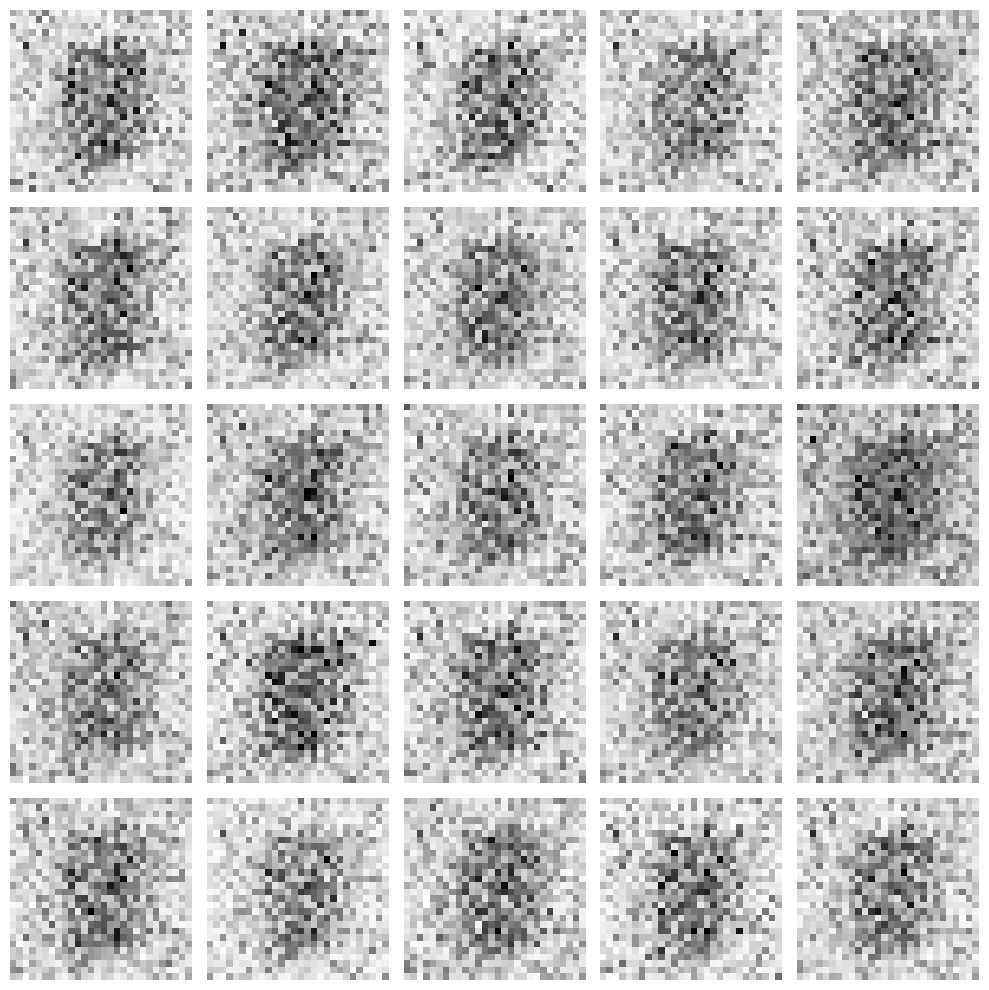

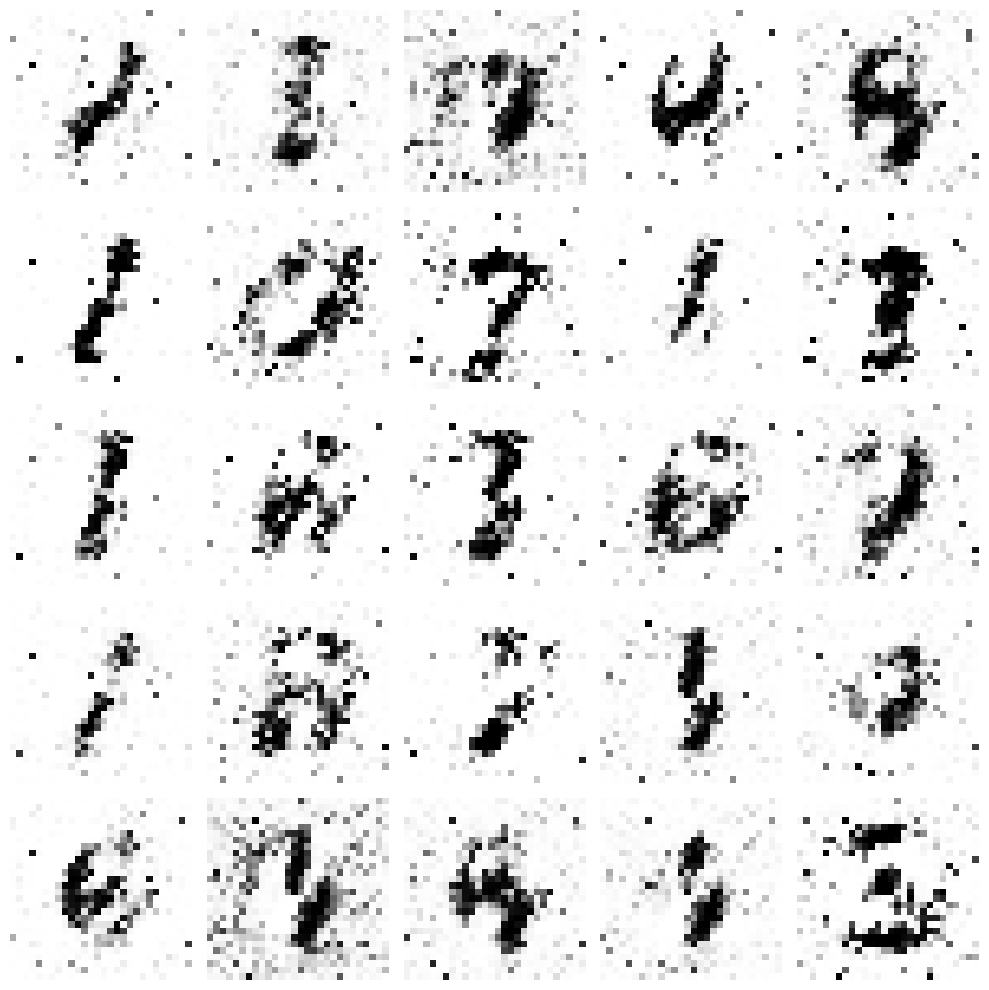

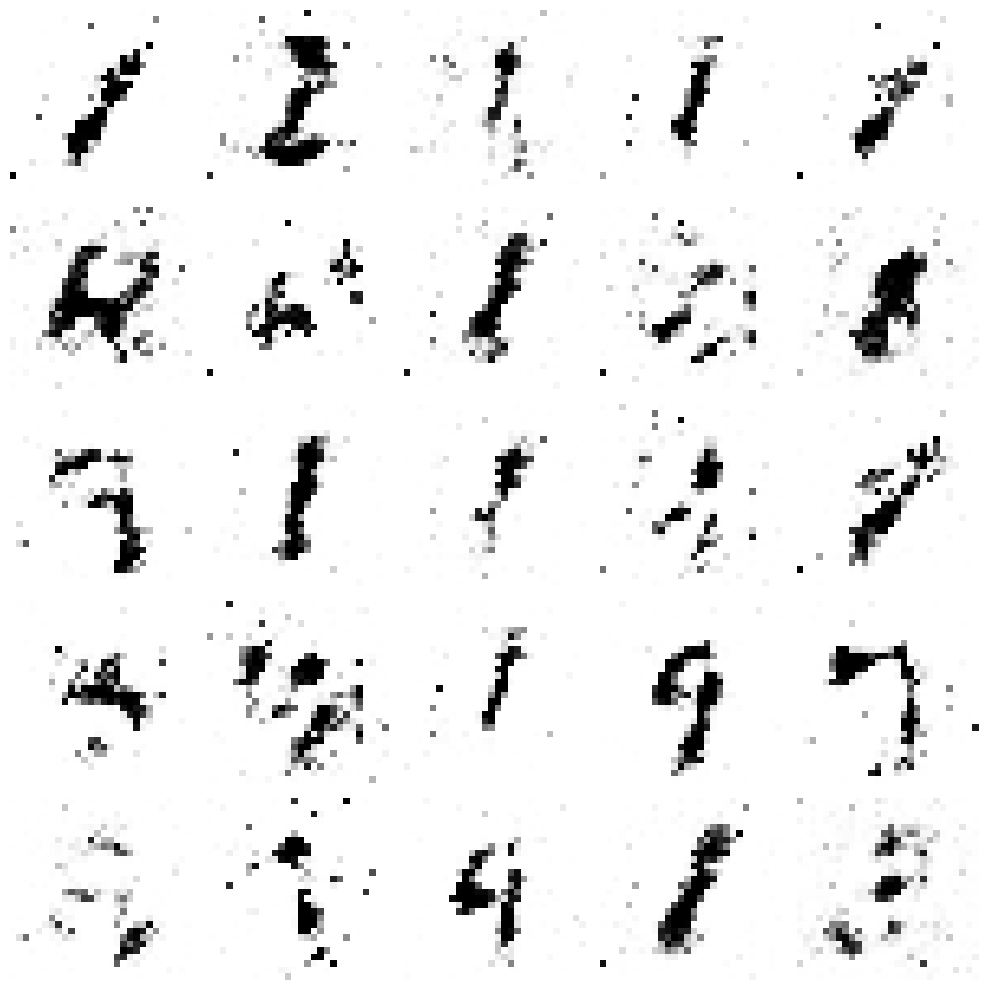

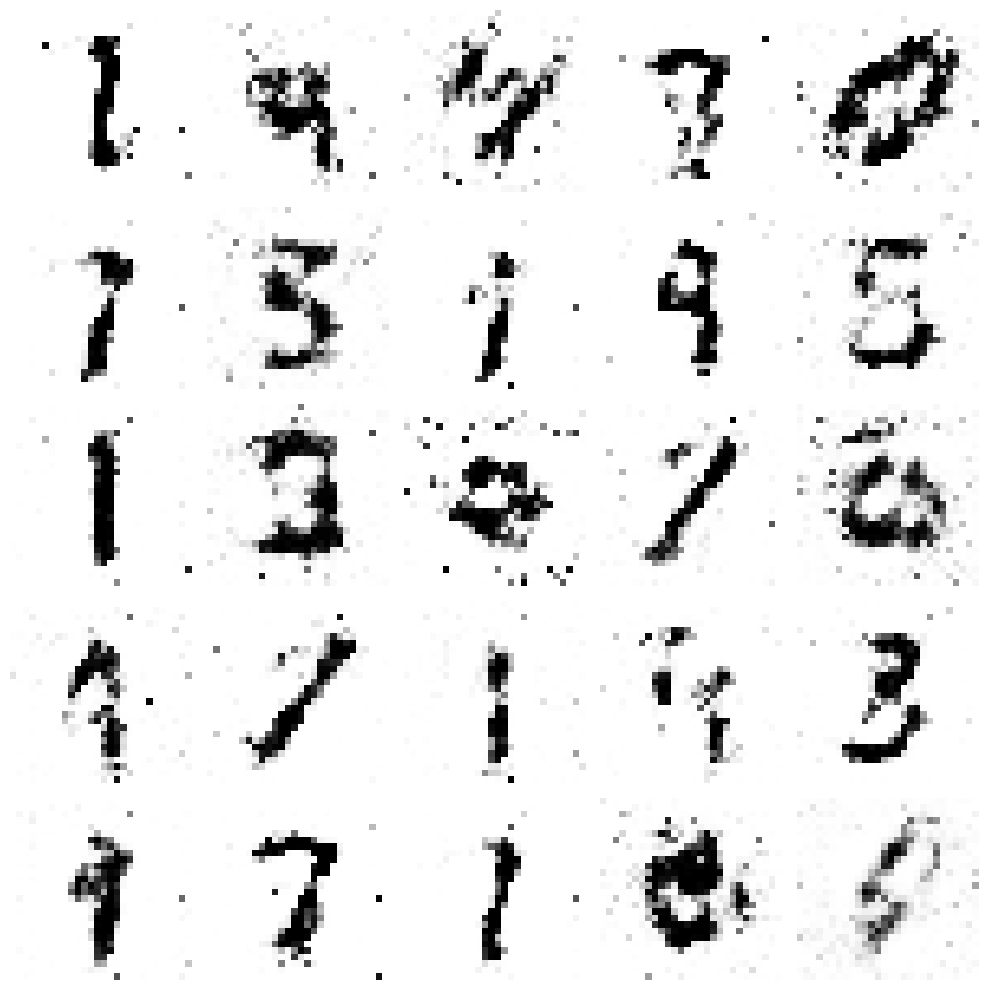

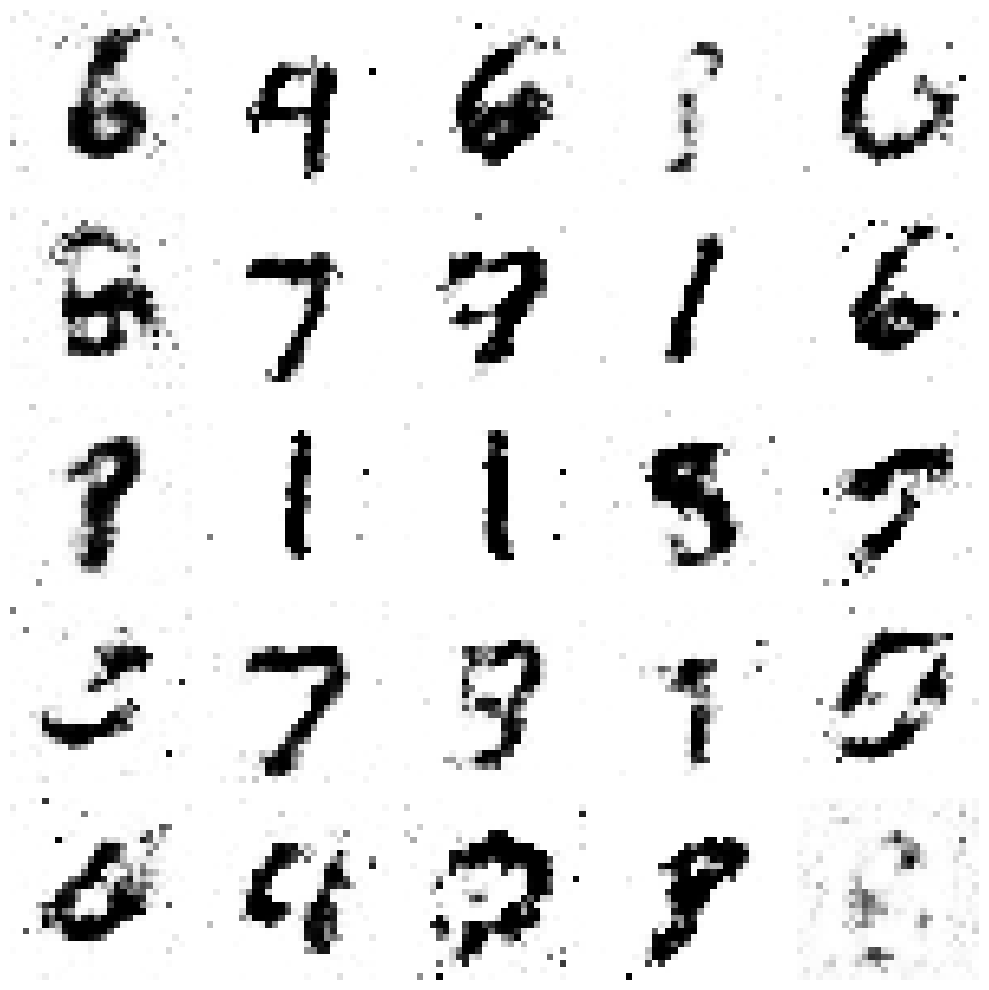

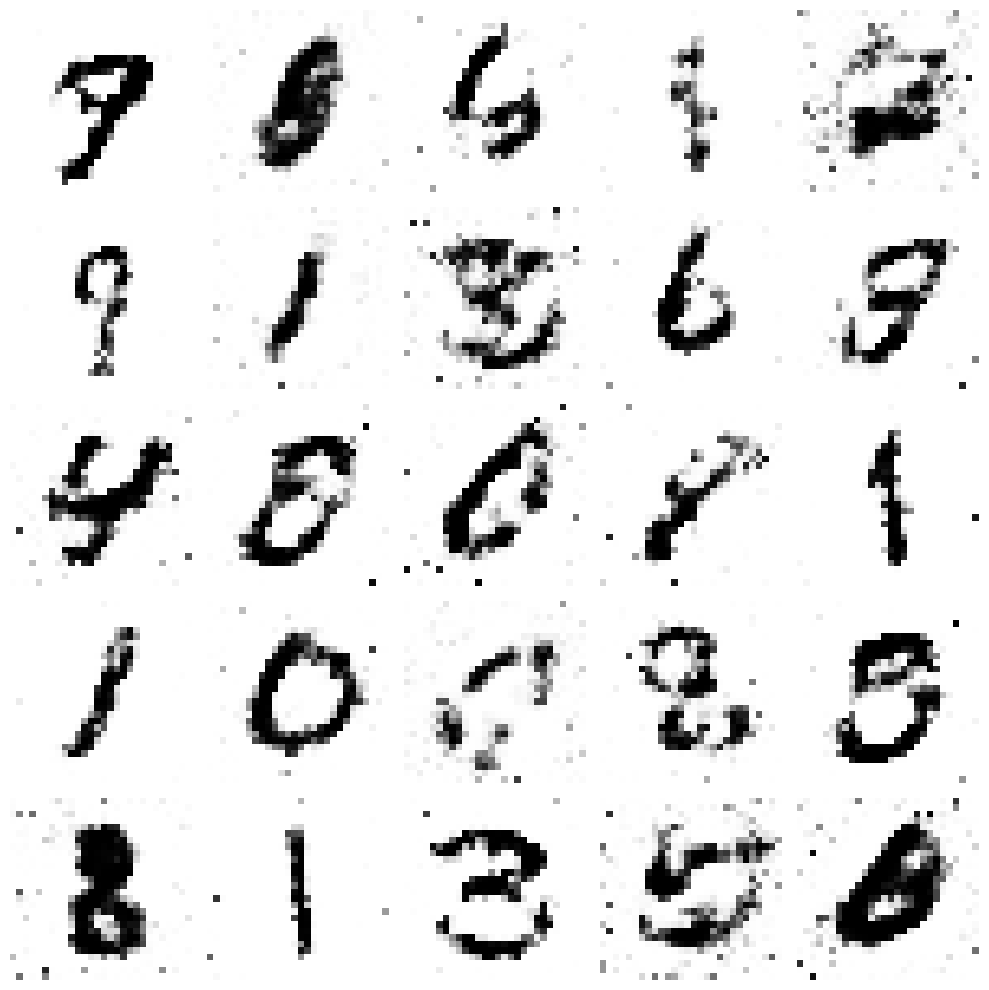

In [18]:
train_GAN(epochs=50, batch_size=128)